# Generador de rostros artificiales mediante redes adversativas

En este se usara imagenes de menor tamaño y se probara diferentes alternativas para ver si logramos que el modelo converga y genere rostros. Se intentara con un lote de mayor cantidad de imagenes,  cambios en la funcion de costo y optimizador, imagenes de mayor tamaño, otro set de datos

En una red adversaria se tienen dos modelos (que pueden ser Redes Neuronales o Convolucionales) compitiendo: un Generador y un Discriminador.

Se genera un primer modelo que llamaremos Discriminador para que sea capaz de reconocer rostros humanos. Este discriminador será simplemente un clasificador,que buscara indicar si una imagen es real o falsa

Se genera un segundo modelo, que llamaremos Generador y nuestro objetivo es entrenarlo para que sea capaz de tomar una entrada aleatoria y a la salida generar algo muy parecido a una imagen de un rostro.

La idea es entrenar esos dos modelos simultáneamente buscando que al final sea el Generador el vencedor en esta competencia.

## Funciones y carga de datos

In [1]:
TAM_ENTRADA = 100 # vector de entrada del modelo
TAM_IMG = 32 # tamaño de la imagen

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

### Funcion para carga y visualizar datos

In [3]:
def cargar_datos(dataset):
    print('Creando set de entrenamiento...')
    filelist = os.listdir(dataset)

    n_imgs = len(filelist)
    x_train = np.zeros((n_imgs,TAM_IMG,TAM_IMG,3))

    for i in range(n_imgs):
        direcion = str(dataset)+ "\\" + str(filelist[i])
        imagen = cv2.imread(direcion,1)
        imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
        imagen = cv2.resize(imagen, dsize=(TAM_IMG, TAM_IMG))
        imagen = (imagen - 127.5)/127.5 #para dejarlo entre -1 y 1
        x_train[i,:] = imagen
    print('¡Listo!')

    return x_train

def visualizar_imagen(imagen):
    imagen = imagen * 0.5 + 0.5 #para pasarlo de 0 a 1
    plt.imshow(imagen)
    plt.show()


### Funciones para crear el modelo

In [4]:
from keras.models import Sequential, Model
from keras.layers import Dense, Reshape, Conv2DTranspose, BatchNormalization, Conv2D, LeakyReLU, Flatten, Input, UpSampling2D
import tensorflow.keras.optimizers as optimizador
import time
import seaborn as sns

In [5]:
def crear_generador():
    modelo = Sequential(name = "Generador")
    
    modelo.add(Dense(int(TAM_IMG/8)*int(TAM_IMG/8)*3, use_bias=False, input_shape=(TAM_ENTRADA,)))
    modelo.add(Reshape((int(TAM_IMG/8),int(TAM_IMG/8),3)))
    #Tamaño resultante: 4x4x3
    
    modelo.add(Conv2DTranspose(128, 2, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    #Tamaño resultante: 4x4x128
    
    modelo.add(Conv2DTranspose(64, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    #modelo.add(Conv2DTranspose(64, 2, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    modelo.add(BatchNormalization())
    #Tamaño resultante: 8x8x64
    
    modelo.add(Conv2DTranspose(32, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    #modelo.add(Conv2DTranspose(32, 2, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    modelo.add(BatchNormalization())
    #Tamaño resultante: 16x16x32
    
    modelo.add(Conv2DTranspose(16, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    #modelo.add(Conv2DTranspose(16, 2, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    modelo.add(BatchNormalization())
    #Tamaño resultante: 32x32x16
    
    modelo.add(Conv2D(3, 2, strides = 1, padding='same',kernel_initializer='he_normal',use_bias=False))
    modelo.add(Conv2D(3, 2, strides = 1, padding='same',kernel_initializer='he_normal',use_bias=False))
    modelo.add(Conv2D(3, 2, strides = 1, padding = 'same',activation = 'tanh'))
    #Tamaño resultante: 32x32x3
    
    #modelo.compile(optimizer="Adam", loss="binary_crossentropy")

    print("Generador Creado")
    return modelo


In [6]:
def crear_discriminador(optimizador, error):
    
    modelo = Sequential(name = "Discriminador")

    modelo.add(Conv2D(32, 4, strides=2, padding='same',kernel_initializer='he_normal', input_shape=(TAM_IMG,TAM_IMG,3)))
    modelo.add(BatchNormalization())
    modelo.add(LeakyReLU())
    #16x16x32

    modelo.add(Conv2D(64, 4, strides=2, padding='same',kernel_initializer='he_normal'))
    modelo.add(BatchNormalization())
    modelo.add(LeakyReLU())
    #8x8x64
    
    modelo.add(Conv2D(128, 4, strides=1, padding='same',kernel_initializer='he_normal'))
    modelo.add(BatchNormalization())
    modelo.add(LeakyReLU())
    #4x4x128
    
    modelo.add(Flatten())
    #modelo.add(Dense(100, activation='LeakyReLU'))
    modelo.add(Dense(1, activation='sigmoid'))

    modelo.compile(optimizer = optimizador, loss= error)

    print("Discriminador Creado")
    return modelo

In [7]:
def crear_GAN(optimizador_g, error_g, optimizador_d=None, error_d=None):
    
    if optimizador_d==None:
        optimizador_d = optimizador_g
    
    if error_d==None:
        error_d = error_g
        
    generador = crear_generador()
    discriminador = crear_discriminador(optimizador_d, error_d)
    
    modelo = Sequential(name = "GAN")
    modelo.add(generador)
    discriminador.trainable = False
    modelo.add(discriminador)
    
    modelo.compile(optimizer = optimizador_g, loss= error_g)

    print("GAN Creado")
    return modelo


In [8]:
def predicion(GAN, ruido):
    print(GAN(ruido))  
    imagen = GAN.layers[0].predict(ruido)
    visualizar_imagen(imagen.reshape(TAM_IMG, TAM_IMG, 3))

### Funciones para el entrenamiento

En el caso de las Redes Adversarias debemos llevar a cabo estos pasos:

1. “Descongelar” los coeficientes del Discriminador
2. Entrenar solo el Discriminador con imagenes falsas y reales
3. “Congelar” los coeficientes del Discriminador
4. Entrenar la GAN, al estar congelado el discriminador únicamente se entrenara el Generador
5. Repetir los pasos 1 a 4 por el número de iteraciones que se vayan a usar el entrenamiento

In [9]:
 def entrenar(GAN, ITERACIONES, TAM_LOTE, CARPETAGUARDADO):
    
    generador = GAN.layers[0]
    discriminador = GAN.layers[1]
    error_d_acumulado = np.array([])
    error_g_acumulado = np.array([])
    prediccion_falsa = np.array([])
    
    for i in range(1, ITERACIONES+1):
        start = time.time()
        print("Comenzando Epoca " + str(i), end = "")

        # Crear un "batch" de imágenes falsas y otro con imágenes reales
        ruido = np.random.normal(0, 1, [TAM_LOTE, TAM_ENTRADA])
        batch_falsas = generador.predict(ruido)

        idx = np.random.randint(low=0, high=x_train.shape[0], size= TAM_LOTE)
        batch_reales = x_train[idx]

        #la unificacion del batch de entrenamiento es lo que logra que el modelo aprenda
        batch = np.concatenate((batch_reales, batch_falsas))

        #las reales le digo como resultado 1 con np.ones (el 0.9 ayuda a que converga mejor)
        #las falsas le digo como resultado 0 con np.zeros
        valores = np.concatenate((np.ones(TAM_LOTE)*0.9, np.zeros(TAM_LOTE)))

        print(".", end = "")

        discriminador.trainable = True

        # Entrenar discriminador con imagener falsas y reales
        dError = discriminador.train_on_batch(batch, valores)

        error_d_acumulado = np.append(error_d_acumulado, dError)

        #congelo el discriminador
        discriminador.trainable = False

        print(".", end = "")

        # Entrenar GAN: se generará ruido aleatorio y se presentará a la GAN como si fuesen imagenes reales
        ruido = np.random.normal(0, 1, [TAM_LOTE, TAM_ENTRADA])
        gError = GAN.train_on_batch(ruido, np.ones(TAM_LOTE))
            
        error_g_acumulado = np.append(error_g_acumulado, gError)

        print(".", end = "")

        #Cada 100 iteraciones vamos a guardar una imagen
        if i==1 or i%100 == 0:
            ruido = np.random.normal(0, 1, TAM_ENTRADA)
            ruido = np.array([ruido])
            resultado = generador.predict(ruido)
            resultado = resultado * 0.5 + 0.5
            plt.imshow(resultado.reshape(TAM_IMG, TAM_IMG, 3))
            plt.savefig(CARPETAGUARDADO + "/r" + str(i) + ".png")

        #hacemos una prueba de prediccion
        ruido = np.random.normal(0, 1, TAM_ENTRADA)
        ruido = np.array([ruido])
        resultado = GAN.predict(ruido)

        prediccion_falsa = np.append(prediccion_falsa, resultado)
        end = time.time()
        print(" Fin")
        print("Tiempo transcurrido: ", round((end - start), 2), "s")
        trm = (ITERACIONES + 1 - i) * (end - start) / 60 #tiempo restante en minutos
        print("Tiempo restante aprox: " + str(round(trm, 2)) + "m -> " + str(int(trm/60)) + ":" + str(int(trm%60)) + "h")
        print("prediccion de ruido: ", resultado)
        print("===================================================================")
        
    return error_d_acumulado, error_g_acumulado, prediccion_falsa
            
def plot_acumulado(tamaño, lim_sup = 1, **valores):
    t = np.linspace(1, tamaño, tamaño)
    plt.figure(figsize=(20, 6))
    plt.ylim(0, lim_sup)
    for v in valores:
        sns.lineplot(x=t, y=valores[v], label=v)


## Carga de datos

In [10]:
x_train = cargar_datos("dataset1")

Creando set de entrenamiento...
¡Listo!


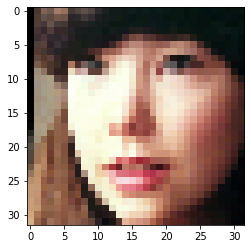

In [11]:
visualizar_imagen(x_train[12])

## Prueba de modelos

### Primer modelo

Primero vamos a provar con un lote de mayor tamaño (150 -> 500)

In [12]:
OPTIMIZADOR = optimizador.Adam()
ERROR = 'binary_crossentropy'

generador1 = crear_generador()
discriminador1 = crear_discriminador(OPTIMIZADOR, ERROR)
gan1 = crear_GAN(generador1, discriminador1, OPTIMIZADOR, ERROR)

Generador Creado
Discriminador Creado
GAN Creado


Comenzando Epoca 1... Fin
Tiempo transcurrido:  2.289379596710205
prediccion de ruido:  [[0.12212223]]
Comenzando Epoca 2... Fin
Tiempo transcurrido:  2.1843647956848145
prediccion de ruido:  [[0.09460509]]
Comenzando Epoca 3... Fin
Tiempo transcurrido:  2.206190586090088
prediccion de ruido:  [[0.18621731]]
Comenzando Epoca 4... Fin
Tiempo transcurrido:  2.179378032684326
prediccion de ruido:  [[0.35478973]]
Comenzando Epoca 5... Fin
Tiempo transcurrido:  2.153975009918213
prediccion de ruido:  [[0.20079643]]
Comenzando Epoca 6... Fin
Tiempo transcurrido:  2.1685526371002197
prediccion de ruido:  [[0.15742314]]
Comenzando Epoca 7... Fin
Tiempo transcurrido:  2.2295613288879395
prediccion de ruido:  [[0.34808773]]
Comenzando Epoca 8... Fin
Tiempo transcurrido:  2.2243852615356445
prediccion de ruido:  [[0.19792]]
Comenzando Epoca 9... Fin
Tiempo transcurrido:  2.2755935192108154
prediccion de ruido:  [[0.2228713]]
Comenzando Epoca 10... Fin
Tiempo transcurrido:  2.1575722694396973
pred

Comenzando Epoca 49... Fin
Tiempo transcurrido:  2.147759199142456
prediccion de ruido:  [[0.00280422]]
Comenzando Epoca 50... Fin
Tiempo transcurrido:  2.1369638442993164
prediccion de ruido:  [[0.05691084]]
Comenzando Epoca 51... Fin
Tiempo transcurrido:  2.158165216445923
prediccion de ruido:  [[0.03230953]]
Comenzando Epoca 52... Fin
Tiempo transcurrido:  2.137350559234619
prediccion de ruido:  [[0.00214005]]
Comenzando Epoca 53... Fin
Tiempo transcurrido:  2.147759199142456
prediccion de ruido:  [[0.00013205]]
Comenzando Epoca 54... Fin
Tiempo transcurrido:  2.1215596199035645
prediccion de ruido:  [[0.00135615]]
Comenzando Epoca 55... Fin
Tiempo transcurrido:  2.164158821105957
prediccion de ruido:  [[0.00028726]]
Comenzando Epoca 56... Fin
Tiempo transcurrido:  2.1535837650299072
prediccion de ruido:  [[0.00040466]]
Comenzando Epoca 57... Fin
Tiempo transcurrido:  2.2166104316711426
prediccion de ruido:  [[0.00222766]]
Comenzando Epoca 58... Fin
Tiempo transcurrido:  2.201972723

Comenzando Epoca 97... Fin
Tiempo transcurrido:  2.1706125736236572
prediccion de ruido:  [[0.13331541]]
Comenzando Epoca 98... Fin
Tiempo transcurrido:  2.2343685626983643
prediccion de ruido:  [[0.1423626]]
Comenzando Epoca 99... Fin
Tiempo transcurrido:  2.261162519454956
prediccion de ruido:  [[0.12963298]]
Comenzando Epoca 100... Fin
Tiempo transcurrido:  2.4151430130004883
prediccion de ruido:  [[0.19455531]]
Comenzando Epoca 101... Fin
Tiempo transcurrido:  2.156919240951538
prediccion de ruido:  [[0.03173181]]
Comenzando Epoca 102... Fin
Tiempo transcurrido:  2.1861143112182617
prediccion de ruido:  [[0.24162385]]
Comenzando Epoca 103... Fin
Tiempo transcurrido:  2.1903181076049805
prediccion de ruido:  [[0.5878487]]
Comenzando Epoca 104... Fin
Tiempo transcurrido:  2.2284905910491943
prediccion de ruido:  [[0.01816195]]
Comenzando Epoca 105... Fin
Tiempo transcurrido:  2.1372547149658203
prediccion de ruido:  [[0.50925773]]
Comenzando Epoca 106... Fin
Tiempo transcurrido:  2.1

Comenzando Epoca 145... Fin
Tiempo transcurrido:  2.1398656368255615
prediccion de ruido:  [[0.7131877]]
Comenzando Epoca 146... Fin
Tiempo transcurrido:  2.13826060295105
prediccion de ruido:  [[0.6283979]]
Comenzando Epoca 147... Fin
Tiempo transcurrido:  2.142860174179077
prediccion de ruido:  [[0.58084923]]
Comenzando Epoca 148... Fin
Tiempo transcurrido:  2.141092300415039
prediccion de ruido:  [[0.63107836]]
Comenzando Epoca 149... Fin
Tiempo transcurrido:  2.2295196056365967
prediccion de ruido:  [[0.5969023]]
Comenzando Epoca 150... Fin
Tiempo transcurrido:  2.2792747020721436
prediccion de ruido:  [[0.6934209]]
Comenzando Epoca 151... Fin
Tiempo transcurrido:  2.143860340118408
prediccion de ruido:  [[0.8344978]]
Comenzando Epoca 152... Fin
Tiempo transcurrido:  2.208263397216797
prediccion de ruido:  [[0.7404326]]
Comenzando Epoca 153... Fin
Tiempo transcurrido:  2.1896615028381348
prediccion de ruido:  [[0.65129566]]
Comenzando Epoca 154... Fin
Tiempo transcurrido:  2.163710

Comenzando Epoca 193... Fin
Tiempo transcurrido:  2.133655548095703
prediccion de ruido:  [[0.62061477]]
Comenzando Epoca 194... Fin
Tiempo transcurrido:  2.122654438018799
prediccion de ruido:  [[0.622076]]
Comenzando Epoca 195... Fin
Tiempo transcurrido:  2.1392550468444824
prediccion de ruido:  [[0.52823484]]
Comenzando Epoca 196... Fin
Tiempo transcurrido:  2.121654510498047
prediccion de ruido:  [[0.5510427]]
Comenzando Epoca 197... Fin
Tiempo transcurrido:  2.1372547149658203
prediccion de ruido:  [[0.68184334]]
Comenzando Epoca 198... Fin
Tiempo transcurrido:  2.121654510498047
prediccion de ruido:  [[0.5540965]]
Comenzando Epoca 199... Fin
Tiempo transcurrido:  2.155855417251587
prediccion de ruido:  [[0.58180285]]
Comenzando Epoca 200... Fin
Tiempo transcurrido:  2.2308571338653564
prediccion de ruido:  [[0.42173272]]
Comenzando Epoca 201... Fin
Tiempo transcurrido:  2.152855396270752
prediccion de ruido:  [[0.6219852]]
Comenzando Epoca 202... Fin
Tiempo transcurrido:  2.13725

Comenzando Epoca 241... Fin
Tiempo transcurrido:  2.138213872909546
prediccion de ruido:  [[0.24401739]]
Comenzando Epoca 242... Fin
Tiempo transcurrido:  2.2352232933044434
prediccion de ruido:  [[0.2310999]]
Comenzando Epoca 243... Fin
Tiempo transcurrido:  2.2022202014923096
prediccion de ruido:  [[0.14355847]]
Comenzando Epoca 244... Fin
Tiempo transcurrido:  2.1332130432128906
prediccion de ruido:  [[0.37999406]]
Comenzando Epoca 245... Fin
Tiempo transcurrido:  2.141213893890381
prediccion de ruido:  [[0.39709085]]
Comenzando Epoca 246... Fin
Tiempo transcurrido:  2.1362133026123047
prediccion de ruido:  [[0.35947824]]
Comenzando Epoca 247... Fin
Tiempo transcurrido:  2.1362133026123047
prediccion de ruido:  [[0.35895246]]
Comenzando Epoca 248... Fin
Tiempo transcurrido:  2.1322131156921387
prediccion de ruido:  [[0.50627726]]
Comenzando Epoca 249... Fin
Tiempo transcurrido:  2.1562156677246094
prediccion de ruido:  [[0.47790033]]
Comenzando Epoca 250... Fin
Tiempo transcurrido: 

Comenzando Epoca 289... Fin
Tiempo transcurrido:  2.706270694732666
prediccion de ruido:  [[0.0043073]]
Comenzando Epoca 290... Fin
Tiempo transcurrido:  2.5752577781677246
prediccion de ruido:  [[0.00184208]]
Comenzando Epoca 291... Fin
Tiempo transcurrido:  2.519251823425293
prediccion de ruido:  [[0.04023331]]
Comenzando Epoca 292... Fin
Tiempo transcurrido:  2.44824481010437
prediccion de ruido:  [[0.02423427]]
Comenzando Epoca 293... Fin
Tiempo transcurrido:  2.4632463455200195
prediccion de ruido:  [[0.00143537]]
Comenzando Epoca 294... Fin
Tiempo transcurrido:  2.6592657566070557
prediccion de ruido:  [[0.01376322]]
Comenzando Epoca 295... Fin
Tiempo transcurrido:  2.438243865966797
prediccion de ruido:  [[0.00936028]]
Comenzando Epoca 296... Fin
Tiempo transcurrido:  2.3162314891815186
prediccion de ruido:  [[0.0122501]]
Comenzando Epoca 297... Fin
Tiempo transcurrido:  2.3462345600128174
prediccion de ruido:  [[0.00569934]]
Comenzando Epoca 298... Fin
Tiempo transcurrido:  2.3

Comenzando Epoca 336... Fin
Tiempo transcurrido:  2.2372238636016846
prediccion de ruido:  [[0.00974834]]
Comenzando Epoca 337... Fin
Tiempo transcurrido:  2.1322131156921387
prediccion de ruido:  [[5.887493e-05]]
Comenzando Epoca 338... Fin
Tiempo transcurrido:  2.136213779449463
prediccion de ruido:  [[0.00134841]]
Comenzando Epoca 339... Fin
Tiempo transcurrido:  2.2742271423339844
prediccion de ruido:  [[0.01063681]]
Comenzando Epoca 340... Fin
Tiempo transcurrido:  2.221222162246704
prediccion de ruido:  [[0.00031182]]
Comenzando Epoca 341... Fin
Tiempo transcurrido:  2.151215076446533
prediccion de ruido:  [[5.4520144e-05]]
Comenzando Epoca 342... Fin
Tiempo transcurrido:  2.1372134685516357
prediccion de ruido:  [[0.01009101]]
Comenzando Epoca 343... Fin
Tiempo transcurrido:  2.146214485168457
prediccion de ruido:  [[0.00489458]]
Comenzando Epoca 344... Fin
Tiempo transcurrido:  2.1582157611846924
prediccion de ruido:  [[0.01627576]]
Comenzando Epoca 345... Fin
Tiempo transcurri

Comenzando Epoca 384... Fin
Tiempo transcurrido:  2.137213706970215
prediccion de ruido:  [[0.23667979]]
Comenzando Epoca 385... Fin
Tiempo transcurrido:  2.144615888595581
prediccion de ruido:  [[0.17886233]]
Comenzando Epoca 386... Fin
Tiempo transcurrido:  2.2036144733428955
prediccion de ruido:  [[0.33970982]]
Comenzando Epoca 387... Fin
Tiempo transcurrido:  2.184014081954956
prediccion de ruido:  [[0.28556794]]
Comenzando Epoca 388... Fin
Tiempo transcurrido:  2.137213706970215
prediccion de ruido:  [[0.12552118]]
Comenzando Epoca 389... Fin
Tiempo transcurrido:  2.1236138343811035
prediccion de ruido:  [[0.10257763]]
Comenzando Epoca 390... Fin
Tiempo transcurrido:  2.346015453338623
prediccion de ruido:  [[0.07900658]]
Comenzando Epoca 391... Fin
Tiempo transcurrido:  2.2068192958831787
prediccion de ruido:  [[0.24201009]]
Comenzando Epoca 392... Fin
Tiempo transcurrido:  2.2400195598602295
prediccion de ruido:  [[0.07872355]]
Comenzando Epoca 393... Fin
Tiempo transcurrido:  2

Comenzando Epoca 432... Fin
Tiempo transcurrido:  2.1417105197906494
prediccion de ruido:  [[0.01877698]]
Comenzando Epoca 433... Fin
Tiempo transcurrido:  2.1411075592041016
prediccion de ruido:  [[0.02867568]]
Comenzando Epoca 434... Fin
Tiempo transcurrido:  2.18770694732666
prediccion de ruido:  [[0.03263074]]
Comenzando Epoca 435... Fin
Tiempo transcurrido:  2.159508228302002
prediccion de ruido:  [[0.05391082]]
Comenzando Epoca 436... Fin
Tiempo transcurrido:  2.1415083408355713
prediccion de ruido:  [[0.08487642]]
Comenzando Epoca 437... Fin
Tiempo transcurrido:  2.1527113914489746
prediccion de ruido:  [[0.11870143]]
Comenzando Epoca 438... Fin
Tiempo transcurrido:  2.1603140830993652
prediccion de ruido:  [[0.07092252]]
Comenzando Epoca 439... Fin
Tiempo transcurrido:  2.460571527481079
prediccion de ruido:  [[0.00839633]]
Comenzando Epoca 440... Fin
Tiempo transcurrido:  2.267720937728882
prediccion de ruido:  [[0.11078447]]
Comenzando Epoca 441... Fin
Tiempo transcurrido:  2

Comenzando Epoca 480... Fin
Tiempo transcurrido:  2.2111425399780273
prediccion de ruido:  [[0.14125818]]
Comenzando Epoca 481... Fin
Tiempo transcurrido:  2.349780559539795
prediccion de ruido:  [[0.01306677]]
Comenzando Epoca 482... Fin
Tiempo transcurrido:  2.2933411598205566
prediccion de ruido:  [[0.04765382]]
Comenzando Epoca 483... Fin
Tiempo transcurrido:  2.198118209838867
prediccion de ruido:  [[0.01689383]]
Comenzando Epoca 484... Fin
Tiempo transcurrido:  2.125504732131958
prediccion de ruido:  [[0.1100646]]
Comenzando Epoca 485... Fin
Tiempo transcurrido:  2.152703285217285
prediccion de ruido:  [[0.14250308]]
Comenzando Epoca 486... Fin
Tiempo transcurrido:  2.2326998710632324
prediccion de ruido:  [[0.10228109]]
Comenzando Epoca 487... Fin
Tiempo transcurrido:  2.2462992668151855
prediccion de ruido:  [[0.14003378]]
Comenzando Epoca 488... Fin
Tiempo transcurrido:  2.154703378677368
prediccion de ruido:  [[0.03708962]]
Comenzando Epoca 489... Fin
Tiempo transcurrido:  2.

Comenzando Epoca 528... Fin
Tiempo transcurrido:  2.1527163982391357
prediccion de ruido:  [[0.00237438]]
Comenzando Epoca 529... Fin
Tiempo transcurrido:  2.183972120285034
prediccion de ruido:  [[0.01132157]]
Comenzando Epoca 530... Fin
Tiempo transcurrido:  2.121572732925415
prediccion de ruido:  [[0.00734568]]
Comenzando Epoca 531... Fin
Tiempo transcurrido:  2.2151715755462646
prediccion de ruido:  [[0.01291355]]
Comenzando Epoca 532... Fin
Tiempo transcurrido:  2.1527724266052246
prediccion de ruido:  [[0.01802263]]
Comenzando Epoca 533... Fin
Tiempo transcurrido:  2.1371724605560303
prediccion de ruido:  [[0.00305751]]
Comenzando Epoca 534... Fin
Tiempo transcurrido:  2.2151715755462646
prediccion de ruido:  [[0.02911514]]
Comenzando Epoca 535... Fin
Tiempo transcurrido:  2.16837215423584
prediccion de ruido:  [[0.01067731]]
Comenzando Epoca 536... Fin
Tiempo transcurrido:  2.16937255859375
prediccion de ruido:  [[0.00606748]]
Comenzando Epoca 537... Fin
Tiempo transcurrido:  2.

Comenzando Epoca 576... Fin
Tiempo transcurrido:  2.168372392654419
prediccion de ruido:  [[0.0154345]]
Comenzando Epoca 577... Fin
Tiempo transcurrido:  2.1995716094970703
prediccion de ruido:  [[0.01075864]]
Comenzando Epoca 578... Fin
Tiempo transcurrido:  2.3087704181671143
prediccion de ruido:  [[0.01130012]]
Comenzando Epoca 579... Fin
Tiempo transcurrido:  2.16837215423584
prediccion de ruido:  [[0.00514588]]
Comenzando Epoca 580... Fin
Tiempo transcurrido:  2.1995718479156494
prediccion de ruido:  [[0.00884491]]
Comenzando Epoca 581... Fin
Tiempo transcurrido:  2.1547722816467285
prediccion de ruido:  [[0.01368812]]
Comenzando Epoca 582... Fin
Tiempo transcurrido:  2.183972120285034
prediccion de ruido:  [[0.0048528]]
Comenzando Epoca 583... Fin
Tiempo transcurrido:  2.1995716094970703
prediccion de ruido:  [[0.00970298]]
Comenzando Epoca 584... Fin
Tiempo transcurrido:  2.1441726684570312
prediccion de ruido:  [[0.02336505]]
Comenzando Epoca 585... Fin
Tiempo transcurrido:  2.

Comenzando Epoca 624... Fin
Tiempo transcurrido:  2.1381726264953613
prediccion de ruido:  [[0.01339513]]
Comenzando Epoca 625... Fin
Tiempo transcurrido:  2.1371724605560303
prediccion de ruido:  [[0.0005717]]
Comenzando Epoca 626... Fin
Tiempo transcurrido:  2.121572732925415
prediccion de ruido:  [[0.00358257]]
Comenzando Epoca 627... Fin
Tiempo transcurrido:  2.1421728134155273
prediccion de ruido:  [[0.00490016]]
Comenzando Epoca 628... Fin
Tiempo transcurrido:  2.121572494506836
prediccion de ruido:  [[0.00073928]]
Comenzando Epoca 629... Fin
Tiempo transcurrido:  2.1371726989746094
prediccion de ruido:  [[2.338716e-05]]
Comenzando Epoca 630... Fin
Tiempo transcurrido:  2.1371726989746094
prediccion de ruido:  [[0.00078681]]
Comenzando Epoca 631... Fin
Tiempo transcurrido:  2.122572660446167
prediccion de ruido:  [[0.00011459]]
Comenzando Epoca 632... Fin
Tiempo transcurrido:  2.1537725925445557
prediccion de ruido:  [[6.446013e-05]]
Comenzando Epoca 633... Fin
Tiempo transcurrid

Comenzando Epoca 672... Fin
Tiempo transcurrido:  2.2087998390197754
prediccion de ruido:  [[0.01701865]]
Comenzando Epoca 673... Fin
Tiempo transcurrido:  2.3977999687194824
prediccion de ruido:  [[0.00363362]]
Comenzando Epoca 674... Fin
Tiempo transcurrido:  2.680999994277954
prediccion de ruido:  [[0.00427863]]
Comenzando Epoca 675... Fin
Tiempo transcurrido:  2.149600028991699
prediccion de ruido:  [[0.00694191]]
Comenzando Epoca 676... Fin
Tiempo transcurrido:  2.191800117492676
prediccion de ruido:  [[0.0036248]]
Comenzando Epoca 677... Fin
Tiempo transcurrido:  2.192199945449829
prediccion de ruido:  [[0.01089102]]
Comenzando Epoca 678... Fin
Tiempo transcurrido:  2.1570000648498535
prediccion de ruido:  [[0.00611797]]
Comenzando Epoca 679... Fin
Tiempo transcurrido:  2.320199966430664
prediccion de ruido:  [[0.03135595]]
Comenzando Epoca 680... Fin
Tiempo transcurrido:  2.1600000858306885
prediccion de ruido:  [[0.01380014]]
Comenzando Epoca 681... Fin
Tiempo transcurrido:  2.

Comenzando Epoca 720... Fin
Tiempo transcurrido:  2.137200117111206
prediccion de ruido:  [[0.00248447]]
Comenzando Epoca 721... Fin
Tiempo transcurrido:  2.137199878692627
prediccion de ruido:  [[0.00498268]]
Comenzando Epoca 722... Fin
Tiempo transcurrido:  2.13919997215271
prediccion de ruido:  [[0.00133407]]
Comenzando Epoca 723... Fin
Tiempo transcurrido:  2.1215999126434326
prediccion de ruido:  [[0.02332854]]
Comenzando Epoca 724... Fin
Tiempo transcurrido:  2.137200117111206
prediccion de ruido:  [[0.0019972]]
Comenzando Epoca 725... Fin
Tiempo transcurrido:  2.1216001510620117
prediccion de ruido:  [[0.00432816]]
Comenzando Epoca 726... Fin
Tiempo transcurrido:  2.137199878692627
prediccion de ruido:  [[0.01112363]]
Comenzando Epoca 727... Fin
Tiempo transcurrido:  2.1548001766204834
prediccion de ruido:  [[0.00899374]]
Comenzando Epoca 728... Fin
Tiempo transcurrido:  2.137199878692627
prediccion de ruido:  [[0.00641754]]
Comenzando Epoca 729... Fin
Tiempo transcurrido:  2.12

Comenzando Epoca 768... Fin
Tiempo transcurrido:  2.1215999126434326
prediccion de ruido:  [[0.00252777]]
Comenzando Epoca 769... Fin
Tiempo transcurrido:  2.1215999126434326
prediccion de ruido:  [[0.01064265]]
Comenzando Epoca 770... Fin
Tiempo transcurrido:  2.138200044631958
prediccion de ruido:  [[0.00265896]]
Comenzando Epoca 771... Fin
Tiempo transcurrido:  2.140200138092041
prediccion de ruido:  [[0.00459364]]
Comenzando Epoca 772... Fin
Tiempo transcurrido:  2.1215999126434326
prediccion de ruido:  [[0.05940041]]
Comenzando Epoca 773... Fin
Tiempo transcurrido:  2.137200117111206
prediccion de ruido:  [[0.00287941]]
Comenzando Epoca 774... Fin
Tiempo transcurrido:  2.1528000831604004
prediccion de ruido:  [[0.00239366]]
Comenzando Epoca 775... Fin
Tiempo transcurrido:  2.184000015258789
prediccion de ruido:  [[0.00335425]]
Comenzando Epoca 776... Fin
Tiempo transcurrido:  2.137199878692627
prediccion de ruido:  [[0.00684279]]
Comenzando Epoca 777... Fin
Tiempo transcurrido:  2

Comenzando Epoca 816... Fin
Tiempo transcurrido:  2.2151999473571777
prediccion de ruido:  [[0.00115761]]
Comenzando Epoca 817... Fin
Tiempo transcurrido:  2.184000015258789
prediccion de ruido:  [[0.00020471]]
Comenzando Epoca 818... Fin
Tiempo transcurrido:  2.2065999507904053
prediccion de ruido:  [[0.00042334]]
Comenzando Epoca 819... Fin
Tiempo transcurrido:  2.1396002769470215
prediccion de ruido:  [[0.00310043]]
Comenzando Epoca 820... Fin
Tiempo transcurrido:  2.138200044631958
prediccion de ruido:  [[0.00085703]]
Comenzando Epoca 821... Fin
Tiempo transcurrido:  2.1693997383117676
prediccion de ruido:  [[0.00128511]]
Comenzando Epoca 822... Fin
Tiempo transcurrido:  2.1684000492095947
prediccion de ruido:  [[0.00043061]]
Comenzando Epoca 823... Fin
Tiempo transcurrido:  2.137199878692627
prediccion de ruido:  [[0.00057119]]
Comenzando Epoca 824... Fin
Tiempo transcurrido:  2.1528000831604004
prediccion de ruido:  [[0.01591355]]
Comenzando Epoca 825... Fin
Tiempo transcurrido: 

Comenzando Epoca 864... Fin
Tiempo transcurrido:  2.4303998947143555
prediccion de ruido:  [[0.00552279]]
Comenzando Epoca 865... Fin
Tiempo transcurrido:  2.299600124359131
prediccion de ruido:  [[0.00135788]]
Comenzando Epoca 866... Fin
Tiempo transcurrido:  2.1704001426696777
prediccion de ruido:  [[0.02256769]]
Comenzando Epoca 867... Fin
Tiempo transcurrido:  2.1683998107910156
prediccion de ruido:  [[0.01063731]]
Comenzando Epoca 868... Fin
Tiempo transcurrido:  2.35860013961792
prediccion de ruido:  [[0.00832468]]
Comenzando Epoca 869... Fin
Tiempo transcurrido:  2.4042000770568848
prediccion de ruido:  [[0.00805753]]
Comenzando Epoca 870... Fin
Tiempo transcurrido:  2.137199878692627
prediccion de ruido:  [[0.01666585]]
Comenzando Epoca 871... Fin
Tiempo transcurrido:  2.1684000492095947
prediccion de ruido:  [[0.02458438]]
Comenzando Epoca 872... Fin
Tiempo transcurrido:  2.263000011444092
prediccion de ruido:  [[0.05678746]]
Comenzando Epoca 873... Fin
Tiempo transcurrido:  2

Comenzando Epoca 912... Fin
Tiempo transcurrido:  2.1528000831604004
prediccion de ruido:  [[0.01236972]]
Comenzando Epoca 913... Fin
Tiempo transcurrido:  2.1527998447418213
prediccion de ruido:  [[0.00696403]]
Comenzando Epoca 914... Fin
Tiempo transcurrido:  2.2474000453948975
prediccion de ruido:  [[0.00380304]]
Comenzando Epoca 915... Fin
Tiempo transcurrido:  2.3399999141693115
prediccion de ruido:  [[0.00123936]]
Comenzando Epoca 916... Fin
Tiempo transcurrido:  2.184000015258789
prediccion de ruido:  [[0.00759533]]
Comenzando Epoca 917... Fin
Tiempo transcurrido:  2.91759991645813
prediccion de ruido:  [[0.06981215]]
Comenzando Epoca 918... Fin
Tiempo transcurrido:  2.517400026321411
prediccion de ruido:  [[0.00099981]]
Comenzando Epoca 919... Fin
Tiempo transcurrido:  2.1684000492095947
prediccion de ruido:  [[0.00140592]]
Comenzando Epoca 920... Fin
Tiempo transcurrido:  2.1684000492095947
prediccion de ruido:  [[0.0067341]]
Comenzando Epoca 921... Fin
Tiempo transcurrido:  2

Comenzando Epoca 960... Fin
Tiempo transcurrido:  2.5748002529144287
prediccion de ruido:  [[0.00143489]]
Comenzando Epoca 961... Fin
Tiempo transcurrido:  2.19920015335083
prediccion de ruido:  [[0.01389602]]
Comenzando Epoca 962... Fin
Tiempo transcurrido:  2.30079984664917
prediccion de ruido:  [[0.00243753]]
Comenzando Epoca 963... Fin
Tiempo transcurrido:  2.1538000106811523
prediccion de ruido:  [[0.02008203]]
Comenzando Epoca 964... Fin
Tiempo transcurrido:  2.1283998489379883
prediccion de ruido:  [[0.00676662]]
Comenzando Epoca 965... Fin
Tiempo transcurrido:  2.184000015258789
prediccion de ruido:  [[0.03465384]]
Comenzando Epoca 966... Fin
Tiempo transcurrido:  2.134000062942505
prediccion de ruido:  [[0.00335711]]
Comenzando Epoca 967... Fin
Tiempo transcurrido:  2.3299999237060547
prediccion de ruido:  [[0.04142845]]
Comenzando Epoca 968... Fin
Tiempo transcurrido:  2.203000068664551
prediccion de ruido:  [[0.01746497]]
Comenzando Epoca 969... Fin
Tiempo transcurrido:  2.1

Comenzando Epoca 1008... Fin
Tiempo transcurrido:  2.2619998455047607
prediccion de ruido:  [[0.00309718]]
Comenzando Epoca 1009... Fin
Tiempo transcurrido:  2.1684000492095947
prediccion de ruido:  [[0.00149632]]
Comenzando Epoca 1010... Fin
Tiempo transcurrido:  2.2563998699188232
prediccion de ruido:  [[0.00545439]]
Comenzando Epoca 1011... Fin
Tiempo transcurrido:  2.382000207901001
prediccion de ruido:  [[0.04974598]]
Comenzando Epoca 1012... Fin
Tiempo transcurrido:  2.1215999126434326
prediccion de ruido:  [[0.02089992]]
Comenzando Epoca 1013... Fin
Tiempo transcurrido:  2.137199878692627
prediccion de ruido:  [[0.00443533]]
Comenzando Epoca 1014... Fin
Tiempo transcurrido:  2.184000015258789
prediccion de ruido:  [[0.00408128]]
Comenzando Epoca 1015... Fin
Tiempo transcurrido:  2.1436002254486084
prediccion de ruido:  [[0.00058803]]
Comenzando Epoca 1016... Fin
Tiempo transcurrido:  2.1995997428894043
prediccion de ruido:  [[0.00435337]]
Comenzando Epoca 1017... Fin
Tiempo tran

Comenzando Epoca 1055... Fin
Tiempo transcurrido:  2.1216001510620117
prediccion de ruido:  [[0.00022012]]
Comenzando Epoca 1056... Fin
Tiempo transcurrido:  2.1215999126434326
prediccion de ruido:  [[0.00027671]]
Comenzando Epoca 1057... Fin
Tiempo transcurrido:  2.1216001510620117
prediccion de ruido:  [[0.00580883]]
Comenzando Epoca 1058... Fin
Tiempo transcurrido:  2.1215999126434326
prediccion de ruido:  [[0.0007726]]
Comenzando Epoca 1059... Fin
Tiempo transcurrido:  2.137199878692627
prediccion de ruido:  [[0.02454206]]
Comenzando Epoca 1060... Fin
Tiempo transcurrido:  2.138200044631958
prediccion de ruido:  [[0.01587835]]
Comenzando Epoca 1061... Fin
Tiempo transcurrido:  2.1215999126434326
prediccion de ruido:  [[0.0261215]]
Comenzando Epoca 1062... Fin
Tiempo transcurrido:  2.1216001510620117
prediccion de ruido:  [[0.0023464]]
Comenzando Epoca 1063... Fin
Tiempo transcurrido:  2.137199878692627
prediccion de ruido:  [[0.00021091]]
Comenzando Epoca 1064... Fin
Tiempo transcu

Comenzando Epoca 1102... Fin
Tiempo transcurrido:  2.138199806213379
prediccion de ruido:  [[0.01128626]]
Comenzando Epoca 1103... Fin
Tiempo transcurrido:  2.1216001510620117
prediccion de ruido:  [[1.2028389e-06]]
Comenzando Epoca 1104... Fin
Tiempo transcurrido:  2.137200117111206
prediccion de ruido:  [[1.6413757e-06]]
Comenzando Epoca 1105... Fin
Tiempo transcurrido:  2.137199878692627
prediccion de ruido:  [[0.07655862]]
Comenzando Epoca 1106... Fin
Tiempo transcurrido:  2.1215999126434326
prediccion de ruido:  [[0.00048897]]
Comenzando Epoca 1107... Fin
Tiempo transcurrido:  2.138200044631958
prediccion de ruido:  [[0.00292856]]
Comenzando Epoca 1108... Fin
Tiempo transcurrido:  2.137200117111206
prediccion de ruido:  [[0.00700501]]
Comenzando Epoca 1109... Fin
Tiempo transcurrido:  2.1216001510620117
prediccion de ruido:  [[5.739743e-06]]
Comenzando Epoca 1110... Fin
Tiempo transcurrido:  2.1215999126434326
prediccion de ruido:  [[3.445516e-06]]
Comenzando Epoca 1111... Fin
Tie

Comenzando Epoca 1149... Fin
Tiempo transcurrido:  2.1215999126434326
prediccion de ruido:  [[0.03220129]]
Comenzando Epoca 1150... Fin
Tiempo transcurrido:  2.1216001510620117
prediccion de ruido:  [[7.5003136e-06]]
Comenzando Epoca 1151... Fin
Tiempo transcurrido:  2.137199878692627
prediccion de ruido:  [[1.6094344e-05]]
Comenzando Epoca 1152... Fin
Tiempo transcurrido:  2.1215999126434326
prediccion de ruido:  [[9.9815334e-05]]
Comenzando Epoca 1153... Fin
Tiempo transcurrido:  2.1216001510620117
prediccion de ruido:  [[1.6895215e-06]]
Comenzando Epoca 1154... Fin
Tiempo transcurrido:  2.1215999126434326
prediccion de ruido:  [[7.544174e-06]]
Comenzando Epoca 1155... Fin
Tiempo transcurrido:  2.1089999675750732
prediccion de ruido:  [[1.0843271e-05]]
Comenzando Epoca 1156... Fin
Tiempo transcurrido:  2.138200044631958
prediccion de ruido:  [[0.00535056]]
Comenzando Epoca 1157... Fin
Tiempo transcurrido:  2.1215999126434326
prediccion de ruido:  [[1.4476424e-05]]
Comenzando Epoca 11

Comenzando Epoca 1196... Fin
Tiempo transcurrido:  2.137200117111206
prediccion de ruido:  [[0.01680028]]
Comenzando Epoca 1197... Fin
Tiempo transcurrido:  2.1225998401641846
prediccion de ruido:  [[1.7676119e-06]]
Comenzando Epoca 1198... Fin
Tiempo transcurrido:  2.1216001510620117
prediccion de ruido:  [[0.00448927]]
Comenzando Epoca 1199... Fin
Tiempo transcurrido:  2.137199878692627
prediccion de ruido:  [[3.2236934e-05]]
Comenzando Epoca 1200... Fin
Tiempo transcurrido:  2.277599811553955
prediccion de ruido:  [[0.00192827]]
Comenzando Epoca 1201... Fin
Tiempo transcurrido:  2.1216001510620117
prediccion de ruido:  [[0.00077713]]
Comenzando Epoca 1202... Fin
Tiempo transcurrido:  2.1215999126434326
prediccion de ruido:  [[0.00638685]]
Comenzando Epoca 1203... Fin
Tiempo transcurrido:  2.1216001510620117
prediccion de ruido:  [[0.00070861]]
Comenzando Epoca 1204... Fin
Tiempo transcurrido:  2.137200117111206
prediccion de ruido:  [[0.84141684]]
Comenzando Epoca 1205... Fin
Tiempo

Comenzando Epoca 1243... Fin
Tiempo transcurrido:  2.1683998107910156
prediccion de ruido:  [[1.9273773e-06]]
Comenzando Epoca 1244... Fin
Tiempo transcurrido:  2.148200273513794
prediccion de ruido:  [[8.4406213e-07]]
Comenzando Epoca 1245... Fin
Tiempo transcurrido:  2.1215999126434326
prediccion de ruido:  [[8.523002e-08]]
Comenzando Epoca 1246... Fin
Tiempo transcurrido:  2.1216001510620117
prediccion de ruido:  [[2.5305545e-07]]
Comenzando Epoca 1247... Fin
Tiempo transcurrido:  2.137199878692627
prediccion de ruido:  [[1.15501116e-07]]
Comenzando Epoca 1248... Fin
Tiempo transcurrido:  2.1216001510620117
prediccion de ruido:  [[1.6275953e-07]]
Comenzando Epoca 1249... Fin
Tiempo transcurrido:  2.1225998401641846
prediccion de ruido:  [[4.5134625e-06]]
Comenzando Epoca 1250... Fin
Tiempo transcurrido:  2.1216001510620117
prediccion de ruido:  [[9.75298e-07]]
Comenzando Epoca 1251... Fin
Tiempo transcurrido:  2.137199878692627
prediccion de ruido:  [[3.5089088e-06]]
Comenzando Epoc

Comenzando Epoca 1290... Fin
Tiempo transcurrido:  2.137200117111206
prediccion de ruido:  [[0.00824702]]
Comenzando Epoca 1291... Fin
Tiempo transcurrido:  2.1216001510620117
prediccion de ruido:  [[0.00989464]]
Comenzando Epoca 1292... Fin
Tiempo transcurrido:  2.11299991607666
prediccion de ruido:  [[0.00657564]]
Comenzando Epoca 1293... Fin
Tiempo transcurrido:  2.1255998611450195
prediccion de ruido:  [[0.00291508]]
Comenzando Epoca 1294... Fin
Tiempo transcurrido:  2.140200138092041
prediccion de ruido:  [[0.00519288]]
Comenzando Epoca 1295... Fin
Tiempo transcurrido:  2.1215999126434326
prediccion de ruido:  [[0.00506482]]
Comenzando Epoca 1296... Fin
Tiempo transcurrido:  2.137200117111206
prediccion de ruido:  [[0.00377378]]
Comenzando Epoca 1297... Fin
Tiempo transcurrido:  2.1215999126434326
prediccion de ruido:  [[0.0052298]]
Comenzando Epoca 1298... Fin
Tiempo transcurrido:  2.1226000785827637
prediccion de ruido:  [[0.00504655]]
Comenzando Epoca 1299... Fin
Tiempo transcu

Comenzando Epoca 1337... Fin
Tiempo transcurrido:  2.121708869934082
prediccion de ruido:  [[0.00898913]]
Comenzando Epoca 1338... Fin
Tiempo transcurrido:  2.123709201812744
prediccion de ruido:  [[0.01199386]]
Comenzando Epoca 1339... Fin
Tiempo transcurrido:  2.121708631515503
prediccion de ruido:  [[0.0018163]]
Comenzando Epoca 1340... Fin
Tiempo transcurrido:  2.1373095512390137
prediccion de ruido:  [[0.00677541]]
Comenzando Epoca 1341... Fin
Tiempo transcurrido:  2.1373095512390137
prediccion de ruido:  [[0.02225253]]
Comenzando Epoca 1342... Fin
Tiempo transcurrido:  2.121708869934082
prediccion de ruido:  [[0.00355926]]
Comenzando Epoca 1343... Fin
Tiempo transcurrido:  2.139519691467285
prediccion de ruido:  [[0.00707793]]
Comenzando Epoca 1344... Fin
Tiempo transcurrido:  2.1373095512390137
prediccion de ruido:  [[0.01935291]]
Comenzando Epoca 1345... Fin
Tiempo transcurrido:  2.121708869934082
prediccion de ruido:  [[0.00720686]]
Comenzando Epoca 1346... Fin
Tiempo transcur

Comenzando Epoca 1384... Fin
Tiempo transcurrido:  2.140310049057007
prediccion de ruido:  [[0.0016273]]
Comenzando Epoca 1385... Fin
Tiempo transcurrido:  2.1373095512390137
prediccion de ruido:  [[0.00371182]]
Comenzando Epoca 1386... Fin
Tiempo transcurrido:  2.1061079502105713
prediccion de ruido:  [[0.00077519]]
Comenzando Epoca 1387... Fin
Tiempo transcurrido:  2.1549105644226074
prediccion de ruido:  [[0.00178629]]
Comenzando Epoca 1388... Fin
Tiempo transcurrido:  2.168511152267456
prediccion de ruido:  [[0.00131229]]
Comenzando Epoca 1389... Fin
Tiempo transcurrido:  2.188734531402588
prediccion de ruido:  [[0.00685015]]
Comenzando Epoca 1390... Fin
Tiempo transcurrido:  2.135916233062744
prediccion de ruido:  [[0.00650752]]
Comenzando Epoca 1391... Fin
Tiempo transcurrido:  2.1257131099700928
prediccion de ruido:  [[0.00392056]]
Comenzando Epoca 1392... Fin
Tiempo transcurrido:  2.2679216861724854
prediccion de ruido:  [[0.00266573]]
Comenzando Epoca 1393... Fin
Tiempo transc

Comenzando Epoca 1431... Fin
Tiempo transcurrido:  2.1555135250091553
prediccion de ruido:  [[0.00510433]]
Comenzando Epoca 1432... Fin
Tiempo transcurrido:  2.123311996459961
prediccion de ruido:  [[0.00246391]]
Comenzando Epoca 1433... Fin
Tiempo transcurrido:  2.1257131099700928
prediccion de ruido:  [[0.01414812]]
Comenzando Epoca 1434... Fin
Tiempo transcurrido:  2.124312162399292
prediccion de ruido:  [[0.00099206]]
Comenzando Epoca 1435... Fin
Tiempo transcurrido:  2.1545135974884033
prediccion de ruido:  [[0.00012251]]
Comenzando Epoca 1436... Fin
Tiempo transcurrido:  2.1107115745544434
prediccion de ruido:  [[0.00073752]]
Comenzando Epoca 1437... Fin
Tiempo transcurrido:  2.139313220977783
prediccion de ruido:  [[0.00741869]]
Comenzando Epoca 1438... Fin
Tiempo transcurrido:  2.124713182449341
prediccion de ruido:  [[0.00499904]]
Comenzando Epoca 1439... Fin
Tiempo transcurrido:  2.1237127780914307
prediccion de ruido:  [[0.00304049]]
Comenzando Epoca 1440... Fin
Tiempo trans

Comenzando Epoca 1478... Fin
Tiempo transcurrido:  2.121640682220459
prediccion de ruido:  [[0.00098389]]
Comenzando Epoca 1479... Fin
Tiempo transcurrido:  2.123641014099121
prediccion de ruido:  [[0.00163978]]
Comenzando Epoca 1480... Fin
Tiempo transcurrido:  2.121640682220459
prediccion de ruido:  [[0.00114384]]
Comenzando Epoca 1481... Fin
Tiempo transcurrido:  2.121640920639038
prediccion de ruido:  [[0.01040834]]
Comenzando Epoca 1482... Fin
Tiempo transcurrido:  2.121640682220459
prediccion de ruido:  [[0.00257239]]
Comenzando Epoca 1483... Fin
Tiempo transcurrido:  2.1372411251068115
prediccion de ruido:  [[0.00091147]]
Comenzando Epoca 1484... Fin
Tiempo transcurrido:  2.1070406436920166
prediccion de ruido:  [[0.00138831]]
Comenzando Epoca 1485... Fin
Tiempo transcurrido:  2.152841329574585
prediccion de ruido:  [[0.00641155]]
Comenzando Epoca 1486... Fin
Tiempo transcurrido:  2.1372411251068115
prediccion de ruido:  [[0.01102382]]
Comenzando Epoca 1487... Fin
Tiempo transcu

Comenzando Epoca 1572... Fin
Tiempo transcurrido:  2.121640682220459
prediccion de ruido:  [[0.00101674]]
Comenzando Epoca 1573... Fin
Tiempo transcurrido:  2.1372411251068115
prediccion de ruido:  [[0.00215217]]
Comenzando Epoca 1574... Fin
Tiempo transcurrido:  2.121640682220459
prediccion de ruido:  [[0.00100246]]
Comenzando Epoca 1575... Fin
Tiempo transcurrido:  2.121640920639038
prediccion de ruido:  [[0.00182861]]
Comenzando Epoca 1576... Fin
Tiempo transcurrido:  2.1372411251068115
prediccion de ruido:  [[0.00319579]]
Comenzando Epoca 1577... Fin
Tiempo transcurrido:  2.121640682220459
prediccion de ruido:  [[0.00375706]]
Comenzando Epoca 1578... Fin
Tiempo transcurrido:  2.121640920639038
prediccion de ruido:  [[0.00958684]]
Comenzando Epoca 1579... Fin
Tiempo transcurrido:  2.121640920639038
prediccion de ruido:  [[0.00416473]]
Comenzando Epoca 1580... Fin
Tiempo transcurrido:  2.1372408866882324
prediccion de ruido:  [[0.02495924]]
Comenzando Epoca 1581... Fin
Tiempo transcu

Comenzando Epoca 1619... Fin
Tiempo transcurrido:  2.1216135025024414
prediccion de ruido:  [[0.0031552]]
Comenzando Epoca 1620... Fin
Tiempo transcurrido:  2.2152140140533447
prediccion de ruido:  [[0.00592437]]
Comenzando Epoca 1621... Fin
Tiempo transcurrido:  2.1694142818450928
prediccion de ruido:  [[0.01109982]]
Comenzando Epoca 1622... Fin
Tiempo transcurrido:  2.137213706970215
prediccion de ruido:  [[0.00685561]]
Comenzando Epoca 1623... Fin
Tiempo transcurrido:  2.138213634490967
prediccion de ruido:  [[0.0064337]]
Comenzando Epoca 1624... Fin
Tiempo transcurrido:  2.137213706970215
prediccion de ruido:  [[0.00444302]]
Comenzando Epoca 1625... Fin
Tiempo transcurrido:  2.1226136684417725
prediccion de ruido:  [[0.01463136]]
Comenzando Epoca 1626... Fin
Tiempo transcurrido:  2.137213706970215
prediccion de ruido:  [[0.01549408]]
Comenzando Epoca 1627... Fin
Tiempo transcurrido:  2.137213706970215
prediccion de ruido:  [[0.0133363]]
Comenzando Epoca 1628... Fin
Tiempo transcurr

Comenzando Epoca 1713... Fin
Tiempo transcurrido:  2.1694138050079346
prediccion de ruido:  [[0.0074105]]
Comenzando Epoca 1714... Fin
Tiempo transcurrido:  2.2016143798828125
prediccion de ruido:  [[0.0057596]]
Comenzando Epoca 1715... Fin
Tiempo transcurrido:  2.293214797973633
prediccion de ruido:  [[0.00040823]]
Comenzando Epoca 1716... Fin
Tiempo transcurrido:  2.1684138774871826
prediccion de ruido:  [[0.04141933]]
Comenzando Epoca 1717... Fin
Tiempo transcurrido:  2.2152140140533447
prediccion de ruido:  [[0.00189713]]
Comenzando Epoca 1718... Fin
Tiempo transcurrido:  2.184014081954956
prediccion de ruido:  [[0.00025675]]
Comenzando Epoca 1719... Fin
Tiempo transcurrido:  2.1528139114379883
prediccion de ruido:  [[0.00075829]]
Comenzando Epoca 1720... Fin
Tiempo transcurrido:  2.1548140048980713
prediccion de ruido:  [[0.02262551]]
Comenzando Epoca 1721... Fin
Tiempo transcurrido:  2.1684138774871826
prediccion de ruido:  [[0.00632012]]
Comenzando Epoca 1722... Fin
Tiempo trans

Comenzando Epoca 1760... Fin
Tiempo transcurrido:  2.1568000316619873
prediccion de ruido:  [[0.00502139]]
Comenzando Epoca 1761... Fin
Tiempo transcurrido:  2.137199878692627
prediccion de ruido:  [[0.00068057]]
Comenzando Epoca 1762... Fin
Tiempo transcurrido:  2.1528000831604004
prediccion de ruido:  [[0.00169519]]
Comenzando Epoca 1763... Fin
Tiempo transcurrido:  2.137200117111206
prediccion de ruido:  [[0.01496065]]
Comenzando Epoca 1764... Fin
Tiempo transcurrido:  2.1693999767303467
prediccion de ruido:  [[0.00444958]]
Comenzando Epoca 1765... Fin
Tiempo transcurrido:  2.184000015258789
prediccion de ruido:  [[0.00070447]]
Comenzando Epoca 1766... Fin
Tiempo transcurrido:  2.184000015258789
prediccion de ruido:  [[0.00110072]]
Comenzando Epoca 1767... Fin
Tiempo transcurrido:  2.137199878692627
prediccion de ruido:  [[0.0009222]]
Comenzando Epoca 1768... Fin
Tiempo transcurrido:  2.137200117111206
prediccion de ruido:  [[0.00059637]]
Comenzando Epoca 1769... Fin
Tiempo transcur

Comenzando Epoca 1854... Fin
Tiempo transcurrido:  2.1215999126434326
prediccion de ruido:  [[0.00037509]]
Comenzando Epoca 1855... Fin
Tiempo transcurrido:  2.1060001850128174
prediccion de ruido:  [[0.014613]]
Comenzando Epoca 1856... Fin
Tiempo transcurrido:  2.137199878692627
prediccion de ruido:  [[0.0029664]]
Comenzando Epoca 1857... Fin
Tiempo transcurrido:  2.1703999042510986
prediccion de ruido:  [[0.00037187]]
Comenzando Epoca 1858... Fin
Tiempo transcurrido:  2.137200117111206
prediccion de ruido:  [[0.00361261]]
Comenzando Epoca 1859... Fin
Tiempo transcurrido:  2.1216001510620117
prediccion de ruido:  [[0.00086394]]
Comenzando Epoca 1860... Fin
Tiempo transcurrido:  2.13919997215271
prediccion de ruido:  [[0.00151756]]
Comenzando Epoca 1861... Fin
Tiempo transcurrido:  2.1235997676849365
prediccion de ruido:  [[0.00142592]]
Comenzando Epoca 1862... Fin
Tiempo transcurrido:  2.137200117111206
prediccion de ruido:  [[0.0001151]]
Comenzando Epoca 1863... Fin
Tiempo transcurri

Comenzando Epoca 1901... Fin
Tiempo transcurrido:  2.1538000106811523
prediccion de ruido:  [[0.00011426]]
Comenzando Epoca 1902... Fin
Tiempo transcurrido:  2.1236000061035156
prediccion de ruido:  [[1.3298953e-07]]
Comenzando Epoca 1903... Fin
Tiempo transcurrido:  2.1215999126434326
prediccion de ruido:  [[2.4090986e-07]]
Comenzando Epoca 1904... Fin
Tiempo transcurrido:  2.137199878692627
prediccion de ruido:  [[0.00033227]]
Comenzando Epoca 1905... Fin
Tiempo transcurrido:  2.1216001510620117
prediccion de ruido:  [[8.665174e-06]]
Comenzando Epoca 1906... Fin
Tiempo transcurrido:  2.1215999126434326
prediccion de ruido:  [[1.7447985e-05]]
Comenzando Epoca 1907... Fin
Tiempo transcurrido:  2.1215999126434326
prediccion de ruido:  [[1.4760051e-08]]
Comenzando Epoca 1908... Fin
Tiempo transcurrido:  2.1538002490997314
prediccion de ruido:  [[2.7077213e-05]]
Comenzando Epoca 1909... Fin
Tiempo transcurrido:  2.1216001510620117
prediccion de ruido:  [[4.8049475e-07]]
Comenzando Epoca 1

Comenzando Epoca 1948... Fin
Tiempo transcurrido:  2.1415998935699463
prediccion de ruido:  [[7.081623e-06]]
Comenzando Epoca 1949... Fin
Tiempo transcurrido:  2.1396000385284424
prediccion de ruido:  [[1.0511643e-07]]
Comenzando Epoca 1950... Fin
Tiempo transcurrido:  2.1405999660491943
prediccion de ruido:  [[1.3351105e-09]]
Comenzando Epoca 1951... Fin
Tiempo transcurrido:  2.1572000980377197
prediccion de ruido:  [[0.0001716]]
Comenzando Epoca 1952... Fin
Tiempo transcurrido:  2.125
prediccion de ruido:  [[4.828276e-06]]
Comenzando Epoca 1953... Fin
Tiempo transcurrido:  2.140399932861328
prediccion de ruido:  [[0.00012934]]
Comenzando Epoca 1954... Fin
Tiempo transcurrido:  2.1933999061584473
prediccion de ruido:  [[1.55423e-05]]
Comenzando Epoca 1955... Fin
Tiempo transcurrido:  2.1662001609802246
prediccion de ruido:  [[1.4198632e-05]]
Comenzando Epoca 1956... Fin
Tiempo transcurrido:  2.128999948501587
prediccion de ruido:  [[3.2572558e-08]]
Comenzando Epoca 1957... Fin
Tiempo 

Comenzando Epoca 1995... Fin
Tiempo transcurrido:  2.2087998390197754
prediccion de ruido:  [[5.703155e-07]]
Comenzando Epoca 1996... Fin
Tiempo transcurrido:  2.2918002605438232
prediccion de ruido:  [[3.7909518e-05]]
Comenzando Epoca 1997... Fin
Tiempo transcurrido:  2.167799949645996
prediccion de ruido:  [[1.2535723e-05]]
Comenzando Epoca 1998... Fin
Tiempo transcurrido:  2.1256000995635986
prediccion de ruido:  [[0.00082329]]
Comenzando Epoca 1999... Fin
Tiempo transcurrido:  2.146199941635132
prediccion de ruido:  [[5.0880065e-08]]
Comenzando Epoca 2000... Fin
Tiempo transcurrido:  2.3257999420166016
prediccion de ruido:  [[1.19774e-05]]
Comenzando Epoca 2001... Fin
Tiempo transcurrido:  2.205000162124634
prediccion de ruido:  [[3.80893e-05]]
Comenzando Epoca 2002... Fin
Tiempo transcurrido:  2.139200210571289
prediccion de ruido:  [[0.00015503]]
Comenzando Epoca 2003... Fin
Tiempo transcurrido:  2.1245996952056885
prediccion de ruido:  [[0.00100055]]
Comenzando Epoca 2004... Fin

Comenzando Epoca 2042... Fin
Tiempo transcurrido:  2.203000068664551
prediccion de ruido:  [[0.0005379]]
Comenzando Epoca 2043... Fin
Tiempo transcurrido:  2.1489999294281006
prediccion de ruido:  [[0.00261801]]
Comenzando Epoca 2044... Fin
Tiempo transcurrido:  2.1500000953674316
prediccion de ruido:  [[0.00485629]]
Comenzando Epoca 2045... Fin
Tiempo transcurrido:  2.191999912261963
prediccion de ruido:  [[0.00924215]]
Comenzando Epoca 2046... Fin
Tiempo transcurrido:  2.1689999103546143
prediccion de ruido:  [[0.07223874]]
Comenzando Epoca 2047... Fin
Tiempo transcurrido:  2.180000066757202
prediccion de ruido:  [[0.00633031]]
Comenzando Epoca 2048... Fin
Tiempo transcurrido:  2.1489999294281006
prediccion de ruido:  [[0.02218771]]
Comenzando Epoca 2049... Fin
Tiempo transcurrido:  2.181999921798706
prediccion de ruido:  [[0.00082463]]
Comenzando Epoca 2050... Fin
Tiempo transcurrido:  2.191999912261963
prediccion de ruido:  [[0.00325465]]
Comenzando Epoca 2051... Fin
Tiempo transcu

Comenzando Epoca 2089... Fin
Tiempo transcurrido:  2.177800178527832
prediccion de ruido:  [[0.03502414]]
Comenzando Epoca 2090... Fin
Tiempo transcurrido:  2.173799753189087
prediccion de ruido:  [[0.00233826]]
Comenzando Epoca 2091... Fin
Tiempo transcurrido:  2.1720001697540283
prediccion de ruido:  [[0.00152138]]
Comenzando Epoca 2092... Fin
Tiempo transcurrido:  2.240600109100342
prediccion de ruido:  [[0.00493643]]
Comenzando Epoca 2093... Fin
Tiempo transcurrido:  2.2955996990203857
prediccion de ruido:  [[0.01097122]]
Comenzando Epoca 2094... Fin
Tiempo transcurrido:  2.251800060272217
prediccion de ruido:  [[0.00819325]]
Comenzando Epoca 2095... Fin
Tiempo transcurrido:  2.1904001235961914
prediccion de ruido:  [[0.01925093]]
Comenzando Epoca 2096... Fin
Tiempo transcurrido:  2.1846001148223877
prediccion de ruido:  [[0.01141301]]
Comenzando Epoca 2097... Fin
Tiempo transcurrido:  2.1685996055603027
prediccion de ruido:  [[0.03206053]]
Comenzando Epoca 2098... Fin
Tiempo trans

Comenzando Epoca 2136... Fin
Tiempo transcurrido:  2.137199878692627
prediccion de ruido:  [[0.10818979]]
Comenzando Epoca 2137... Fin
Tiempo transcurrido:  2.1317999362945557
prediccion de ruido:  [[0.13931495]]
Comenzando Epoca 2138... Fin
Tiempo transcurrido:  2.1216001510620117
prediccion de ruido:  [[0.1501491]]
Comenzando Epoca 2139... Fin
Tiempo transcurrido:  2.1215999126434326
prediccion de ruido:  [[0.14246812]]
Comenzando Epoca 2140... Fin
Tiempo transcurrido:  2.1060001850128174
prediccion de ruido:  [[0.09235457]]
Comenzando Epoca 2141... Fin
Tiempo transcurrido:  2.139400005340576
prediccion de ruido:  [[0.19582057]]
Comenzando Epoca 2142... Fin
Tiempo transcurrido:  2.1527998447418213
prediccion de ruido:  [[0.11168107]]
Comenzando Epoca 2143... Fin
Tiempo transcurrido:  2.3400001525878906
prediccion de ruido:  [[0.12944755]]
Comenzando Epoca 2144... Fin
Tiempo transcurrido:  2.137199878692627
prediccion de ruido:  [[0.11564222]]
Comenzando Epoca 2145... Fin
Tiempo trans

Comenzando Epoca 2183... Fin
Tiempo transcurrido:  2.1215999126434326
prediccion de ruido:  [[0.0134469]]
Comenzando Epoca 2184... Fin
Tiempo transcurrido:  2.137199878692627
prediccion de ruido:  [[0.05087695]]
Comenzando Epoca 2185... Fin
Tiempo transcurrido:  2.1215999126434326
prediccion de ruido:  [[0.04037964]]
Comenzando Epoca 2186... Fin
Tiempo transcurrido:  2.1236002445220947
prediccion de ruido:  [[0.05980548]]
Comenzando Epoca 2187... Fin
Tiempo transcurrido:  2.1215999126434326
prediccion de ruido:  [[0.00537455]]
Comenzando Epoca 2188... Fin
Tiempo transcurrido:  2.1216001510620117
prediccion de ruido:  [[0.03640097]]
Comenzando Epoca 2189... Fin
Tiempo transcurrido:  2.1215999126434326
prediccion de ruido:  [[0.0142189]]
Comenzando Epoca 2190... Fin
Tiempo transcurrido:  2.1235997676849365
prediccion de ruido:  [[0.01797634]]
Comenzando Epoca 2191... Fin
Tiempo transcurrido:  2.141200304031372
prediccion de ruido:  [[0.04314792]]
Comenzando Epoca 2192... Fin
Tiempo trans

Comenzando Epoca 2230... Fin
Tiempo transcurrido:  2.1216001510620117
prediccion de ruido:  [[0.00012887]]
Comenzando Epoca 2231... Fin
Tiempo transcurrido:  2.1215999126434326
prediccion de ruido:  [[0.00120389]]
Comenzando Epoca 2232... Fin
Tiempo transcurrido:  2.137200117111206
prediccion de ruido:  [[0.00415617]]
Comenzando Epoca 2233... Fin
Tiempo transcurrido:  2.1215999126434326
prediccion de ruido:  [[0.00552765]]
Comenzando Epoca 2234... Fin
Tiempo transcurrido:  2.1853997707366943
prediccion de ruido:  [[0.00291145]]
Comenzando Epoca 2235... Fin
Tiempo transcurrido:  2.1256000995635986
prediccion de ruido:  [[0.03677046]]
Comenzando Epoca 2236... Fin
Tiempo transcurrido:  2.1215999126434326
prediccion de ruido:  [[0.02109519]]
Comenzando Epoca 2237... Fin
Tiempo transcurrido:  2.1216001510620117
prediccion de ruido:  [[0.02197084]]
Comenzando Epoca 2238... Fin
Tiempo transcurrido:  2.1245999336242676
prediccion de ruido:  [[0.04358709]]
Comenzando Epoca 2239... Fin
Tiempo tr

Comenzando Epoca 2277... Fin
Tiempo transcurrido:  2.169250965118408
prediccion de ruido:  [[0.01027718]]
Comenzando Epoca 2278... Fin
Tiempo transcurrido:  2.138035535812378
prediccion de ruido:  [[0.00954089]]
Comenzando Epoca 2279... Fin
Tiempo transcurrido:  2.1856651306152344
prediccion de ruido:  [[0.00436571]]
Comenzando Epoca 2280... Fin
Tiempo transcurrido:  2.2544894218444824
prediccion de ruido:  [[0.101266]]
Comenzando Epoca 2281... Fin
Tiempo transcurrido:  2.2084667682647705
prediccion de ruido:  [[0.05282682]]
Comenzando Epoca 2282... Fin
Tiempo transcurrido:  2.337127923965454
prediccion de ruido:  [[0.02322289]]
Comenzando Epoca 2283... Fin
Tiempo transcurrido:  2.538609266281128
prediccion de ruido:  [[0.0554522]]
Comenzando Epoca 2284... Fin
Tiempo transcurrido:  2.4119644165039062
prediccion de ruido:  [[0.03259096]]
Comenzando Epoca 2285... Fin
Tiempo transcurrido:  2.4459779262542725
prediccion de ruido:  [[0.00392467]]
Comenzando Epoca 2286... Fin
Tiempo transcur

Comenzando Epoca 2324... Fin
Tiempo transcurrido:  2.1244308948516846
prediccion de ruido:  [[0.00771651]]
Comenzando Epoca 2325... Fin
Tiempo transcurrido:  2.126432180404663
prediccion de ruido:  [[0.02157876]]
Comenzando Epoca 2326... Fin
Tiempo transcurrido:  2.142037868499756
prediccion de ruido:  [[0.00712726]]
Comenzando Epoca 2327... Fin
Tiempo transcurrido:  2.1106274127960205
prediccion de ruido:  [[0.03016233]]
Comenzando Epoca 2328... Fin
Tiempo transcurrido:  2.2076783180236816
prediccion de ruido:  [[0.01286072]]
Comenzando Epoca 2329... Fin
Tiempo transcurrido:  2.1508591175079346
prediccion de ruido:  [[0.01818007]]
Comenzando Epoca 2330... Fin
Tiempo transcurrido:  2.1418564319610596
prediccion de ruido:  [[0.00826874]]
Comenzando Epoca 2331... Fin
Tiempo transcurrido:  2.1498594284057617
prediccion de ruido:  [[0.00676507]]
Comenzando Epoca 2332... Fin
Tiempo transcurrido:  2.1868743896484375
prediccion de ruido:  [[0.00470176]]
Comenzando Epoca 2333... Fin
Tiempo tra

Comenzando Epoca 2371... Fin
Tiempo transcurrido:  2.189668893814087
prediccion de ruido:  [[0.00430477]]
Comenzando Epoca 2372... Fin
Tiempo transcurrido:  2.264902114868164
prediccion de ruido:  [[0.00095204]]
Comenzando Epoca 2373... Fin
Tiempo transcurrido:  2.213670015335083
prediccion de ruido:  [[0.01565433]]
Comenzando Epoca 2374... Fin
Tiempo transcurrido:  2.1572458744049072
prediccion de ruido:  [[0.00591794]]
Comenzando Epoca 2375... Fin
Tiempo transcurrido:  2.171452760696411
prediccion de ruido:  [[0.00170669]]
Comenzando Epoca 2376... Fin
Tiempo transcurrido:  2.408557176589966
prediccion de ruido:  [[0.00600338]]
Comenzando Epoca 2377... Fin
Tiempo transcurrido:  2.3447301387786865
prediccion de ruido:  [[0.00689831]]
Comenzando Epoca 2378... Fin
Tiempo transcurrido:  2.204275131225586
prediccion de ruido:  [[0.00018746]]
Comenzando Epoca 2379... Fin
Tiempo transcurrido:  2.1746630668640137
prediccion de ruido:  [[0.02135286]]
Comenzando Epoca 2380... Fin
Tiempo transcu

Comenzando Epoca 2418... Fin
Tiempo transcurrido:  2.1451282501220703
prediccion de ruido:  [[0.01462889]]
Comenzando Epoca 2419... Fin
Tiempo transcurrido:  2.1163330078125
prediccion de ruido:  [[0.00061876]]
Comenzando Epoca 2420... Fin
Tiempo transcurrido:  2.173757553100586
prediccion de ruido:  [[0.0008558]]
Comenzando Epoca 2421... Fin
Tiempo transcurrido:  2.181366443634033
prediccion de ruido:  [[0.02421352]]
Comenzando Epoca 2422... Fin
Tiempo transcurrido:  2.1981306076049805
prediccion de ruido:  [[0.00792491]]
Comenzando Epoca 2423... Fin
Tiempo transcurrido:  2.2309303283691406
prediccion de ruido:  [[0.10453805]]
Comenzando Epoca 2424... Fin
Tiempo transcurrido:  2.1405158042907715
prediccion de ruido:  [[0.00065023]]
Comenzando Epoca 2425... Fin
Tiempo transcurrido:  2.137515068054199
prediccion de ruido:  [[0.01342478]]
Comenzando Epoca 2426... Fin
Tiempo transcurrido:  2.22952938079834
prediccion de ruido:  [[0.0002695]]
Comenzando Epoca 2427... Fin
Tiempo transcurrid

Comenzando Epoca 2512... Fin
Tiempo transcurrido:  2.123322010040283
prediccion de ruido:  [[2.6387586e-05]]
Comenzando Epoca 2513... Fin
Tiempo transcurrido:  2.1561262607574463
prediccion de ruido:  [[0.00591815]]
Comenzando Epoca 2514... Fin
Tiempo transcurrido:  2.141523838043213
prediccion de ruido:  [[0.00029558]]
Comenzando Epoca 2515... Fin
Tiempo transcurrido:  2.137122631072998
prediccion de ruido:  [[0.00239888]]
Comenzando Epoca 2516... Fin
Tiempo transcurrido:  2.1253225803375244
prediccion de ruido:  [[0.00095865]]
Comenzando Epoca 2517... Fin
Tiempo transcurrido:  2.139126777648926
prediccion de ruido:  [[0.00055152]]
Comenzando Epoca 2518... Fin
Tiempo transcurrido:  2.150947332382202
prediccion de ruido:  [[0.0012258]]
Comenzando Epoca 2519... Fin
Tiempo transcurrido:  2.2634117603302
prediccion de ruido:  [[0.00016755]]
Comenzando Epoca 2520... Fin
Tiempo transcurrido:  2.1619575023651123
prediccion de ruido:  [[0.00045589]]
Comenzando Epoca 2521... Fin
Tiempo transcu

Comenzando Epoca 2559... Fin
Tiempo transcurrido:  2.1401567459106445
prediccion de ruido:  [[0.01025921]]
Comenzando Epoca 2560... Fin
Tiempo transcurrido:  2.149958372116089
prediccion de ruido:  [[0.0050863]]
Comenzando Epoca 2561... Fin
Tiempo transcurrido:  2.1695597171783447
prediccion de ruido:  [[0.00658756]]
Comenzando Epoca 2562... Fin
Tiempo transcurrido:  2.1729631423950195
prediccion de ruido:  [[0.00243634]]
Comenzando Epoca 2563... Fin
Tiempo transcurrido:  2.1657607555389404
prediccion de ruido:  [[0.01734671]]
Comenzando Epoca 2564... Fin
Tiempo transcurrido:  2.1571719646453857
prediccion de ruido:  [[0.00892472]]
Comenzando Epoca 2565... Fin
Tiempo transcurrido:  2.1421775817871094
prediccion de ruido:  [[0.01073402]]
Comenzando Epoca 2566... Fin
Tiempo transcurrido:  2.245391368865967
prediccion de ruido:  [[0.00224692]]
Comenzando Epoca 2567... Fin
Tiempo transcurrido:  2.1669762134552
prediccion de ruido:  [[0.01041198]]
Comenzando Epoca 2568... Fin
Tiempo transcu

Comenzando Epoca 2606... Fin
Tiempo transcurrido:  2.138559341430664
prediccion de ruido:  [[0.00219443]]
Comenzando Epoca 2607... Fin
Tiempo transcurrido:  2.131970167160034
prediccion de ruido:  [[0.00182137]]
Comenzando Epoca 2608... Fin
Tiempo transcurrido:  2.157158136367798
prediccion de ruido:  [[0.00338778]]
Comenzando Epoca 2609... Fin
Tiempo transcurrido:  2.1667542457580566
prediccion de ruido:  [[0.00356671]]
Comenzando Epoca 2610... Fin
Tiempo transcurrido:  2.1659739017486572
prediccion de ruido:  [[0.0015952]]
Comenzando Epoca 2611... Fin
Tiempo transcurrido:  2.133361577987671
prediccion de ruido:  [[0.00609663]]
Comenzando Epoca 2612... Fin
Tiempo transcurrido:  2.155153512954712
prediccion de ruido:  [[0.00544712]]
Comenzando Epoca 2613... Fin
Tiempo transcurrido:  2.1655778884887695
prediccion de ruido:  [[0.00340077]]
Comenzando Epoca 2614... Fin
Tiempo transcurrido:  2.1975719928741455
prediccion de ruido:  [[0.0031842]]
Comenzando Epoca 2615... Fin
Tiempo transcur

Comenzando Epoca 2653... Fin
Tiempo transcurrido:  2.1393511295318604
prediccion de ruido:  [[0.01378986]]
Comenzando Epoca 2654... Fin
Tiempo transcurrido:  2.152951717376709
prediccion de ruido:  [[0.01085395]]
Comenzando Epoca 2655... Fin
Tiempo transcurrido:  2.168553113937378
prediccion de ruido:  [[0.00034842]]
Comenzando Epoca 2656... Fin
Tiempo transcurrido:  2.137350559234619
prediccion de ruido:  [[0.00019568]]
Comenzando Epoca 2657... Fin
Tiempo transcurrido:  2.1217496395111084
prediccion de ruido:  [[0.00025666]]
Comenzando Epoca 2658... Fin
Tiempo transcurrido:  2.137350559234619
prediccion de ruido:  [[0.01313457]]
Comenzando Epoca 2659... Fin
Tiempo transcurrido:  2.1217496395111084
prediccion de ruido:  [[0.00546888]]
Comenzando Epoca 2660... Fin
Tiempo transcurrido:  2.1081485748291016
prediccion de ruido:  [[0.00014731]]
Comenzando Epoca 2661... Fin
Tiempo transcurrido:  2.1217498779296875
prediccion de ruido:  [[0.00038618]]
Comenzando Epoca 2662... Fin
Tiempo trans

Comenzando Epoca 2700... Fin
Tiempo transcurrido:  2.3712761402130127
prediccion de ruido:  [[0.00013533]]
Comenzando Epoca 2701... Fin
Tiempo transcurrido:  2.1684694290161133
prediccion de ruido:  [[0.00111395]]
Comenzando Epoca 2702... Fin
Tiempo transcurrido:  2.137268543243408
prediccion de ruido:  [[0.00025383]]
Comenzando Epoca 2703... Fin
Tiempo transcurrido:  2.1216681003570557
prediccion de ruido:  [[3.1212721e-06]]
Comenzando Epoca 2704... Fin
Tiempo transcurrido:  2.138268232345581
prediccion de ruido:  [[0.00034538]]
Comenzando Epoca 2705... Fin
Tiempo transcurrido:  2.1236681938171387
prediccion de ruido:  [[0.00032696]]
Comenzando Epoca 2706... Fin
Tiempo transcurrido:  2.1216681003570557
prediccion de ruido:  [[1.165073e-05]]
Comenzando Epoca 2707... Fin
Tiempo transcurrido:  2.137268543243408
prediccion de ruido:  [[1.6384636e-06]]
Comenzando Epoca 2708... Fin
Tiempo transcurrido:  2.1216681003570557
prediccion de ruido:  [[0.00042102]]
Comenzando Epoca 2709... Fin
Tie

Comenzando Epoca 2747... Fin
Tiempo transcurrido:  2.154676675796509
prediccion de ruido:  [[0.0006063]]
Comenzando Epoca 2748... Fin
Tiempo transcurrido:  2.157874822616577
prediccion de ruido:  [[0.0002352]]
Comenzando Epoca 2749... Fin
Tiempo transcurrido:  2.1420764923095703
prediccion de ruido:  [[0.0011282]]
Comenzando Epoca 2750... Fin
Tiempo transcurrido:  2.15327525138855
prediccion de ruido:  [[0.00094023]]
Comenzando Epoca 2751... Fin
Tiempo transcurrido:  2.127673864364624
prediccion de ruido:  [[0.00043103]]
Comenzando Epoca 2752... Fin
Tiempo transcurrido:  2.1536765098571777
prediccion de ruido:  [[0.00021955]]
Comenzando Epoca 2753... Fin
Tiempo transcurrido:  2.1450767517089844
prediccion de ruido:  [[0.00015667]]
Comenzando Epoca 2754... Fin
Tiempo transcurrido:  2.1278772354125977
prediccion de ruido:  [[0.00032929]]
Comenzando Epoca 2755... Fin
Tiempo transcurrido:  2.1516764163970947
prediccion de ruido:  [[1.331648e-05]]
Comenzando Epoca 2756... Fin
Tiempo transcu

Comenzando Epoca 2794... Fin
Tiempo transcurrido:  2.1430766582489014
prediccion de ruido:  [[0.00102058]]
Comenzando Epoca 2795... Fin
Tiempo transcurrido:  2.1396751403808594
prediccion de ruido:  [[0.00060466]]
Comenzando Epoca 2796... Fin
Tiempo transcurrido:  2.1376748085021973
prediccion de ruido:  [[0.01683936]]
Comenzando Epoca 2797... Fin
Tiempo transcurrido:  2.12607479095459
prediccion de ruido:  [[7.6875825e-05]]
Comenzando Epoca 2798... Fin
Tiempo transcurrido:  2.159276008605957
prediccion de ruido:  [[0.00232646]]
Comenzando Epoca 2799... Fin
Tiempo transcurrido:  2.155275583267212
prediccion de ruido:  [[0.02311823]]
Comenzando Epoca 2800... Fin
Tiempo transcurrido:  2.3878872394561768
prediccion de ruido:  [[0.00252628]]
Comenzando Epoca 2801... Fin
Tiempo transcurrido:  2.2018790245056152
prediccion de ruido:  [[0.00559202]]
Comenzando Epoca 2802... Fin
Tiempo transcurrido:  2.137268543243408
prediccion de ruido:  [[0.0121347]]
Comenzando Epoca 2803... Fin
Tiempo tran

Comenzando Epoca 2841... Fin
Tiempo transcurrido:  2.3035268783569336
prediccion de ruido:  [[0.01732719]]
Comenzando Epoca 2842... Fin
Tiempo transcurrido:  2.261929988861084
prediccion de ruido:  [[0.00139159]]
Comenzando Epoca 2843... Fin
Tiempo transcurrido:  2.2093024253845215
prediccion de ruido:  [[0.00582421]]
Comenzando Epoca 2844... Fin
Tiempo transcurrido:  2.155930995941162
prediccion de ruido:  [[0.0006516]]
Comenzando Epoca 2845... Fin
Tiempo transcurrido:  2.23775315284729
prediccion de ruido:  [[0.0017969]]
Comenzando Epoca 2846... Fin
Tiempo transcurrido:  2.131486654281616
prediccion de ruido:  [[0.0394668]]
Comenzando Epoca 2847... Fin
Tiempo transcurrido:  2.1657052040100098
prediccion de ruido:  [[0.05806878]]
Comenzando Epoca 2848... Fin
Tiempo transcurrido:  2.1969292163848877
prediccion de ruido:  [[0.02310368]]
Comenzando Epoca 2849... Fin
Tiempo transcurrido:  2.2326712608337402
prediccion de ruido:  [[0.00778273]]
Comenzando Epoca 2850... Fin
Tiempo transcurr

Comenzando Epoca 2888... Fin
Tiempo transcurrido:  2.20230770111084
prediccion de ruido:  [[2.9573318e-06]]
Comenzando Epoca 2889... Fin
Tiempo transcurrido:  2.1412668228149414
prediccion de ruido:  [[0.00022259]]
Comenzando Epoca 2890... Fin
Tiempo transcurrido:  2.137272357940674
prediccion de ruido:  [[7.63738e-07]]
Comenzando Epoca 2891... Fin
Tiempo transcurrido:  2.169891595840454
prediccion de ruido:  [[0.00190413]]
Comenzando Epoca 2892... Fin
Tiempo transcurrido:  2.179875135421753
prediccion de ruido:  [[0.00093174]]
Comenzando Epoca 2893... Fin
Tiempo transcurrido:  2.154878616333008
prediccion de ruido:  [[0.0010595]]
Comenzando Epoca 2894... Fin
Tiempo transcurrido:  2.133469581604004
prediccion de ruido:  [[2.1917779e-07]]
Comenzando Epoca 2895... Fin
Tiempo transcurrido:  2.152076005935669
prediccion de ruido:  [[5.65019e-08]]
Comenzando Epoca 2896... Fin
Tiempo transcurrido:  2.14127254486084
prediccion de ruido:  [[0.00045151]]
Comenzando Epoca 2897... Fin
Tiempo tran

Comenzando Epoca 2935... Fin
Tiempo transcurrido:  2.220576763153076
prediccion de ruido:  [[8.571531e-05]]
Comenzando Epoca 2936... Fin
Tiempo transcurrido:  2.1661062240600586
prediccion de ruido:  [[3.5450906e-08]]
Comenzando Epoca 2937... Fin
Tiempo transcurrido:  2.1548960208892822
prediccion de ruido:  [[9.990142e-05]]
Comenzando Epoca 2938... Fin
Tiempo transcurrido:  2.1474709510803223
prediccion de ruido:  [[0.00095069]]
Comenzando Epoca 2939... Fin
Tiempo transcurrido:  2.1484768390655518
prediccion de ruido:  [[5.632149e-07]]
Comenzando Epoca 2940... Fin
Tiempo transcurrido:  2.2110819816589355
prediccion de ruido:  [[2.3733466e-05]]
Comenzando Epoca 2941... Fin
Tiempo transcurrido:  2.150883674621582
prediccion de ruido:  [[0.008138]]
Comenzando Epoca 2942... Fin
Tiempo transcurrido:  2.1394760608673096
prediccion de ruido:  [[0.00013077]]
Comenzando Epoca 2943... Fin
Tiempo transcurrido:  2.1664786338806152
prediccion de ruido:  [[0.0038605]]
Comenzando Epoca 2944... Fin
T

Comenzando Epoca 2982... Fin
Tiempo transcurrido:  2.1720895767211914
prediccion de ruido:  [[0.00076249]]
Comenzando Epoca 2983... Fin
Tiempo transcurrido:  2.174328088760376
prediccion de ruido:  [[0.00094271]]
Comenzando Epoca 2984... Fin
Tiempo transcurrido:  2.2179312705993652
prediccion de ruido:  [[2.7694914e-05]]
Comenzando Epoca 2985... Fin
Tiempo transcurrido:  2.22016978263855
prediccion de ruido:  [[1.19211325e-08]]
Comenzando Epoca 2986... Fin
Tiempo transcurrido:  2.1707229614257812
prediccion de ruido:  [[0.00032711]]
Comenzando Epoca 2987... Fin
Tiempo transcurrido:  2.1590826511383057
prediccion de ruido:  [[4.2198056e-07]]
Comenzando Epoca 2988... Fin
Tiempo transcurrido:  2.1570823192596436
prediccion de ruido:  [[2.2361549e-08]]
Comenzando Epoca 2989... Fin
Tiempo transcurrido:  2.144871950149536
prediccion de ruido:  [[1.2521361e-05]]
Comenzando Epoca 2990... Fin
Tiempo transcurrido:  2.1574716567993164
prediccion de ruido:  [[2.4087e-06]]
Comenzando Epoca 2991... 

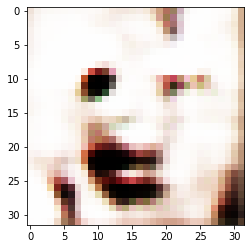

In [14]:
error_d_m1, error_g_m1, prediccion_falsa_m1 = entrenar(gan1, 3000, 500, "resultadosGAN-4/modelo1")

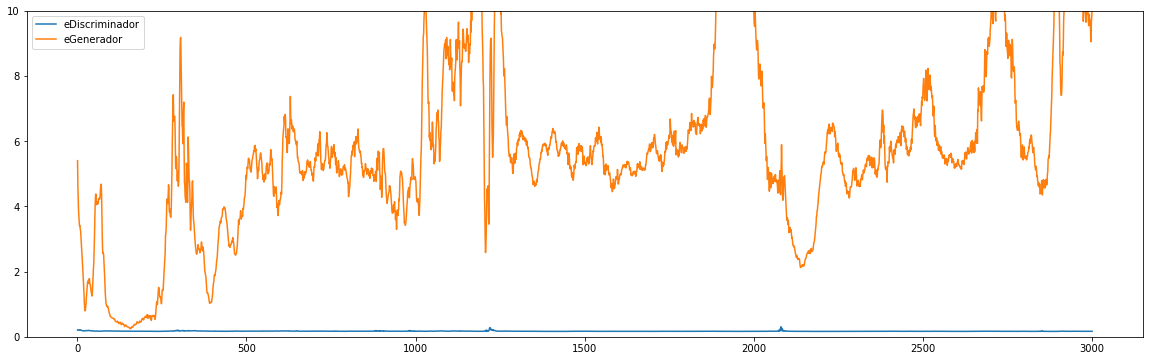

In [61]:
plot_acumulado(len(error_d_m1), 10, eDiscriminador = error_d_m1, eGenerador = error_g_m1)

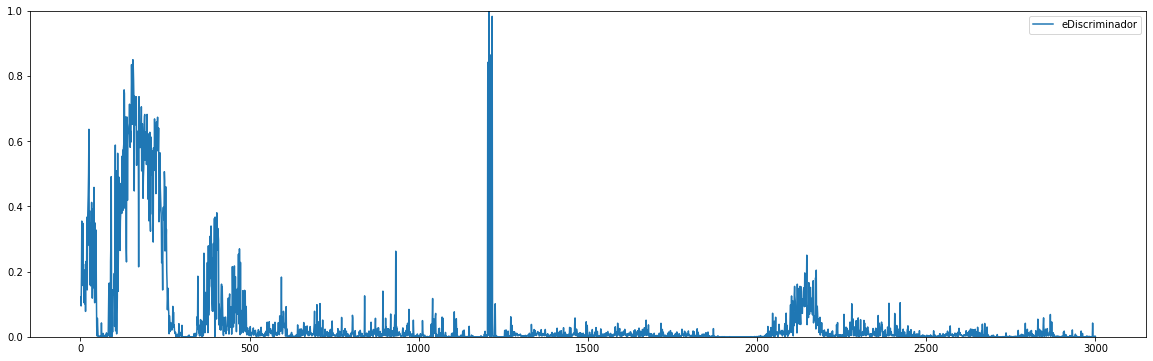

In [62]:
plot_acumulado(len(prediccion_falsa_m1), eDiscriminador = prediccion_falsa_m1)

tf.Tensor([[0.00053948]], shape=(1, 1), dtype=float32)


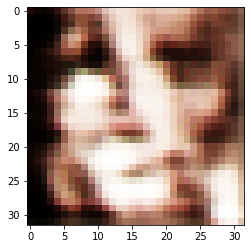

In [80]:
ruido = np.random.normal(0, 1, TAM_ENTRADA)
ruido =np.array([ruido])

predicion(gan1, ruido)


No se aprecia mejora alguna

### Segundo modelo

Cambios en la funcion de costo y optimizador. 

Learning_rate (constante que multimplica a los gradientes) hace que aprenda mas lento pero evitamos que pudiera diverger 

El beta_1 es un factor que se multiplica asi mismo en cada iteracion para que bajar la tasa de aprendizaje a medida que pasa el tiempo

(La cantidad por lote vuelve a 150)

In [11]:
OPTIMIZADOR2 = optimizador.Adam(learning_rate=0.0002, beta_1=0.5) # por defecto se encuentran en learning_rate=0.001 y beta_1=0.9
ERROR2 = 'binary_crossentropy' #para este caso queda igual

generador2 = crear_generador()
discriminador2 = crear_discriminador(OPTIMIZADOR2, ERROR2)
gan2 = crear_GAN(generador2, discriminador2, OPTIMIZADOR2, ERROR2)

Generador Creado
Discriminador Creado
GAN Creado


Comenzando Epoca 1... Fin
Tiempo transcurrido:  2.47 s
Tiempo restante aprox: 123.37m -> 2:3h
prediccion de ruido:  [[0.39528486]]
Comenzando Epoca 2... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 38.78m -> 0:38h
prediccion de ruido:  [[0.62167275]]
Comenzando Epoca 3... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 37.76m -> 0:37h
prediccion de ruido:  [[0.49399915]]
Comenzando Epoca 4... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 38.15m -> 0:38h
prediccion de ruido:  [[0.49814418]]
Comenzando Epoca 5... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 35.94m -> 0:35h
prediccion de ruido:  [[0.48841184]]
Comenzando Epoca 6... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 38.57m -> 0:38h
prediccion de ruido:  [[0.38195083]]
Comenzando Epoca 7... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 36.57m -> 0:36h
prediccion de ruido:  [[0.4171544]]
Comenzando Epoca 8... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 37.62m

Comenzando Epoca 43... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 36.92m -> 0:36h
prediccion de ruido:  [[0.47608158]]
Comenzando Epoca 44... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 35.42m -> 0:35h
prediccion de ruido:  [[0.65704924]]
Comenzando Epoca 45... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 37.43m -> 0:37h
prediccion de ruido:  [[0.3638749]]
Comenzando Epoca 46... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 36.11m -> 0:36h
prediccion de ruido:  [[0.6094795]]
Comenzando Epoca 47... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 36.14m -> 0:36h
prediccion de ruido:  [[0.4396383]]
Comenzando Epoca 48... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 37.01m -> 0:37h
prediccion de ruido:  [[0.35569614]]
Comenzando Epoca 49... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 36.07m -> 0:36h
prediccion de ruido:  [[0.46536618]]
Comenzando Epoca 50... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 

Comenzando Epoca 85... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 37.15m -> 0:37h
prediccion de ruido:  [[0.39229545]]
Comenzando Epoca 86... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 37.14m -> 0:37h
prediccion de ruido:  [[0.37461048]]
Comenzando Epoca 87... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 37.12m -> 0:37h
prediccion de ruido:  [[0.5342917]]
Comenzando Epoca 88... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 37.11m -> 0:37h
prediccion de ruido:  [[0.32102364]]
Comenzando Epoca 89... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 37.1m -> 0:37h
prediccion de ruido:  [[0.4923135]]
Comenzando Epoca 90... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 37.84m -> 0:37h
prediccion de ruido:  [[0.5446547]]
Comenzando Epoca 91... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 37.07m -> 0:37h
prediccion de ruido:  [[0.5169421]]
Comenzando Epoca 92... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 37

Comenzando Epoca 126... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 36.68m -> 0:36h
prediccion de ruido:  [[0.6650181]]
Comenzando Epoca 127... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 36.71m -> 0:36h
prediccion de ruido:  [[0.63410056]]
Comenzando Epoca 128... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 36.6m -> 0:36h
prediccion de ruido:  [[0.59747875]]
Comenzando Epoca 129... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 36.69m -> 0:36h
prediccion de ruido:  [[0.6601232]]
Comenzando Epoca 130... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 38.17m -> 0:38h
prediccion de ruido:  [[0.5567349]]
Comenzando Epoca 131... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 37.31m -> 0:37h
prediccion de ruido:  [[0.64627534]]
Comenzando Epoca 132... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 36.55m -> 0:36h
prediccion de ruido:  [[0.49989572]]
Comenzando Epoca 133... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante a

Comenzando Epoca 167... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 33.97m -> 0:33h
prediccion de ruido:  [[0.81583184]]
Comenzando Epoca 168... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 34.74m -> 0:34h
prediccion de ruido:  [[0.58112633]]
Comenzando Epoca 169... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 34.73m -> 0:34h
prediccion de ruido:  [[0.70303565]]
Comenzando Epoca 170... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 34.7m -> 0:34h
prediccion de ruido:  [[0.6755113]]
Comenzando Epoca 171... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 33.97m -> 0:33h
prediccion de ruido:  [[0.7162938]]
Comenzando Epoca 172... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 34.69m -> 0:34h
prediccion de ruido:  [[0.8568358]]
Comenzando Epoca 173... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 33.95m -> 0:33h
prediccion de ruido:  [[0.44910556]]
Comenzando Epoca 174... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante 

Comenzando Epoca 208... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 34.99m -> 0:34h
prediccion de ruido:  [[0.82761776]]
Comenzando Epoca 209... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 34.12m -> 0:34h
prediccion de ruido:  [[0.7294185]]
Comenzando Epoca 210... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 34.11m -> 0:34h
prediccion de ruido:  [[0.6035709]]
Comenzando Epoca 211... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 33.37m -> 0:33h
prediccion de ruido:  [[0.5826831]]
Comenzando Epoca 212... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 33.36m -> 0:33h
prediccion de ruido:  [[0.6415164]]
Comenzando Epoca 213... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 34.07m -> 0:34h
prediccion de ruido:  [[0.5625527]]
Comenzando Epoca 214... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 34.06m -> 0:34h
prediccion de ruido:  [[0.46694282]]
Comenzando Epoca 215... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante a

Comenzando Epoca 249... Fin
Tiempo transcurrido:  0.81 s
Tiempo restante aprox: 37.21m -> 0:37h
prediccion de ruido:  [[0.6345626]]
Comenzando Epoca 250... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 35.05m -> 0:35h
prediccion de ruido:  [[0.4525369]]
Comenzando Epoca 251... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 34.32m -> 0:34h
prediccion de ruido:  [[0.3788653]]
Comenzando Epoca 252... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 33.59m -> 0:33h
prediccion de ruido:  [[0.353199]]
Comenzando Epoca 253... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 34.3m -> 0:34h
prediccion de ruido:  [[0.5171416]]
Comenzando Epoca 254... Fin
Tiempo transcurrido:  0.89 s
Tiempo restante aprox: 40.8m -> 0:40h
prediccion de ruido:  [[0.549854]]
Comenzando Epoca 255... Fin
Tiempo transcurrido:  0.83 s
Tiempo restante aprox: 37.84m -> 0:37h
prediccion de ruido:  [[0.28827596]]
Comenzando Epoca 256... Fin
Tiempo transcurrido:  1.05 s
Tiempo restante aprox:

Comenzando Epoca 290... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 34.54m -> 0:34h
prediccion de ruido:  [[0.675323]]
Comenzando Epoca 291... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 34.53m -> 0:34h
prediccion de ruido:  [[0.40628964]]
Comenzando Epoca 292... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 33.81m -> 0:33h
prediccion de ruido:  [[0.41506666]]
Comenzando Epoca 293... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 33.8m -> 0:33h
prediccion de ruido:  [[0.19510204]]
Comenzando Epoca 294... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 34.49m -> 0:34h
prediccion de ruido:  [[0.6366675]]
Comenzando Epoca 295... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 33.77m -> 0:33h
prediccion de ruido:  [[0.35382837]]
Comenzando Epoca 296... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 35.17m -> 0:35h
prediccion de ruido:  [[0.6365361]]
Comenzando Epoca 297... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante a

Comenzando Epoca 331... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 33.32m -> 0:33h
prediccion de ruido:  [[0.39010292]]
Comenzando Epoca 332... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 33.31m -> 0:33h
prediccion de ruido:  [[0.20063588]]
Comenzando Epoca 333... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 32.6m -> 0:32h
prediccion de ruido:  [[0.38875195]]
Comenzando Epoca 334... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 32.59m -> 0:32h
prediccion de ruido:  [[0.16781151]]
Comenzando Epoca 335... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 32.58m -> 0:32h
prediccion de ruido:  [[0.14600912]]
Comenzando Epoca 336... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 32.57m -> 0:32h
prediccion de ruido:  [[0.33693045]]
Comenzando Epoca 337... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 33.25m -> 0:33h
prediccion de ruido:  [[0.14342752]]
Comenzando Epoca 338... Fin
Tiempo transcurrido:  0.75 s
Tiempo restan

Comenzando Epoca 372... Fin
Tiempo transcurrido:  0.83 s
Tiempo restante aprox: 36.32m -> 0:36h
prediccion de ruido:  [[0.14888278]]
Comenzando Epoca 373... Fin
Tiempo transcurrido:  0.81 s
Tiempo restante aprox: 35.48m -> 0:35h
prediccion de ruido:  [[0.30881333]]
Comenzando Epoca 374... Fin
Tiempo transcurrido:  0.81 s
Tiempo restante aprox: 35.56m -> 0:35h
prediccion de ruido:  [[0.33643538]]
Comenzando Epoca 375... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 32.77m -> 0:32h
prediccion de ruido:  [[0.15864307]]
Comenzando Epoca 376... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 34.81m -> 0:34h
prediccion de ruido:  [[0.08471021]]
Comenzando Epoca 377... Fin
Tiempo transcurrido:  0.81 s
Tiempo restante aprox: 35.48m -> 0:35h
prediccion de ruido:  [[0.25165164]]
Comenzando Epoca 378... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 33.42m -> 0:33h
prediccion de ruido:  [[0.17770183]]
Comenzando Epoca 379... Fin
Tiempo transcurrido:  0.8 s
Tiempo restant

Comenzando Epoca 413... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 31.63m -> 0:31h
prediccion de ruido:  [[0.29153204]]
Comenzando Epoca 414... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 31.61m -> 0:31h
prediccion de ruido:  [[0.08237311]]
Comenzando Epoca 415... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 32.27m -> 0:32h
prediccion de ruido:  [[0.13640124]]
Comenzando Epoca 416... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 31.59m -> 0:31h
prediccion de ruido:  [[0.06618357]]
Comenzando Epoca 417... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 31.58m -> 0:31h
prediccion de ruido:  [[0.11420253]]
Comenzando Epoca 418... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 31.56m -> 0:31h
prediccion de ruido:  [[0.16239443]]
Comenzando Epoca 419... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 31.55m -> 0:31h
prediccion de ruido:  [[0.16934237]]
Comenzando Epoca 420... Fin
Tiempo transcurrido:  0.73 s
Tiempo resta

Comenzando Epoca 454... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 30.46m -> 0:30h
prediccion de ruido:  [[0.13373554]]
Comenzando Epoca 455... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 30.45m -> 0:30h
prediccion de ruido:  [[0.07376027]]
Comenzando Epoca 456... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 31.1m -> 0:31h
prediccion de ruido:  [[0.12801373]]
Comenzando Epoca 457... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 31.09m -> 0:31h
prediccion de ruido:  [[0.034264]]
Comenzando Epoca 458... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 31.08m -> 0:31h
prediccion de ruido:  [[0.09693202]]
Comenzando Epoca 459... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 31.06m -> 0:31h
prediccion de ruido:  [[0.11329287]]
Comenzando Epoca 460... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 30.39m -> 0:30h
prediccion de ruido:  [[0.01520565]]
Comenzando Epoca 461... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante

Comenzando Epoca 495... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 30.53m -> 0:30h
prediccion de ruido:  [[0.27933034]]
Comenzando Epoca 496... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 30.73m -> 0:30h
prediccion de ruido:  [[0.08754429]]
Comenzando Epoca 497... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 30.97m -> 0:30h
prediccion de ruido:  [[0.21394101]]
Comenzando Epoca 498... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 30.5m -> 0:30h
prediccion de ruido:  [[0.0082067]]
Comenzando Epoca 499... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 30.53m -> 0:30h
prediccion de ruido:  [[0.29984367]]
Comenzando Epoca 500... Fin
Tiempo transcurrido:  0.86 s
Tiempo restante aprox: 35.68m -> 0:35h
prediccion de ruido:  [[0.19036004]]
Comenzando Epoca 501... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 30.42m -> 0:30h
prediccion de ruido:  [[0.06347933]]
Comenzando Epoca 502... Fin
Tiempo transcurrido:  0.75 s
Tiempo restant

Comenzando Epoca 536... Fin
Tiempo transcurrido:  0.85 s
Tiempo restante aprox: 34.92m -> 0:34h
prediccion de ruido:  [[0.20079026]]
Comenzando Epoca 537... Fin
Tiempo transcurrido:  0.88 s
Tiempo restante aprox: 36.06m -> 0:36h
prediccion de ruido:  [[0.28226823]]
Comenzando Epoca 538... Fin
Tiempo transcurrido:  0.98 s
Tiempo restante aprox: 40.4m -> 0:40h
prediccion de ruido:  [[0.01515481]]
Comenzando Epoca 539... Fin
Tiempo transcurrido:  0.87 s
Tiempo restante aprox: 35.78m -> 0:35h
prediccion de ruido:  [[0.05343869]]
Comenzando Epoca 540... Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 37.37m -> 0:37h
prediccion de ruido:  [[0.04034683]]
Comenzando Epoca 541... Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 36.94m -> 0:36h
prediccion de ruido:  [[0.03441831]]
Comenzando Epoca 542... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 31.72m -> 0:31h
prediccion de ruido:  [[0.0538632]]
Comenzando Epoca 543... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante

Comenzando Epoca 577... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 30.52m -> 0:30h
prediccion de ruido:  [[0.01894146]]
Comenzando Epoca 578... Fin
Tiempo transcurrido:  0.71 s
Tiempo restante aprox: 28.58m -> 0:28h
prediccion de ruido:  [[0.02451226]]
Comenzando Epoca 579... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 29.61m -> 0:29h
prediccion de ruido:  [[0.05170715]]
Comenzando Epoca 580... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 30.85m -> 0:30h
prediccion de ruido:  [[0.05513588]]
Comenzando Epoca 581... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 30.03m -> 0:30h
prediccion de ruido:  [[0.01104844]]
Comenzando Epoca 582... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 29.11m -> 0:29h
prediccion de ruido:  [[0.01108465]]
Comenzando Epoca 583... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 28.85m -> 0:28h
prediccion de ruido:  [[0.03738925]]
Comenzando Epoca 584... Fin
Tiempo transcurrido:  0.78 s
Tiempo resta

Comenzando Epoca 618... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 28.84m -> 0:28h
prediccion de ruido:  [[0.09237891]]
Comenzando Epoca 619... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 29.18m -> 0:29h
prediccion de ruido:  [[0.04464793]]
Comenzando Epoca 620... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 28.81m -> 0:28h
prediccion de ruido:  [[0.00987345]]
Comenzando Epoca 621... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 29.0m -> 0:28h
prediccion de ruido:  [[0.03902927]]
Comenzando Epoca 622... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 28.55m -> 0:28h
prediccion de ruido:  [[0.03382117]]
Comenzando Epoca 623... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 29.01m -> 0:29h
prediccion de ruido:  [[0.01658008]]
Comenzando Epoca 624... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 29.04m -> 0:29h
prediccion de ruido:  [[0.02877349]]
Comenzando Epoca 625... Fin
Tiempo transcurrido:  0.73 s
Tiempo restan

Comenzando Epoca 659... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 29.88m -> 0:29h
prediccion de ruido:  [[0.00630519]]
Comenzando Epoca 660... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 30.23m -> 0:30h
prediccion de ruido:  [[0.01699239]]
Comenzando Epoca 661... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 29.36m -> 0:29h
prediccion de ruido:  [[0.02153066]]
Comenzando Epoca 662... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 30.25m -> 0:30h
prediccion de ruido:  [[0.00468031]]
Comenzando Epoca 663... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 28.69m -> 0:28h
prediccion de ruido:  [[0.02136287]]
Comenzando Epoca 664... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 27.99m -> 0:27h
prediccion de ruido:  [[0.00857076]]
Comenzando Epoca 665... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 28.44m -> 0:28h
prediccion de ruido:  [[0.01719242]]
Comenzando Epoca 666... Fin
Tiempo transcurrido:  0.76 s
Tiempo resta

Comenzando Epoca 700... Fin
Tiempo transcurrido:  0.84 s
Tiempo restante aprox: 32.31m -> 0:32h
prediccion de ruido:  [[0.01160333]]
Comenzando Epoca 701... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 28.11m -> 0:28h
prediccion de ruido:  [[0.00175333]]
Comenzando Epoca 702... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 27.5m -> 0:27h
prediccion de ruido:  [[0.00402656]]
Comenzando Epoca 703... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 28.08m -> 0:28h
prediccion de ruido:  [[0.36695963]]
Comenzando Epoca 704... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 28.07m -> 0:28h
prediccion de ruido:  [[0.00025639]]
Comenzando Epoca 705... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 27.46m -> 0:27h
prediccion de ruido:  [[0.03101566]]
Comenzando Epoca 706... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 28.05m -> 0:28h
prediccion de ruido:  [[0.08520678]]
Comenzando Epoca 707... Fin
Tiempo transcurrido:  0.72 s
Tiempo restan

Comenzando Epoca 741... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 29.53m -> 0:29h
prediccion de ruido:  [[0.07734239]]
Comenzando Epoca 742... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 27.98m -> 0:27h
prediccion de ruido:  [[0.10239619]]
Comenzando Epoca 743... Fin
Tiempo transcurrido:  0.83 s
Tiempo restante aprox: 31.28m -> 0:31h
prediccion de ruido:  [[0.0058465]]
Comenzando Epoca 744... Fin
Tiempo transcurrido:  0.83 s
Tiempo restante aprox: 31.3m -> 0:31h
prediccion de ruido:  [[0.02117172]]
Comenzando Epoca 745... Fin
Tiempo transcurrido:  0.89 s
Tiempo restante aprox: 33.39m -> 0:33h
prediccion de ruido:  [[0.01286602]]
Comenzando Epoca 746... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 29.28m -> 0:29h
prediccion de ruido:  [[0.00563323]]
Comenzando Epoca 747... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 29.68m -> 0:29h
prediccion de ruido:  [[0.26261753]]
Comenzando Epoca 748... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante

Comenzando Epoca 782... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 28.41m -> 0:28h
prediccion de ruido:  [[0.05672598]]
Comenzando Epoca 783... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 29.47m -> 0:29h
prediccion de ruido:  [[0.0213373]]
Comenzando Epoca 784... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 28.24m -> 0:28h
prediccion de ruido:  [[0.00141117]]
Comenzando Epoca 785... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 27.19m -> 0:27h
prediccion de ruido:  [[0.00767952]]
Comenzando Epoca 786... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 27.78m -> 0:27h
prediccion de ruido:  [[0.006706]]
Comenzando Epoca 787... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 27.09m -> 0:27h
prediccion de ruido:  [[0.00114143]]
Comenzando Epoca 788... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 27.04m -> 0:27h
prediccion de ruido:  [[0.00520608]]
Comenzando Epoca 789... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante 

Comenzando Epoca 823... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 26.24m -> 0:26h
prediccion de ruido:  [[0.00076708]]
Comenzando Epoca 824... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 26.92m -> 0:26h
prediccion de ruido:  [[0.00303116]]
Comenzando Epoca 825... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 26.22m -> 0:26h
prediccion de ruido:  [[0.12133387]]
Comenzando Epoca 826... Fin
Tiempo transcurrido:  0.71 s
Tiempo restante aprox: 25.84m -> 0:25h
prediccion de ruido:  [[0.00275671]]
Comenzando Epoca 827... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 26.47m -> 0:26h
prediccion de ruido:  [[0.30178517]]
Comenzando Epoca 828... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 27.98m -> 0:27h
prediccion de ruido:  [[0.03593561]]
Comenzando Epoca 829... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 27.01m -> 0:27h
prediccion de ruido:  [[0.05077931]]
Comenzando Epoca 830... Fin
Tiempo transcurrido:  0.79 s
Tiempo resta

Comenzando Epoca 864... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 26.67m -> 0:26h
prediccion de ruido:  [[0.00606659]]
Comenzando Epoca 865... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 25.55m -> 0:25h
prediccion de ruido:  [[0.00388971]]
Comenzando Epoca 866... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 26.16m -> 0:26h
prediccion de ruido:  [[0.00855497]]
Comenzando Epoca 867... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 26.15m -> 0:26h
prediccion de ruido:  [[0.00466001]]
Comenzando Epoca 868... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 25.51m -> 0:25h
prediccion de ruido:  [[0.00952098]]
Comenzando Epoca 869... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 25.5m -> 0:25h
prediccion de ruido:  [[0.05429614]]
Comenzando Epoca 870... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 26.04m -> 0:26h
prediccion de ruido:  [[0.0357464]]
Comenzando Epoca 871... Fin
Tiempo transcurrido:  0.73 s
Tiempo restant

Comenzando Epoca 905... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 25.61m -> 0:25h
prediccion de ruido:  [[0.0087651]]
Comenzando Epoca 906... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 25.6m -> 0:25h
prediccion de ruido:  [[0.01623264]]
Comenzando Epoca 907... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 25.04m -> 0:25h
prediccion de ruido:  [[0.13597983]]
Comenzando Epoca 908... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 25.58m -> 0:25h
prediccion de ruido:  [[0.02005336]]
Comenzando Epoca 909... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 25.56m -> 0:25h
prediccion de ruido:  [[0.08924022]]
Comenzando Epoca 910... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 25.55m -> 0:25h
prediccion de ruido:  [[0.01514366]]
Comenzando Epoca 911... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 25.0m -> 0:24h
prediccion de ruido:  [[0.02502123]]
Comenzando Epoca 912... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante

Comenzando Epoca 946... Fin
Tiempo transcurrido:  0.71 s
Tiempo restante aprox: 24.34m -> 0:24h
prediccion de ruido:  [[0.01895896]]
Comenzando Epoca 947... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 25.19m -> 0:25h
prediccion de ruido:  [[0.02935055]]
Comenzando Epoca 948... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 25.55m -> 0:25h
prediccion de ruido:  [[0.01440269]]
Comenzando Epoca 949... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 25.25m -> 0:25h
prediccion de ruido:  [[0.00153747]]
Comenzando Epoca 950... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 24.71m -> 0:24h
prediccion de ruido:  [[0.16057819]]
Comenzando Epoca 951... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 26.02m -> 0:26h
prediccion de ruido:  [[0.0592829]]
Comenzando Epoca 952... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 26.13m -> 0:26h
prediccion de ruido:  [[0.00588712]]
Comenzando Epoca 953... Fin
Tiempo transcurrido:  0.89 s
Tiempo restan

Comenzando Epoca 987... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 24.09m -> 0:24h
prediccion de ruido:  [[0.15362817]]
Comenzando Epoca 988... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 24.08m -> 0:24h
prediccion de ruido:  [[0.03671208]]
Comenzando Epoca 989... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 24.59m -> 0:24h
prediccion de ruido:  [[0.02105623]]
Comenzando Epoca 990... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 24.57m -> 0:24h
prediccion de ruido:  [[0.16490942]]
Comenzando Epoca 991... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 24.04m -> 0:24h
prediccion de ruido:  [[0.0033156]]
Comenzando Epoca 992... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 24.03m -> 0:24h
prediccion de ruido:  [[0.02838245]]
Comenzando Epoca 993... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 24.54m -> 0:24h
prediccion de ruido:  [[0.11116916]]
Comenzando Epoca 994... Fin
Tiempo transcurrido:  0.73 s
Tiempo restan

Comenzando Epoca 1028... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 24.11m -> 0:24h
prediccion de ruido:  [[0.01753318]]
Comenzando Epoca 1029... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 24.1m -> 0:24h
prediccion de ruido:  [[0.0833351]]
Comenzando Epoca 1030... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 23.57m -> 0:23h
prediccion de ruido:  [[0.14907262]]
Comenzando Epoca 1031... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 24.59m -> 0:24h
prediccion de ruido:  [[0.00436255]]
Comenzando Epoca 1032... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 24.43m -> 0:24h
prediccion de ruido:  [[0.00630233]]
Comenzando Epoca 1033... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 25.16m -> 0:25h
prediccion de ruido:  [[0.00170973]]
Comenzando Epoca 1034... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 24.54m -> 0:24h
prediccion de ruido:  [[0.01226014]]
Comenzando Epoca 1035... Fin
Tiempo transcurrido:  0.81 s
Tiempo

Comenzando Epoca 1069... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 25.73m -> 0:25h
prediccion de ruido:  [[0.0377236]]
Comenzando Epoca 1070... Fin
Tiempo transcurrido:  0.83 s
Tiempo restante aprox: 26.55m -> 0:26h
prediccion de ruido:  [[0.01547301]]
Comenzando Epoca 1071... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 25.29m -> 0:25h
prediccion de ruido:  [[0.00102434]]
Comenzando Epoca 1072... Fin
Tiempo transcurrido:  0.83 s
Tiempo restante aprox: 26.75m -> 0:26h
prediccion de ruido:  [[0.00656313]]
Comenzando Epoca 1073... Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 30.27m -> 0:30h
prediccion de ruido:  [[0.02380231]]
Comenzando Epoca 1074... Fin
Tiempo transcurrido:  0.82 s
Tiempo restante aprox: 26.34m -> 0:26h
prediccion de ruido:  [[0.01720607]]
Comenzando Epoca 1075... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 25.14m -> 0:25h
prediccion de ruido:  [[0.00526205]]
Comenzando Epoca 1076... Fin
Tiempo transcurrido:  0.83 s
Tiempo

Comenzando Epoca 1110... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 24.03m -> 0:24h
prediccion de ruido:  [[0.00328663]]
Comenzando Epoca 1111... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 24.77m -> 0:24h
prediccion de ruido:  [[0.02109873]]
Comenzando Epoca 1112... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 24.63m -> 0:24h
prediccion de ruido:  [[0.00173128]]
Comenzando Epoca 1113... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 22.61m -> 0:22h
prediccion de ruido:  [[0.04518104]]
Comenzando Epoca 1114... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 23.55m -> 0:23h
prediccion de ruido:  [[0.01392961]]
Comenzando Epoca 1115... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 22.59m -> 0:22h
prediccion de ruido:  [[0.00064883]]
Comenzando Epoca 1116... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 23.03m -> 0:23h
prediccion de ruido:  [[0.00462413]]
Comenzando Epoca 1117... Fin
Tiempo transcurrido:  0.73 s
Tiem

Comenzando Epoca 1151... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 23.1m -> 0:23h
prediccion de ruido:  [[0.01813024]]
Comenzando Epoca 1152... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 23.07m -> 0:23h
prediccion de ruido:  [[0.00294119]]
Comenzando Epoca 1153... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 22.6m -> 0:22h
prediccion de ruido:  [[0.00037688]]
Comenzando Epoca 1154... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 22.74m -> 0:22h
prediccion de ruido:  [[0.07441083]]
Comenzando Epoca 1155... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 23.13m -> 0:23h
prediccion de ruido:  [[0.00062078]]
Comenzando Epoca 1156... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 23.78m -> 0:23h
prediccion de ruido:  [[0.01217294]]
Comenzando Epoca 1157... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 23.09m -> 0:23h
prediccion de ruido:  [[0.02104411]]
Comenzando Epoca 1158... Fin
Tiempo transcurrido:  0.73 s
Tiempo

Comenzando Epoca 1192... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 22.58m -> 0:22h
prediccion de ruido:  [[0.00066215]]
Comenzando Epoca 1193... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 23.03m -> 0:23h
prediccion de ruido:  [[0.05916002]]
Comenzando Epoca 1194... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 22.55m -> 0:22h
prediccion de ruido:  [[0.0772804]]
Comenzando Epoca 1195... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 22.07m -> 0:22h
prediccion de ruido:  [[0.00236377]]
Comenzando Epoca 1196... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 22.53m -> 0:22h
prediccion de ruido:  [[0.01160759]]
Comenzando Epoca 1197... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 22.05m -> 0:22h
prediccion de ruido:  [[0.00453505]]
Comenzando Epoca 1198... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 22.03m -> 0:22h
prediccion de ruido:  [[0.00759411]]
Comenzando Epoca 1199... Fin
Tiempo transcurrido:  0.72 s
Tiemp

Comenzando Epoca 1233... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 23.49m -> 0:23h
prediccion de ruido:  [[0.01139659]]
Comenzando Epoca 1234... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 22.05m -> 0:22h
prediccion de ruido:  [[0.04471993]]
Comenzando Epoca 1235... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 21.58m -> 0:21h
prediccion de ruido:  [[0.00698906]]
Comenzando Epoca 1236... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 21.57m -> 0:21h
prediccion de ruido:  [[0.03767216]]
Comenzando Epoca 1237... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 21.56m -> 0:21h
prediccion de ruido:  [[0.00398183]]
Comenzando Epoca 1238... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 21.14m -> 0:21h
prediccion de ruido:  [[0.07070595]]
Comenzando Epoca 1239... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 21.53m -> 0:21h
prediccion de ruido:  [[0.03897926]]
Comenzando Epoca 1240... Fin
Tiempo transcurrido:  0.72 s
Tiemp

Comenzando Epoca 1274... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 20.66m -> 0:20h
prediccion de ruido:  [[0.00029323]]
Comenzando Epoca 1275... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 21.09m -> 0:21h
prediccion de ruido:  [[0.06763089]]
Comenzando Epoca 1276... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 21.08m -> 0:21h
prediccion de ruido:  [[0.0217911]]
Comenzando Epoca 1277... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 21.07m -> 0:21h
prediccion de ruido:  [[0.00390095]]
Comenzando Epoca 1278... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 22.4m -> 0:22h
prediccion de ruido:  [[0.00084803]]
Comenzando Epoca 1279... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 22.39m -> 0:22h
prediccion de ruido:  [[0.00304443]]
Comenzando Epoca 1280... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 22.37m -> 0:22h
prediccion de ruido:  [[0.00071204]]
Comenzando Epoca 1281... Fin
Tiempo transcurrido:  0.73 s
Tiempo

Comenzando Epoca 1315... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 20.6m -> 0:20h
prediccion de ruido:  [[0.02254197]]
Comenzando Epoca 1316... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 20.18m -> 0:20h
prediccion de ruido:  [[0.00668243]]
Comenzando Epoca 1317... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 21.38m -> 0:21h
prediccion de ruido:  [[0.0432556]]
Comenzando Epoca 1318... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 20.65m -> 0:20h
prediccion de ruido:  [[0.00729442]]
Comenzando Epoca 1319... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 20.96m -> 0:20h
prediccion de ruido:  [[0.00052959]]
Comenzando Epoca 1320... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 22.25m -> 0:22h
prediccion de ruido:  [[0.02060962]]
Comenzando Epoca 1321... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 21.95m -> 0:21h
prediccion de ruido:  [[0.02260938]]
Comenzando Epoca 1322... Fin
Tiempo transcurrido:  0.85 s
Tiempo

Comenzando Epoca 1356... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 20.69m -> 0:20h
prediccion de ruido:  [[0.00440076]]
Comenzando Epoca 1357... Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 25.65m -> 0:25h
prediccion de ruido:  [[0.00042078]]
Comenzando Epoca 1358... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 20.56m -> 0:20h
prediccion de ruido:  [[0.0014658]]
Comenzando Epoca 1359... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 20.97m -> 0:20h
prediccion de ruido:  [[0.01494586]]
Comenzando Epoca 1360... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 20.05m -> 0:20h
prediccion de ruido:  [[0.00018257]]
Comenzando Epoca 1361... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 20.04m -> 0:20h
prediccion de ruido:  [[0.00025952]]
Comenzando Epoca 1362... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 19.6m -> 0:19h
prediccion de ruido:  [[0.06112638]]
Comenzando Epoca 1363... Fin
Tiempo transcurrido:  0.73 s
Tiempo

Comenzando Epoca 1397... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 19.18m -> 0:19h
prediccion de ruido:  [[2.051615e-05]]
Comenzando Epoca 1398... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 19.59m -> 0:19h
prediccion de ruido:  [[0.00090572]]
Comenzando Epoca 1399... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 19.58m -> 0:19h
prediccion de ruido:  [[0.0050683]]
Comenzando Epoca 1400... Fin
Tiempo transcurrido:  0.89 s
Tiempo restante aprox: 23.73m -> 0:23h
prediccion de ruido:  [[0.00090456]]
Comenzando Epoca 1401... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 19.55m -> 0:19h
prediccion de ruido:  [[0.00026771]]
Comenzando Epoca 1402... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 20.4m -> 0:20h
prediccion de ruido:  [[0.01537636]]
Comenzando Epoca 1403... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 19.94m -> 0:19h
prediccion de ruido:  [[0.00014126]]
Comenzando Epoca 1404... Fin
Tiempo transcurrido:  0.81 s
Tiem

Comenzando Epoca 1438... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 19.1m -> 0:19h
prediccion de ruido:  [[0.0002954]]
Comenzando Epoca 1439... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 19.41m -> 0:19h
prediccion de ruido:  [[0.00015554]]
Comenzando Epoca 1440... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 19.57m -> 0:19h
prediccion de ruido:  [[0.00969872]]
Comenzando Epoca 1441... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 19.03m -> 0:19h
prediccion de ruido:  [[0.00109467]]
Comenzando Epoca 1442... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 19.52m -> 0:19h
prediccion de ruido:  [[0.00249603]]
Comenzando Epoca 1443... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 19.98m -> 0:19h
prediccion de ruido:  [[0.00242427]]
Comenzando Epoca 1444... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 19.03m -> 0:19h
prediccion de ruido:  [[0.00228477]]
Comenzando Epoca 1445... Fin
Tiempo transcurrido:  0.72 s
Tiempo

Comenzando Epoca 1479... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 18.72m -> 0:18h
prediccion de ruido:  [[0.00011961]]
Comenzando Epoca 1480... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 20.27m -> 0:20h
prediccion de ruido:  [[0.00030935]]
Comenzando Epoca 1481... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 18.26m -> 0:18h
prediccion de ruido:  [[5.098054e-05]]
Comenzando Epoca 1482... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 18.63m -> 0:18h
prediccion de ruido:  [[0.00053218]]
Comenzando Epoca 1483... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 19.05m -> 0:19h
prediccion de ruido:  [[5.9456273e-05]]
Comenzando Epoca 1484... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 18.37m -> 0:18h
prediccion de ruido:  [[2.65571e-06]]
Comenzando Epoca 1485... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 19.67m -> 0:19h
prediccion de ruido:  [[0.00020909]]
Comenzando Epoca 1486... Fin
Tiempo transcurrido:  0.74 s

Comenzando Epoca 1520... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 18.2m -> 0:18h
prediccion de ruido:  [[0.00024766]]
Comenzando Epoca 1521... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 18.51m -> 0:18h
prediccion de ruido:  [[8.592385e-05]]
Comenzando Epoca 1522... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 17.76m -> 0:17h
prediccion de ruido:  [[5.6109325e-06]]
Comenzando Epoca 1523... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 18.11m -> 0:18h
prediccion de ruido:  [[1.4885148e-05]]
Comenzando Epoca 1524... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 18.5m -> 0:18h
prediccion de ruido:  [[0.00934067]]
Comenzando Epoca 1525... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 18.15m -> 0:18h
prediccion de ruido:  [[7.249265e-05]]
Comenzando Epoca 1526... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 18.49m -> 0:18h
prediccion de ruido:  [[0.00064448]]
Comenzando Epoca 1527... Fin
Tiempo transcurrido:  0.7

Comenzando Epoca 1561... Fin
Tiempo transcurrido:  0.89 s
Tiempo restante aprox: 21.34m -> 0:21h
prediccion de ruido:  [[8.799079e-06]]
Comenzando Epoca 1562... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 17.58m -> 0:17h
prediccion de ruido:  [[2.2912665e-05]]
Comenzando Epoca 1563... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 17.57m -> 0:17h
prediccion de ruido:  [[0.00429434]]
Comenzando Epoca 1564... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 17.56m -> 0:17h
prediccion de ruido:  [[0.00038993]]
Comenzando Epoca 1565... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 17.17m -> 0:17h
prediccion de ruido:  [[1.3887788e-05]]
Comenzando Epoca 1566... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 17.54m -> 0:17h
prediccion de ruido:  [[0.00092104]]
Comenzando Epoca 1567... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 17.52m -> 0:17h
prediccion de ruido:  [[0.00129318]]
Comenzando Epoca 1568... Fin
Tiempo transcurrido:  0.7

Comenzando Epoca 1602... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 17.82m -> 0:17h
prediccion de ruido:  [[0.022488]]
Comenzando Epoca 1603... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 16.72m -> 0:16h
prediccion de ruido:  [[0.00113907]]
Comenzando Epoca 1604... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 17.43m -> 0:17h
prediccion de ruido:  [[0.00408649]]
Comenzando Epoca 1605... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 17.06m -> 0:17h
prediccion de ruido:  [[0.00271252]]
Comenzando Epoca 1606... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 17.41m -> 0:17h
prediccion de ruido:  [[0.02734792]]
Comenzando Epoca 1607... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 17.03m -> 0:17h
prediccion de ruido:  [[0.04420522]]
Comenzando Epoca 1608... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 17.02m -> 0:17h
prediccion de ruido:  [[0.00220257]]
Comenzando Epoca 1609... Fin
Tiempo transcurrido:  0.73 s
Tiempo

Comenzando Epoca 1643... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 16.59m -> 0:16h
prediccion de ruido:  [[0.50402004]]
Comenzando Epoca 1644... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 16.23m -> 0:16h
prediccion de ruido:  [[0.6563552]]
Comenzando Epoca 1645... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 16.57m -> 0:16h
prediccion de ruido:  [[0.320075]]
Comenzando Epoca 1646... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 16.56m -> 0:16h
prediccion de ruido:  [[0.4095008]]
Comenzando Epoca 1647... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 16.19m -> 0:16h
prediccion de ruido:  [[0.30320227]]
Comenzando Epoca 1648... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 16.91m -> 0:16h
prediccion de ruido:  [[0.65808594]]
Comenzando Epoca 1649... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 16.57m -> 0:16h
prediccion de ruido:  [[0.32895282]]
Comenzando Epoca 1650... Fin
Tiempo transcurrido:  0.75 s
Tiempo r

Comenzando Epoca 1684... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 16.09m -> 0:16h
prediccion de ruido:  [[0.32407326]]
Comenzando Epoca 1685... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 16.42m -> 0:16h
prediccion de ruido:  [[0.6491259]]
Comenzando Epoca 1686... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 16.41m -> 0:16h
prediccion de ruido:  [[0.5603326]]
Comenzando Epoca 1687... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 16.4m -> 0:16h
prediccion de ruido:  [[0.4639065]]
Comenzando Epoca 1688... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 16.39m -> 0:16h
prediccion de ruido:  [[0.33550614]]
Comenzando Epoca 1689... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 16.37m -> 0:16h
prediccion de ruido:  [[0.41771626]]
Comenzando Epoca 1690... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 16.36m -> 0:16h
prediccion de ruido:  [[0.48459882]]
Comenzando Epoca 1691... Fin
Tiempo transcurrido:  0.75 s
Tiempo r

Comenzando Epoca 1725... Fin
Tiempo transcurrido:  0.83 s
Tiempo restante aprox: 17.63m -> 0:17h
prediccion de ruido:  [[0.3045678]]
Comenzando Epoca 1726... Fin
Tiempo transcurrido:  0.83 s
Tiempo restante aprox: 17.56m -> 0:17h
prediccion de ruido:  [[0.63541466]]
Comenzando Epoca 1727... Fin
Tiempo transcurrido:  0.82 s
Tiempo restante aprox: 17.36m -> 0:17h
prediccion de ruido:  [[0.31446505]]
Comenzando Epoca 1728... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 15.56m -> 0:15h
prediccion de ruido:  [[0.33420753]]
Comenzando Epoca 1729... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 15.54m -> 0:15h
prediccion de ruido:  [[0.5476715]]
Comenzando Epoca 1730... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 15.53m -> 0:15h
prediccion de ruido:  [[0.46609437]]
Comenzando Epoca 1731... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 15.52m -> 0:15h
prediccion de ruido:  [[0.5828657]]
Comenzando Epoca 1732... Fin
Tiempo transcurrido:  0.73 s
Tiempo 

Comenzando Epoca 1766... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 15.09m -> 0:15h
prediccion de ruido:  [[0.42283508]]
Comenzando Epoca 1767... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 14.76m -> 0:14h
prediccion de ruido:  [[0.20682603]]
Comenzando Epoca 1768... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 15.07m -> 0:15h
prediccion de ruido:  [[0.11484343]]
Comenzando Epoca 1769... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 15.06m -> 0:15h
prediccion de ruido:  [[0.33007795]]
Comenzando Epoca 1770... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 15.04m -> 0:15h
prediccion de ruido:  [[0.2706346]]
Comenzando Epoca 1771... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 15.03m -> 0:15h
prediccion de ruido:  [[0.17702147]]
Comenzando Epoca 1772... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 14.72m -> 0:14h
prediccion de ruido:  [[0.2570415]]
Comenzando Epoca 1773... Fin
Tiempo transcurrido:  0.75 s
Tiempo

Comenzando Epoca 1807... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 14.9m -> 0:14h
prediccion de ruido:  [[0.16325876]]
Comenzando Epoca 1808... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 14.58m -> 0:14h
prediccion de ruido:  [[0.0390304]]
Comenzando Epoca 1809... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 14.88m -> 0:14h
prediccion de ruido:  [[0.07920641]]
Comenzando Epoca 1810... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 14.86m -> 0:14h
prediccion de ruido:  [[0.01958475]]
Comenzando Epoca 1811... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 15.78m -> 0:15h
prediccion de ruido:  [[0.03711751]]
Comenzando Epoca 1812... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 14.53m -> 0:14h
prediccion de ruido:  [[0.05516785]]
Comenzando Epoca 1813... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 14.52m -> 0:14h
prediccion de ruido:  [[0.01503882]]
Comenzando Epoca 1814... Fin
Tiempo transcurrido:  0.73 s
Tiempo 

Comenzando Epoca 1848... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 14.39m -> 0:14h
prediccion de ruido:  [[0.03858584]]
Comenzando Epoca 1849... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 14.08m -> 0:14h
prediccion de ruido:  [[0.02665764]]
Comenzando Epoca 1850... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 14.24m -> 0:14h
prediccion de ruido:  [[0.00306082]]
Comenzando Epoca 1851... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 14.35m -> 0:14h
prediccion de ruido:  [[0.00661787]]
Comenzando Epoca 1852... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 14.64m -> 0:14h
prediccion de ruido:  [[0.00316101]]
Comenzando Epoca 1853... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 14.63m -> 0:14h
prediccion de ruido:  [[0.01149249]]
Comenzando Epoca 1854... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 14.31m -> 0:14h
prediccion de ruido:  [[0.03761163]]
Comenzando Epoca 1855... Fin
Tiempo transcurrido:  0.75 s
Tiem

Comenzando Epoca 1889... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 13.88m -> 0:13h
prediccion de ruido:  [[0.01829135]]
Comenzando Epoca 1890... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 13.87m -> 0:13h
prediccion de ruido:  [[0.016451]]
Comenzando Epoca 1891... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 14.14m -> 0:14h
prediccion de ruido:  [[0.00743538]]
Comenzando Epoca 1892... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 13.84m -> 0:13h
prediccion de ruido:  [[0.0238227]]
Comenzando Epoca 1893... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 13.83m -> 0:13h
prediccion de ruido:  [[0.00766325]]
Comenzando Epoca 1894... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 14.1m -> 0:14h
prediccion de ruido:  [[0.01244429]]
Comenzando Epoca 1895... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 13.8m -> 0:13h
prediccion de ruido:  [[0.01461166]]
Comenzando Epoca 1896... Fin
Tiempo transcurrido:  0.72 s
Tiempo re

Comenzando Epoca 1930... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 12.81m -> 0:12h
prediccion de ruido:  [[0.28816622]]
Comenzando Epoca 1931... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 13.11m -> 0:13h
prediccion de ruido:  [[0.05899087]]
Comenzando Epoca 1932... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 13.64m -> 0:13h
prediccion de ruido:  [[0.1533089]]
Comenzando Epoca 1933... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 13.33m -> 0:13h
prediccion de ruido:  [[0.06287155]]
Comenzando Epoca 1934... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 13.32m -> 0:13h
prediccion de ruido:  [[0.06693608]]
Comenzando Epoca 1935... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 13.04m -> 0:13h
prediccion de ruido:  [[0.01750207]]
Comenzando Epoca 1936... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 13.29m -> 0:13h
prediccion de ruido:  [[0.05947521]]
Comenzando Epoca 1937... Fin
Tiempo transcurrido:  0.75 s
Tiemp

Comenzando Epoca 1971... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 12.59m -> 0:12h
prediccion de ruido:  [[0.5154463]]
Comenzando Epoca 1972... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 12.84m -> 0:12h
prediccion de ruido:  [[0.09823602]]
Comenzando Epoca 1973... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 12.56m -> 0:12h
prediccion de ruido:  [[0.1257259]]
Comenzando Epoca 1974... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 12.55m -> 0:12h
prediccion de ruido:  [[0.01882181]]
Comenzando Epoca 1975... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 12.54m -> 0:12h
prediccion de ruido:  [[0.02630129]]
Comenzando Epoca 1976... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 12.26m -> 0:12h
prediccion de ruido:  [[0.11297864]]
Comenzando Epoca 1977... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 12.51m -> 0:12h
prediccion de ruido:  [[0.05721638]]
Comenzando Epoca 1978... Fin
Tiempo transcurrido:  0.73 s
Tiempo

Comenzando Epoca 2012... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 12.09m -> 0:12h
prediccion de ruido:  [[0.05425352]]
Comenzando Epoca 2013... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 12.33m -> 0:12h
prediccion de ruido:  [[0.16404212]]
Comenzando Epoca 2014... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 12.06m -> 0:12h
prediccion de ruido:  [[0.02145445]]
Comenzando Epoca 2015... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 12.05m -> 0:12h
prediccion de ruido:  [[0.00463963]]
Comenzando Epoca 2016... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 12.04m -> 0:12h
prediccion de ruido:  [[0.10548589]]
Comenzando Epoca 2017... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 12.28m -> 0:12h
prediccion de ruido:  [[0.02654698]]
Comenzando Epoca 2018... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 12.28m -> 0:12h
prediccion de ruido:  [[0.08274952]]
Comenzando Epoca 2019... Fin
Tiempo transcurrido:  0.72 s
Tiem

Comenzando Epoca 2053... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 11.58m -> 0:11h
prediccion de ruido:  [[0.2872936]]
Comenzando Epoca 2054... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 11.57m -> 0:11h
prediccion de ruido:  [[0.00914115]]
Comenzando Epoca 2055... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 11.31m -> 0:11h
prediccion de ruido:  [[0.24638677]]
Comenzando Epoca 2056... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 11.55m -> 0:11h
prediccion de ruido:  [[0.04240674]]
Comenzando Epoca 2057... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 11.54m -> 0:11h
prediccion de ruido:  [[0.0079419]]
Comenzando Epoca 2058... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 11.52m -> 0:11h
prediccion de ruido:  [[0.00377217]]
Comenzando Epoca 2059... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 11.27m -> 0:11h
prediccion de ruido:  [[0.00576183]]
Comenzando Epoca 2060... Fin
Tiempo transcurrido:  0.73 s
Tiempo

Comenzando Epoca 2094... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 11.56m -> 0:11h
prediccion de ruido:  [[0.0602946]]
Comenzando Epoca 2095... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 11.31m -> 0:11h
prediccion de ruido:  [[0.00075385]]
Comenzando Epoca 2096... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 11.29m -> 0:11h
prediccion de ruido:  [[0.01309636]]
Comenzando Epoca 2097... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 11.05m -> 0:11h
prediccion de ruido:  [[0.00329542]]
Comenzando Epoca 2098... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 11.03m -> 0:11h
prediccion de ruido:  [[0.00714779]]
Comenzando Epoca 2099... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 11.02m -> 0:11h
prediccion de ruido:  [[0.00203595]]
Comenzando Epoca 2100... Fin
Tiempo transcurrido:  1.01 s
Tiempo restante aprox: 15.23m -> 0:15h
prediccion de ruido:  [[0.02058664]]
Comenzando Epoca 2101... Fin
Tiempo transcurrido:  0.73 s
Tiemp

Comenzando Epoca 2135... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 10.58m -> 0:10h
prediccion de ruido:  [[0.00199312]]
Comenzando Epoca 2136... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 10.57m -> 0:10h
prediccion de ruido:  [[0.00706589]]
Comenzando Epoca 2137... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 10.56m -> 0:10h
prediccion de ruido:  [[0.00080964]]
Comenzando Epoca 2138... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 10.55m -> 0:10h
prediccion de ruido:  [[0.06088889]]
Comenzando Epoca 2139... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 10.76m -> 0:10h
prediccion de ruido:  [[0.0077728]]
Comenzando Epoca 2140... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 10.3m -> 0:10h
prediccion de ruido:  [[0.00210345]]
Comenzando Epoca 2141... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 10.52m -> 0:10h
prediccion de ruido:  [[0.00278068]]
Comenzando Epoca 2142... Fin
Tiempo transcurrido:  0.73 s
Tiempo

Comenzando Epoca 2176... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 9.87m -> 0:9h
prediccion de ruido:  [[0.01731846]]
Comenzando Epoca 2177... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 10.07m -> 0:10h
prediccion de ruido:  [[0.03102544]]
Comenzando Epoca 2178... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 9.84m -> 0:9h
prediccion de ruido:  [[0.00382879]]
Comenzando Epoca 2179... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 10.04m -> 0:10h
prediccion de ruido:  [[0.03000924]]
Comenzando Epoca 2180... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 9.82m -> 0:9h
prediccion de ruido:  [[0.00125915]]
Comenzando Epoca 2181... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 10.02m -> 0:10h
prediccion de ruido:  [[0.05946186]]
Comenzando Epoca 2182... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 9.8m -> 0:9h
prediccion de ruido:  [[0.00891432]]
Comenzando Epoca 2183... Fin
Tiempo transcurrido:  0.76 s
Tiempo restan

Comenzando Epoca 2217... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 9.58m -> 0:9h
prediccion de ruido:  [[0.00303587]]
Comenzando Epoca 2218... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 9.57m -> 0:9h
prediccion de ruido:  [[0.00102419]]
Comenzando Epoca 2219... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 9.35m -> 0:9h
prediccion de ruido:  [[0.0011434]]
Comenzando Epoca 2220... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 9.54m -> 0:9h
prediccion de ruido:  [[0.03093821]]
Comenzando Epoca 2221... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 9.33m -> 0:9h
prediccion de ruido:  [[0.01981267]]
Comenzando Epoca 2222... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 9.32m -> 0:9h
prediccion de ruido:  [[0.00056803]]
Comenzando Epoca 2223... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 9.51m -> 0:9h
prediccion de ruido:  [[0.11684853]]
Comenzando Epoca 2224... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante apr

Comenzando Epoca 2258... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 9.08m -> 0:9h
prediccion de ruido:  [[0.03745446]]
Comenzando Epoca 2259... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 9.07m -> 0:9h
prediccion de ruido:  [[0.00182775]]
Comenzando Epoca 2260... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 9.06m -> 0:9h
prediccion de ruido:  [[0.00060293]]
Comenzando Epoca 2261... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 8.85m -> 0:8h
prediccion de ruido:  [[0.00139004]]
Comenzando Epoca 2262... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 8.84m -> 0:8h
prediccion de ruido:  [[0.01775733]]
Comenzando Epoca 2263... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 9.02m -> 0:9h
prediccion de ruido:  [[0.00679061]]
Comenzando Epoca 2264... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 8.81m -> 0:8h
prediccion de ruido:  [[0.03373569]]
Comenzando Epoca 2265... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante ap

Comenzando Epoca 2299... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 8.58m -> 0:8h
prediccion de ruido:  [[0.00393233]]
Comenzando Epoca 2300... Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 10.96m -> 0:10h
prediccion de ruido:  [[0.0075835]]
Comenzando Epoca 2301... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 8.55m -> 0:8h
prediccion de ruido:  [[0.06829372]]
Comenzando Epoca 2302... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 8.72m -> 0:8h
prediccion de ruido:  [[0.02321813]]
Comenzando Epoca 2303... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 8.53m -> 0:8h
prediccion de ruido:  [[0.00390187]]
Comenzando Epoca 2304... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 8.34m -> 0:8h
prediccion de ruido:  [[0.00140068]]
Comenzando Epoca 2305... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 8.51m -> 0:8h
prediccion de ruido:  [[0.00085053]]
Comenzando Epoca 2306... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante a

Comenzando Epoca 2340... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 8.08m -> 0:8h
prediccion de ruido:  [[0.000341]]
Comenzando Epoca 2341... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 8.07m -> 0:8h
prediccion de ruido:  [[0.00093263]]
Comenzando Epoca 2342... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 8.05m -> 0:8h
prediccion de ruido:  [[0.00063872]]
Comenzando Epoca 2343... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 7.87m -> 0:7h
prediccion de ruido:  [[0.00043881]]
Comenzando Epoca 2344... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 8.03m -> 0:8h
prediccion de ruido:  [[0.05940101]]
Comenzando Epoca 2345... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 8.02m -> 0:8h
prediccion de ruido:  [[0.00314769]]
Comenzando Epoca 2346... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 7.83m -> 0:7h
prediccion de ruido:  [[0.00040615]]
Comenzando Epoca 2347... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante apro

Comenzando Epoca 2381... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 7.58m -> 0:7h
prediccion de ruido:  [[0.04968995]]
Comenzando Epoca 2382... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 7.4m -> 0:7h
prediccion de ruido:  [[0.01720354]]
Comenzando Epoca 2383... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 7.55m -> 0:7h
prediccion de ruido:  [[0.00028932]]
Comenzando Epoca 2384... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 7.38m -> 0:7h
prediccion de ruido:  [[0.1196661]]
Comenzando Epoca 2385... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 7.53m -> 0:7h
prediccion de ruido:  [[0.03294864]]
Comenzando Epoca 2386... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 7.54m -> 0:7h
prediccion de ruido:  [[0.00021285]]
Comenzando Epoca 2387... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 7.34m -> 0:7h
prediccion de ruido:  [[0.09732199]]
Comenzando Epoca 2388... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante apro

Comenzando Epoca 2422... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 7.08m -> 0:7h
prediccion de ruido:  [[3.9855353e-05]]
Comenzando Epoca 2423... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 7.06m -> 0:7h
prediccion de ruido:  [[0.01718467]]
Comenzando Epoca 2424... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 6.9m -> 0:6h
prediccion de ruido:  [[0.00659198]]
Comenzando Epoca 2425... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 7.04m -> 0:7h
prediccion de ruido:  [[4.6821046e-06]]
Comenzando Epoca 2426... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 7.03m -> 0:7h
prediccion de ruido:  [[0.00055087]]
Comenzando Epoca 2427... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 7.16m -> 0:7h
prediccion de ruido:  [[0.0020541]]
Comenzando Epoca 2428... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 7.3m -> 0:7h
prediccion de ruido:  [[0.00129825]]
Comenzando Epoca 2429... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante

Comenzando Epoca 2463... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 6.58m -> 0:6h
prediccion de ruido:  [[0.00034738]]
Comenzando Epoca 2464... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 6.56m -> 0:6h
prediccion de ruido:  [[1.6879641e-06]]
Comenzando Epoca 2465... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 6.41m -> 0:6h
prediccion de ruido:  [[8.562238e-06]]
Comenzando Epoca 2466... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 6.55m -> 0:6h
prediccion de ruido:  [[3.999217e-08]]
Comenzando Epoca 2467... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 6.4m -> 0:6h
prediccion de ruido:  [[0.00010008]]
Comenzando Epoca 2468... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 6.51m -> 0:6h
prediccion de ruido:  [[3.1780503e-06]]
Comenzando Epoca 2469... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 6.52m -> 0:6h
prediccion de ruido:  [[6.039819e-06]]
Comenzando Epoca 2470... Fin
Tiempo transcurrido:  0.73 s
Tiempo 

Comenzando Epoca 2504... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 6.07m -> 0:6h
prediccion de ruido:  [[0.00149655]]
Comenzando Epoca 2505... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 6.06m -> 0:6h
prediccion de ruido:  [[2.2414062e-05]]
Comenzando Epoca 2506... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 6.05m -> 0:6h
prediccion de ruido:  [[0.00022921]]
Comenzando Epoca 2507... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 6.04m -> 0:6h
prediccion de ruido:  [[4.6972014e-05]]
Comenzando Epoca 2508... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 5.9m -> 0:5h
prediccion de ruido:  [[0.00012881]]
Comenzando Epoca 2509... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 6.01m -> 0:6h
prediccion de ruido:  [[0.00011626]]
Comenzando Epoca 2510... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 6.26m -> 0:6h
prediccion de ruido:  [[3.3677832e-05]]
Comenzando Epoca 2511... Fin
Tiempo transcurrido:  0.72 s
Tiempo res

Comenzando Epoca 2545... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 5.69m -> 0:5h
prediccion de ruido:  [[8.173258e-05]]
Comenzando Epoca 2546... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 5.56m -> 0:5h
prediccion de ruido:  [[0.00120085]]
Comenzando Epoca 2547... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 5.55m -> 0:5h
prediccion de ruido:  [[0.00039846]]
Comenzando Epoca 2548... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 5.54m -> 0:5h
prediccion de ruido:  [[0.00079659]]
Comenzando Epoca 2549... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 5.41m -> 0:5h
prediccion de ruido:  [[0.00062785]]
Comenzando Epoca 2550... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 5.53m -> 0:5h
prediccion de ruido:  [[0.00356045]]
Comenzando Epoca 2551... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 5.51m -> 0:5h
prediccion de ruido:  [[0.02398989]]
Comenzando Epoca 2552... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante 

Comenzando Epoca 2586... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 5.07m -> 0:5h
prediccion de ruido:  [[0.00179425]]
Comenzando Epoca 2587... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 4.95m -> 0:4h
prediccion de ruido:  [[0.1019364]]
Comenzando Epoca 2588... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 5.05m -> 0:5h
prediccion de ruido:  [[0.0289849]]
Comenzando Epoca 2589... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 5.03m -> 0:5h
prediccion de ruido:  [[0.10414216]]
Comenzando Epoca 2590... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 4.92m -> 0:4h
prediccion de ruido:  [[0.07643953]]
Comenzando Epoca 2591... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 5.01m -> 0:5h
prediccion de ruido:  [[0.14175564]]
Comenzando Epoca 2592... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 4.89m -> 0:4h
prediccion de ruido:  [[0.05913815]]
Comenzando Epoca 2593... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante apro

Comenzando Epoca 2627... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 4.57m -> 0:4h
prediccion de ruido:  [[0.00622535]]
Comenzando Epoca 2628... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 4.56m -> 0:4h
prediccion de ruido:  [[0.19504958]]
Comenzando Epoca 2629... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 4.45m -> 0:4h
prediccion de ruido:  [[0.07671615]]
Comenzando Epoca 2630... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 4.53m -> 0:4h
prediccion de ruido:  [[0.01625618]]
Comenzando Epoca 2631... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 4.52m -> 0:4h
prediccion de ruido:  [[0.07529202]]
Comenzando Epoca 2632... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 4.59m -> 0:4h
prediccion de ruido:  [[0.01734126]]
Comenzando Epoca 2633... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 4.79m -> 0:4h
prediccion de ruido:  [[0.00881243]]
Comenzando Epoca 2634... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante ap

Comenzando Epoca 2709... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 3.77m -> 0:3h
prediccion de ruido:  [[0.01346555]]
Comenzando Epoca 2710... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 3.54m -> 0:3h
prediccion de ruido:  [[0.00626546]]
Comenzando Epoca 2711... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 3.53m -> 0:3h
prediccion de ruido:  [[0.01052243]]
Comenzando Epoca 2712... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 3.53m -> 0:3h
prediccion de ruido:  [[0.01038256]]
Comenzando Epoca 2713... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 3.52m -> 0:3h
prediccion de ruido:  [[0.01267943]]
Comenzando Epoca 2714... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 3.43m -> 0:3h
prediccion de ruido:  [[0.00347865]]
Comenzando Epoca 2715... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 3.5m -> 0:3h
prediccion de ruido:  [[0.000227]]
Comenzando Epoca 2716... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox

Comenzando Epoca 2791... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 2.59m -> 0:2h
prediccion de ruido:  [[0.09875441]]
Comenzando Epoca 2792... Fin
Tiempo transcurrido:  0.71 s
Tiempo restante aprox: 2.46m -> 0:2h
prediccion de ruido:  [[0.0304912]]
Comenzando Epoca 2793... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 2.66m -> 0:2h
prediccion de ruido:  [[0.12542632]]
Comenzando Epoca 2794... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 2.53m -> 0:2h
prediccion de ruido:  [[0.0224219]]
Comenzando Epoca 2795... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 2.47m -> 0:2h
prediccion de ruido:  [[0.01220337]]
Comenzando Epoca 2796... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 2.47m -> 0:2h
prediccion de ruido:  [[0.02638781]]
Comenzando Epoca 2797... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 2.53m -> 0:2h
prediccion de ruido:  [[0.03192869]]
Comenzando Epoca 2798... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante apro

Comenzando Epoca 2873... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 1.65m -> 0:1h
prediccion de ruido:  [[0.09828386]]
Comenzando Epoca 2874... Fin
Tiempo transcurrido:  0.82 s
Tiempo restante aprox: 1.74m -> 0:1h
prediccion de ruido:  [[0.0386886]]
Comenzando Epoca 2875... Fin
Tiempo transcurrido:  0.88 s
Tiempo restante aprox: 1.85m -> 0:1h
prediccion de ruido:  [[0.10011747]]
Comenzando Epoca 2876... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 1.6m -> 0:1h
prediccion de ruido:  [[0.03376108]]
Comenzando Epoca 2877... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 1.58m -> 0:1h
prediccion de ruido:  [[0.07111305]]
Comenzando Epoca 2878... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 1.53m -> 0:1h
prediccion de ruido:  [[0.19900832]]
Comenzando Epoca 2879... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 1.54m -> 0:1h
prediccion de ruido:  [[0.2594755]]
Comenzando Epoca 2880... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox

Comenzando Epoca 2955... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 0.59m -> 0:0h
prediccion de ruido:  [[0.198627]]
Comenzando Epoca 2956... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 0.56m -> 0:0h
prediccion de ruido:  [[0.05104104]]
Comenzando Epoca 2957... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 0.54m -> 0:0h
prediccion de ruido:  [[0.03757951]]
Comenzando Epoca 2958... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 0.52m -> 0:0h
prediccion de ruido:  [[0.17521596]]
Comenzando Epoca 2959... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 0.53m -> 0:0h
prediccion de ruido:  [[0.05154595]]
Comenzando Epoca 2960... Fin
Tiempo transcurrido:  0.71 s
Tiempo restante aprox: 0.48m -> 0:0h
prediccion de ruido:  [[0.1696732]]
Comenzando Epoca 2961... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 0.51m -> 0:0h
prediccion de ruido:  [[0.11715996]]
Comenzando Epoca 2962... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox

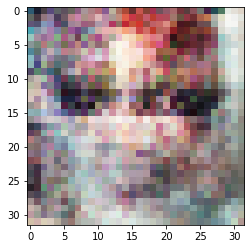

In [12]:
error_d_m2, error_g_m2, prediccion_falsa_m2 = entrenar(gan2, 3000, 150, "resultadosGAN-4/modelo2")

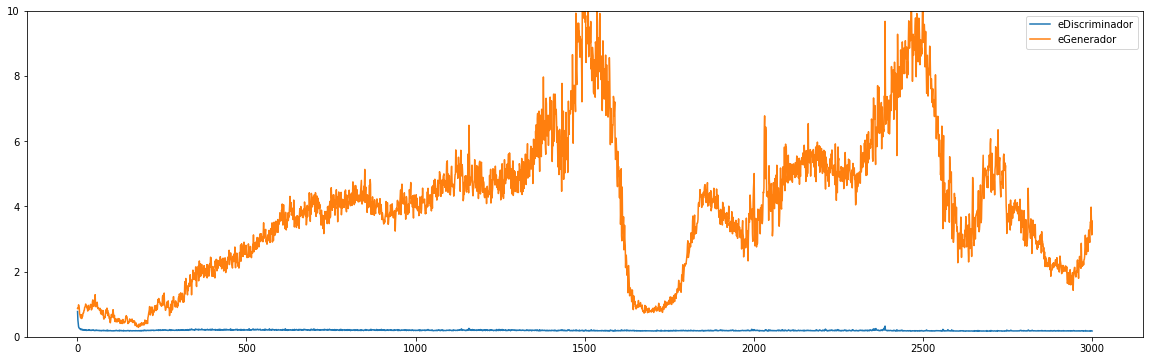

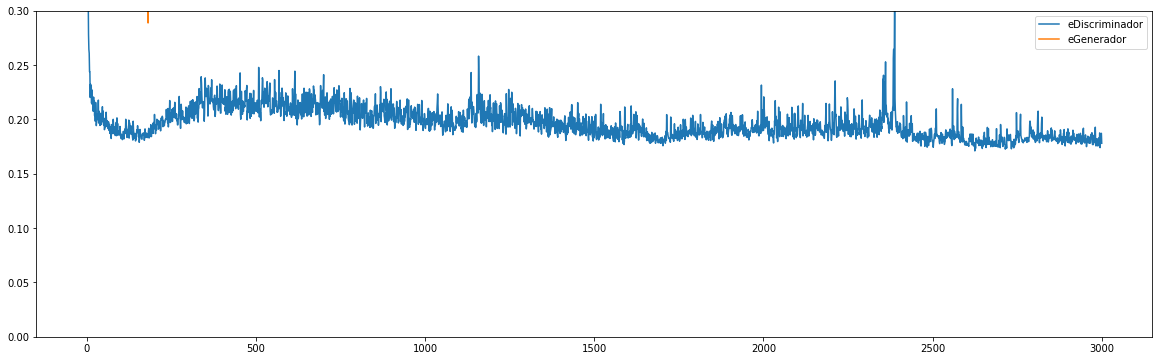

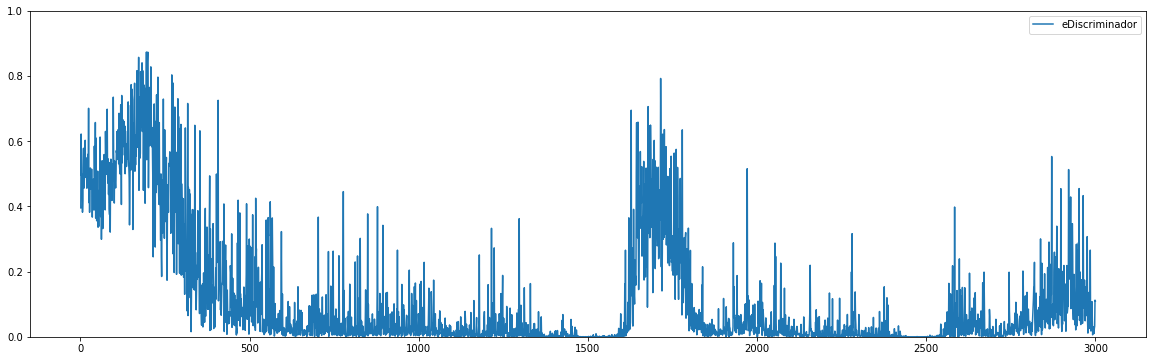

In [15]:
plot_acumulado(len(error_d_m2), 10, eDiscriminador = error_d_m2, eGenerador = error_g_m2)
plot_acumulado(len(error_d_m2), 0.3, eDiscriminador = error_d_m2, eGenerador = error_g_m2)
plot_acumulado(len(prediccion_falsa_m2), 1, eDiscriminador = prediccion_falsa_m2)

tf.Tensor([[0.03039923]], shape=(1, 1), dtype=float32)


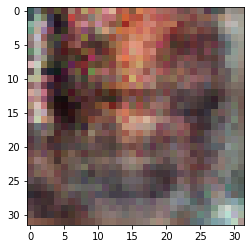

In [46]:
ruido = np.random.normal(0, 1, TAM_ENTRADA)
ruido =np.array([ruido])

predicion(gan2, ruido)

se va a entrenar un poco mas

Comenzando Epoca 1... Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 45.25m -> 0:45h
prediccion de ruido:  [[0.00322601]]
Comenzando Epoca 2... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 37.23m -> 0:37h
prediccion de ruido:  [[0.01791918]]
Comenzando Epoca 3... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 38.42m -> 0:38h
prediccion de ruido:  [[0.01051176]]
Comenzando Epoca 4... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 36.8m -> 0:36h
prediccion de ruido:  [[0.00434637]]
Comenzando Epoca 5... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 35.74m -> 0:35h
prediccion de ruido:  [[0.05262977]]
Comenzando Epoca 6... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 38.51m -> 0:38h
prediccion de ruido:  [[0.00278795]]
Comenzando Epoca 7... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 37.55m -> 0:37h
prediccion de ruido:  [[0.02409598]]
Comenzando Epoca 8... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 37.58m

Comenzando Epoca 83... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 34.96m -> 0:34h
prediccion de ruido:  [[0.09821597]]
Comenzando Epoca 84... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 35.77m -> 0:35h
prediccion de ruido:  [[0.02746579]]
Comenzando Epoca 85... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 35.79m -> 0:35h
prediccion de ruido:  [[9.923636e-05]]
Comenzando Epoca 86... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 35.68m -> 0:35h
prediccion de ruido:  [[0.00275314]]
Comenzando Epoca 87... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 34.98m -> 0:34h
prediccion de ruido:  [[0.08520615]]
Comenzando Epoca 88... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 35.74m -> 0:35h
prediccion de ruido:  [[0.01636219]]
Comenzando Epoca 89... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 35.71m -> 0:35h
prediccion de ruido:  [[0.02074164]]
Comenzando Epoca 90... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante ap

Comenzando Epoca 124... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 35.97m -> 0:35h
prediccion de ruido:  [[0.00128341]]
Comenzando Epoca 125... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 34.49m -> 0:34h
prediccion de ruido:  [[0.04053918]]
Comenzando Epoca 126... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 36.07m -> 0:36h
prediccion de ruido:  [[0.00678319]]
Comenzando Epoca 127... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 34.45m -> 0:34h
prediccion de ruido:  [[0.01584744]]
Comenzando Epoca 128... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 35.2m -> 0:35h
prediccion de ruido:  [[0.00152221]]
Comenzando Epoca 129... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 35.24m -> 0:35h
prediccion de ruido:  [[0.00410092]]
Comenzando Epoca 130... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 35.21m -> 0:35h
prediccion de ruido:  [[0.00534189]]
Comenzando Epoca 131... Fin
Tiempo transcurrido:  0.74 s
Tiempo restan

Comenzando Epoca 165... Fin
Tiempo transcurrido:  0.86 s
Tiempo restante aprox: 40.73m -> 0:40h
prediccion de ruido:  [[0.00136036]]
Comenzando Epoca 166... Fin
Tiempo transcurrido:  0.82 s
Tiempo restante aprox: 38.84m -> 0:38h
prediccion de ruido:  [[0.00045517]]
Comenzando Epoca 167... Fin
Tiempo transcurrido:  0.81 s
Tiempo restante aprox: 38.03m -> 0:38h
prediccion de ruido:  [[0.00339317]]
Comenzando Epoca 168... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 37.16m -> 0:37h
prediccion de ruido:  [[0.00017396]]
Comenzando Epoca 169... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 36.77m -> 0:36h
prediccion de ruido:  [[0.00019073]]
Comenzando Epoca 170... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 35.74m -> 0:35h
prediccion de ruido:  [[0.00195509]]
Comenzando Epoca 171... Fin
Tiempo transcurrido:  0.82 s
Tiempo restante aprox: 38.68m -> 0:38h
prediccion de ruido:  [[0.01467609]]
Comenzando Epoca 172... Fin
Tiempo transcurrido:  0.8 s
Tiempo restan

Comenzando Epoca 206... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 34.16m -> 0:34h
prediccion de ruido:  [[0.00183541]]
Comenzando Epoca 207... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 34.87m -> 0:34h
prediccion de ruido:  [[9.359201e-05]]
Comenzando Epoca 208... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 34.13m -> 0:34h
prediccion de ruido:  [[7.335035e-06]]
Comenzando Epoca 209... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 34.12m -> 0:34h
prediccion de ruido:  [[0.00044879]]
Comenzando Epoca 210... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 33.38m -> 0:33h
prediccion de ruido:  [[0.00021288]]
Comenzando Epoca 211... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 34.82m -> 0:34h
prediccion de ruido:  [[0.00137347]]
Comenzando Epoca 212... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 34.08m -> 0:34h
prediccion de ruido:  [[1.7510603e-06]]
Comenzando Epoca 213... Fin
Tiempo transcurrido:  0.73 s
Tiemp

Comenzando Epoca 247... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 34.37m -> 0:34h
prediccion de ruido:  [[9.552486e-06]]
Comenzando Epoca 248... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 33.64m -> 0:33h
prediccion de ruido:  [[0.00115693]]
Comenzando Epoca 249... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 33.63m -> 0:33h
prediccion de ruido:  [[5.167252e-05]]
Comenzando Epoca 250... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 34.33m -> 0:34h
prediccion de ruido:  [[0.0090293]]
Comenzando Epoca 251... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 35.75m -> 0:35h
prediccion de ruido:  [[0.00016427]]
Comenzando Epoca 252... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 35.74m -> 0:35h
prediccion de ruido:  [[0.00034633]]
Comenzando Epoca 253... Fin
Tiempo transcurrido:  0.81 s
Tiempo restante aprox: 37.15m -> 0:37h
prediccion de ruido:  [[0.00059399]]
Comenzando Epoca 254... Fin
Tiempo transcurrido:  0.75 s
Tiempo re

Comenzando Epoca 288... Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 41.62m -> 0:41h
prediccion de ruido:  [[0.01954159]]
Comenzando Epoca 289... Fin
Tiempo transcurrido:  0.81 s
Tiempo restante aprox: 36.67m -> 0:36h
prediccion de ruido:  [[0.00402221]]
Comenzando Epoca 290... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 35.95m -> 0:35h
prediccion de ruido:  [[0.00227872]]
Comenzando Epoca 291... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 34.53m -> 0:34h
prediccion de ruido:  [[0.00454515]]
Comenzando Epoca 292... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 34.51m -> 0:34h
prediccion de ruido:  [[0.00304374]]
Comenzando Epoca 293... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 33.09m -> 0:33h
prediccion de ruido:  [[1.9998586e-05]]
Comenzando Epoca 294... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 33.08m -> 0:33h
prediccion de ruido:  [[0.00340244]]
Comenzando Epoca 295... Fin
Tiempo transcurrido:  0.73 s
Tiempo res

Comenzando Epoca 329... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 32.65m -> 0:32h
prediccion de ruido:  [[0.00137424]]
Comenzando Epoca 330... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 33.33m -> 0:33h
prediccion de ruido:  [[0.00329039]]
Comenzando Epoca 331... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 32.02m -> 0:32h
prediccion de ruido:  [[0.00206542]]
Comenzando Epoca 332... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 32.7m -> 0:32h
prediccion de ruido:  [[0.0122987]]
Comenzando Epoca 333... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 31.95m -> 0:31h
prediccion de ruido:  [[0.00143838]]
Comenzando Epoca 334... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 32.59m -> 0:32h
prediccion de ruido:  [[0.03469172]]
Comenzando Epoca 335... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 32.62m -> 0:32h
prediccion de ruido:  [[0.00697979]]
Comenzando Epoca 336... Fin
Tiempo transcurrido:  0.73 s
Tiempo restant

Comenzando Epoca 370... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 32.15m -> 0:32h
prediccion de ruido:  [[0.0153721]]
Comenzando Epoca 371... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 32.14m -> 0:32h
prediccion de ruido:  [[0.00645354]]
Comenzando Epoca 372... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 31.44m -> 0:31h
prediccion de ruido:  [[0.03761733]]
Comenzando Epoca 373... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 32.11m -> 0:32h
prediccion de ruido:  [[0.00242853]]
Comenzando Epoca 374... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 32.1m -> 0:32h
prediccion de ruido:  [[0.00076073]]
Comenzando Epoca 375... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 32.77m -> 0:32h
prediccion de ruido:  [[0.00062022]]
Comenzando Epoca 376... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 32.08m -> 0:32h
prediccion de ruido:  [[0.00253341]]
Comenzando Epoca 377... Fin
Tiempo transcurrido:  0.73 s
Tiempo restant

Comenzando Epoca 411... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 32.32m -> 0:32h
prediccion de ruido:  [[0.00379273]]
Comenzando Epoca 412... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 31.64m -> 0:31h
prediccion de ruido:  [[0.00455108]]
Comenzando Epoca 413... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 30.95m -> 0:30h
prediccion de ruido:  [[0.00070024]]
Comenzando Epoca 414... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 31.61m -> 0:31h
prediccion de ruido:  [[0.01875883]]
Comenzando Epoca 415... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 31.6m -> 0:31h
prediccion de ruido:  [[0.00093436]]
Comenzando Epoca 416... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 31.59m -> 0:31h
prediccion de ruido:  [[0.00235513]]
Comenzando Epoca 417... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 31.58m -> 0:31h
prediccion de ruido:  [[0.00563258]]
Comenzando Epoca 418... Fin
Tiempo transcurrido:  0.73 s
Tiempo restan

Comenzando Epoca 452... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 31.81m -> 0:31h
prediccion de ruido:  [[0.01706406]]
Comenzando Epoca 453... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 31.14m -> 0:31h
prediccion de ruido:  [[0.00265005]]
Comenzando Epoca 454... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 31.12m -> 0:31h
prediccion de ruido:  [[0.01947841]]
Comenzando Epoca 455... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 31.11m -> 0:31h
prediccion de ruido:  [[0.0100075]]
Comenzando Epoca 456... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 31.1m -> 0:31h
prediccion de ruido:  [[0.01313055]]
Comenzando Epoca 457... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 31.09m -> 0:31h
prediccion de ruido:  [[0.0024032]]
Comenzando Epoca 458... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 31.74m -> 0:31h
prediccion de ruido:  [[0.02750692]]
Comenzando Epoca 459... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante

Comenzando Epoca 493... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 32.6m -> 0:32h
prediccion de ruido:  [[0.00013465]]
Comenzando Epoca 494... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 30.64m -> 0:30h
prediccion de ruido:  [[0.00107923]]
Comenzando Epoca 495... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 30.62m -> 0:30h
prediccion de ruido:  [[0.00019327]]
Comenzando Epoca 496... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 30.61m -> 0:30h
prediccion de ruido:  [[0.00015637]]
Comenzando Epoca 497... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 30.6m -> 0:30h
prediccion de ruido:  [[0.00339481]]
Comenzando Epoca 498... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 29.94m -> 0:29h
prediccion de ruido:  [[0.07099003]]
Comenzando Epoca 499... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 30.57m -> 0:30h
prediccion de ruido:  [[0.02384529]]
Comenzando Epoca 500... Fin
Tiempo transcurrido:  0.84 s
Tiempo restant

Comenzando Epoca 534... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 30.15m -> 0:30h
prediccion de ruido:  [[0.01202676]]
Comenzando Epoca 535... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 30.13m -> 0:30h
prediccion de ruido:  [[0.00396252]]
Comenzando Epoca 536... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 29.48m -> 0:29h
prediccion de ruido:  [[0.00120381]]
Comenzando Epoca 537... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 30.11m -> 0:30h
prediccion de ruido:  [[0.01072937]]
Comenzando Epoca 538... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 29.46m -> 0:29h
prediccion de ruido:  [[0.00266352]]
Comenzando Epoca 539... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 30.09m -> 0:30h
prediccion de ruido:  [[0.01409531]]
Comenzando Epoca 540... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 30.07m -> 0:30h
prediccion de ruido:  [[2.7816915e-05]]
Comenzando Epoca 541... Fin
Tiempo transcurrido:  0.72 s
Tiempo re

Comenzando Epoca 575... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 29.02m -> 0:29h
prediccion de ruido:  [[0.00027284]]
Comenzando Epoca 576... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 29.63m -> 0:29h
prediccion de ruido:  [[0.00088623]]
Comenzando Epoca 577... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 29.62m -> 0:29h
prediccion de ruido:  [[8.320848e-07]]
Comenzando Epoca 578... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 29.61m -> 0:29h
prediccion de ruido:  [[0.00050065]]
Comenzando Epoca 579... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 28.97m -> 0:28h
prediccion de ruido:  [[8.00022e-05]]
Comenzando Epoca 580... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 29.58m -> 0:29h
prediccion de ruido:  [[0.00069806]]
Comenzando Epoca 581... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 28.94m -> 0:28h
prediccion de ruido:  [[4.0321425e-05]]
Comenzando Epoca 582... Fin
Tiempo transcurrido:  0.75 s
Tiempo

Comenzando Epoca 616... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 30.27m -> 0:30h
prediccion de ruido:  [[0.00017831]]
Comenzando Epoca 617... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 31.11m -> 0:31h
prediccion de ruido:  [[5.295453e-05]]
Comenzando Epoca 618... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 29.91m -> 0:29h
prediccion de ruido:  [[1.903794e-05]]
Comenzando Epoca 619... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 28.69m -> 0:28h
prediccion de ruido:  [[2.7781283e-05]]
Comenzando Epoca 620... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 30.37m -> 0:30h
prediccion de ruido:  [[5.4363034e-05]]
Comenzando Epoca 621... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 29.4m -> 0:29h
prediccion de ruido:  [[0.00012264]]
Comenzando Epoca 622... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 29.95m -> 0:29h
prediccion de ruido:  [[3.331971e-05]]
Comenzando Epoca 623... Fin
Tiempo transcurrido:  0.76 s
T

Comenzando Epoca 657... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 28.64m -> 0:28h
prediccion de ruido:  [[0.00538498]]
Comenzando Epoca 658... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 28.06m -> 0:28h
prediccion de ruido:  [[0.00101957]]
Comenzando Epoca 659... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 28.62m -> 0:28h
prediccion de ruido:  [[0.00076497]]
Comenzando Epoca 660... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 28.61m -> 0:28h
prediccion de ruido:  [[6.73336e-05]]
Comenzando Epoca 661... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 27.99m -> 0:27h
prediccion de ruido:  [[3.5946203e-05]]
Comenzando Epoca 662... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 27.97m -> 0:27h
prediccion de ruido:  [[1.5500484e-05]]
Comenzando Epoca 663... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 28.57m -> 0:28h
prediccion de ruido:  [[5.6090573e-07]]
Comenzando Epoca 664... Fin
Tiempo transcurrido:  0.73 s
Ti

Comenzando Epoca 698... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 27.54m -> 0:27h
prediccion de ruido:  [[0.01038119]]
Comenzando Epoca 699... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 28.13m -> 0:28h
prediccion de ruido:  [[0.00624403]]
Comenzando Epoca 700... Fin
Tiempo transcurrido:  0.86 s
Tiempo restante aprox: 32.9m -> 0:32h
prediccion de ruido:  [[8.567388e-05]]
Comenzando Epoca 701... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 28.11m -> 0:28h
prediccion de ruido:  [[0.0002051]]
Comenzando Epoca 702... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 29.29m -> 0:29h
prediccion de ruido:  [[1.9486066e-05]]
Comenzando Epoca 703... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 27.48m -> 0:27h
prediccion de ruido:  [[0.00146881]]
Comenzando Epoca 704... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 28.07m -> 0:28h
prediccion de ruido:  [[2.230663e-05]]
Comenzando Epoca 705... Fin
Tiempo transcurrido:  0.73 s
Tiempo 

Comenzando Epoca 739... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 27.05m -> 0:27h
prediccion de ruido:  [[0.0005267]]
Comenzando Epoca 740... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 27.04m -> 0:27h
prediccion de ruido:  [[9.6879325e-05]]
Comenzando Epoca 741... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 27.62m -> 0:27h
prediccion de ruido:  [[0.00996384]]
Comenzando Epoca 742... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 27.61m -> 0:27h
prediccion de ruido:  [[0.0006513]]
Comenzando Epoca 743... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 27.01m -> 0:27h
prediccion de ruido:  [[0.0034928]]
Comenzando Epoca 744... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 28.17m -> 0:28h
prediccion de ruido:  [[0.01913285]]
Comenzando Epoca 745... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 26.98m -> 0:26h
prediccion de ruido:  [[0.00040391]]
Comenzando Epoca 746... Fin
Tiempo transcurrido:  0.73 s
Tiempo resta

Comenzando Epoca 780... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 26.56m -> 0:26h
prediccion de ruido:  [[0.00078791]]
Comenzando Epoca 781... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 27.13m -> 0:27h
prediccion de ruido:  [[0.00680345]]
Comenzando Epoca 782... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 27.12m -> 0:27h
prediccion de ruido:  [[0.00811008]]
Comenzando Epoca 783... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 27.1m -> 0:27h
prediccion de ruido:  [[0.00072718]]
Comenzando Epoca 784... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 26.52m -> 0:26h
prediccion de ruido:  [[0.00253737]]
Comenzando Epoca 785... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 27.08m -> 0:27h
prediccion de ruido:  [[0.01320291]]
Comenzando Epoca 786... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 26.49m -> 0:26h
prediccion de ruido:  [[0.00046292]]
Comenzando Epoca 787... Fin
Tiempo transcurrido:  0.73 s
Tiempo restan

Comenzando Epoca 821... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 26.07m -> 0:26h
prediccion de ruido:  [[0.00028238]]
Comenzando Epoca 822... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 26.63m -> 0:26h
prediccion de ruido:  [[0.00329748]]
Comenzando Epoca 823... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 26.65m -> 0:26h
prediccion de ruido:  [[0.01308122]]
Comenzando Epoca 824... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 26.6m -> 0:26h
prediccion de ruido:  [[0.00462249]]
Comenzando Epoca 825... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 26.1m -> 0:26h
prediccion de ruido:  [[0.11794388]]
Comenzando Epoca 826... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 26.58m -> 0:26h
prediccion de ruido:  [[0.00020495]]
Comenzando Epoca 827... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 26.03m -> 0:26h
prediccion de ruido:  [[0.01593572]]
Comenzando Epoca 828... Fin
Tiempo transcurrido:  0.73 s
Tiempo restant

Comenzando Epoca 862... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 26.14m -> 0:26h
prediccion de ruido:  [[0.06167051]]
Comenzando Epoca 863... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 26.13m -> 0:26h
prediccion de ruido:  [[0.00807416]]
Comenzando Epoca 864... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 25.59m -> 0:25h
prediccion de ruido:  [[0.00021893]]
Comenzando Epoca 865... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 25.69m -> 0:25h
prediccion de ruido:  [[0.0017615]]
Comenzando Epoca 866... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 26.09m -> 0:26h
prediccion de ruido:  [[0.00152284]]
Comenzando Epoca 867... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 25.52m -> 0:25h
prediccion de ruido:  [[0.00596625]]
Comenzando Epoca 868... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 26.07m -> 0:26h
prediccion de ruido:  [[0.01512656]]
Comenzando Epoca 869... Fin
Tiempo transcurrido:  0.73 s
Tiempo restan

Comenzando Epoca 903... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 25.64m -> 0:25h
prediccion de ruido:  [[0.19779193]]
Comenzando Epoca 904... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 25.63m -> 0:25h
prediccion de ruido:  [[0.31125426]]
Comenzando Epoca 905... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 25.61m -> 0:25h
prediccion de ruido:  [[0.2570053]]
Comenzando Epoca 906... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 25.6m -> 0:25h
prediccion de ruido:  [[0.17260864]]
Comenzando Epoca 907... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 25.04m -> 0:25h
prediccion de ruido:  [[0.06230569]]
Comenzando Epoca 908... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 25.03m -> 0:25h
prediccion de ruido:  [[0.2795189]]
Comenzando Epoca 909... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 25.56m -> 0:25h
prediccion de ruido:  [[0.05402493]]
Comenzando Epoca 910... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante

Comenzando Epoca 944... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 25.67m -> 0:25h
prediccion de ruido:  [[0.2615307]]
Comenzando Epoca 945... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 24.59m -> 0:24h
prediccion de ruido:  [[0.23945108]]
Comenzando Epoca 946... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 25.11m -> 0:25h
prediccion de ruido:  [[0.3440276]]
Comenzando Epoca 947... Fin
Tiempo transcurrido:  0.71 s
Tiempo restante aprox: 24.44m -> 0:24h
prediccion de ruido:  [[0.7562147]]
Comenzando Epoca 948... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 25.09m -> 0:25h
prediccion de ruido:  [[0.22369099]]
Comenzando Epoca 949... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 25.08m -> 0:25h
prediccion de ruido:  [[0.01741782]]
Comenzando Epoca 950... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 24.53m -> 0:24h
prediccion de ruido:  [[0.37987757]]
Comenzando Epoca 951... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante

Comenzando Epoca 985... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 24.11m -> 0:24h
prediccion de ruido:  [[0.16717872]]
Comenzando Epoca 986... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 24.62m -> 0:24h
prediccion de ruido:  [[0.18480974]]
Comenzando Epoca 987... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 24.61m -> 0:24h
prediccion de ruido:  [[0.06312644]]
Comenzando Epoca 988... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 24.6m -> 0:24h
prediccion de ruido:  [[0.4940485]]
Comenzando Epoca 989... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 24.06m -> 0:24h
prediccion de ruido:  [[0.2628505]]
Comenzando Epoca 990... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 24.57m -> 0:24h
prediccion de ruido:  [[0.0033426]]
Comenzando Epoca 991... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 24.56m -> 0:24h
prediccion de ruido:  [[0.11711299]]
Comenzando Epoca 992... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante 

Comenzando Epoca 1026... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 24.13m -> 0:24h
prediccion de ruido:  [[0.1067017]]
Comenzando Epoca 1027... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 23.61m -> 0:23h
prediccion de ruido:  [[0.22820625]]
Comenzando Epoca 1028... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 23.6m -> 0:23h
prediccion de ruido:  [[0.08728006]]
Comenzando Epoca 1029... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 24.1m -> 0:24h
prediccion de ruido:  [[0.13970032]]
Comenzando Epoca 1030... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 24.09m -> 0:24h
prediccion de ruido:  [[0.13593495]]
Comenzando Epoca 1031... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 23.56m -> 0:23h
prediccion de ruido:  [[0.10773295]]
Comenzando Epoca 1032... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 23.55m -> 0:23h
prediccion de ruido:  [[0.05366519]]
Comenzando Epoca 1033... Fin
Tiempo transcurrido:  0.73 s
Tiempo 

Comenzando Epoca 1067... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 23.63m -> 0:23h
prediccion de ruido:  [[0.06953481]]
Comenzando Epoca 1068... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 23.62m -> 0:23h
prediccion de ruido:  [[0.02519664]]
Comenzando Epoca 1069... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 23.11m -> 0:23h
prediccion de ruido:  [[0.03920233]]
Comenzando Epoca 1070... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 23.09m -> 0:23h
prediccion de ruido:  [[0.06125173]]
Comenzando Epoca 1071... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 23.58m -> 0:23h
prediccion de ruido:  [[0.03239229]]
Comenzando Epoca 1072... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 23.57m -> 0:23h
prediccion de ruido:  [[0.00825202]]
Comenzando Epoca 1073... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 23.56m -> 0:23h
prediccion de ruido:  [[0.0236581]]
Comenzando Epoca 1074... Fin
Tiempo transcurrido:  0.72 s
Tiemp

Comenzando Epoca 1108... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 22.64m -> 0:22h
prediccion de ruido:  [[0.15332344]]
Comenzando Epoca 1109... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 23.12m -> 0:23h
prediccion de ruido:  [[0.05595136]]
Comenzando Epoca 1110... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 23.11m -> 0:23h
prediccion de ruido:  [[0.00752696]]
Comenzando Epoca 1111... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 23.1m -> 0:23h
prediccion de ruido:  [[0.01525769]]
Comenzando Epoca 1112... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 22.59m -> 0:22h
prediccion de ruido:  [[0.01768848]]
Comenzando Epoca 1113... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 23.07m -> 0:23h
prediccion de ruido:  [[0.08938187]]
Comenzando Epoca 1114... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 22.57m -> 0:22h
prediccion de ruido:  [[0.02997082]]
Comenzando Epoca 1115... Fin
Tiempo transcurrido:  0.73 s
Tiemp

Comenzando Epoca 1149... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 22.63m -> 0:22h
prediccion de ruido:  [[0.02061534]]
Comenzando Epoca 1150... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 22.62m -> 0:22h
prediccion de ruido:  [[0.0082688]]
Comenzando Epoca 1151... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 22.13m -> 0:22h
prediccion de ruido:  [[0.02959317]]
Comenzando Epoca 1152... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 22.11m -> 0:22h
prediccion de ruido:  [[0.01350147]]
Comenzando Epoca 1153... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 22.58m -> 0:22h
prediccion de ruido:  [[0.05118033]]
Comenzando Epoca 1154... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 22.57m -> 0:22h
prediccion de ruido:  [[0.09408993]]
Comenzando Epoca 1155... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 22.08m -> 0:22h
prediccion de ruido:  [[0.16134438]]
Comenzando Epoca 1156... Fin
Tiempo transcurrido:  0.73 s
Tiemp

Comenzando Epoca 1190... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 22.13m -> 0:22h
prediccion de ruido:  [[0.03197059]]
Comenzando Epoca 1191... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 21.65m -> 0:21h
prediccion de ruido:  [[0.04596412]]
Comenzando Epoca 1192... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 22.11m -> 0:22h
prediccion de ruido:  [[0.00985616]]
Comenzando Epoca 1193... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 22.09m -> 0:22h
prediccion de ruido:  [[0.02901566]]
Comenzando Epoca 1194... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 21.61m -> 0:21h
prediccion de ruido:  [[0.02654383]]
Comenzando Epoca 1195... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 22.14m -> 0:22h
prediccion de ruido:  [[0.05408007]]
Comenzando Epoca 1196... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 22.15m -> 0:22h
prediccion de ruido:  [[0.0130443]]
Comenzando Epoca 1197... Fin
Tiempo transcurrido:  0.73 s
Tiemp

Comenzando Epoca 1231... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 21.63m -> 0:21h
prediccion de ruido:  [[0.00332394]]
Comenzando Epoca 1232... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 21.22m -> 0:21h
prediccion de ruido:  [[0.00045055]]
Comenzando Epoca 1233... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 21.15m -> 0:21h
prediccion de ruido:  [[0.00963333]]
Comenzando Epoca 1234... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 21.59m -> 0:21h
prediccion de ruido:  [[0.00541672]]
Comenzando Epoca 1235... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 21.61m -> 0:21h
prediccion de ruido:  [[0.00050712]]
Comenzando Epoca 1236... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 21.43m -> 0:21h
prediccion de ruido:  [[0.02034232]]
Comenzando Epoca 1237... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 21.1m -> 0:21h
prediccion de ruido:  [[0.00269756]]
Comenzando Epoca 1238... Fin
Tiempo transcurrido:  0.73 s
Tiemp

Comenzando Epoca 1272... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 21.13m -> 0:21h
prediccion de ruido:  [[0.00175387]]
Comenzando Epoca 1273... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 21.12m -> 0:21h
prediccion de ruido:  [[0.0070515]]
Comenzando Epoca 1274... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 21.1m -> 0:21h
prediccion de ruido:  [[0.00413233]]
Comenzando Epoca 1275... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 20.64m -> 0:20h
prediccion de ruido:  [[0.00910744]]
Comenzando Epoca 1276... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 21.08m -> 0:21h
prediccion de ruido:  [[0.01780501]]
Comenzando Epoca 1277... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 21.07m -> 0:21h
prediccion de ruido:  [[0.0787352]]
Comenzando Epoca 1278... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 20.61m -> 0:20h
prediccion de ruido:  [[0.00683677]]
Comenzando Epoca 1279... Fin
Tiempo transcurrido:  0.73 s
Tiempo 

Comenzando Epoca 1313... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 20.19m -> 0:20h
prediccion de ruido:  [[0.02168685]]
Comenzando Epoca 1314... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 20.18m -> 0:20h
prediccion de ruido:  [[0.00390181]]
Comenzando Epoca 1315... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 20.6m -> 0:20h
prediccion de ruido:  [[0.01557624]]
Comenzando Epoca 1316... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 20.59m -> 0:20h
prediccion de ruido:  [[0.01522812]]
Comenzando Epoca 1317... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 20.14m -> 0:20h
prediccion de ruido:  [[0.00932816]]
Comenzando Epoca 1318... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 20.57m -> 0:20h
prediccion de ruido:  [[0.00010696]]
Comenzando Epoca 1319... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 20.55m -> 0:20h
prediccion de ruido:  [[0.00294307]]
Comenzando Epoca 1320... Fin
Tiempo transcurrido:  0.72 s
Tiemp

Comenzando Epoca 1354... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 20.13m -> 0:20h
prediccion de ruido:  [[0.00202575]]
Comenzando Epoca 1355... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 19.69m -> 0:19h
prediccion de ruido:  [[0.00821227]]
Comenzando Epoca 1356... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 20.1m -> 0:20h
prediccion de ruido:  [[0.00904858]]
Comenzando Epoca 1357... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 19.74m -> 0:19h
prediccion de ruido:  [[0.0111036]]
Comenzando Epoca 1358... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 20.1m -> 0:20h
prediccion de ruido:  [[0.00199163]]
Comenzando Epoca 1359... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 19.64m -> 0:19h
prediccion de ruido:  [[0.00568801]]
Comenzando Epoca 1360... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 19.65m -> 0:19h
prediccion de ruido:  [[0.00808662]]
Comenzando Epoca 1361... Fin
Tiempo transcurrido:  0.73 s
Tiempo 

Comenzando Epoca 1395... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 19.63m -> 0:19h
prediccion de ruido:  [[0.00107354]]
Comenzando Epoca 1396... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 19.58m -> 0:19h
prediccion de ruido:  [[0.00292832]]
Comenzando Epoca 1397... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 19.29m -> 0:19h
prediccion de ruido:  [[0.00151366]]
Comenzando Epoca 1398... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 19.17m -> 0:19h
prediccion de ruido:  [[0.00226435]]
Comenzando Epoca 1399... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 19.58m -> 0:19h
prediccion de ruido:  [[0.00720349]]
Comenzando Epoca 1400... Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 24.14m -> 0:24h
prediccion de ruido:  [[0.00632375]]
Comenzando Epoca 1401... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 19.14m -> 0:19h
prediccion de ruido:  [[0.00126189]]
Comenzando Epoca 1402... Fin
Tiempo transcurrido:  0.76 s
Tiemp

Comenzando Epoca 1436... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 19.12m -> 0:19h
prediccion de ruido:  [[0.00342605]]
Comenzando Epoca 1437... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 18.71m -> 0:18h
prediccion de ruido:  [[0.00350752]]
Comenzando Epoca 1438... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 19.1m -> 0:19h
prediccion de ruido:  [[0.01281193]]
Comenzando Epoca 1439... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 19.09m -> 0:19h
prediccion de ruido:  [[0.18159646]]
Comenzando Epoca 1440... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 18.67m -> 0:18h
prediccion de ruido:  [[0.003479]]
Comenzando Epoca 1441... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 19.06m -> 0:19h
prediccion de ruido:  [[0.00362867]]
Comenzando Epoca 1442... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 19.05m -> 0:19h
prediccion de ruido:  [[0.00180566]]
Comenzando Epoca 1443... Fin
Tiempo transcurrido:  0.73 s
Tiempo 

Comenzando Epoca 1477... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 19.08m -> 0:19h
prediccion de ruido:  [[0.02396441]]
Comenzando Epoca 1478... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 18.66m -> 0:18h
prediccion de ruido:  [[0.05604163]]
Comenzando Epoca 1479... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 18.68m -> 0:18h
prediccion de ruido:  [[0.00790918]]
Comenzando Epoca 1480... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 18.64m -> 0:18h
prediccion de ruido:  [[0.00393185]]
Comenzando Epoca 1481... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 19.16m -> 0:19h
prediccion de ruido:  [[0.00146475]]
Comenzando Epoca 1482... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 19.4m -> 0:19h
prediccion de ruido:  [[0.03502205]]
Comenzando Epoca 1483... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 18.63m -> 0:18h
prediccion de ruido:  [[0.01033765]]
Comenzando Epoca 1484... Fin
Tiempo transcurrido:  0.74 s
Tiemp

Comenzando Epoca 1518... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 19.78m -> 0:19h
prediccion de ruido:  [[0.00601569]]
Comenzando Epoca 1519... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 19.23m -> 0:19h
prediccion de ruido:  [[0.01170245]]
Comenzando Epoca 1520... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 17.91m -> 0:17h
prediccion de ruido:  [[0.00033796]]
Comenzando Epoca 1521... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 18.84m -> 0:18h
prediccion de ruido:  [[0.0001893]]
Comenzando Epoca 1522... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 18.18m -> 0:18h
prediccion de ruido:  [[0.00091225]]
Comenzando Epoca 1523... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 17.74m -> 0:17h
prediccion de ruido:  [[0.0007793]]
Comenzando Epoca 1524... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 18.87m -> 0:18h
prediccion de ruido:  [[0.00040677]]
Comenzando Epoca 1525... Fin
Tiempo transcurrido:  0.72 s
Tiempo 

Comenzando Epoca 1559... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 17.96m -> 0:17h
prediccion de ruido:  [[0.0002847]]
Comenzando Epoca 1560... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 17.61m -> 0:17h
prediccion de ruido:  [[0.01324069]]
Comenzando Epoca 1561... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 18.2m -> 0:18h
prediccion de ruido:  [[0.00116584]]
Comenzando Epoca 1562... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 19.03m -> 0:19h
prediccion de ruido:  [[0.0005534]]
Comenzando Epoca 1563... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 17.65m -> 0:17h
prediccion de ruido:  [[2.2411787e-06]]
Comenzando Epoca 1564... Fin
Tiempo transcurrido:  0.84 s
Tiempo restante aprox: 20.23m -> 0:20h
prediccion de ruido:  [[7.38823e-06]]
Comenzando Epoca 1565... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 17.71m -> 0:17h
prediccion de ruido:  [[1.6168528e-05]]
Comenzando Epoca 1566... Fin
Tiempo transcurrido:  0.74 s


Comenzando Epoca 1600... Fin
Tiempo transcurrido:  0.89 s
Tiempo restante aprox: 20.76m -> 0:20h
prediccion de ruido:  [[2.7343534e-05]]
Comenzando Epoca 1601... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 17.47m -> 0:17h
prediccion de ruido:  [[5.273812e-05]]
Comenzando Epoca 1602... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 17.51m -> 0:17h
prediccion de ruido:  [[0.00010656]]
Comenzando Epoca 1603... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 17.08m -> 0:17h
prediccion de ruido:  [[7.697443e-05]]
Comenzando Epoca 1604... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 17.07m -> 0:17h
prediccion de ruido:  [[0.00022638]]
Comenzando Epoca 1605... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 16.7m -> 0:16h
prediccion de ruido:  [[0.00037286]]
Comenzando Epoca 1606... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 17.05m -> 0:17h
prediccion de ruido:  [[0.00028676]]
Comenzando Epoca 1607... Fin
Tiempo transcurrido:  0.73 

Comenzando Epoca 1641... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 16.62m -> 0:16h
prediccion de ruido:  [[0.00016102]]
Comenzando Epoca 1642... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 16.25m -> 0:16h
prediccion de ruido:  [[6.521452e-06]]
Comenzando Epoca 1643... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 16.26m -> 0:16h
prediccion de ruido:  [[3.473376e-05]]
Comenzando Epoca 1644... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 16.58m -> 0:16h
prediccion de ruido:  [[0.00010073]]
Comenzando Epoca 1645... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 16.57m -> 0:16h
prediccion de ruido:  [[6.6160464e-07]]
Comenzando Epoca 1646... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 16.23m -> 0:16h
prediccion de ruido:  [[9.970816e-06]]
Comenzando Epoca 1647... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 16.55m -> 0:16h
prediccion de ruido:  [[1.9250985e-05]]
Comenzando Epoca 1648... Fin
Tiempo transcurrido: 

Comenzando Epoca 1682... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 16.12m -> 0:16h
prediccion de ruido:  [[9.620523e-06]]
Comenzando Epoca 1683... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 16.11m -> 0:16h
prediccion de ruido:  [[0.00443721]]
Comenzando Epoca 1684... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 16.09m -> 0:16h
prediccion de ruido:  [[0.00011572]]
Comenzando Epoca 1685... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 15.74m -> 0:15h
prediccion de ruido:  [[1.6989956e-05]]
Comenzando Epoca 1686... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 16.41m -> 0:16h
prediccion de ruido:  [[0.00069344]]
Comenzando Epoca 1687... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 15.72m -> 0:15h
prediccion de ruido:  [[0.00019747]]
Comenzando Epoca 1688... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 16.04m -> 0:16h
prediccion de ruido:  [[4.4045275e-05]]
Comenzando Epoca 1689... Fin
Tiempo transcurrido:  0.7

Comenzando Epoca 1723... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 15.97m -> 0:15h
prediccion de ruido:  [[0.00234464]]
Comenzando Epoca 1724... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 15.94m -> 0:15h
prediccion de ruido:  [[0.00139454]]
Comenzando Epoca 1725... Fin
Tiempo transcurrido:  0.81 s
Tiempo restante aprox: 17.25m -> 0:17h
prediccion de ruido:  [[0.00074843]]
Comenzando Epoca 1726... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 16.29m -> 0:16h
prediccion de ruido:  [[0.00013563]]
Comenzando Epoca 1727... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 16.65m -> 0:16h
prediccion de ruido:  [[0.00043955]]
Comenzando Epoca 1728... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 16.24m -> 0:16h
prediccion de ruido:  [[0.00151309]]
Comenzando Epoca 1729... Fin
Tiempo transcurrido:  0.81 s
Tiempo restante aprox: 17.2m -> 0:17h
prediccion de ruido:  [[0.00063625]]
Comenzando Epoca 1730... Fin
Tiempo transcurrido:  0.83 s
Tiemp

Comenzando Epoca 1764... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 15.12m -> 0:15h
prediccion de ruido:  [[0.00047317]]
Comenzando Epoca 1765... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 14.78m -> 0:14h
prediccion de ruido:  [[3.0746443e-05]]
Comenzando Epoca 1766... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 15.09m -> 0:15h
prediccion de ruido:  [[0.00130776]]
Comenzando Epoca 1767... Fin
Tiempo transcurrido:  0.81 s
Tiempo restante aprox: 16.68m -> 0:16h
prediccion de ruido:  [[9.149696e-05]]
Comenzando Epoca 1768... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 15.71m -> 0:15h
prediccion de ruido:  [[0.00533608]]
Comenzando Epoca 1769... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 15.06m -> 0:15h
prediccion de ruido:  [[4.2183532e-05]]
Comenzando Epoca 1770... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 15.08m -> 0:15h
prediccion de ruido:  [[0.0001795]]
Comenzando Epoca 1771... Fin
Tiempo transcurrido:  0.73

Comenzando Epoca 1805... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 15.24m -> 0:15h
prediccion de ruido:  [[0.00033599]]
Comenzando Epoca 1806... Fin
Tiempo transcurrido:  0.98 s
Tiempo restante aprox: 19.57m -> 0:19h
prediccion de ruido:  [[0.00072542]]
Comenzando Epoca 1807... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 14.59m -> 0:14h
prediccion de ruido:  [[0.00206333]]
Comenzando Epoca 1808... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 14.27m -> 0:14h
prediccion de ruido:  [[0.0008246]]
Comenzando Epoca 1809... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 14.57m -> 0:14h
prediccion de ruido:  [[0.00221461]]
Comenzando Epoca 1810... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 15.17m -> 0:15h
prediccion de ruido:  [[0.00100297]]
Comenzando Epoca 1811... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 15.2m -> 0:15h
prediccion de ruido:  [[0.00114509]]
Comenzando Epoca 1812... Fin
Tiempo transcurrido:  0.8 s
Tiempo 

Comenzando Epoca 1846... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 14.11m -> 0:14h
prediccion de ruido:  [[0.00104246]]
Comenzando Epoca 1847... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 14.1m -> 0:14h
prediccion de ruido:  [[0.00026205]]
Comenzando Epoca 1848... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 15.29m -> 0:15h
prediccion de ruido:  [[0.0010193]]
Comenzando Epoca 1849... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 14.08m -> 0:14h
prediccion de ruido:  [[0.01387855]]
Comenzando Epoca 1850... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 14.07m -> 0:14h
prediccion de ruido:  [[0.00111264]]
Comenzando Epoca 1851... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 14.05m -> 0:14h
prediccion de ruido:  [[0.00401199]]
Comenzando Epoca 1852... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 14.04m -> 0:14h
prediccion de ruido:  [[9.663249e-05]]
Comenzando Epoca 1853... Fin
Tiempo transcurrido:  0.73 s
Tiemp

Comenzando Epoca 1887... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 13.61m -> 0:13h
prediccion de ruido:  [[0.00088337]]
Comenzando Epoca 1888... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 13.62m -> 0:13h
prediccion de ruido:  [[0.07004195]]
Comenzando Epoca 1889... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 14.45m -> 0:14h
prediccion de ruido:  [[0.00901514]]
Comenzando Epoca 1890... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 13.29m -> 0:13h
prediccion de ruido:  [[0.0215379]]
Comenzando Epoca 1891... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 13.6m -> 0:13h
prediccion de ruido:  [[0.01731455]]
Comenzando Epoca 1892... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 13.55m -> 0:13h
prediccion de ruido:  [[0.09007996]]
Comenzando Epoca 1893... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 13.25m -> 0:13h
prediccion de ruido:  [[0.01728415]]
Comenzando Epoca 1894... Fin
Tiempo transcurrido:  0.75 s
Tiempo

Comenzando Epoca 1928... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 13.11m -> 0:13h
prediccion de ruido:  [[0.07150266]]
Comenzando Epoca 1929... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 13.1m -> 0:13h
prediccion de ruido:  [[0.01412976]]
Comenzando Epoca 1930... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 13.09m -> 0:13h
prediccion de ruido:  [[0.0498921]]
Comenzando Epoca 1931... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 12.8m -> 0:12h
prediccion de ruido:  [[0.00123948]]
Comenzando Epoca 1932... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 13.06m -> 0:13h
prediccion de ruido:  [[0.04203701]]
Comenzando Epoca 1933... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 13.05m -> 0:13h
prediccion de ruido:  [[0.0486941]]
Comenzando Epoca 1934... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 13.04m -> 0:13h
prediccion de ruido:  [[0.29468858]]
Comenzando Epoca 1935... Fin
Tiempo transcurrido:  0.73 s
Tiempo r

Comenzando Epoca 1969... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 12.67m -> 0:12h
prediccion de ruido:  [[0.26931924]]
Comenzando Epoca 1970... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 12.63m -> 0:12h
prediccion de ruido:  [[0.36688566]]
Comenzando Epoca 1971... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 12.63m -> 0:12h
prediccion de ruido:  [[0.18914813]]
Comenzando Epoca 1972... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 12.63m -> 0:12h
prediccion de ruido:  [[0.21381807]]
Comenzando Epoca 1973... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 12.61m -> 0:12h
prediccion de ruido:  [[0.34366465]]
Comenzando Epoca 1974... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 12.59m -> 0:12h
prediccion de ruido:  [[0.3985004]]
Comenzando Epoca 1975... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 12.59m -> 0:12h
prediccion de ruido:  [[0.35656375]]
Comenzando Epoca 1976... Fin
Tiempo transcurrido:  0.73 s
Tiemp

Comenzando Epoca 2010... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 12.17m -> 0:12h
prediccion de ruido:  [[0.29728806]]
Comenzando Epoca 2011... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 12.12m -> 0:12h
prediccion de ruido:  [[0.11592922]]
Comenzando Epoca 2012... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 12.14m -> 0:12h
prediccion de ruido:  [[0.14111456]]
Comenzando Epoca 2013... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 12.13m -> 0:12h
prediccion de ruido:  [[0.12876555]]
Comenzando Epoca 2014... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 12.41m -> 0:12h
prediccion de ruido:  [[0.06249011]]
Comenzando Epoca 2015... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 12.9m -> 0:12h
prediccion de ruido:  [[0.06586108]]
Comenzando Epoca 2016... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 12.09m -> 0:12h
prediccion de ruido:  [[0.05936986]]
Comenzando Epoca 2017... Fin
Tiempo transcurrido:  0.74 s
Tiemp

Comenzando Epoca 2051... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 11.42m -> 0:11h
prediccion de ruido:  [[0.08282906]]
Comenzando Epoca 2052... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 11.84m -> 0:11h
prediccion de ruido:  [[0.06384271]]
Comenzando Epoca 2053... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 11.38m -> 0:11h
prediccion de ruido:  [[0.00453997]]
Comenzando Epoca 2054... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 11.69m -> 0:11h
prediccion de ruido:  [[0.15706825]]
Comenzando Epoca 2055... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 12.35m -> 0:12h
prediccion de ruido:  [[0.25237495]]
Comenzando Epoca 2056... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 11.85m -> 0:11h
prediccion de ruido:  [[0.06548664]]
Comenzando Epoca 2057... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 11.71m -> 0:11h
prediccion de ruido:  [[0.15044543]]
Comenzando Epoca 2058... Fin
Tiempo transcurrido:  0.8 s
Tiemp

Comenzando Epoca 2092... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 11.04m -> 0:11h
prediccion de ruido:  [[0.09882453]]
Comenzando Epoca 2093... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 10.93m -> 0:10h
prediccion de ruido:  [[0.05326447]]
Comenzando Epoca 2094... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 11.06m -> 0:11h
prediccion de ruido:  [[0.03092408]]
Comenzando Epoca 2095... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 10.95m -> 0:10h
prediccion de ruido:  [[0.14895988]]
Comenzando Epoca 2096... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 11.09m -> 0:11h
prediccion de ruido:  [[0.07458276]]
Comenzando Epoca 2097... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 10.93m -> 0:10h
prediccion de ruido:  [[0.01270598]]
Comenzando Epoca 2098... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 10.92m -> 0:10h
prediccion de ruido:  [[0.00861371]]
Comenzando Epoca 2099... Fin
Tiempo transcurrido:  0.73 s
Tiem

Comenzando Epoca 2133... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 10.66m -> 0:10h
prediccion de ruido:  [[0.04205093]]
Comenzando Epoca 2134... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 10.56m -> 0:10h
prediccion de ruido:  [[0.03248465]]
Comenzando Epoca 2135... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 10.53m -> 0:10h
prediccion de ruido:  [[0.00866532]]
Comenzando Epoca 2136... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 10.7m -> 0:10h
prediccion de ruido:  [[0.0635958]]
Comenzando Epoca 2137... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 11.18m -> 0:11h
prediccion de ruido:  [[0.17497206]]
Comenzando Epoca 2138... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 11.17m -> 0:11h
prediccion de ruido:  [[0.00584516]]
Comenzando Epoca 2139... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 11.22m -> 0:11h
prediccion de ruido:  [[0.00376073]]
Comenzando Epoca 2140... Fin
Tiempo transcurrido:  0.81 s
Tiempo

Comenzando Epoca 2174... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 10.13m -> 0:10h
prediccion de ruido:  [[0.06497288]]
Comenzando Epoca 2175... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 10.1m -> 0:10h
prediccion de ruido:  [[0.01298141]]
Comenzando Epoca 2176... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 9.92m -> 0:9h
prediccion de ruido:  [[0.02947301]]
Comenzando Epoca 2177... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 10.11m -> 0:10h
prediccion de ruido:  [[0.10443351]]
Comenzando Epoca 2178... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 9.99m -> 0:9h
prediccion de ruido:  [[0.00606]]
Comenzando Epoca 2179... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 10.28m -> 0:10h
prediccion de ruido:  [[0.03394449]]
Comenzando Epoca 2180... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 10.43m -> 0:10h
prediccion de ruido:  [[0.02087519]]
Comenzando Epoca 2181... Fin
Tiempo transcurrido:  0.75 s
Tiempo resta

Comenzando Epoca 2215... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 9.64m -> 0:9h
prediccion de ruido:  [[0.02541974]]
Comenzando Epoca 2216... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 9.63m -> 0:9h
prediccion de ruido:  [[0.01101705]]
Comenzando Epoca 2217... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 9.61m -> 0:9h
prediccion de ruido:  [[0.02899149]]
Comenzando Epoca 2218... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 9.61m -> 0:9h
prediccion de ruido:  [[0.01009595]]
Comenzando Epoca 2219... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 9.58m -> 0:9h
prediccion de ruido:  [[0.00039271]]
Comenzando Epoca 2220... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 9.58m -> 0:9h
prediccion de ruido:  [[0.00304741]]
Comenzando Epoca 2221... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 9.37m -> 0:9h
prediccion de ruido:  [[0.01117265]]
Comenzando Epoca 2222... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante ap

Comenzando Epoca 2256... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 9.15m -> 0:9h
prediccion de ruido:  [[0.00235862]]
Comenzando Epoca 2257... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 9.11m -> 0:9h
prediccion de ruido:  [[0.00427246]]
Comenzando Epoca 2258... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 9.11m -> 0:9h
prediccion de ruido:  [[0.00088087]]
Comenzando Epoca 2259... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 8.89m -> 0:8h
prediccion de ruido:  [[0.0007253]]
Comenzando Epoca 2260... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 9.09m -> 0:9h
prediccion de ruido:  [[0.00586107]]
Comenzando Epoca 2261... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 9.07m -> 0:9h
prediccion de ruido:  [[0.00213689]]
Comenzando Epoca 2262... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 9.25m -> 0:9h
prediccion de ruido:  [[0.00396806]]
Comenzando Epoca 2263... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante apr

Comenzando Epoca 2297... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 8.64m -> 0:8h
prediccion de ruido:  [[0.03396869]]
Comenzando Epoca 2298... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 8.61m -> 0:8h
prediccion de ruido:  [[0.00222677]]
Comenzando Epoca 2299... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 8.43m -> 0:8h
prediccion de ruido:  [[0.00043947]]
Comenzando Epoca 2300... Fin
Tiempo transcurrido:  0.96 s
Tiempo restante aprox: 11.19m -> 0:11h
prediccion de ruido:  [[0.00570256]]
Comenzando Epoca 2301... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 8.53m -> 0:8h
prediccion de ruido:  [[0.23371705]]
Comenzando Epoca 2302... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 9.15m -> 0:9h
prediccion de ruido:  [[0.0156852]]
Comenzando Epoca 2303... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 8.56m -> 0:8h
prediccion de ruido:  [[0.00103185]]
Comenzando Epoca 2304... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante a

Comenzando Epoca 2338... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 8.3m -> 0:8h
prediccion de ruido:  [[9.465777e-05]]
Comenzando Epoca 2339... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 8.1m -> 0:8h
prediccion de ruido:  [[8.90376e-06]]
Comenzando Epoca 2340... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 8.12m -> 0:8h
prediccion de ruido:  [[0.00016847]]
Comenzando Epoca 2341... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 8.1m -> 0:8h
prediccion de ruido:  [[0.00025591]]
Comenzando Epoca 2342... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 7.9m -> 0:7h
prediccion de ruido:  [[0.00021052]]
Comenzando Epoca 2343... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 8.26m -> 0:8h
prediccion de ruido:  [[0.00106248]]
Comenzando Epoca 2344... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 8.04m -> 0:8h
prediccion de ruido:  [[0.00071263]]
Comenzando Epoca 2345... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante apr

Comenzando Epoca 2420... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 6.96m -> 0:6h
prediccion de ruido:  [[0.0047965]]
Comenzando Epoca 2421... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 7.09m -> 0:7h
prediccion de ruido:  [[0.01689765]]
Comenzando Epoca 2422... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 7.09m -> 0:7h
prediccion de ruido:  [[0.0088388]]
Comenzando Epoca 2423... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 6.93m -> 0:6h
prediccion de ruido:  [[0.00486925]]
Comenzando Epoca 2424... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 7.05m -> 0:7h
prediccion de ruido:  [[0.00773388]]
Comenzando Epoca 2425... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 7.06m -> 0:7h
prediccion de ruido:  [[0.00422618]]
Comenzando Epoca 2426... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 7.03m -> 0:7h
prediccion de ruido:  [[0.10832348]]
Comenzando Epoca 2427... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante apro

Comenzando Epoca 2461... Fin
Tiempo transcurrido:  0.98 s
Tiempo restante aprox: 8.82m -> 0:8h
prediccion de ruido:  [[0.00023362]]
Comenzando Epoca 2462... Fin
Tiempo transcurrido:  1.11 s
Tiempo restante aprox: 9.98m -> 0:9h
prediccion de ruido:  [[0.02896529]]
Comenzando Epoca 2463... Fin
Tiempo transcurrido:  1.01 s
Tiempo restante aprox: 9.06m -> 0:9h
prediccion de ruido:  [[0.01461679]]
Comenzando Epoca 2464... Fin
Tiempo transcurrido:  1.0 s
Tiempo restante aprox: 8.99m -> 0:8h
prediccion de ruido:  [[0.00211197]]
Comenzando Epoca 2465... Fin
Tiempo transcurrido:  0.99 s
Tiempo restante aprox: 8.83m -> 0:8h
prediccion de ruido:  [[0.00072202]]
Comenzando Epoca 2466... Fin
Tiempo transcurrido:  0.86 s
Tiempo restante aprox: 7.68m -> 0:7h
prediccion de ruido:  [[0.00442433]]
Comenzando Epoca 2467... Fin
Tiempo transcurrido:  0.85 s
Tiempo restante aprox: 7.58m -> 0:7h
prediccion de ruido:  [[0.00264224]]
Comenzando Epoca 2468... Fin
Tiempo transcurrido:  0.98 s
Tiempo restante apr

Comenzando Epoca 2543... Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 6.84m -> 0:6h
prediccion de ruido:  [[0.00356308]]
Comenzando Epoca 2544... Fin
Tiempo transcurrido:  0.96 s
Tiempo restante aprox: 7.31m -> 0:7h
prediccion de ruido:  [[0.00356477]]
Comenzando Epoca 2545... Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 6.89m -> 0:6h
prediccion de ruido:  [[0.00500631]]
Comenzando Epoca 2546... Fin
Tiempo transcurrido:  0.89 s
Tiempo restante aprox: 6.73m -> 0:6h
prediccion de ruido:  [[0.1805315]]
Comenzando Epoca 2547... Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 6.77m -> 0:6h
prediccion de ruido:  [[0.00133947]]
Comenzando Epoca 2548... Fin
Tiempo transcurrido:  0.83 s
Tiempo restante aprox: 6.29m -> 0:6h
prediccion de ruido:  [[0.00124529]]
Comenzando Epoca 2549... Fin
Tiempo transcurrido:  0.85 s
Tiempo restante aprox: 6.38m -> 0:6h
prediccion de ruido:  [[0.00018588]]
Comenzando Epoca 2550... Fin
Tiempo transcurrido:  0.85 s
Tiempo restante aprox

Comenzando Epoca 2584... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 5.54m -> 0:5h
prediccion de ruido:  [[0.00026676]]
Comenzando Epoca 2585... Fin
Tiempo transcurrido:  0.81 s
Tiempo restante aprox: 5.61m -> 0:5h
prediccion de ruido:  [[0.00402829]]
Comenzando Epoca 2586... Fin
Tiempo transcurrido:  0.82 s
Tiempo restante aprox: 5.69m -> 0:5h
prediccion de ruido:  [[0.00759801]]
Comenzando Epoca 2587... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 5.47m -> 0:5h
prediccion de ruido:  [[6.9876683e-06]]
Comenzando Epoca 2588... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 5.46m -> 0:5h
prediccion de ruido:  [[0.00022408]]
Comenzando Epoca 2589... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 5.26m -> 0:5h
prediccion de ruido:  [[0.00032118]]
Comenzando Epoca 2590... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 5.34m -> 0:5h
prediccion de ruido:  [[0.00037333]]
Comenzando Epoca 2591... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante 

Comenzando Epoca 2625... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 4.94m -> 0:4h
prediccion de ruido:  [[7.6527895e-06]]
Comenzando Epoca 2626... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 4.99m -> 0:4h
prediccion de ruido:  [[8.785856e-06]]
Comenzando Epoca 2627... Fin
Tiempo transcurrido:  0.81 s
Tiempo restante aprox: 5.02m -> 0:5h
prediccion de ruido:  [[0.00156921]]
Comenzando Epoca 2628... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 4.79m -> 0:4h
prediccion de ruido:  [[0.00254166]]
Comenzando Epoca 2629... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 4.77m -> 0:4h
prediccion de ruido:  [[0.00055426]]
Comenzando Epoca 2630... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 4.82m -> 0:4h
prediccion de ruido:  [[0.00099447]]
Comenzando Epoca 2631... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 4.75m -> 0:4h
prediccion de ruido:  [[0.01128721]]
Comenzando Epoca 2632... Fin
Tiempo transcurrido:  0.76 s
Tiempo restant

Comenzando Epoca 2666... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 4.1m -> 0:4h
prediccion de ruido:  [[2.1225196e-05]]
Comenzando Epoca 2667... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 4.14m -> 0:4h
prediccion de ruido:  [[4.3252512e-05]]
Comenzando Epoca 2668... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 4.07m -> 0:4h
prediccion de ruido:  [[0.00031519]]
Comenzando Epoca 2669... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 4.01m -> 0:4h
prediccion de ruido:  [[0.00017169]]
Comenzando Epoca 2670... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 4.31m -> 0:4h
prediccion de ruido:  [[0.00013575]]
Comenzando Epoca 2671... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 4.27m -> 0:4h
prediccion de ruido:  [[0.00026116]]
Comenzando Epoca 2672... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 3.93m -> 0:3h
prediccion de ruido:  [[4.4665645e-05]]
Comenzando Epoca 2673... Fin
Tiempo transcurrido:  0.74 s
Tiempo res

Comenzando Epoca 2707... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 3.82m -> 0:3h
prediccion de ruido:  [[0.00016001]]
Comenzando Epoca 2708... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 3.78m -> 0:3h
prediccion de ruido:  [[5.064117e-06]]
Comenzando Epoca 2709... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 3.8m -> 0:3h
prediccion de ruido:  [[0.00026467]]
Comenzando Epoca 2710... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 3.73m -> 0:3h
prediccion de ruido:  [[6.2301942e-06]]
Comenzando Epoca 2711... Fin
Tiempo transcurrido:  0.82 s
Tiempo restante aprox: 3.96m -> 0:3h
prediccion de ruido:  [[1.3966676e-06]]
Comenzando Epoca 2712... Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 4.43m -> 0:4h
prediccion de ruido:  [[7.0777576e-05]]
Comenzando Epoca 2713... Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 4.49m -> 0:4h
prediccion de ruido:  [[0.00256112]]
Comenzando Epoca 2714... Fin
Tiempo transcurrido:  0.79 s
Tiempo r

Comenzando Epoca 2748... Fin
Tiempo transcurrido:  0.81 s
Tiempo restante aprox: 3.4m -> 0:3h
prediccion de ruido:  [[0.00046611]]
Comenzando Epoca 2749... Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 3.95m -> 0:3h
prediccion de ruido:  [[0.00011811]]
Comenzando Epoca 2750... Fin
Tiempo transcurrido:  0.99 s
Tiempo restante aprox: 4.15m -> 0:4h
prediccion de ruido:  [[0.00035903]]
Comenzando Epoca 2751... Fin
Tiempo transcurrido:  0.86 s
Tiempo restante aprox: 3.59m -> 0:3h
prediccion de ruido:  [[3.6242334e-05]]
Comenzando Epoca 2752... Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 3.84m -> 0:3h
prediccion de ruido:  [[0.00041178]]
Comenzando Epoca 2753... Fin
Tiempo transcurrido:  0.83 s
Tiempo restante aprox: 3.42m -> 0:3h
prediccion de ruido:  [[0.00130299]]
Comenzando Epoca 2754... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 3.27m -> 0:3h
prediccion de ruido:  [[0.00032166]]
Comenzando Epoca 2755... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante 

Comenzando Epoca 2789... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 2.71m -> 0:2h
prediccion de ruido:  [[0.00045487]]
Comenzando Epoca 2790... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 2.7m -> 0:2h
prediccion de ruido:  [[0.0002386]]
Comenzando Epoca 2791... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 2.64m -> 0:2h
prediccion de ruido:  [[0.00015318]]
Comenzando Epoca 2792... Fin
Tiempo transcurrido:  0.82 s
Tiempo restante aprox: 2.84m -> 0:2h
prediccion de ruido:  [[0.00630608]]
Comenzando Epoca 2793... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 2.62m -> 0:2h
prediccion de ruido:  [[0.00017726]]
Comenzando Epoca 2794... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 2.65m -> 0:2h
prediccion de ruido:  [[0.02000111]]
Comenzando Epoca 2795... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 2.59m -> 0:2h
prediccion de ruido:  [[0.00042397]]
Comenzando Epoca 2796... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante apro

Comenzando Epoca 2871... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 1.69m -> 0:1h
prediccion de ruido:  [[0.00058675]]
Comenzando Epoca 2872... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 1.64m -> 0:1h
prediccion de ruido:  [[0.0008671]]
Comenzando Epoca 2873... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 1.69m -> 0:1h
prediccion de ruido:  [[0.00014231]]
Comenzando Epoca 2874... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 1.63m -> 0:1h
prediccion de ruido:  [[0.00193924]]
Comenzando Epoca 2875... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 1.69m -> 0:1h
prediccion de ruido:  [[0.00229254]]
Comenzando Epoca 2876... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 1.61m -> 0:1h
prediccion de ruido:  [[0.00081965]]
Comenzando Epoca 2877... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 1.59m -> 0:1h
prediccion de ruido:  [[0.0029799]]
Comenzando Epoca 2878... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox

Comenzando Epoca 2912... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 1.13m -> 0:1h
prediccion de ruido:  [[0.00265706]]
Comenzando Epoca 2913... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 1.12m -> 0:1h
prediccion de ruido:  [[0.03413117]]
Comenzando Epoca 2914... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 1.14m -> 0:1h
prediccion de ruido:  [[0.00284988]]
Comenzando Epoca 2915... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 1.15m -> 0:1h
prediccion de ruido:  [[0.00292212]]
Comenzando Epoca 2916... Fin
Tiempo transcurrido:  0.82 s
Tiempo restante aprox: 1.17m -> 0:1h
prediccion de ruido:  [[0.0007669]]
Comenzando Epoca 2917... Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 1.28m -> 0:1h
prediccion de ruido:  [[5.5791843e-06]]
Comenzando Epoca 2918... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 1.1m -> 0:1h
prediccion de ruido:  [[0.00083342]]
Comenzando Epoca 2919... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante apr

Comenzando Epoca 2994... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 0.09m -> 0:0h
prediccion de ruido:  [[0.40999275]]
Comenzando Epoca 2995... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 0.07m -> 0:0h
prediccion de ruido:  [[0.20328513]]
Comenzando Epoca 2996... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 0.06m -> 0:0h
prediccion de ruido:  [[0.13410828]]
Comenzando Epoca 2997... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 0.05m -> 0:0h
prediccion de ruido:  [[0.31272224]]
Comenzando Epoca 2998... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 0.04m -> 0:0h
prediccion de ruido:  [[0.22470218]]
Comenzando Epoca 2999... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 0.02m -> 0:0h
prediccion de ruido:  [[0.10309336]]
Comenzando Epoca 3000... Fin
Tiempo transcurrido:  0.97 s
Tiempo restante aprox: 0.02m -> 0:0h
prediccion de ruido:  [[0.18290278]]


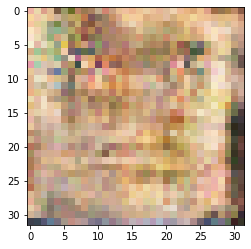

In [47]:
error_d_m2, error_g_m2, prediccion_falsa_m2 = entrenar(gan2, 3000, 150, "resultadosGAN-4/modelo2")

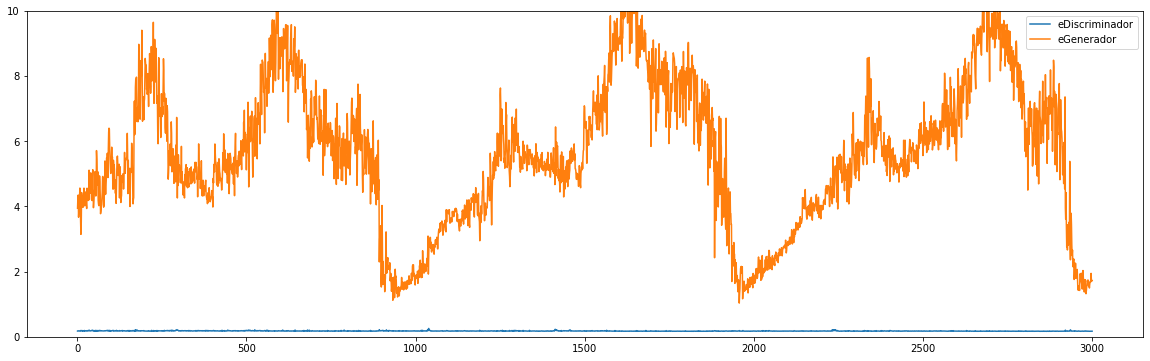

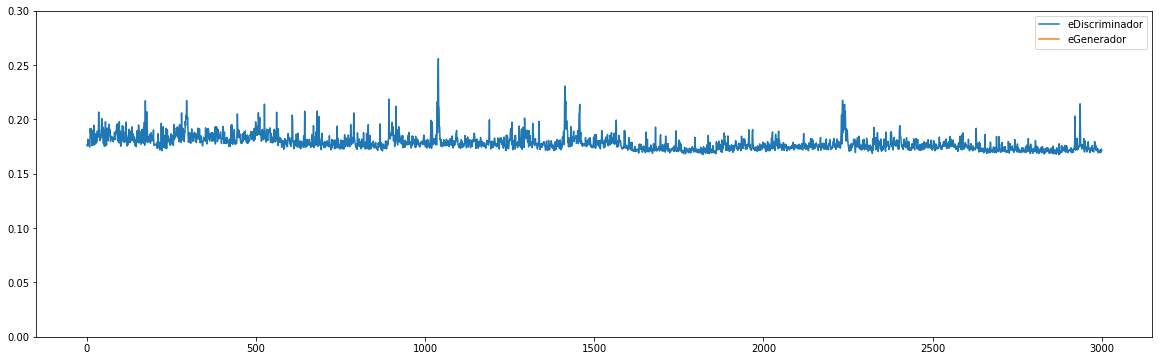

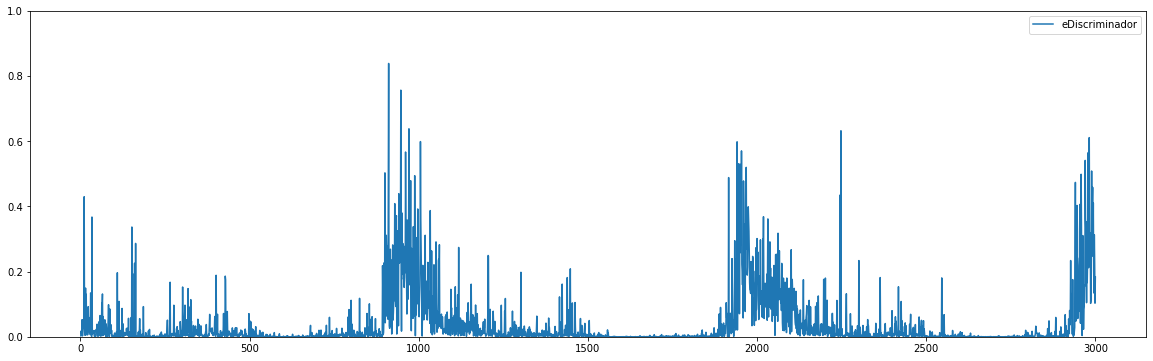

In [48]:
plot_acumulado(len(error_d_m2), 10, eDiscriminador = error_d_m2, eGenerador = error_g_m2)
plot_acumulado(len(error_d_m2), 0.3, eDiscriminador = error_d_m2, eGenerador = error_g_m2)
plot_acumulado(len(prediccion_falsa_m2), 1, eDiscriminador = prediccion_falsa_m2)

tf.Tensor([[0.09824631]], shape=(1, 1), dtype=float32)


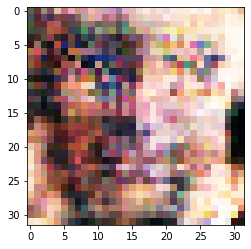

In [49]:
ruido = np.random.normal(0, 1, TAM_ENTRADA)
ruido =np.array([ruido])

predicion(gan2, ruido)

Se hacerca mas que el primer modelo pero no logra generar nada convincente y no pareciera que dejandolo entrenar mas tiempo mejore el resultado. Posee un comportamiento ciclico

El gan es un sistema inestable, el punto de equilibrio entre el generador y discriminador es facilmente superable si se avanzan con los entrenamientos. Pareciera que es lo que ocurre en estos casos, de a momentos esboza siluetas y en otros las imagenes no son reconocibles

### Tercer modelos

Usar diferetes valores del optimizador para el generador y discriminador. En primera instancia se coloca para que el discriminador "aprenda mas rapido" que el generador

In [20]:
OPTIMIZADOR3_G = optimizador.Adam(learning_rate=0.0002, beta_1=0.5) 
OPTIMIZADOR3_D = optimizador.Adam(learning_rate=0.0004, beta_1=0.5)
ERROR3 = 'binary_crossentropy' #para este caso queda igual

gan3 = crear_GAN(OPTIMIZADOR3_G, ERROR3, OPTIMIZADOR3_D, ERROR3)

Generador Creado
Discriminador Creado
GAN Creado


Comenzando Epoca 1... Fin
Tiempo transcurrido:  3.25 s
Tiempo restante aprox: 270.52m -> 4:30h
prediccion de ruido:  [[0.4921174]]
Comenzando Epoca 2... Fin
Tiempo transcurrido:  0.83 s
Tiempo restante aprox: 69.02m -> 1:9h
prediccion de ruido:  [[0.5341849]]
Comenzando Epoca 3... Fin
Tiempo transcurrido:  0.82 s
Tiempo restante aprox: 68.06m -> 1:8h
prediccion de ruido:  [[0.5530223]]
Comenzando Epoca 4... Fin
Tiempo transcurrido:  0.85 s
Tiempo restante aprox: 71.13m -> 1:11h
prediccion de ruido:  [[0.5246006]]
Comenzando Epoca 5... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 63.01m -> 1:3h
prediccion de ruido:  [[0.4495937]]
Comenzando Epoca 6... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 61.41m -> 1:1h
prediccion de ruido:  [[0.47135523]]
Comenzando Epoca 7... Fin
Tiempo transcurrido:  0.83 s
Tiempo restante aprox: 69.01m -> 1:9h
prediccion de ruido:  [[0.4745564]]
Comenzando Epoca 8... Fin
Tiempo transcurrido:  0.81 s
Tiempo restante aprox: 67.0m -> 1:6h
p

Comenzando Epoca 43... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 62.46m -> 1:2h
prediccion de ruido:  [[0.42879492]]
Comenzando Epoca 44... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 60.69m -> 1:0h
prediccion de ruido:  [[0.38257992]]
Comenzando Epoca 45... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 60.63m -> 1:0h
prediccion de ruido:  [[0.4982086]]
Comenzando Epoca 46... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 65.0m -> 1:4h
prediccion de ruido:  [[0.3890041]]
Comenzando Epoca 47... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 60.84m -> 1:0h
prediccion de ruido:  [[0.4772286]]
Comenzando Epoca 48... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 62.18m -> 1:2h
prediccion de ruido:  [[0.42520708]]
Comenzando Epoca 49... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 59.71m -> 0:59h
prediccion de ruido:  [[0.48820814]]
Comenzando Epoca 50... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 62.19m 

Comenzando Epoca 85... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 64.0m -> 1:3h
prediccion de ruido:  [[0.31120765]]
Comenzando Epoca 86... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 62.21m -> 1:2h
prediccion de ruido:  [[0.5390264]]
Comenzando Epoca 87... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 62.95m -> 1:2h
prediccion de ruido:  [[0.521714]]
Comenzando Epoca 88... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 59.99m -> 0:59h
prediccion de ruido:  [[0.33074516]]
Comenzando Epoca 89... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 60.41m -> 1:0h
prediccion de ruido:  [[0.38159776]]
Comenzando Epoca 90... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 59.26m -> 0:59h
prediccion de ruido:  [[0.50814265]]
Comenzando Epoca 91... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 62.64m -> 1:2h
prediccion de ruido:  [[0.37547618]]
Comenzando Epoca 92... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 60.78m

Comenzando Epoca 167... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 60.8m -> 1:0h
prediccion de ruido:  [[0.41807833]]
Comenzando Epoca 168... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 58.03m -> 0:58h
prediccion de ruido:  [[0.2955739]]
Comenzando Epoca 169... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 61.61m -> 1:1h
prediccion de ruido:  [[0.13734445]]
Comenzando Epoca 170... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 62.42m -> 1:2h
prediccion de ruido:  [[0.12988135]]
Comenzando Epoca 171... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 64.69m -> 1:4h
prediccion de ruido:  [[0.32420003]]
Comenzando Epoca 172... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 63.47m -> 1:3h
prediccion de ruido:  [[0.12764189]]
Comenzando Epoca 173... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 61.66m -> 1:1h
prediccion de ruido:  [[0.30860692]]
Comenzando Epoca 174... Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox:

Comenzando Epoca 208... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 58.57m -> 0:58h
prediccion de ruido:  [[0.36010438]]
Comenzando Epoca 209... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 58.56m -> 0:58h
prediccion de ruido:  [[0.07391223]]
Comenzando Epoca 210... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 57.3m -> 0:57h
prediccion de ruido:  [[0.1336939]]
Comenzando Epoca 211... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 58.54m -> 0:58h
prediccion de ruido:  [[0.15420076]]
Comenzando Epoca 212... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 57.28m -> 0:57h
prediccion de ruido:  [[0.07681859]]
Comenzando Epoca 213... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 58.51m -> 0:58h
prediccion de ruido:  [[0.21478257]]
Comenzando Epoca 214... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 57.25m -> 0:57h
prediccion de ruido:  [[0.19029266]]
Comenzando Epoca 215... Fin
Tiempo transcurrido:  0.73 s
Tiempo restant

Comenzando Epoca 249... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 56.84m -> 0:56h
prediccion de ruido:  [[0.29630953]]
Comenzando Epoca 250... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 56.82m -> 0:56h
prediccion de ruido:  [[0.21857026]]
Comenzando Epoca 251... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 58.05m -> 0:58h
prediccion de ruido:  [[0.28231436]]
Comenzando Epoca 252... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 58.03m -> 0:58h
prediccion de ruido:  [[0.09475636]]
Comenzando Epoca 253... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 56.79m -> 0:56h
prediccion de ruido:  [[0.17258367]]
Comenzando Epoca 254... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 56.78m -> 0:56h
prediccion de ruido:  [[0.22950721]]
Comenzando Epoca 255... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 56.76m -> 0:56h
prediccion de ruido:  [[0.3362685]]
Comenzando Epoca 256... Fin
Tiempo transcurrido:  0.74 s
Tiempo restan

Comenzando Epoca 290... Fin
Tiempo transcurrido:  0.7 s
Tiempo restante aprox: 55.28m -> 0:55h
prediccion de ruido:  [[0.03132239]]
Comenzando Epoca 291... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 57.56m -> 0:57h
prediccion de ruido:  [[0.23431498]]
Comenzando Epoca 292... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 57.55m -> 0:57h
prediccion de ruido:  [[0.10563016]]
Comenzando Epoca 293... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 56.39m -> 0:56h
prediccion de ruido:  [[0.17539349]]
Comenzando Epoca 294... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 56.56m -> 0:56h
prediccion de ruido:  [[0.42964363]]
Comenzando Epoca 295... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 57.51m -> 0:57h
prediccion de ruido:  [[0.16301778]]
Comenzando Epoca 296... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 56.27m -> 0:56h
prediccion de ruido:  [[0.26210088]]
Comenzando Epoca 297... Fin
Tiempo transcurrido:  0.72 s
Tiempo restan

Comenzando Epoca 331... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 58.28m -> 0:58h
prediccion de ruido:  [[0.12284744]]
Comenzando Epoca 332... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 55.84m -> 0:55h
prediccion de ruido:  [[0.27513254]]
Comenzando Epoca 333... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 57.04m -> 0:57h
prediccion de ruido:  [[0.57237864]]
Comenzando Epoca 334... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 55.82m -> 0:55h
prediccion de ruido:  [[0.4833498]]
Comenzando Epoca 335... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 55.81m -> 0:55h
prediccion de ruido:  [[0.06462958]]
Comenzando Epoca 336... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 57.01m -> 0:57h
prediccion de ruido:  [[0.33840403]]
Comenzando Epoca 337... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 57.0m -> 0:56h
prediccion de ruido:  [[0.18674183]]
Comenzando Epoca 338... Fin
Tiempo transcurrido:  0.72 s
Tiempo restant

Comenzando Epoca 372... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 56.57m -> 0:56h
prediccion de ruido:  [[0.14174607]]
Comenzando Epoca 373... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 56.56m -> 0:56h
prediccion de ruido:  [[0.10097301]]
Comenzando Epoca 374... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 55.34m -> 0:55h
prediccion de ruido:  [[0.07805967]]
Comenzando Epoca 375... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 56.53m -> 0:56h
prediccion de ruido:  [[0.06330976]]
Comenzando Epoca 376... Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 70.95m -> 1:10h
prediccion de ruido:  [[0.31119692]]
Comenzando Epoca 377... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 56.51m -> 0:56h
prediccion de ruido:  [[0.07224444]]
Comenzando Epoca 378... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 55.29m -> 0:55h
prediccion de ruido:  [[0.08366105]]
Comenzando Epoca 379... Fin
Tiempo transcurrido:  0.72 s
Tiempo resta

Comenzando Epoca 413... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 57.26m -> 0:57h
prediccion de ruido:  [[0.18213162]]
Comenzando Epoca 414... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 56.05m -> 0:56h
prediccion de ruido:  [[0.33119476]]
Comenzando Epoca 415... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 57.23m -> 0:57h
prediccion de ruido:  [[0.05433017]]
Comenzando Epoca 416... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 57.22m -> 0:57h
prediccion de ruido:  [[0.10237679]]
Comenzando Epoca 417... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 54.83m -> 0:54h
prediccion de ruido:  [[0.11818919]]
Comenzando Epoca 418... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 56.01m -> 0:56h
prediccion de ruido:  [[0.11864525]]
Comenzando Epoca 419... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 55.99m -> 0:55h
prediccion de ruido:  [[0.06324419]]
Comenzando Epoca 420... Fin
Tiempo transcurrido:  0.73 s
Tiempo resta

Comenzando Epoca 454... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 54.46m -> 0:54h
prediccion de ruido:  [[0.02240306]]
Comenzando Epoca 455... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 55.7m -> 0:55h
prediccion de ruido:  [[0.07789603]]
Comenzando Epoca 456... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 55.54m -> 0:55h
prediccion de ruido:  [[0.07987621]]
Comenzando Epoca 457... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 55.53m -> 0:55h
prediccion de ruido:  [[0.01344037]]
Comenzando Epoca 458... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 54.34m -> 0:54h
prediccion de ruido:  [[0.05072224]]
Comenzando Epoca 459... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 55.5m -> 0:55h
prediccion de ruido:  [[0.09141502]]
Comenzando Epoca 460... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 54.31m -> 0:54h
prediccion de ruido:  [[0.04534692]]
Comenzando Epoca 461... Fin
Tiempo transcurrido:  0.73 s
Tiempo restant

Comenzando Epoca 495... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 55.06m -> 0:55h
prediccion de ruido:  [[0.07314295]]
Comenzando Epoca 496... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 53.88m -> 0:53h
prediccion de ruido:  [[0.33297718]]
Comenzando Epoca 497... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 53.87m -> 0:53h
prediccion de ruido:  [[0.03123027]]
Comenzando Epoca 498... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 55.03m -> 0:55h
prediccion de ruido:  [[0.08318493]]
Comenzando Epoca 499... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 53.84m -> 0:53h
prediccion de ruido:  [[0.01373982]]
Comenzando Epoca 500... Fin
Tiempo transcurrido:  0.86 s
Tiempo restante aprox: 64.37m -> 1:4h
prediccion de ruido:  [[0.01753044]]
Comenzando Epoca 501... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 53.82m -> 0:53h
prediccion de ruido:  [[0.03325757]]
Comenzando Epoca 502... Fin
Tiempo transcurrido:  0.75 s
Tiempo restan

Comenzando Epoca 536... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 53.4m -> 0:53h
prediccion de ruido:  [[0.21362722]]
Comenzando Epoca 537... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 53.39m -> 0:53h
prediccion de ruido:  [[0.46763098]]
Comenzando Epoca 538... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 54.54m -> 0:54h
prediccion de ruido:  [[0.17725006]]
Comenzando Epoca 539... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 53.37m -> 0:53h
prediccion de ruido:  [[0.03312033]]
Comenzando Epoca 540... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 54.51m -> 0:54h
prediccion de ruido:  [[0.05621573]]
Comenzando Epoca 541... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 54.5m -> 0:54h
prediccion de ruido:  [[0.05272198]]
Comenzando Epoca 542... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 53.33m -> 0:53h
prediccion de ruido:  [[0.14032131]]
Comenzando Epoca 543... Fin
Tiempo transcurrido:  0.73 s
Tiempo restant

Comenzando Epoca 577... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 52.91m -> 0:52h
prediccion de ruido:  [[0.06326392]]
Comenzando Epoca 578... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 52.9m -> 0:52h
prediccion de ruido:  [[0.12381703]]
Comenzando Epoca 579... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 54.04m -> 0:54h
prediccion de ruido:  [[0.02120888]]
Comenzando Epoca 580... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 52.88m -> 0:52h
prediccion de ruido:  [[0.07003713]]
Comenzando Epoca 581... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 55.16m -> 0:55h
prediccion de ruido:  [[0.02438021]]
Comenzando Epoca 582... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 52.93m -> 0:52h
prediccion de ruido:  [[0.04645148]]
Comenzando Epoca 583... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 53.99m -> 0:53h
prediccion de ruido:  [[0.01742119]]
Comenzando Epoca 584... Fin
Tiempo transcurrido:  0.72 s
Tiempo restan

Comenzando Epoca 618... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 52.86m -> 0:52h
prediccion de ruido:  [[0.05074731]]
Comenzando Epoca 619... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 52.41m -> 0:52h
prediccion de ruido:  [[0.07273135]]
Comenzando Epoca 620... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 53.68m -> 0:53h
prediccion de ruido:  [[0.05947313]]
Comenzando Epoca 621... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 52.46m -> 0:52h
prediccion de ruido:  [[0.08469993]]
Comenzando Epoca 622... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 52.45m -> 0:52h
prediccion de ruido:  [[0.00734952]]
Comenzando Epoca 623... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 54.64m -> 0:54h
prediccion de ruido:  [[0.01088569]]
Comenzando Epoca 624... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 53.08m -> 0:53h
prediccion de ruido:  [[0.0687893]]
Comenzando Epoca 625... Fin
Tiempo transcurrido:  0.74 s
Tiempo restan

Comenzando Epoca 659... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 53.06m -> 0:53h
prediccion de ruido:  [[0.01847738]]
Comenzando Epoca 660... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 53.05m -> 0:53h
prediccion de ruido:  [[0.03395411]]
Comenzando Epoca 661... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 53.04m -> 0:53h
prediccion de ruido:  [[0.11849645]]
Comenzando Epoca 662... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 51.9m -> 0:51h
prediccion de ruido:  [[0.08779678]]
Comenzando Epoca 663... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 53.01m -> 0:53h
prediccion de ruido:  [[0.00660154]]
Comenzando Epoca 664... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 53.0m -> 0:52h
prediccion de ruido:  [[0.01510018]]
Comenzando Epoca 665... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 51.86m -> 0:51h
prediccion de ruido:  [[0.00593877]]
Comenzando Epoca 666... Fin
Tiempo transcurrido:  0.73 s
Tiempo restant

Comenzando Epoca 700... Fin
Tiempo transcurrido:  0.86 s
Tiempo restante aprox: 61.51m -> 1:1h
prediccion de ruido:  [[0.02344826]]
Comenzando Epoca 701... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 51.43m -> 0:51h
prediccion de ruido:  [[0.09825736]]
Comenzando Epoca 702... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 54.77m -> 0:54h
prediccion de ruido:  [[0.01062897]]
Comenzando Epoca 703... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 52.52m -> 0:52h
prediccion de ruido:  [[0.00350398]]
Comenzando Epoca 704... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 52.51m -> 0:52h
prediccion de ruido:  [[0.16688898]]
Comenzando Epoca 705... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 52.57m -> 0:52h
prediccion de ruido:  [[0.08498034]]
Comenzando Epoca 706... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 52.49m -> 0:52h
prediccion de ruido:  [[0.00414151]]
Comenzando Epoca 707... Fin
Tiempo transcurrido:  0.72 s
Tiempo restan

Comenzando Epoca 741... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 56.45m -> 0:56h
prediccion de ruido:  [[0.06365097]]
Comenzando Epoca 742... Fin
Tiempo transcurrido:  0.83 s
Tiempo restante aprox: 59.21m -> 0:59h
prediccion de ruido:  [[0.00136256]]
Comenzando Epoca 743... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 56.57m -> 0:56h
prediccion de ruido:  [[0.07241267]]
Comenzando Epoca 744... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 53.43m -> 0:53h
prediccion de ruido:  [[0.15782112]]
Comenzando Epoca 745... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 55.26m -> 0:55h
prediccion de ruido:  [[0.00069061]]
Comenzando Epoca 746... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 53.97m -> 0:53h
prediccion de ruido:  [[0.00341731]]
Comenzando Epoca 747... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 55.09m -> 0:55h
prediccion de ruido:  [[0.15482327]]
Comenzando Epoca 748... Fin
Tiempo transcurrido:  0.77 s
Tiempo restant

Comenzando Epoca 782... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 55.2m -> 0:55h
prediccion de ruido:  [[0.01046497]]
Comenzando Epoca 783... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 53.35m -> 0:53h
prediccion de ruido:  [[0.06824243]]
Comenzando Epoca 784... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 50.44m -> 0:50h
prediccion de ruido:  [[0.01080021]]
Comenzando Epoca 785... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 52.52m -> 0:52h
prediccion de ruido:  [[0.00371417]]
Comenzando Epoca 786... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 51.75m -> 0:51h
prediccion de ruido:  [[0.01173204]]
Comenzando Epoca 787... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 54.52m -> 0:54h
prediccion de ruido:  [[0.00373921]]
Comenzando Epoca 788... Fin
Tiempo transcurrido:  0.71 s
Tiempo restante aprox: 50.02m -> 0:50h
prediccion de ruido:  [[0.01531366]]
Comenzando Epoca 789... Fin
Tiempo transcurrido:  0.73 s
Tiempo restan

Comenzando Epoca 823... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 51.1m -> 0:51h
prediccion de ruido:  [[0.00120801]]
Comenzando Epoca 824... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 51.24m -> 0:51h
prediccion de ruido:  [[0.00604913]]
Comenzando Epoca 825... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 50.43m -> 0:50h
prediccion de ruido:  [[0.09032762]]
Comenzando Epoca 826... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 50.27m -> 0:50h
prediccion de ruido:  [[0.02242255]]
Comenzando Epoca 827... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 50.3m -> 0:50h
prediccion de ruido:  [[0.14964238]]
Comenzando Epoca 828... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 51.02m -> 0:51h
prediccion de ruido:  [[0.00897008]]
Comenzando Epoca 829... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 50.18m -> 0:50h
prediccion de ruido:  [[0.004682]]
Comenzando Epoca 830... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante 

Comenzando Epoca 864... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 51.81m -> 0:51h
prediccion de ruido:  [[0.13177043]]
Comenzando Epoca 865... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 50.08m -> 0:50h
prediccion de ruido:  [[0.0340136]]
Comenzando Epoca 866... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 53.72m -> 0:53h
prediccion de ruido:  [[0.00164092]]
Comenzando Epoca 867... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 51.65m -> 0:51h
prediccion de ruido:  [[0.00165063]]
Comenzando Epoca 868... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 50.8m -> 0:50h
prediccion de ruido:  [[0.00608864]]
Comenzando Epoca 869... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 50.89m -> 0:50h
prediccion de ruido:  [[0.00613284]]
Comenzando Epoca 870... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 50.57m -> 0:50h
prediccion de ruido:  [[0.00901255]]
Comenzando Epoca 871... Fin
Tiempo transcurrido:  0.75 s
Tiempo restant

Comenzando Epoca 905... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 50.05m -> 0:50h
prediccion de ruido:  [[0.00112605]]
Comenzando Epoca 906... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 51.11m -> 0:51h
prediccion de ruido:  [[0.06238341]]
Comenzando Epoca 907... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 50.03m -> 0:50h
prediccion de ruido:  [[0.00067547]]
Comenzando Epoca 908... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 50.02m -> 0:50h
prediccion de ruido:  [[0.06309438]]
Comenzando Epoca 909... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 50.01m -> 0:50h
prediccion de ruido:  [[0.00271583]]
Comenzando Epoca 910... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 49.99m -> 0:49h
prediccion de ruido:  [[0.0424372]]
Comenzando Epoca 911... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 49.98m -> 0:49h
prediccion de ruido:  [[0.01008347]]
Comenzando Epoca 912... Fin
Tiempo transcurrido:  0.72 s
Tiempo restan

Comenzando Epoca 946... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 48.5m -> 0:48h
prediccion de ruido:  [[0.00492248]]
Comenzando Epoca 947... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 49.54m -> 0:49h
prediccion de ruido:  [[0.00542971]]
Comenzando Epoca 948... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 49.53m -> 0:49h
prediccion de ruido:  [[0.0086236]]
Comenzando Epoca 949... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 49.51m -> 0:49h
prediccion de ruido:  [[0.01520547]]
Comenzando Epoca 950... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 49.5m -> 0:49h
prediccion de ruido:  [[0.0092524]]
Comenzando Epoca 951... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 49.49m -> 0:49h
prediccion de ruido:  [[0.00469732]]
Comenzando Epoca 952... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 49.48m -> 0:49h
prediccion de ruido:  [[0.00170943]]
Comenzando Epoca 953... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante 

Comenzando Epoca 987... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 48.01m -> 0:48h
prediccion de ruido:  [[0.00092432]]
Comenzando Epoca 988... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 49.04m -> 0:49h
prediccion de ruido:  [[0.00968063]]
Comenzando Epoca 989... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 48.05m -> 0:48h
prediccion de ruido:  [[0.00271797]]
Comenzando Epoca 990... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 49.01m -> 0:49h
prediccion de ruido:  [[0.07373977]]
Comenzando Epoca 991... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 49.0m -> 0:49h
prediccion de ruido:  [[0.05921718]]
Comenzando Epoca 992... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 48.01m -> 0:48h
prediccion de ruido:  [[0.00725722]]
Comenzando Epoca 993... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 48.98m -> 0:48h
prediccion de ruido:  [[0.01215297]]
Comenzando Epoca 994... Fin
Tiempo transcurrido:  0.74 s
Tiempo restan

Comenzando Epoca 1028... Fin
Tiempo transcurrido:  0.87 s
Tiempo restante aprox: 57.87m -> 0:57h
prediccion de ruido:  [[0.00804985]]
Comenzando Epoca 1029... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 48.38m -> 0:48h
prediccion de ruido:  [[0.03715923]]
Comenzando Epoca 1030... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 50.87m -> 0:50h
prediccion de ruido:  [[0.01294297]]
Comenzando Epoca 1031... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 48.14m -> 0:48h
prediccion de ruido:  [[0.041372]]
Comenzando Epoca 1032... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 48.13m -> 0:48h
prediccion de ruido:  [[0.01587838]]
Comenzando Epoca 1033... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 53.24m -> 0:53h
prediccion de ruido:  [[0.00328809]]
Comenzando Epoca 1034... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 47.33m -> 0:47h
prediccion de ruido:  [[0.00205895]]
Comenzando Epoca 1035... Fin
Tiempo transcurrido:  0.76 s
Tiempo 

Comenzando Epoca 1069... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 47.03m -> 0:47h
prediccion de ruido:  [[0.00236341]]
Comenzando Epoca 1070... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 48.04m -> 0:48h
prediccion de ruido:  [[0.01278791]]
Comenzando Epoca 1071... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 48.02m -> 0:48h
prediccion de ruido:  [[0.08032939]]
Comenzando Epoca 1072... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 47.06m -> 0:47h
prediccion de ruido:  [[0.00537065]]
Comenzando Epoca 1073... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 48.0m -> 0:47h
prediccion de ruido:  [[0.06685269]]
Comenzando Epoca 1074... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 49.01m -> 0:49h
prediccion de ruido:  [[0.01456091]]
Comenzando Epoca 1075... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 47.97m -> 0:47h
prediccion de ruido:  [[0.0048041]]
Comenzando Epoca 1076... Fin
Tiempo transcurrido:  0.73 s
Tiempo

Comenzando Epoca 1110... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 47.55m -> 0:47h
prediccion de ruido:  [[0.00398442]]
Comenzando Epoca 1111... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 46.52m -> 0:46h
prediccion de ruido:  [[0.02389926]]
Comenzando Epoca 1112... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 47.65m -> 0:47h
prediccion de ruido:  [[0.00097722]]
Comenzando Epoca 1113... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 47.58m -> 0:47h
prediccion de ruido:  [[0.01969782]]
Comenzando Epoca 1114... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 47.5m -> 0:47h
prediccion de ruido:  [[0.01485595]]
Comenzando Epoca 1115... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 47.49m -> 0:47h
prediccion de ruido:  [[0.00543851]]
Comenzando Epoca 1116... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 47.6m -> 0:47h
prediccion de ruido:  [[0.02205133]]
Comenzando Epoca 1117... Fin
Tiempo transcurrido:  0.74 s
Tiempo

Comenzando Epoca 1151... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 46.05m -> 0:46h
prediccion de ruido:  [[0.00050423]]
Comenzando Epoca 1152... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 46.03m -> 0:46h
prediccion de ruido:  [[0.09439838]]
Comenzando Epoca 1153... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 46.02m -> 0:46h
prediccion de ruido:  [[0.00170803]]
Comenzando Epoca 1154... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 46.01m -> 0:46h
prediccion de ruido:  [[0.0545347]]
Comenzando Epoca 1155... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 47.0m -> 0:46h
prediccion de ruido:  [[0.00918701]]
Comenzando Epoca 1156... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 46.99m -> 0:46h
prediccion de ruido:  [[0.00363359]]
Comenzando Epoca 1157... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 45.97m -> 0:45h
prediccion de ruido:  [[0.03618929]]
Comenzando Epoca 1158... Fin
Tiempo transcurrido:  0.73 s
Tiempo

Comenzando Epoca 1192... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 45.68m -> 0:45h
prediccion de ruido:  [[0.00824577]]
Comenzando Epoca 1193... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 45.54m -> 0:45h
prediccion de ruido:  [[0.00275069]]
Comenzando Epoca 1194... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 46.52m -> 0:46h
prediccion de ruido:  [[0.01152274]]
Comenzando Epoca 1195... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 46.64m -> 0:46h
prediccion de ruido:  [[0.00328261]]
Comenzando Epoca 1196... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 46.5m -> 0:46h
prediccion de ruido:  [[0.00138816]]
Comenzando Epoca 1197... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 45.49m -> 0:45h
prediccion de ruido:  [[0.00040984]]
Comenzando Epoca 1198... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 46.47m -> 0:46h
prediccion de ruido:  [[0.00187358]]
Comenzando Epoca 1199... Fin
Tiempo transcurrido:  0.73 s
Tiemp

Comenzando Epoca 1233... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 46.04m -> 0:46h
prediccion de ruido:  [[0.00929341]]
Comenzando Epoca 1234... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 46.03m -> 0:46h
prediccion de ruido:  [[0.02427754]]
Comenzando Epoca 1235... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 45.04m -> 0:45h
prediccion de ruido:  [[0.00238588]]
Comenzando Epoca 1236... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 46.01m -> 0:46h
prediccion de ruido:  [[0.00121924]]
Comenzando Epoca 1237... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 46.0m -> 0:45h
prediccion de ruido:  [[0.01629502]]
Comenzando Epoca 1238... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 45.0m -> 0:45h
prediccion de ruido:  [[0.00266296]]
Comenzando Epoca 1239... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 48.91m -> 0:48h
prediccion de ruido:  [[0.09767044]]
Comenzando Epoca 1240... Fin
Tiempo transcurrido:  0.76 s
Tiempo

Comenzando Epoca 1274... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 45.54m -> 0:45h
prediccion de ruido:  [[0.00751173]]
Comenzando Epoca 1275... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 44.56m -> 0:44h
prediccion de ruido:  [[0.00253049]]
Comenzando Epoca 1276... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 45.52m -> 0:45h
prediccion de ruido:  [[0.00154603]]
Comenzando Epoca 1277... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 45.51m -> 0:45h
prediccion de ruido:  [[0.00193891]]
Comenzando Epoca 1278... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 44.53m -> 0:44h
prediccion de ruido:  [[0.00799397]]
Comenzando Epoca 1279... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 44.51m -> 0:44h
prediccion de ruido:  [[0.00194511]]
Comenzando Epoca 1280... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 45.47m -> 0:45h
prediccion de ruido:  [[0.00141752]]
Comenzando Epoca 1281... Fin
Tiempo transcurrido:  0.73 s
Tiem

Comenzando Epoca 1315... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 44.08m -> 0:44h
prediccion de ruido:  [[0.00667688]]
Comenzando Epoca 1316... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 45.03m -> 0:45h
prediccion de ruido:  [[0.00432104]]
Comenzando Epoca 1317... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 44.06m -> 0:44h
prediccion de ruido:  [[0.00390765]]
Comenzando Epoca 1318... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 45.01m -> 0:45h
prediccion de ruido:  [[0.00414547]]
Comenzando Epoca 1319... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 44.99m -> 0:44h
prediccion de ruido:  [[0.00357637]]
Comenzando Epoca 1320... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 44.02m -> 0:44h
prediccion de ruido:  [[0.00724712]]
Comenzando Epoca 1321... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 44.97m -> 0:44h
prediccion de ruido:  [[0.00088665]]
Comenzando Epoca 1322... Fin
Tiempo transcurrido:  0.72 s
Tiem

Comenzando Epoca 1356... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 43.59m -> 0:43h
prediccion de ruido:  [[0.00032902]]
Comenzando Epoca 1357... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 44.53m -> 0:44h
prediccion de ruido:  [[0.0019393]]
Comenzando Epoca 1358... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 44.52m -> 0:44h
prediccion de ruido:  [[0.00276241]]
Comenzando Epoca 1359... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 43.56m -> 0:43h
prediccion de ruido:  [[0.00048754]]
Comenzando Epoca 1360... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 44.49m -> 0:44h
prediccion de ruido:  [[0.00051439]]
Comenzando Epoca 1361... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 44.48m -> 0:44h
prediccion de ruido:  [[0.00265786]]
Comenzando Epoca 1362... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 43.52m -> 0:43h
prediccion de ruido:  [[0.00243494]]
Comenzando Epoca 1363... Fin
Tiempo transcurrido:  0.73 s
Tiemp

Comenzando Epoca 1397... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 43.1m -> 0:43h
prediccion de ruido:  [[0.00040874]]
Comenzando Epoca 1398... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 44.03m -> 0:44h
prediccion de ruido:  [[0.00038743]]
Comenzando Epoca 1399... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 43.08m -> 0:43h
prediccion de ruido:  [[0.09998682]]
Comenzando Epoca 1400... Fin
Tiempo transcurrido:  0.89 s
Tiempo restante aprox: 53.37m -> 0:53h
prediccion de ruido:  [[0.00943241]]
Comenzando Epoca 1401... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 43.99m -> 0:43h
prediccion de ruido:  [[0.00468698]]
Comenzando Epoca 1402... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 45.85m -> 0:45h
prediccion de ruido:  [[0.00448158]]
Comenzando Epoca 1403... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 43.97m -> 0:43h
prediccion de ruido:  [[0.00228545]]
Comenzando Epoca 1404... Fin
Tiempo transcurrido:  0.72 s
Tiemp

Comenzando Epoca 1438... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 43.54m -> 0:43h
prediccion de ruido:  [[0.01638111]]
Comenzando Epoca 1439... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 42.6m -> 0:42h
prediccion de ruido:  [[0.00360349]]
Comenzando Epoca 1440... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 42.59m -> 0:42h
prediccion de ruido:  [[0.00379464]]
Comenzando Epoca 1441... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 43.5m -> 0:43h
prediccion de ruido:  [[0.00163743]]
Comenzando Epoca 1442... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 43.49m -> 0:43h
prediccion de ruido:  [[0.00414854]]
Comenzando Epoca 1443... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 42.55m -> 0:42h
prediccion de ruido:  [[0.000256]]
Comenzando Epoca 1444... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 43.47m -> 0:43h
prediccion de ruido:  [[0.00917372]]
Comenzando Epoca 1445... Fin
Tiempo transcurrido:  0.72 s
Tiempo r

Comenzando Epoca 1479... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 43.04m -> 0:43h
prediccion de ruido:  [[0.08525425]]
Comenzando Epoca 1480... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 43.03m -> 0:43h
prediccion de ruido:  [[0.00061807]]
Comenzando Epoca 1481... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 42.1m -> 0:42h
prediccion de ruido:  [[0.00589564]]
Comenzando Epoca 1482... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 43.0m -> 0:43h
prediccion de ruido:  [[0.06845933]]
Comenzando Epoca 1483... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 42.08m -> 0:42h
prediccion de ruido:  [[0.02012101]]
Comenzando Epoca 1484... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 42.98m -> 0:42h
prediccion de ruido:  [[0.05583879]]
Comenzando Epoca 1485... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 42.97m -> 0:42h
prediccion de ruido:  [[0.00360236]]
Comenzando Epoca 1486... Fin
Tiempo transcurrido:  0.73 s
Tiempo

Comenzando Epoca 1520... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 42.87m -> 0:42h
prediccion de ruido:  [[0.01419416]]
Comenzando Epoca 1521... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 42.53m -> 0:42h
prediccion de ruido:  [[0.00354201]]
Comenzando Epoca 1522... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 43.71m -> 0:43h
prediccion de ruido:  [[0.00319698]]
Comenzando Epoca 1523... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 42.68m -> 0:42h
prediccion de ruido:  [[0.01309779]]
Comenzando Epoca 1524... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 44.59m -> 0:44h
prediccion de ruido:  [[0.00278479]]
Comenzando Epoca 1525... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 45.49m -> 0:45h
prediccion de ruido:  [[0.0426172]]
Comenzando Epoca 1526... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 42.64m -> 0:42h
prediccion de ruido:  [[0.02937058]]
Comenzando Epoca 1527... Fin
Tiempo transcurrido:  0.74 s
Tiemp

Comenzando Epoca 1561... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 42.21m -> 0:42h
prediccion de ruido:  [[0.00303262]]
Comenzando Epoca 1562... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 42.2m -> 0:42h
prediccion de ruido:  [[0.04480851]]
Comenzando Epoca 1563... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 43.08m -> 0:43h
prediccion de ruido:  [[0.00047389]]
Comenzando Epoca 1564... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 42.15m -> 0:42h
prediccion de ruido:  [[0.00699493]]
Comenzando Epoca 1565... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 42.14m -> 0:42h
prediccion de ruido:  [[0.00147882]]
Comenzando Epoca 1566... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 43.1m -> 0:43h
prediccion de ruido:  [[0.00750628]]
Comenzando Epoca 1567... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 42.11m -> 0:42h
prediccion de ruido:  [[0.01099801]]
Comenzando Epoca 1568... Fin
Tiempo transcurrido:  0.74 s
Tiempo

Comenzando Epoca 1602... Fin
Tiempo transcurrido:  0.82 s
Tiempo restante aprox: 46.35m -> 0:46h
prediccion de ruido:  [[0.03416765]]
Comenzando Epoca 1603... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 43.66m -> 0:43h
prediccion de ruido:  [[0.04084852]]
Comenzando Epoca 1604... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 42.56m -> 0:42h
prediccion de ruido:  [[0.00198495]]
Comenzando Epoca 1605... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 41.73m -> 0:41h
prediccion de ruido:  [[0.01120055]]
Comenzando Epoca 1606... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 40.66m -> 0:40h
prediccion de ruido:  [[0.01462427]]
Comenzando Epoca 1607... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 41.66m -> 0:41h
prediccion de ruido:  [[0.00012523]]
Comenzando Epoca 1608... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 41.43m -> 0:41h
prediccion de ruido:  [[0.01523957]]
Comenzando Epoca 1609... Fin
Tiempo transcurrido:  0.77 s
Tiem

Comenzando Epoca 1643... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 41.39m -> 0:41h
prediccion de ruido:  [[0.0242992]]
Comenzando Epoca 1644... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 41.02m -> 0:41h
prediccion de ruido:  [[0.00783724]]
Comenzando Epoca 1645... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 40.38m -> 0:40h
prediccion de ruido:  [[0.00099397]]
Comenzando Epoca 1646... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 40.35m -> 0:40h
prediccion de ruido:  [[0.00464037]]
Comenzando Epoca 1647... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 43.89m -> 0:43h
prediccion de ruido:  [[0.05966139]]
Comenzando Epoca 1648... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 41.4m -> 0:41h
prediccion de ruido:  [[0.16883737]]
Comenzando Epoca 1649... Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 51.51m -> 0:51h
prediccion de ruido:  [[0.00107911]]
Comenzando Epoca 1650... Fin
Tiempo transcurrido:  0.96 s
Tiempo

Comenzando Epoca 1684... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 41.79m -> 0:41h
prediccion de ruido:  [[0.00221846]]
Comenzando Epoca 1685... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 40.43m -> 0:40h
prediccion de ruido:  [[0.00146317]]
Comenzando Epoca 1686... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 40.19m -> 0:40h
prediccion de ruido:  [[0.01441899]]
Comenzando Epoca 1687... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 40.68m -> 0:40h
prediccion de ruido:  [[0.0011602]]
Comenzando Epoca 1688... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 39.99m -> 0:39h
prediccion de ruido:  [[0.00661999]]
Comenzando Epoca 1689... Fin
Tiempo transcurrido:  0.81 s
Tiempo restante aprox: 44.93m -> 0:44h
prediccion de ruido:  [[3.5507568e-05]]
Comenzando Epoca 1690... Fin
Tiempo transcurrido:  0.99 s
Tiempo restante aprox: 54.52m -> 0:54h
prediccion de ruido:  [[0.01452106]]
Comenzando Epoca 1691... Fin
Tiempo transcurrido:  0.78 s
Ti

Comenzando Epoca 1725... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 40.48m -> 0:40h
prediccion de ruido:  [[0.03190926]]
Comenzando Epoca 1726... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 39.44m -> 0:39h
prediccion de ruido:  [[0.00031272]]
Comenzando Epoca 1727... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 40.87m -> 0:40h
prediccion de ruido:  [[5.0926137e-06]]
Comenzando Epoca 1728... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 40.21m -> 0:40h
prediccion de ruido:  [[0.00010459]]
Comenzando Epoca 1729... Fin
Tiempo transcurrido:  0.71 s
Tiempo restante aprox: 38.83m -> 0:38h
prediccion de ruido:  [[0.0129711]]
Comenzando Epoca 1730... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 41.44m -> 0:41h
prediccion de ruido:  [[0.00916302]]
Comenzando Epoca 1731... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 39.11m -> 0:39h
prediccion de ruido:  [[8.332093e-05]]
Comenzando Epoca 1732... Fin
Tiempo transcurrido:  0.75 s


Comenzando Epoca 1766... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 39.53m -> 0:39h
prediccion de ruido:  [[0.0001581]]
Comenzando Epoca 1767... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 38.68m -> 0:38h
prediccion de ruido:  [[0.0010663]]
Comenzando Epoca 1768... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 39.51m -> 0:39h
prediccion de ruido:  [[0.00257471]]
Comenzando Epoca 1769... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 38.71m -> 0:38h
prediccion de ruido:  [[0.00119454]]
Comenzando Epoca 1770... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 39.48m -> 0:39h
prediccion de ruido:  [[0.0002664]]
Comenzando Epoca 1771... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 38.63m -> 0:38h
prediccion de ruido:  [[0.00019765]]
Comenzando Epoca 1772... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 39.51m -> 0:39h
prediccion de ruido:  [[0.04054812]]
Comenzando Epoca 1773... Fin
Tiempo transcurrido:  0.72 s
Tiempo 

Comenzando Epoca 1807... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 40.5m -> 0:40h
prediccion de ruido:  [[0.01112613]]
Comenzando Epoca 1808... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 39.18m -> 0:39h
prediccion de ruido:  [[0.09159282]]
Comenzando Epoca 1809... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 38.18m -> 0:38h
prediccion de ruido:  [[0.01098016]]
Comenzando Epoca 1810... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 39.86m -> 0:39h
prediccion de ruido:  [[0.00837326]]
Comenzando Epoca 1811... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 39.19m -> 0:39h
prediccion de ruido:  [[0.00590804]]
Comenzando Epoca 1812... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 38.14m -> 0:38h
prediccion de ruido:  [[0.00147197]]
Comenzando Epoca 1813... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 40.89m -> 0:40h
prediccion de ruido:  [[0.03605935]]
Comenzando Epoca 1814... Fin
Tiempo transcurrido:  0.73 s
Tiemp

Comenzando Epoca 1848... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 37.71m -> 0:37h
prediccion de ruido:  [[0.09885257]]
Comenzando Epoca 1849... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 38.52m -> 0:38h
prediccion de ruido:  [[0.00585568]]
Comenzando Epoca 1850... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 37.95m -> 0:37h
prediccion de ruido:  [[0.01367429]]
Comenzando Epoca 1851... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 39.42m -> 0:39h
prediccion de ruido:  [[0.00292337]]
Comenzando Epoca 1852... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 40.27m -> 0:40h
prediccion de ruido:  [[0.01346442]]
Comenzando Epoca 1853... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 41.61m -> 0:41h
prediccion de ruido:  [[0.00018021]]
Comenzando Epoca 1854... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 41.65m -> 0:41h
prediccion de ruido:  [[0.0302906]]
Comenzando Epoca 1855... Fin
Tiempo transcurrido:  0.77 s
Tiemp

Comenzando Epoca 1889... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 38.14m -> 0:38h
prediccion de ruido:  [[0.01465791]]
Comenzando Epoca 1890... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 39.73m -> 0:39h
prediccion de ruido:  [[0.02071089]]
Comenzando Epoca 1891... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 38.22m -> 0:38h
prediccion de ruido:  [[0.02296683]]
Comenzando Epoca 1892... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 41.2m -> 0:41h
prediccion de ruido:  [[0.00338557]]
Comenzando Epoca 1893... Fin
Tiempo transcurrido:  1.0 s
Tiempo restante aprox: 51.7m -> 0:51h
prediccion de ruido:  [[0.01917759]]
Comenzando Epoca 1894... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 40.38m -> 0:40h
prediccion de ruido:  [[0.0563935]]
Comenzando Epoca 1895... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 37.25m -> 0:37h
prediccion de ruido:  [[0.00173688]]
Comenzando Epoca 1896... Fin
Tiempo transcurrido:  0.73 s
Tiempo re

Comenzando Epoca 1930... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 37.58m -> 0:37h
prediccion de ruido:  [[0.02564085]]
Comenzando Epoca 1931... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 36.77m -> 0:36h
prediccion de ruido:  [[0.01518688]]
Comenzando Epoca 1932... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 37.5m -> 0:37h
prediccion de ruido:  [[0.00318816]]
Comenzando Epoca 1933... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 36.8m -> 0:36h
prediccion de ruido:  [[0.00193015]]
Comenzando Epoca 1934... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 36.68m -> 0:36h
prediccion de ruido:  [[0.00424615]]
Comenzando Epoca 1935... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 37.47m -> 0:37h
prediccion de ruido:  [[0.0035058]]
Comenzando Epoca 1936... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 37.45m -> 0:37h
prediccion de ruido:  [[0.00564167]]
Comenzando Epoca 1937... Fin
Tiempo transcurrido:  0.73 s
Tiempo 

Comenzando Epoca 1971... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 37.03m -> 0:37h
prediccion de ruido:  [[0.00118881]]
Comenzando Epoca 1972... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 36.23m -> 0:36h
prediccion de ruido:  [[0.00839457]]
Comenzando Epoca 1973... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 37.0m -> 0:37h
prediccion de ruido:  [[0.04135391]]
Comenzando Epoca 1974... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 36.2m -> 0:36h
prediccion de ruido:  [[0.02718142]]
Comenzando Epoca 1975... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 36.98m -> 0:36h
prediccion de ruido:  [[0.1571714]]
Comenzando Epoca 1976... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 36.97m -> 0:36h
prediccion de ruido:  [[0.00456509]]
Comenzando Epoca 1977... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 36.17m -> 0:36h
prediccion de ruido:  [[0.02426034]]
Comenzando Epoca 1978... Fin
Tiempo transcurrido:  0.72 s
Tiempo 

Comenzando Epoca 2012... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 35.8m -> 0:35h
prediccion de ruido:  [[0.00360212]]
Comenzando Epoca 2013... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 36.61m -> 0:36h
prediccion de ruido:  [[0.00345466]]
Comenzando Epoca 2014... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 35.86m -> 0:35h
prediccion de ruido:  [[0.00397238]]
Comenzando Epoca 2015... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 39.94m -> 0:39h
prediccion de ruido:  [[0.00647148]]
Comenzando Epoca 2016... Fin
Tiempo transcurrido:  0.81 s
Tiempo restante aprox: 40.4m -> 0:40h
prediccion de ruido:  [[0.01399761]]
Comenzando Epoca 2017... Fin
Tiempo transcurrido:  0.83 s
Tiempo restante aprox: 41.23m -> 0:41h
prediccion de ruido:  [[0.00016487]]
Comenzando Epoca 2018... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 39.93m -> 0:39h
prediccion de ruido:  [[0.01834816]]
Comenzando Epoca 2019... Fin
Tiempo transcurrido:  0.77 s
Tiempo r

Comenzando Epoca 2053... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 36.02m -> 0:36h
prediccion de ruido:  [[0.00814417]]
Comenzando Epoca 2054... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 36.01m -> 0:36h
prediccion de ruido:  [[0.03167787]]
Comenzando Epoca 2055... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 35.23m -> 0:35h
prediccion de ruido:  [[0.01681694]]
Comenzando Epoca 2056... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 35.99m -> 0:35h
prediccion de ruido:  [[0.00966051]]
Comenzando Epoca 2057... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 35.98m -> 0:35h
prediccion de ruido:  [[0.0064621]]
Comenzando Epoca 2058... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 35.2m -> 0:35h
prediccion de ruido:  [[0.04381528]]
Comenzando Epoca 2059... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 35.95m -> 0:35h
prediccion de ruido:  [[0.00333446]]
Comenzando Epoca 2060... Fin
Tiempo transcurrido:  0.74 s
Tiempo

Comenzando Epoca 2094... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 38.72m -> 0:38h
prediccion de ruido:  [[0.03255776]]
Comenzando Epoca 2095... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 38.46m -> 0:38h
prediccion de ruido:  [[0.03005385]]
Comenzando Epoca 2096... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 38.88m -> 0:38h
prediccion de ruido:  [[0.00642294]]
Comenzando Epoca 2097... Fin
Tiempo transcurrido:  0.88 s
Tiempo restante aprox: 42.45m -> 0:42h
prediccion de ruido:  [[0.00320503]]
Comenzando Epoca 2098... Fin
Tiempo transcurrido:  0.89 s
Tiempo restante aprox: 42.87m -> 0:42h
prediccion de ruido:  [[0.00998184]]
Comenzando Epoca 2099... Fin
Tiempo transcurrido:  0.82 s
Tiempo restante aprox: 39.52m -> 0:39h
prediccion de ruido:  [[0.06329903]]
Comenzando Epoca 2100... Fin
Tiempo transcurrido:  0.95 s
Tiempo restante aprox: 45.84m -> 0:45h
prediccion de ruido:  [[0.00477189]]
Comenzando Epoca 2101... Fin
Tiempo transcurrido:  0.73 s
Tiempo

Comenzando Epoca 2135... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 35.12m -> 0:35h
prediccion de ruido:  [[0.00054327]]
Comenzando Epoca 2136... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 34.31m -> 0:34h
prediccion de ruido:  [[0.01059601]]
Comenzando Epoca 2137... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 35.74m -> 0:35h
prediccion de ruido:  [[0.00250754]]
Comenzando Epoca 2138... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 34.99m -> 0:34h
prediccion de ruido:  [[0.00164217]]
Comenzando Epoca 2139... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 34.97m -> 0:34h
prediccion de ruido:  [[0.01048473]]
Comenzando Epoca 2140... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 34.22m -> 0:34h
prediccion de ruido:  [[0.00367242]]
Comenzando Epoca 2141... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 35.69m -> 0:35h
prediccion de ruido:  [[0.03705356]]
Comenzando Epoca 2142... Fin
Tiempo transcurrido:  0.74 s
Tiem

Comenzando Epoca 2176... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 35.26m -> 0:35h
prediccion de ruido:  [[0.04806736]]
Comenzando Epoca 2177... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 34.51m -> 0:34h
prediccion de ruido:  [[5.436109e-06]]
Comenzando Epoca 2178... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 34.5m -> 0:34h
prediccion de ruido:  [[8.071041e-06]]
Comenzando Epoca 2179... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 34.53m -> 0:34h
prediccion de ruido:  [[0.0456228]]
Comenzando Epoca 2180... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 34.47m -> 0:34h
prediccion de ruido:  [[0.00132385]]
Comenzando Epoca 2181... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 36.66m -> 0:36h
prediccion de ruido:  [[0.00060317]]
Comenzando Epoca 2182... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 36.65m -> 0:36h
prediccion de ruido:  [[6.0135386e-05]]
Comenzando Epoca 2183... Fin
Tiempo transcurrido:  0.73 s

Comenzando Epoca 2217... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 34.02m -> 0:34h
prediccion de ruido:  [[0.00457743]]
Comenzando Epoca 2218... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 34.01m -> 0:34h
prediccion de ruido:  [[0.00021639]]
Comenzando Epoca 2219... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 34.0m -> 0:33h
prediccion de ruido:  [[0.01537225]]
Comenzando Epoca 2220... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 33.26m -> 0:33h
prediccion de ruido:  [[0.00044525]]
Comenzando Epoca 2221... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 33.97m -> 0:33h
prediccion de ruido:  [[0.00298202]]
Comenzando Epoca 2222... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 34.68m -> 0:34h
prediccion de ruido:  [[0.03305858]]
Comenzando Epoca 2223... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 33.23m -> 0:33h
prediccion de ruido:  [[2.336636e-05]]
Comenzando Epoca 2224... Fin
Tiempo transcurrido:  0.73 s
Tie

Comenzando Epoca 2258... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 32.81m -> 0:32h
prediccion de ruido:  [[0.00048792]]
Comenzando Epoca 2259... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 33.51m -> 0:33h
prediccion de ruido:  [[0.01202807]]
Comenzando Epoca 2260... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 33.5m -> 0:33h
prediccion de ruido:  [[0.00047711]]
Comenzando Epoca 2261... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 33.48m -> 0:33h
prediccion de ruido:  [[0.00087184]]
Comenzando Epoca 2262... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 33.47m -> 0:33h
prediccion de ruido:  [[0.00085652]]
Comenzando Epoca 2263... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 32.75m -> 0:32h
prediccion de ruido:  [[0.00674298]]
Comenzando Epoca 2264... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 33.45m -> 0:33h
prediccion de ruido:  [[0.00120938]]
Comenzando Epoca 2265... Fin
Tiempo transcurrido:  0.73 s
Tiemp

Comenzando Epoca 2299... Fin
Tiempo transcurrido:  0.81 s
Tiempo restante aprox: 36.31m -> 0:36h
prediccion de ruido:  [[0.00838411]]
Comenzando Epoca 2300... Fin
Tiempo transcurrido:  0.96 s
Tiempo restante aprox: 43.11m -> 0:43h
prediccion de ruido:  [[0.00047624]]
Comenzando Epoca 2301... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 34.65m -> 0:34h
prediccion de ruido:  [[0.00065529]]
Comenzando Epoca 2302... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 34.98m -> 0:34h
prediccion de ruido:  [[0.00205174]]
Comenzando Epoca 2303... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 34.51m -> 0:34h
prediccion de ruido:  [[0.00258657]]
Comenzando Epoca 2304... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 33.04m -> 0:33h
prediccion de ruido:  [[0.00012392]]
Comenzando Epoca 2305... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 33.61m -> 0:33h
prediccion de ruido:  [[0.00294301]]
Comenzando Epoca 2306... Fin
Tiempo transcurrido:  0.75 s
Tiem

Comenzando Epoca 2340... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 32.11m -> 0:32h
prediccion de ruido:  [[0.00934818]]
Comenzando Epoca 2341... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 31.79m -> 0:31h
prediccion de ruido:  [[0.01582584]]
Comenzando Epoca 2342... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 33.82m -> 0:33h
prediccion de ruido:  [[0.0002]]
Comenzando Epoca 2343... Fin
Tiempo transcurrido:  0.85 s
Tiempo restante aprox: 37.7m -> 0:37h
prediccion de ruido:  [[3.5696343e-05]]
Comenzando Epoca 2344... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 32.67m -> 0:32h
prediccion de ruido:  [[1.5867151e-06]]
Comenzando Epoca 2345... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 32.7m -> 0:32h
prediccion de ruido:  [[3.191586e-05]]
Comenzando Epoca 2346... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 31.98m -> 0:31h
prediccion de ruido:  [[0.00538307]]
Comenzando Epoca 2347... Fin
Tiempo transcurrido:  0.76 s
Ti

Comenzando Epoca 2381... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 34.51m -> 0:34h
prediccion de ruido:  [[0.00330669]]
Comenzando Epoca 2382... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 34.57m -> 0:34h
prediccion de ruido:  [[0.0054197]]
Comenzando Epoca 2383... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 34.24m -> 0:34h
prediccion de ruido:  [[0.02575016]]
Comenzando Epoca 2384... Fin
Tiempo transcurrido:  0.86 s
Tiempo restante aprox: 37.33m -> 0:37h
prediccion de ruido:  [[0.00018895]]
Comenzando Epoca 2385... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 33.13m -> 0:33h
prediccion de ruido:  [[0.00076842]]
Comenzando Epoca 2386... Fin
Tiempo transcurrido:  0.83 s
Tiempo restante aprox: 36.31m -> 0:36h
prediccion de ruido:  [[0.00037754]]
Comenzando Epoca 2387... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 34.46m -> 0:34h
prediccion de ruido:  [[0.06651446]]
Comenzando Epoca 2388... Fin
Tiempo transcurrido:  0.79 s
Tiemp

Comenzando Epoca 2422... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 33.92m -> 0:33h
prediccion de ruido:  [[0.00014782]]
Comenzando Epoca 2423... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 34.38m -> 0:34h
prediccion de ruido:  [[0.05548042]]
Comenzando Epoca 2424... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 32.09m -> 0:32h
prediccion de ruido:  [[0.00373226]]
Comenzando Epoca 2425... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 32.77m -> 0:32h
prediccion de ruido:  [[0.00103235]]
Comenzando Epoca 2426... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 32.47m -> 0:32h
prediccion de ruido:  [[0.00037891]]
Comenzando Epoca 2427... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 31.71m -> 0:31h
prediccion de ruido:  [[0.0033949]]
Comenzando Epoca 2428... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 32.4m -> 0:32h
prediccion de ruido:  [[0.00056559]]
Comenzando Epoca 2429... Fin
Tiempo transcurrido:  0.72 s
Tiempo 

Comenzando Epoca 2463... Fin
Tiempo transcurrido:  0.89 s
Tiempo restante aprox: 37.65m -> 0:37h
prediccion de ruido:  [[0.00109279]]
Comenzando Epoca 2464... Fin
Tiempo transcurrido:  0.83 s
Tiempo restante aprox: 35.1m -> 0:35h
prediccion de ruido:  [[0.05440637]]
Comenzando Epoca 2465... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 32.89m -> 0:32h
prediccion de ruido:  [[0.00049108]]
Comenzando Epoca 2466... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 32.62m -> 0:32h
prediccion de ruido:  [[0.00122777]]
Comenzando Epoca 2467... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 33.54m -> 0:33h
prediccion de ruido:  [[0.0001269]]
Comenzando Epoca 2468... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 32.34m -> 0:32h
prediccion de ruido:  [[0.00102547]]
Comenzando Epoca 2469... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 32.03m -> 0:32h
prediccion de ruido:  [[0.00182885]]
Comenzando Epoca 2470... Fin
Tiempo transcurrido:  0.76 s
Tiempo

Comenzando Epoca 2504... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 30.3m -> 0:30h
prediccion de ruido:  [[0.00373378]]
Comenzando Epoca 2505... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 31.12m -> 0:31h
prediccion de ruido:  [[0.00021964]]
Comenzando Epoca 2506... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 31.27m -> 0:31h
prediccion de ruido:  [[0.00046244]]
Comenzando Epoca 2507... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 30.93m -> 0:30h
prediccion de ruido:  [[0.00082749]]
Comenzando Epoca 2508... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 30.96m -> 0:30h
prediccion de ruido:  [[0.00264072]]
Comenzando Epoca 2509... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 30.36m -> 0:30h
prediccion de ruido:  [[0.00560218]]
Comenzando Epoca 2510... Fin
Tiempo transcurrido:  0.95 s
Tiempo restante aprox: 39.28m -> 0:39h
prediccion de ruido:  [[0.00391021]]
Comenzando Epoca 2511... Fin
Tiempo transcurrido:  0.76 s
Tiemp

Comenzando Epoca 2545... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 30.56m -> 0:30h
prediccion de ruido:  [[3.4013454e-05]]
Comenzando Epoca 2546... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 31.42m -> 0:31h
prediccion de ruido:  [[2.3636103e-06]]
Comenzando Epoca 2547... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 29.71m -> 0:29h
prediccion de ruido:  [[0.00010319]]
Comenzando Epoca 2548... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 30.39m -> 0:30h
prediccion de ruido:  [[0.2850765]]
Comenzando Epoca 2549... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 30.1m -> 0:30h
prediccion de ruido:  [[0.0018003]]
Comenzando Epoca 2550... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 31.41m -> 0:31h
prediccion de ruido:  [[0.00046939]]
Comenzando Epoca 2551... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 30.83m -> 0:30h
prediccion de ruido:  [[0.00201368]]
Comenzando Epoca 2552... Fin
Tiempo transcurrido:  0.75 s
T

Comenzando Epoca 2586... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 30.3m -> 0:30h
prediccion de ruido:  [[0.00080156]]
Comenzando Epoca 2587... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 30.94m -> 0:30h
prediccion de ruido:  [[0.00358072]]
Comenzando Epoca 2588... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 30.25m -> 0:30h
prediccion de ruido:  [[0.00018215]]
Comenzando Epoca 2589... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 31.03m -> 0:31h
prediccion de ruido:  [[0.00019923]]
Comenzando Epoca 2590... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 30.6m -> 0:30h
prediccion de ruido:  [[0.01392949]]
Comenzando Epoca 2591... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 30.13m -> 0:30h
prediccion de ruido:  [[0.02353361]]
Comenzando Epoca 2592... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 29.48m -> 0:29h
prediccion de ruido:  [[0.00047839]]
Comenzando Epoca 2593... Fin
Tiempo transcurrido:  0.77 s
Tiempo

Comenzando Epoca 2627... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 28.85m -> 0:28h
prediccion de ruido:  [[1.0298907e-05]]
Comenzando Epoca 2628... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 30.1m -> 0:30h
prediccion de ruido:  [[3.375732e-05]]
Comenzando Epoca 2629... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 28.92m -> 0:28h
prediccion de ruido:  [[2.3855231e-05]]
Comenzando Epoca 2630... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 29.33m -> 0:29h
prediccion de ruido:  [[1.404908e-05]]
Comenzando Epoca 2631... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 29.58m -> 0:29h
prediccion de ruido:  [[5.8556094e-07]]
Comenzando Epoca 2632... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 30.22m -> 0:30h
prediccion de ruido:  [[1.1230355e-06]]
Comenzando Epoca 2633... Fin
Tiempo transcurrido:  0.71 s
Tiempo restante aprox: 27.94m -> 0:27h
prediccion de ruido:  [[2.4202732e-06]]
Comenzando Epoca 2634... Fin
Tiempo transcur

Comenzando Epoca 2668... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 27.89m -> 0:27h
prediccion de ruido:  [[0.00175515]]
Comenzando Epoca 2669... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 30.84m -> 0:30h
prediccion de ruido:  [[0.00136128]]
Comenzando Epoca 2670... Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 35.74m -> 0:35h
prediccion de ruido:  [[1.7057413e-05]]
Comenzando Epoca 2671... Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 35.43m -> 0:35h
prediccion de ruido:  [[8.138923e-09]]
Comenzando Epoca 2672... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 31.13m -> 0:31h
prediccion de ruido:  [[1.2079124e-07]]
Comenzando Epoca 2673... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 27.82m -> 0:27h
prediccion de ruido:  [[2.124653e-08]]
Comenzando Epoca 2674... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 29.83m -> 0:29h
prediccion de ruido:  [[4.1926707e-08]]
Comenzando Epoca 2675... Fin
Tiempo transcurrido: 

Comenzando Epoca 2749... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 27.52m -> 0:27h
prediccion de ruido:  [[0.00289336]]
Comenzando Epoca 2750... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 27.51m -> 0:27h
prediccion de ruido:  [[0.00755769]]
Comenzando Epoca 2751... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 28.12m -> 0:28h
prediccion de ruido:  [[0.00207096]]
Comenzando Epoca 2752... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 28.32m -> 0:28h
prediccion de ruido:  [[0.00267053]]
Comenzando Epoca 2753... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 28.06m -> 0:28h
prediccion de ruido:  [[7.3489726e-05]]
Comenzando Epoca 2754... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 27.46m -> 0:27h
prediccion de ruido:  [[0.02260995]]
Comenzando Epoca 2755... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 28.61m -> 0:28h
prediccion de ruido:  [[4.8330876e-05]]
Comenzando Epoca 2756... Fin
Tiempo transcurrido:  0.73 

Comenzando Epoca 2790... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 27.02m -> 0:27h
prediccion de ruido:  [[0.04073507]]
Comenzando Epoca 2791... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 26.47m -> 0:26h
prediccion de ruido:  [[0.00018486]]
Comenzando Epoca 2792... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 26.99m -> 0:26h
prediccion de ruido:  [[0.03309733]]
Comenzando Epoca 2793... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 27.09m -> 0:27h
prediccion de ruido:  [[0.00322235]]
Comenzando Epoca 2794... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 26.4m -> 0:26h
prediccion de ruido:  [[0.00336477]]
Comenzando Epoca 2795... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 26.46m -> 0:26h
prediccion de ruido:  [[0.00286266]]
Comenzando Epoca 2796... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 26.37m -> 0:26h
prediccion de ruido:  [[0.0040926]]
Comenzando Epoca 2797... Fin
Tiempo transcurrido:  0.73 s
Tiempo

Comenzando Epoca 2831... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 27.08m -> 0:27h
prediccion de ruido:  [[0.00489601]]
Comenzando Epoca 2832... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 27.07m -> 0:27h
prediccion de ruido:  [[0.01150277]]
Comenzando Epoca 2833... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 27.06m -> 0:27h
prediccion de ruido:  [[0.00023699]]
Comenzando Epoca 2834... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 26.48m -> 0:26h
prediccion de ruido:  [[0.00982615]]
Comenzando Epoca 2835... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 26.47m -> 0:26h
prediccion de ruido:  [[0.00197086]]
Comenzando Epoca 2836... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 26.46m -> 0:26h
prediccion de ruido:  [[0.01754966]]
Comenzando Epoca 2837... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 27.01m -> 0:27h
prediccion de ruido:  [[0.01004866]]
Comenzando Epoca 2838... Fin
Tiempo transcurrido:  0.78 s
Tiem

Comenzando Epoca 2872... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 27.62m -> 0:27h
prediccion de ruido:  [[0.00139683]]
Comenzando Epoca 2873... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 26.0m -> 0:26h
prediccion de ruido:  [[0.0008021]]
Comenzando Epoca 2874... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 28.45m -> 0:28h
prediccion de ruido:  [[0.00063074]]
Comenzando Epoca 2875... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 27.09m -> 0:27h
prediccion de ruido:  [[0.00173128]]
Comenzando Epoca 2876... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 27.26m -> 0:27h
prediccion de ruido:  [[0.00843769]]
Comenzando Epoca 2877... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 27.92m -> 0:27h
prediccion de ruido:  [[0.00169754]]
Comenzando Epoca 2878... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 27.6m -> 0:27h
prediccion de ruido:  [[0.00469899]]
Comenzando Epoca 2879... Fin
Tiempo transcurrido:  0.8 s
Tiempo re

Comenzando Epoca 2913... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 25.52m -> 0:25h
prediccion de ruido:  [[0.00122225]]
Comenzando Epoca 2914... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 24.96m -> 0:24h
prediccion de ruido:  [[0.03200817]]
Comenzando Epoca 2915... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 26.58m -> 0:26h
prediccion de ruido:  [[0.006868]]
Comenzando Epoca 2916... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 26.02m -> 0:26h
prediccion de ruido:  [[0.00117615]]
Comenzando Epoca 2917... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 26.01m -> 0:26h
prediccion de ruido:  [[0.00358194]]
Comenzando Epoca 2918... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 26.0m -> 0:25h
prediccion de ruido:  [[0.01597354]]
Comenzando Epoca 2919... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 25.44m -> 0:25h
prediccion de ruido:  [[0.00496563]]
Comenzando Epoca 2920... Fin
Tiempo transcurrido:  0.76 s
Tiempo 

Comenzando Epoca 2954... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 26.11m -> 0:26h
prediccion de ruido:  [[0.01996225]]
Comenzando Epoca 2955... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 25.0m -> 0:25h
prediccion de ruido:  [[0.05944389]]
Comenzando Epoca 2956... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 25.52m -> 0:25h
prediccion de ruido:  [[0.00041866]]
Comenzando Epoca 2957... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 26.71m -> 0:26h
prediccion de ruido:  [[0.02661407]]
Comenzando Epoca 2958... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 25.5m -> 0:25h
prediccion de ruido:  [[0.04517567]]
Comenzando Epoca 2959... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 26.23m -> 0:26h
prediccion de ruido:  [[0.00131455]]
Comenzando Epoca 2960... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 25.61m -> 0:25h
prediccion de ruido:  [[3.9720195e-05]]
Comenzando Epoca 2961... Fin
Tiempo transcurrido:  0.73 s
Tie

Comenzando Epoca 2995... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 24.87m -> 0:24h
prediccion de ruido:  [[0.06461427]]
Comenzando Epoca 2996... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 25.95m -> 0:25h
prediccion de ruido:  [[0.2203793]]
Comenzando Epoca 2997... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 25.18m -> 0:25h
prediccion de ruido:  [[0.15542263]]
Comenzando Epoca 2998... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 26.76m -> 0:26h
prediccion de ruido:  [[0.00122929]]
Comenzando Epoca 2999... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 25.71m -> 0:25h
prediccion de ruido:  [[0.00057843]]
Comenzando Epoca 3000... Fin
Tiempo transcurrido:  1.04 s
Tiempo restante aprox: 34.7m -> 0:34h
prediccion de ruido:  [[0.06816825]]
Comenzando Epoca 3001... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 24.47m -> 0:24h
prediccion de ruido:  [[0.03641227]]
Comenzando Epoca 3002... Fin
Tiempo transcurrido:  0.8 s
Tiempo r

Comenzando Epoca 3036... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 24.12m -> 0:24h
prediccion de ruido:  [[0.06718448]]
Comenzando Epoca 3037... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 24.05m -> 0:24h
prediccion de ruido:  [[0.04929951]]
Comenzando Epoca 3038... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 24.09m -> 0:24h
prediccion de ruido:  [[0.11373034]]
Comenzando Epoca 3039... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 23.55m -> 0:23h
prediccion de ruido:  [[0.03318876]]
Comenzando Epoca 3040... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 24.51m -> 0:24h
prediccion de ruido:  [[0.06535944]]
Comenzando Epoca 3041... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 25.7m -> 0:25h
prediccion de ruido:  [[0.05925503]]
Comenzando Epoca 3042... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 23.89m -> 0:23h
prediccion de ruido:  [[0.19078588]]
Comenzando Epoca 3043... Fin
Tiempo transcurrido:  0.78 s
Tiemp

Comenzando Epoca 3077... Fin
Tiempo transcurrido:  0.87 s
Tiempo restante aprox: 27.78m -> 0:27h
prediccion de ruido:  [[0.25690514]]
Comenzando Epoca 3078... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 24.0m -> 0:23h
prediccion de ruido:  [[0.29288208]]
Comenzando Epoca 3079... Fin
Tiempo transcurrido:  0.83 s
Tiempo restante aprox: 26.62m -> 0:26h
prediccion de ruido:  [[0.14784399]]
Comenzando Epoca 3080... Fin
Tiempo transcurrido:  0.84 s
Tiempo restante aprox: 27.0m -> 0:27h
prediccion de ruido:  [[0.18819839]]
Comenzando Epoca 3081... Fin
Tiempo transcurrido:  0.85 s
Tiempo restante aprox: 27.24m -> 0:27h
prediccion de ruido:  [[0.09268591]]
Comenzando Epoca 3082... Fin
Tiempo transcurrido:  0.82 s
Tiempo restante aprox: 26.34m -> 0:26h
prediccion de ruido:  [[0.16291624]]
Comenzando Epoca 3083... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 23.94m -> 0:23h
prediccion de ruido:  [[0.05101621]]
Comenzando Epoca 3084... Fin
Tiempo transcurrido:  0.72 s
Tiempo

Comenzando Epoca 3118... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 23.5m -> 0:23h
prediccion de ruido:  [[0.18897358]]
Comenzando Epoca 3119... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 23.0m -> 0:22h
prediccion de ruido:  [[0.50147444]]
Comenzando Epoca 3120... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 22.99m -> 0:22h
prediccion de ruido:  [[0.14035973]]
Comenzando Epoca 3121... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 22.97m -> 0:22h
prediccion de ruido:  [[0.19608563]]
Comenzando Epoca 3122... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 22.96m -> 0:22h
prediccion de ruido:  [[0.0946002]]
Comenzando Epoca 3123... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 22.95m -> 0:22h
prediccion de ruido:  [[0.12628618]]
Comenzando Epoca 3124... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 22.94m -> 0:22h
prediccion de ruido:  [[0.17830867]]
Comenzando Epoca 3125... Fin
Tiempo transcurrido:  0.73 s
Tiempo 

Comenzando Epoca 3159... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 22.51m -> 0:22h
prediccion de ruido:  [[0.02927738]]
Comenzando Epoca 3160... Fin
Tiempo transcurrido:  0.81 s
Tiempo restante aprox: 24.89m -> 0:24h
prediccion de ruido:  [[0.19031316]]
Comenzando Epoca 3161... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 22.96m -> 0:22h
prediccion de ruido:  [[0.04308444]]
Comenzando Epoca 3162... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 22.47m -> 0:22h
prediccion de ruido:  [[0.09246522]]
Comenzando Epoca 3163... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 21.98m -> 0:21h
prediccion de ruido:  [[0.04735142]]
Comenzando Epoca 3164... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 22.45m -> 0:22h
prediccion de ruido:  [[0.05933371]]
Comenzando Epoca 3165... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 22.91m -> 0:22h
prediccion de ruido:  [[0.02458695]]
Comenzando Epoca 3166... Fin
Tiempo transcurrido:  0.75 s
Tiem

Comenzando Epoca 3200... Fin
Tiempo transcurrido:  1.11 s
Tiempo restante aprox: 33.41m -> 0:33h
prediccion de ruido:  [[0.07800815]]
Comenzando Epoca 3201... Fin
Tiempo transcurrido:  0.81 s
Tiempo restante aprox: 24.37m -> 0:24h
prediccion de ruido:  [[0.02135333]]
Comenzando Epoca 3202... Fin
Tiempo transcurrido:  0.82 s
Tiempo restante aprox: 24.56m -> 0:24h
prediccion de ruido:  [[0.04908785]]
Comenzando Epoca 3203... Fin
Tiempo transcurrido:  0.81 s
Tiempo restante aprox: 24.37m -> 0:24h
prediccion de ruido:  [[0.13185355]]
Comenzando Epoca 3204... Fin
Tiempo transcurrido:  0.87 s
Tiempo restante aprox: 26.16m -> 0:26h
prediccion de ruido:  [[0.15079135]]
Comenzando Epoca 3205... Fin
Tiempo transcurrido:  0.83 s
Tiempo restante aprox: 24.75m -> 0:24h
prediccion de ruido:  [[0.0284802]]
Comenzando Epoca 3206... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 22.26m -> 0:22h
prediccion de ruido:  [[0.24809778]]
Comenzando Epoca 3207... Fin
Tiempo transcurrido:  0.78 s
Tiemp

Comenzando Epoca 3241... Fin
Tiempo transcurrido:  0.86 s
Tiempo restante aprox: 25.23m -> 0:25h
prediccion de ruido:  [[0.17302024]]
Comenzando Epoca 3242... Fin
Tiempo transcurrido:  0.84 s
Tiempo restante aprox: 24.7m -> 0:24h
prediccion de ruido:  [[0.03844148]]
Comenzando Epoca 3243... Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 26.51m -> 0:26h
prediccion de ruido:  [[0.02677473]]
Comenzando Epoca 3244... Fin
Tiempo transcurrido:  0.85 s
Tiempo restante aprox: 24.9m -> 0:24h
prediccion de ruido:  [[0.01967871]]
Comenzando Epoca 3245... Fin
Tiempo transcurrido:  0.83 s
Tiempo restante aprox: 24.2m -> 0:24h
prediccion de ruido:  [[0.01106673]]
Comenzando Epoca 3246... Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 27.38m -> 0:27h
prediccion de ruido:  [[0.05789295]]
Comenzando Epoca 3247... Fin
Tiempo transcurrido:  0.86 s
Tiempo restante aprox: 25.22m -> 0:25h
prediccion de ruido:  [[0.02999663]]
Comenzando Epoca 3248... Fin
Tiempo transcurrido:  0.83 s
Tiempo r

Comenzando Epoca 3282... Fin
Tiempo transcurrido:  0.88 s
Tiempo restante aprox: 25.24m -> 0:25h
prediccion de ruido:  [[0.00811061]]
Comenzando Epoca 3283... Fin
Tiempo transcurrido:  0.83 s
Tiempo restante aprox: 23.85m -> 0:23h
prediccion de ruido:  [[0.01266497]]
Comenzando Epoca 3284... Fin
Tiempo transcurrido:  0.88 s
Tiempo restante aprox: 25.14m -> 0:25h
prediccion de ruido:  [[0.04604745]]
Comenzando Epoca 3285... Fin
Tiempo transcurrido:  0.85 s
Tiempo restante aprox: 24.38m -> 0:24h
prediccion de ruido:  [[0.03390664]]
Comenzando Epoca 3286... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 22.77m -> 0:22h
prediccion de ruido:  [[0.01965752]]
Comenzando Epoca 3287... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 21.01m -> 0:21h
prediccion de ruido:  [[0.00506005]]
Comenzando Epoca 3288... Fin
Tiempo transcurrido:  0.83 s
Tiempo restante aprox: 23.61m -> 0:23h
prediccion de ruido:  [[0.00320074]]
Comenzando Epoca 3289... Fin
Tiempo transcurrido:  0.85 s
Tiemp

Comenzando Epoca 3323... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 20.51m -> 0:20h
prediccion de ruido:  [[0.0045808]]
Comenzando Epoca 3324... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 21.8m -> 0:21h
prediccion de ruido:  [[0.00382856]]
Comenzando Epoca 3325... Fin
Tiempo transcurrido:  0.84 s
Tiempo restante aprox: 23.53m -> 0:23h
prediccion de ruido:  [[0.00386089]]
Comenzando Epoca 3326... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 21.34m -> 0:21h
prediccion de ruido:  [[0.00506935]]
Comenzando Epoca 3327... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 20.89m -> 0:20h
prediccion de ruido:  [[0.02103579]]
Comenzando Epoca 3328... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 20.88m -> 0:20h
prediccion de ruido:  [[0.0139488]]
Comenzando Epoca 3329... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 21.3m -> 0:21h
prediccion de ruido:  [[0.01542997]]
Comenzando Epoca 3330... Fin
Tiempo transcurrido:  0.73 s
Tiempo r

Comenzando Epoca 3364... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 21.76m -> 0:21h
prediccion de ruido:  [[0.00089866]]
Comenzando Epoca 3365... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 21.69m -> 0:21h
prediccion de ruido:  [[0.00199696]]
Comenzando Epoca 3366... Fin
Tiempo transcurrido:  0.86 s
Tiempo restante aprox: 23.38m -> 0:23h
prediccion de ruido:  [[0.00049758]]
Comenzando Epoca 3367... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 20.39m -> 0:20h
prediccion de ruido:  [[0.02567345]]
Comenzando Epoca 3368... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 19.96m -> 0:19h
prediccion de ruido:  [[0.00411546]]
Comenzando Epoca 3369... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 21.22m -> 0:21h
prediccion de ruido:  [[0.01337004]]
Comenzando Epoca 3370... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 21.2m -> 0:21h
prediccion de ruido:  [[0.00157094]]
Comenzando Epoca 3371... Fin
Tiempo transcurrido:  0.8 s
Tiempo r

Comenzando Epoca 3405... Fin
Tiempo transcurrido:  0.88 s
Tiempo restante aprox: 23.29m -> 0:23h
prediccion de ruido:  [[0.02004179]]
Comenzando Epoca 3406... Fin
Tiempo transcurrido:  0.84 s
Tiempo restante aprox: 22.39m -> 0:22h
prediccion de ruido:  [[0.01159525]]
Comenzando Epoca 3407... Fin
Tiempo transcurrido:  0.81 s
Tiempo restante aprox: 21.55m -> 0:21h
prediccion de ruido:  [[0.00255653]]
Comenzando Epoca 3408... Fin
Tiempo transcurrido:  0.82 s
Tiempo restante aprox: 21.72m -> 0:21h
prediccion de ruido:  [[0.02657863]]
Comenzando Epoca 3409... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 19.48m -> 0:19h
prediccion de ruido:  [[0.00288686]]
Comenzando Epoca 3410... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 19.86m -> 0:19h
prediccion de ruido:  [[0.09010521]]
Comenzando Epoca 3411... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 19.84m -> 0:19h
prediccion de ruido:  [[0.05766353]]
Comenzando Epoca 3412... Fin
Tiempo transcurrido:  0.77 s
Tiem

Comenzando Epoca 3446... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 19.81m -> 0:19h
prediccion de ruido:  [[0.05000809]]
Comenzando Epoca 3447... Fin
Tiempo transcurrido:  0.81 s
Tiempo restante aprox: 21.01m -> 0:21h
prediccion de ruido:  [[0.0026359]]
Comenzando Epoca 3448... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 20.59m -> 0:20h
prediccion de ruido:  [[0.00439093]]
Comenzando Epoca 3449... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 20.58m -> 0:20h
prediccion de ruido:  [[0.00198001]]
Comenzando Epoca 3450... Fin
Tiempo transcurrido:  0.81 s
Tiempo restante aprox: 20.97m -> 0:20h
prediccion de ruido:  [[0.00034252]]
Comenzando Epoca 3451... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 19.34m -> 0:19h
prediccion de ruido:  [[0.0012615]]
Comenzando Epoca 3452... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 20.14m -> 0:20h
prediccion de ruido:  [[0.00381437]]
Comenzando Epoca 3453... Fin
Tiempo transcurrido:  0.75 s
Tiempo r

Comenzando Epoca 3487... Fin
Tiempo transcurrido:  0.83 s
Tiempo restante aprox: 20.86m -> 0:20h
prediccion de ruido:  [[0.00070655]]
Comenzando Epoca 3488... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 18.88m -> 0:18h
prediccion de ruido:  [[0.00127929]]
Comenzando Epoca 3489... Fin
Tiempo transcurrido:  0.84 s
Tiempo restante aprox: 21.23m -> 0:21h
prediccion de ruido:  [[0.00380608]]
Comenzando Epoca 3490... Fin
Tiempo transcurrido:  0.83 s
Tiempo restante aprox: 20.97m -> 0:20h
prediccion de ruido:  [[0.00037289]]
Comenzando Epoca 3491... Fin
Tiempo transcurrido:  0.85 s
Tiempo restante aprox: 21.48m -> 0:21h
prediccion de ruido:  [[0.00407848]]
Comenzando Epoca 3492... Fin
Tiempo transcurrido:  0.95 s
Tiempo restante aprox: 23.92m -> 0:23h
prediccion de ruido:  [[0.00169098]]
Comenzando Epoca 3493... Fin
Tiempo transcurrido:  0.83 s
Tiempo restante aprox: 20.97m -> 0:20h
prediccion de ruido:  [[0.00622135]]
Comenzando Epoca 3494... Fin
Tiempo transcurrido:  0.81 s
Tiem

Comenzando Epoca 3528... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 18.0m -> 0:18h
prediccion de ruido:  [[0.00048372]]
Comenzando Epoca 3529... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 18.69m -> 0:18h
prediccion de ruido:  [[0.0004971]]
Comenzando Epoca 3530... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 18.02m -> 0:18h
prediccion de ruido:  [[0.00176588]]
Comenzando Epoca 3531... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 17.85m -> 0:17h
prediccion de ruido:  [[0.02181473]]
Comenzando Epoca 3532... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 18.55m -> 0:18h
prediccion de ruido:  [[0.00132003]]
Comenzando Epoca 3533... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 17.96m -> 0:17h
prediccion de ruido:  [[0.00022343]]
Comenzando Epoca 3534... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 18.32m -> 0:18h
prediccion de ruido:  [[0.00405589]]
Comenzando Epoca 3535... Fin
Tiempo transcurrido:  0.72 s
Tiempo

Comenzando Epoca 3569... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 17.5m -> 0:17h
prediccion de ruido:  [[0.00992641]]
Comenzando Epoca 3570... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 17.49m -> 0:17h
prediccion de ruido:  [[0.03374729]]
Comenzando Epoca 3571... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 17.47m -> 0:17h
prediccion de ruido:  [[0.00100201]]
Comenzando Epoca 3572... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 17.46m -> 0:17h
prediccion de ruido:  [[0.00107509]]
Comenzando Epoca 3573... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 17.08m -> 0:17h
prediccion de ruido:  [[0.00303289]]
Comenzando Epoca 3574... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 17.81m -> 0:17h
prediccion de ruido:  [[0.00630778]]
Comenzando Epoca 3575... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 17.06m -> 0:17h
prediccion de ruido:  [[0.00030991]]
Comenzando Epoca 3576... Fin
Tiempo transcurrido:  0.73 s
Tiemp

Comenzando Epoca 3610... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 17.08m -> 0:17h
prediccion de ruido:  [[2.803927e-06]]
Comenzando Epoca 3611... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 17.03m -> 0:17h
prediccion de ruido:  [[2.8427923e-05]]
Comenzando Epoca 3612... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 16.89m -> 0:16h
prediccion de ruido:  [[0.00020978]]
Comenzando Epoca 3613... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 17.5m -> 0:17h
prediccion de ruido:  [[0.00075668]]
Comenzando Epoca 3614... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 16.95m -> 0:16h
prediccion de ruido:  [[0.00136575]]
Comenzando Epoca 3615... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 16.94m -> 0:16h
prediccion de ruido:  [[7.974857e-06]]
Comenzando Epoca 3616... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 17.29m -> 0:17h
prediccion de ruido:  [[0.00030619]]
Comenzando Epoca 3617... Fin
Tiempo transcurrido:  0.75 

Comenzando Epoca 3651... Fin
Tiempo transcurrido:  0.81 s
Tiempo restante aprox: 18.25m -> 0:18h
prediccion de ruido:  [[0.003766]]
Comenzando Epoca 3652... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 17.1m -> 0:17h
prediccion de ruido:  [[0.0025073]]
Comenzando Epoca 3653... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 16.52m -> 0:16h
prediccion de ruido:  [[0.00263664]]
Comenzando Epoca 3654... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 16.13m -> 0:16h
prediccion de ruido:  [[0.00450879]]
Comenzando Epoca 3655... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 16.8m -> 0:16h
prediccion de ruido:  [[0.00150245]]
Comenzando Epoca 3656... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 16.78m -> 0:16h
prediccion de ruido:  [[0.00424704]]
Comenzando Epoca 3657... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 16.1m -> 0:16h
prediccion de ruido:  [[1.1499016e-05]]
Comenzando Epoca 3658... Fin
Tiempo transcurrido:  0.77 s
Tiempo 

Comenzando Epoca 3692... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 16.34m -> 0:16h
prediccion de ruido:  [[0.00593901]]
Comenzando Epoca 3693... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 16.66m -> 0:16h
prediccion de ruido:  [[0.00013718]]
Comenzando Epoca 3694... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 16.99m -> 0:16h
prediccion de ruido:  [[0.00158545]]
Comenzando Epoca 3695... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 15.96m -> 0:15h
prediccion de ruido:  [[9.886059e-05]]
Comenzando Epoca 3696... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 15.95m -> 0:15h
prediccion de ruido:  [[0.01096082]]
Comenzando Epoca 3697... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 15.93m -> 0:15h
prediccion de ruido:  [[5.229104e-05]]
Comenzando Epoca 3698... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 15.92m -> 0:15h
prediccion de ruido:  [[0.027026]]
Comenzando Epoca 3699... Fin
Tiempo transcurrido:  0.75 s
Ti

Comenzando Epoca 3733... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 15.49m -> 0:15h
prediccion de ruido:  [[8.405005e-07]]
Comenzando Epoca 3734... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 15.48m -> 0:15h
prediccion de ruido:  [[8.578846e-06]]
Comenzando Epoca 3735... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 15.47m -> 0:15h
prediccion de ruido:  [[0.0015139]]
Comenzando Epoca 3736... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 15.46m -> 0:15h
prediccion de ruido:  [[0.00212568]]
Comenzando Epoca 3737... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 15.45m -> 0:15h
prediccion de ruido:  [[0.00025085]]
Comenzando Epoca 3738... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 15.43m -> 0:15h
prediccion de ruido:  [[7.1045206e-06]]
Comenzando Epoca 3739... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 15.42m -> 0:15h
prediccion de ruido:  [[0.00026834]]
Comenzando Epoca 3740... Fin
Tiempo transcurrido:  0.73 

Comenzando Epoca 3774... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 14.67m -> 0:14h
prediccion de ruido:  [[0.00014165]]
Comenzando Epoca 3775... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 14.66m -> 0:14h
prediccion de ruido:  [[0.00321493]]
Comenzando Epoca 3776... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 14.97m -> 0:14h
prediccion de ruido:  [[0.00366199]]
Comenzando Epoca 3777... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 14.96m -> 0:14h
prediccion de ruido:  [[0.00353661]]
Comenzando Epoca 3778... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 14.63m -> 0:14h
prediccion de ruido:  [[0.0043804]]
Comenzando Epoca 3779... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 14.93m -> 0:14h
prediccion de ruido:  [[0.0191727]]
Comenzando Epoca 3780... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 14.92m -> 0:14h
prediccion de ruido:  [[0.0018543]]
Comenzando Epoca 3781... Fin
Tiempo transcurrido:  0.73 s
Tiempo 

Comenzando Epoca 3815... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 14.8m -> 0:14h
prediccion de ruido:  [[0.05467001]]
Comenzando Epoca 3816... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 14.17m -> 0:14h
prediccion de ruido:  [[0.0123305]]
Comenzando Epoca 3817... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 14.47m -> 0:14h
prediccion de ruido:  [[0.10201958]]
Comenzando Epoca 3818... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 14.46m -> 0:14h
prediccion de ruido:  [[0.07367861]]
Comenzando Epoca 3819... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 15.37m -> 0:15h
prediccion de ruido:  [[0.01143208]]
Comenzando Epoca 3820... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 14.12m -> 0:14h
prediccion de ruido:  [[0.10658866]]
Comenzando Epoca 3821... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 14.42m -> 0:14h
prediccion de ruido:  [[0.02144185]]
Comenzando Epoca 3822... Fin
Tiempo transcurrido:  0.75 s
Tiempo

Comenzando Epoca 3856... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 13.99m -> 0:13h
prediccion de ruido:  [[0.00168961]]
Comenzando Epoca 3857... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 13.98m -> 0:13h
prediccion de ruido:  [[0.02657452]]
Comenzando Epoca 3858... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 13.97m -> 0:13h
prediccion de ruido:  [[0.00022089]]
Comenzando Epoca 3859... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 13.66m -> 0:13h
prediccion de ruido:  [[0.00047013]]
Comenzando Epoca 3860... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 13.96m -> 0:13h
prediccion de ruido:  [[0.00389117]]
Comenzando Epoca 3861... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 13.93m -> 0:13h
prediccion de ruido:  [[0.01076093]]
Comenzando Epoca 3862... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 13.62m -> 0:13h
prediccion de ruido:  [[0.00742477]]
Comenzando Epoca 3863... Fin
Tiempo transcurrido:  0.73 s
Tiem

Comenzando Epoca 3897... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 13.58m -> 0:13h
prediccion de ruido:  [[2.0672722e-05]]
Comenzando Epoca 3898... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 13.51m -> 0:13h
prediccion de ruido:  [[3.28218e-06]]
Comenzando Epoca 3899... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 13.51m -> 0:13h
prediccion de ruido:  [[0.00849047]]
Comenzando Epoca 3900... Fin
Tiempo transcurrido:  1.02 s
Tiempo restante aprox: 18.72m -> 0:18h
prediccion de ruido:  [[8.712144e-07]]
Comenzando Epoca 3901... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 14.27m -> 0:14h
prediccion de ruido:  [[2.6538821e-06]]
Comenzando Epoca 3902... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 14.0m -> 0:14h
prediccion de ruido:  [[1.530169e-05]]
Comenzando Epoca 3903... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 13.7m -> 0:13h
prediccion de ruido:  [[4.7077874e-06]]
Comenzando Epoca 3904... Fin
Tiempo transcurrido: 

Comenzando Epoca 3938... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 13.54m -> 0:13h
prediccion de ruido:  [[2.9864776e-05]]
Comenzando Epoca 3939... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 13.53m -> 0:13h
prediccion de ruido:  [[6.619688e-09]]
Comenzando Epoca 3940... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 12.96m -> 0:12h
prediccion de ruido:  [[1.5366383e-07]]
Comenzando Epoca 3941... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 12.95m -> 0:12h
prediccion de ruido:  [[7.6970416e-08]]
Comenzando Epoca 3942... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 13.22m -> 0:13h
prediccion de ruido:  [[6.630749e-06]]
Comenzando Epoca 3943... Fin
Tiempo transcurrido:  0.84 s
Tiempo restante aprox: 14.89m -> 0:14h
prediccion de ruido:  [[1.3022545e-06]]
Comenzando Epoca 3944... Fin
Tiempo transcurrido:  0.93 s
Tiempo restante aprox: 16.3m -> 0:16h
prediccion de ruido:  [[6.2870845e-07]]
Comenzando Epoca 3945... Fin
Tiempo transcur

Comenzando Epoca 4019... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 11.74m -> 0:11h
prediccion de ruido:  [[4.3449572e-06]]
Comenzando Epoca 4020... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 11.99m -> 0:11h
prediccion de ruido:  [[0.00103825]]
Comenzando Epoca 4021... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 11.98m -> 0:11h
prediccion de ruido:  [[0.00058553]]
Comenzando Epoca 4022... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 11.96m -> 0:11h
prediccion de ruido:  [[3.9952033e-06]]
Comenzando Epoca 4023... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 11.7m -> 0:11h
prediccion de ruido:  [[0.00015926]]
Comenzando Epoca 4024... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 11.94m -> 0:11h
prediccion de ruido:  [[0.000137]]
Comenzando Epoca 4025... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 11.67m -> 0:11h
prediccion de ruido:  [[3.0119078e-05]]
Comenzando Epoca 4026... Fin
Tiempo transcurrido:  0.73 

Comenzando Epoca 4060... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 11.5m -> 0:11h
prediccion de ruido:  [[0.00013736]]
Comenzando Epoca 4061... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 11.49m -> 0:11h
prediccion de ruido:  [[9.1875394e-05]]
Comenzando Epoca 4062... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 11.23m -> 0:11h
prediccion de ruido:  [[0.00192556]]
Comenzando Epoca 4063... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 11.46m -> 0:11h
prediccion de ruido:  [[0.0561772]]
Comenzando Epoca 4064... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 11.45m -> 0:11h
prediccion de ruido:  [[0.00267434]]
Comenzando Epoca 4065... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 11.19m -> 0:11h
prediccion de ruido:  [[0.00039122]]
Comenzando Epoca 4066... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 12.34m -> 0:12h
prediccion de ruido:  [[0.00124913]]
Comenzando Epoca 4067... Fin
Tiempo transcurrido:  0.73 s
Tie

Comenzando Epoca 4101... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 11.0m -> 0:10h
prediccion de ruido:  [[0.01392156]]
Comenzando Epoca 4102... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 11.45m -> 0:11h
prediccion de ruido:  [[0.0018684]]
Comenzando Epoca 4103... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 10.97m -> 0:10h
prediccion de ruido:  [[0.04770565]]
Comenzando Epoca 4104... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 10.73m -> 0:10h
prediccion de ruido:  [[0.01655295]]
Comenzando Epoca 4105... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 10.98m -> 0:10h
prediccion de ruido:  [[0.00117636]]
Comenzando Epoca 4106... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 10.94m -> 0:10h
prediccion de ruido:  [[0.00477016]]
Comenzando Epoca 4107... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 10.94m -> 0:10h
prediccion de ruido:  [[0.01363322]]
Comenzando Epoca 4108... Fin
Tiempo transcurrido:  0.72 s
Tiempo

Comenzando Epoca 4142... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 10.5m -> 0:10h
prediccion de ruido:  [[0.00027847]]
Comenzando Epoca 4143... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 10.71m -> 0:10h
prediccion de ruido:  [[0.00845712]]
Comenzando Epoca 4144... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 10.47m -> 0:10h
prediccion de ruido:  [[0.00091287]]
Comenzando Epoca 4145... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 10.46m -> 0:10h
prediccion de ruido:  [[0.02029157]]
Comenzando Epoca 4146... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 10.45m -> 0:10h
prediccion de ruido:  [[0.00024661]]
Comenzando Epoca 4147... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 10.21m -> 0:10h
prediccion de ruido:  [[0.00534248]]
Comenzando Epoca 4148... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 10.42m -> 0:10h
prediccion de ruido:  [[0.00110123]]
Comenzando Epoca 4149... Fin
Tiempo transcurrido:  0.75 s
Tiemp

Comenzando Epoca 4183... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 10.63m -> 0:10h
prediccion de ruido:  [[0.0006288]]
Comenzando Epoca 4184... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 10.2m -> 0:10h
prediccion de ruido:  [[0.00092018]]
Comenzando Epoca 4185... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 10.4m -> 0:10h
prediccion de ruido:  [[0.00031915]]
Comenzando Epoca 4186... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 10.38m -> 0:10h
prediccion de ruido:  [[0.00042397]]
Comenzando Epoca 4187... Fin
Tiempo transcurrido:  0.81 s
Tiempo restante aprox: 11.01m -> 0:11h
prediccion de ruido:  [[0.00027516]]
Comenzando Epoca 4188... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 9.93m -> 0:9h
prediccion de ruido:  [[0.00162712]]
Comenzando Epoca 4189... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 10.34m -> 0:10h
prediccion de ruido:  [[0.00450709]]
Comenzando Epoca 4190... Fin
Tiempo transcurrido:  0.73 s
Tiempo re

Comenzando Epoca 4224... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 9.49m -> 0:9h
prediccion de ruido:  [[4.074571e-05]]
Comenzando Epoca 4225... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 9.68m -> 0:9h
prediccion de ruido:  [[0.00015935]]
Comenzando Epoca 4226... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 9.48m -> 0:9h
prediccion de ruido:  [[0.00683853]]
Comenzando Epoca 4227... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 9.28m -> 0:9h
prediccion de ruido:  [[0.00344437]]
Comenzando Epoca 4228... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 9.92m -> 0:9h
prediccion de ruido:  [[4.4100125e-05]]
Comenzando Epoca 4229... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 9.63m -> 0:9h
prediccion de ruido:  [[1.8502618e-05]]
Comenzando Epoca 4230... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 9.62m -> 0:9h
prediccion de ruido:  [[0.00061294]]
Comenzando Epoca 4231... Fin
Tiempo transcurrido:  0.73 s
Tiempo res

Comenzando Epoca 4265... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 9.19m -> 0:9h
prediccion de ruido:  [[6.416735e-06]]
Comenzando Epoca 4266... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 8.98m -> 0:8h
prediccion de ruido:  [[6.4233565e-05]]
Comenzando Epoca 4267... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 9.16m -> 0:9h
prediccion de ruido:  [[0.00181875]]
Comenzando Epoca 4268... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 9.34m -> 0:9h
prediccion de ruido:  [[0.00071591]]
Comenzando Epoca 4269... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 8.94m -> 0:8h
prediccion de ruido:  [[0.00101936]]
Comenzando Epoca 4270... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 9.12m -> 0:9h
prediccion de ruido:  [[0.00127649]]
Comenzando Epoca 4271... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 9.11m -> 0:9h
prediccion de ruido:  [[9.432813e-05]]
Comenzando Epoca 4272... Fin
Tiempo transcurrido:  0.73 s
Tiempo rest

Comenzando Epoca 4306... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 8.49m -> 0:8h
prediccion de ruido:  [[0.00034156]]
Comenzando Epoca 4307... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 8.66m -> 0:8h
prediccion de ruido:  [[0.00074828]]
Comenzando Epoca 4308... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 8.47m -> 0:8h
prediccion de ruido:  [[0.00028455]]
Comenzando Epoca 4309... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 8.28m -> 0:8h
prediccion de ruido:  [[0.00102761]]
Comenzando Epoca 4310... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 8.62m -> 0:8h
prediccion de ruido:  [[0.00405023]]
Comenzando Epoca 4311... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 8.43m -> 0:8h
prediccion de ruido:  [[0.00064832]]
Comenzando Epoca 4312... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 8.42m -> 0:8h
prediccion de ruido:  [[0.00112242]]
Comenzando Epoca 4313... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante ap

Comenzando Epoca 4347... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 8.58m -> 0:8h
prediccion de ruido:  [[0.00192252]]
Comenzando Epoca 4348... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 7.98m -> 0:7h
prediccion de ruido:  [[0.00619838]]
Comenzando Epoca 4349... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 7.97m -> 0:7h
prediccion de ruido:  [[0.00385517]]
Comenzando Epoca 4350... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 8.12m -> 0:8h
prediccion de ruido:  [[0.00104433]]
Comenzando Epoca 4351... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 7.94m -> 0:7h
prediccion de ruido:  [[0.00102434]]
Comenzando Epoca 4352... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 7.93m -> 0:7h
prediccion de ruido:  [[1.5305499e-05]]
Comenzando Epoca 4353... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 7.92m -> 0:7h
prediccion de ruido:  [[0.00034636]]
Comenzando Epoca 4354... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante

Comenzando Epoca 4388... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 7.49m -> 0:7h
prediccion de ruido:  [[0.19228137]]
Comenzando Epoca 4389... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 8.07m -> 0:8h
prediccion de ruido:  [[0.07784218]]
Comenzando Epoca 4390... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 7.31m -> 0:7h
prediccion de ruido:  [[0.03025112]]
Comenzando Epoca 4391... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 7.45m -> 0:7h
prediccion de ruido:  [[0.3792947]]
Comenzando Epoca 4392... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 7.28m -> 0:7h
prediccion de ruido:  [[0.24052164]]
Comenzando Epoca 4393... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 7.43m -> 0:7h
prediccion de ruido:  [[0.11445984]]
Comenzando Epoca 4394... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 7.42m -> 0:7h
prediccion de ruido:  [[0.04563856]]
Comenzando Epoca 4395... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante apr

Comenzando Epoca 4470... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 6.49m -> 0:6h
prediccion de ruido:  [[0.24821788]]
Comenzando Epoca 4471... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 6.34m -> 0:6h
prediccion de ruido:  [[0.23295182]]
Comenzando Epoca 4472... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 6.33m -> 0:6h
prediccion de ruido:  [[0.19006366]]
Comenzando Epoca 4473... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 6.59m -> 0:6h
prediccion de ruido:  [[0.2327339]]
Comenzando Epoca 4474... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 6.3m -> 0:6h
prediccion de ruido:  [[0.13349947]]
Comenzando Epoca 4475... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 6.3m -> 0:6h
prediccion de ruido:  [[0.45939025]]
Comenzando Epoca 4476... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 6.76m -> 0:6h
prediccion de ruido:  [[0.51945686]]
Comenzando Epoca 4477... Fin
Tiempo transcurrido:  0.95 s
Tiempo restante aprox

Comenzando Epoca 4552... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 5.49m -> 0:5h
prediccion de ruido:  [[0.31396532]]
Comenzando Epoca 4553... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 5.47m -> 0:5h
prediccion de ruido:  [[0.22441092]]
Comenzando Epoca 4554... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 5.58m -> 0:5h
prediccion de ruido:  [[0.07567775]]
Comenzando Epoca 4555... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 5.46m -> 0:5h
prediccion de ruido:  [[0.06594568]]
Comenzando Epoca 4556... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 5.45m -> 0:5h
prediccion de ruido:  [[0.02017567]]
Comenzando Epoca 4557... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 5.31m -> 0:5h
prediccion de ruido:  [[0.28706467]]
Comenzando Epoca 4558... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 5.41m -> 0:5h
prediccion de ruido:  [[0.33906615]]
Comenzando Epoca 4559... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante ap

Comenzando Epoca 4634... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 4.78m -> 0:4h
prediccion de ruido:  [[0.03976113]]
Comenzando Epoca 4635... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 4.6m -> 0:4h
prediccion de ruido:  [[0.06557694]]
Comenzando Epoca 4636... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 4.74m -> 0:4h
prediccion de ruido:  [[0.21786684]]
Comenzando Epoca 4637... Fin
Tiempo transcurrido:  0.83 s
Tiempo restante aprox: 5.03m -> 0:5h
prediccion de ruido:  [[0.08322266]]
Comenzando Epoca 4638... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 4.65m -> 0:4h
prediccion de ruido:  [[0.01335621]]
Comenzando Epoca 4639... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 4.62m -> 0:4h
prediccion de ruido:  [[0.02394137]]
Comenzando Epoca 4640... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 4.41m -> 0:4h
prediccion de ruido:  [[0.03071067]]
Comenzando Epoca 4641... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante apr

Comenzando Epoca 4716... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 3.48m -> 0:3h
prediccion de ruido:  [[0.00483274]]
Comenzando Epoca 4717... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 3.54m -> 0:3h
prediccion de ruido:  [[0.02482921]]
Comenzando Epoca 4718... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 3.46m -> 0:3h
prediccion de ruido:  [[0.00236404]]
Comenzando Epoca 4719... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 3.45m -> 0:3h
prediccion de ruido:  [[0.01323557]]
Comenzando Epoca 4720... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 3.43m -> 0:3h
prediccion de ruido:  [[0.00651139]]
Comenzando Epoca 4721... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 3.5m -> 0:3h
prediccion de ruido:  [[0.01981607]]
Comenzando Epoca 4722... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 3.42m -> 0:3h
prediccion de ruido:  [[0.00940958]]
Comenzando Epoca 4723... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante apr

Comenzando Epoca 4798... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 2.58m -> 0:2h
prediccion de ruido:  [[0.00226924]]
Comenzando Epoca 4799... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 2.47m -> 0:2h
prediccion de ruido:  [[0.00666046]]
Comenzando Epoca 4800... Fin
Tiempo transcurrido:  1.09 s
Tiempo restante aprox: 3.64m -> 0:3h
prediccion de ruido:  [[0.00013247]]
Comenzando Epoca 4801... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 2.47m -> 0:2h
prediccion de ruido:  [[0.0164544]]
Comenzando Epoca 4802... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 2.63m -> 0:2h
prediccion de ruido:  [[0.00408199]]
Comenzando Epoca 4803... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 2.55m -> 0:2h
prediccion de ruido:  [[9.3578084e-05]]
Comenzando Epoca 4804... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 2.51m -> 0:2h
prediccion de ruido:  [[1.3915974e-05]]
Comenzando Epoca 4805... Fin
Tiempo transcurrido:  0.74 s
Tiempo restan

Comenzando Epoca 4839... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 1.99m -> 0:1h
prediccion de ruido:  [[0.00224483]]
Comenzando Epoca 4840... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 1.97m -> 0:1h
prediccion de ruido:  [[0.00094333]]
Comenzando Epoca 4841... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 1.96m -> 0:1h
prediccion de ruido:  [[0.01101869]]
Comenzando Epoca 4842... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 1.94m -> 0:1h
prediccion de ruido:  [[2.1399665e-05]]
Comenzando Epoca 4843... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 1.93m -> 0:1h
prediccion de ruido:  [[0.00691378]]
Comenzando Epoca 4844... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 1.92m -> 0:1h
prediccion de ruido:  [[0.00031251]]
Comenzando Epoca 4845... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 1.91m -> 0:1h
prediccion de ruido:  [[0.00029141]]
Comenzando Epoca 4846... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante

Comenzando Epoca 4880... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 1.52m -> 0:1h
prediccion de ruido:  [[0.00615069]]
Comenzando Epoca 4881... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 1.46m -> 0:1h
prediccion de ruido:  [[4.0706986e-05]]
Comenzando Epoca 4882... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 1.49m -> 0:1h
prediccion de ruido:  [[0.00014791]]
Comenzando Epoca 4883... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 1.51m -> 0:1h
prediccion de ruido:  [[3.9391438e-05]]
Comenzando Epoca 4884... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 1.49m -> 0:1h
prediccion de ruido:  [[4.1178148e-05]]
Comenzando Epoca 4885... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 1.39m -> 0:1h
prediccion de ruido:  [[1.1122898e-05]]
Comenzando Epoca 4886... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 1.41m -> 0:1h
prediccion de ruido:  [[5.4068478e-05]]
Comenzando Epoca 4887... Fin
Tiempo transcurrido:  0.74 s
Tie

Comenzando Epoca 4921... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 1.0m -> 0:0h
prediccion de ruido:  [[0.00145164]]
Comenzando Epoca 4922... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 0.97m -> 0:0h
prediccion de ruido:  [[0.00011146]]
Comenzando Epoca 4923... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 0.93m -> 0:0h
prediccion de ruido:  [[0.00036997]]
Comenzando Epoca 4924... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 0.94m -> 0:0h
prediccion de ruido:  [[9.3431345e-06]]
Comenzando Epoca 4925... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 0.93m -> 0:0h
prediccion de ruido:  [[0.00167897]]
Comenzando Epoca 4926... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 0.92m -> 0:0h
prediccion de ruido:  [[3.0605743e-06]]
Comenzando Epoca 4927... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 0.9m -> 0:0h
prediccion de ruido:  [[2.3199407e-05]]
Comenzando Epoca 4928... Fin
Tiempo transcurrido:  0.73 s
Tiempo rest

Comenzando Epoca 4962... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 0.48m -> 0:0h
prediccion de ruido:  [[0.00011306]]
Comenzando Epoca 4963... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 0.46m -> 0:0h
prediccion de ruido:  [[0.00022408]]
Comenzando Epoca 4964... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 0.45m -> 0:0h
prediccion de ruido:  [[0.0001136]]
Comenzando Epoca 4965... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 0.44m -> 0:0h
prediccion de ruido:  [[1.6129978e-05]]
Comenzando Epoca 4966... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 0.43m -> 0:0h
prediccion de ruido:  [[0.00016692]]
Comenzando Epoca 4967... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 0.42m -> 0:0h
prediccion de ruido:  [[3.1389977e-06]]
Comenzando Epoca 4968... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 0.4m -> 0:0h
prediccion de ruido:  [[2.3216582e-05]]
Comenzando Epoca 4969... Fin
Tiempo transcurrido:  0.72 s
Tiempo rest

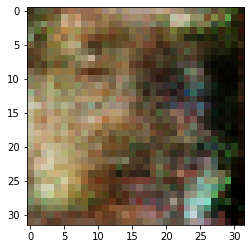

In [21]:
error_d_m3, error_g_m3, prediccion_falsa_m3 = entrenar(gan3, 5000, 150, "resultadosGAN-4/modelo3")

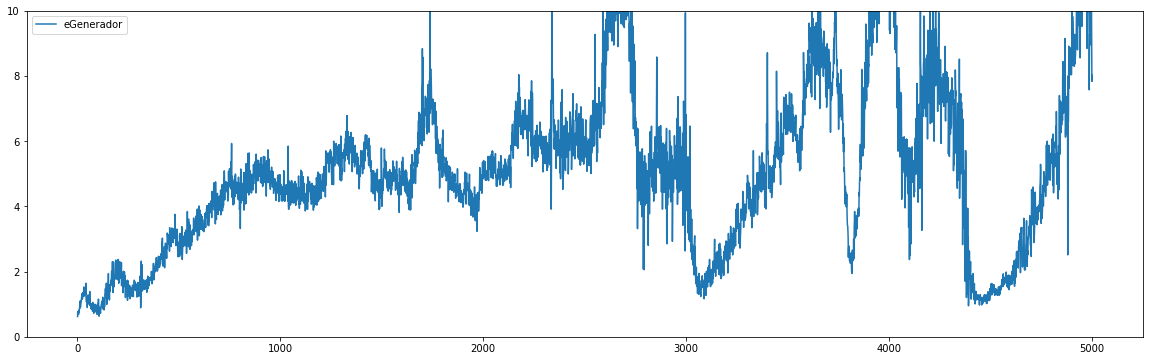

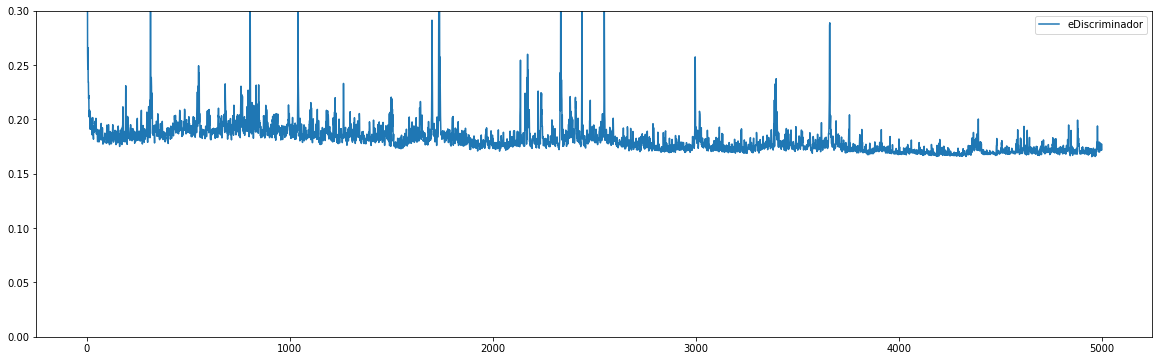

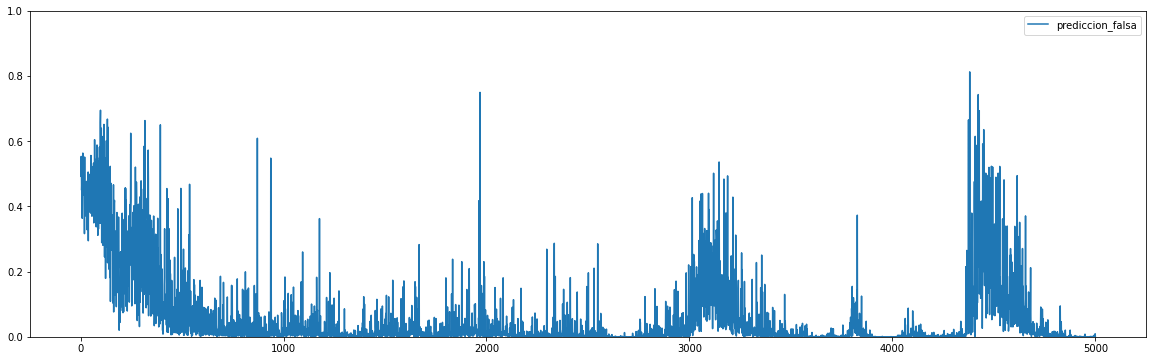

In [22]:
plot_acumulado(len(error_g_m3), 10, eGenerador = error_g_m3)
plot_acumulado(len(error_d_m3), 0.3, eDiscriminador = error_d_m3)
plot_acumulado(len(prediccion_falsa_m3), 1, prediccion_falsa = prediccion_falsa_m3)

Comenzando Epoca 1... Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 76.67m -> 1:16h
prediccion de ruido:  [[0.00025356]]
Comenzando Epoca 2... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 62.41m -> 1:2h
prediccion de ruido:  [[0.0292705]]
Comenzando Epoca 3... Fin
Tiempo transcurrido:  0.82 s
Tiempo restante aprox: 67.96m -> 1:7h
prediccion de ruido:  [[0.00089723]]
Comenzando Epoca 4... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 61.28m -> 1:1h
prediccion de ruido:  [[0.00281951]]
Comenzando Epoca 5... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 65.44m -> 1:5h
prediccion de ruido:  [[0.00030068]]
Comenzando Epoca 6... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 61.32m -> 1:1h
prediccion de ruido:  [[0.01161373]]
Comenzando Epoca 7... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 64.18m -> 1:4h
prediccion de ruido:  [[0.01512375]]
Comenzando Epoca 8... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 59.74m -> 0:

Comenzando Epoca 43... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 61.07m -> 1:1h
prediccion de ruido:  [[0.00872993]]
Comenzando Epoca 44... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 61.8m -> 1:1h
prediccion de ruido:  [[0.00253019]]
Comenzando Epoca 45... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 66.17m -> 1:6h
prediccion de ruido:  [[0.01157519]]
Comenzando Epoca 46... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 61.28m -> 1:1h
prediccion de ruido:  [[0.00505066]]
Comenzando Epoca 47... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 63.83m -> 1:3h
prediccion de ruido:  [[0.00442156]]
Comenzando Epoca 48... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 63.73m -> 1:3h
prediccion de ruido:  [[0.0026601]]
Comenzando Epoca 49... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 64.63m -> 1:4h
prediccion de ruido:  [[0.00139058]]
Comenzando Epoca 50... Fin
Tiempo transcurrido:  0.89 s
Tiempo restante aprox: 73.03m 

Comenzando Epoca 85... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 60.75m -> 1:0h
prediccion de ruido:  [[0.00531492]]
Comenzando Epoca 86... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 61.05m -> 1:1h
prediccion de ruido:  [[0.02346647]]
Comenzando Epoca 87... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 60.03m -> 1:0h
prediccion de ruido:  [[0.00373107]]
Comenzando Epoca 88... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 61.41m -> 1:1h
prediccion de ruido:  [[0.02602121]]
Comenzando Epoca 89... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 65.53m -> 1:5h
prediccion de ruido:  [[0.01245072]]
Comenzando Epoca 90... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 63.52m -> 1:3h
prediccion de ruido:  [[0.02245694]]
Comenzando Epoca 91... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 63.18m -> 1:3h
prediccion de ruido:  [[0.01087341]]
Comenzando Epoca 92... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 59.86

Comenzando Epoca 126... Fin
Tiempo transcurrido:  0.81 s
Tiempo restante aprox: 66.03m -> 1:6h
prediccion de ruido:  [[0.0148119]]
Comenzando Epoca 127... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 61.51m -> 1:1h
prediccion de ruido:  [[0.00322548]]
Comenzando Epoca 128... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 64.64m -> 1:4h
prediccion de ruido:  [[0.0001936]]
Comenzando Epoca 129... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 61.07m -> 1:1h
prediccion de ruido:  [[0.00159463]]
Comenzando Epoca 130... Fin
Tiempo transcurrido:  0.86 s
Tiempo restante aprox: 69.55m -> 1:9h
prediccion de ruido:  [[0.00932363]]
Comenzando Epoca 131... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 61.92m -> 1:1h
prediccion de ruido:  [[0.02123275]]
Comenzando Epoca 132... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 61.82m -> 1:1h
prediccion de ruido:  [[0.00844285]]
Comenzando Epoca 133... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox:

Comenzando Epoca 167... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 63.09m -> 1:3h
prediccion de ruido:  [[0.00922117]]
Comenzando Epoca 168... Fin
Tiempo transcurrido:  0.83 s
Tiempo restante aprox: 66.78m -> 1:6h
prediccion de ruido:  [[0.0027484]]
Comenzando Epoca 169... Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 72.97m -> 1:12h
prediccion de ruido:  [[0.00154141]]
Comenzando Epoca 170... Fin
Tiempo transcurrido:  0.97 s
Tiempo restante aprox: 77.71m -> 1:17h
prediccion de ruido:  [[0.00565183]]
Comenzando Epoca 171... Fin
Tiempo transcurrido:  0.84 s
Tiempo restante aprox: 67.87m -> 1:7h
prediccion de ruido:  [[0.00224721]]
Comenzando Epoca 172... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 62.22m -> 1:2h
prediccion de ruido:  [[0.00833803]]
Comenzando Epoca 173... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 63.01m -> 1:3h
prediccion de ruido:  [[0.0072394]]
Comenzando Epoca 174... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante apr

Comenzando Epoca 208... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 63.75m -> 1:3h
prediccion de ruido:  [[0.00337416]]
Comenzando Epoca 209... Fin
Tiempo transcurrido:  0.83 s
Tiempo restante aprox: 66.62m -> 1:6h
prediccion de ruido:  [[0.00017008]]
Comenzando Epoca 210... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 59.81m -> 0:59h
prediccion de ruido:  [[0.00229138]]
Comenzando Epoca 211... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 59.72m -> 0:59h
prediccion de ruido:  [[0.0002256]]
Comenzando Epoca 212... Fin
Tiempo transcurrido:  0.95 s
Tiempo restante aprox: 75.43m -> 1:15h
prediccion de ruido:  [[0.00094843]]
Comenzando Epoca 213... Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 72.31m -> 1:12h
prediccion de ruido:  [[0.00161815]]
Comenzando Epoca 214... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 62.16m -> 1:2h
prediccion de ruido:  [[0.00742772]]
Comenzando Epoca 215... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante a

Comenzando Epoca 249... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 58.77m -> 0:58h
prediccion de ruido:  [[0.00965881]]
Comenzando Epoca 250... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 58.76m -> 0:58h
prediccion de ruido:  [[0.0008339]]
Comenzando Epoca 251... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 58.03m -> 0:58h
prediccion de ruido:  [[0.00199434]]
Comenzando Epoca 252... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 57.94m -> 0:57h
prediccion de ruido:  [[0.0011653]]
Comenzando Epoca 253... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 58.41m -> 0:58h
prediccion de ruido:  [[0.00036627]]
Comenzando Epoca 254... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 59.58m -> 0:59h
prediccion de ruido:  [[0.0001654]]
Comenzando Epoca 255... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 57.99m -> 0:57h
prediccion de ruido:  [[0.00190365]]
Comenzando Epoca 256... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante

Comenzando Epoca 290... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 59.76m -> 0:59h
prediccion de ruido:  [[0.00046414]]
Comenzando Epoca 291... Fin
Tiempo transcurrido:  0.81 s
Tiempo restante aprox: 63.56m -> 1:3h
prediccion de ruido:  [[0.05922478]]
Comenzando Epoca 292... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 59.1m -> 0:59h
prediccion de ruido:  [[3.9003124e-05]]
Comenzando Epoca 293... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 60.19m -> 1:0h
prediccion de ruido:  [[0.01155916]]
Comenzando Epoca 294... Fin
Tiempo transcurrido:  0.81 s
Tiempo restante aprox: 63.86m -> 1:3h
prediccion de ruido:  [[0.00010016]]
Comenzando Epoca 295... Fin
Tiempo transcurrido:  0.81 s
Tiempo restante aprox: 63.54m -> 1:3h
prediccion de ruido:  [[0.00029966]]
Comenzando Epoca 296... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 61.56m -> 1:1h
prediccion de ruido:  [[3.628432e-05]]
Comenzando Epoca 297... Fin
Tiempo transcurrido:  0.77 s
Tiempo restan

Comenzando Epoca 331... Fin
Tiempo transcurrido:  0.81 s
Tiempo restante aprox: 62.72m -> 1:2h
prediccion de ruido:  [[0.0005199]]
Comenzando Epoca 332... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 61.23m -> 1:1h
prediccion de ruido:  [[6.907392e-08]]
Comenzando Epoca 333... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 58.77m -> 0:58h
prediccion de ruido:  [[0.00118238]]
Comenzando Epoca 334... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 62.51m -> 1:2h
prediccion de ruido:  [[1.7143904e-06]]
Comenzando Epoca 335... Fin
Tiempo transcurrido:  1.05 s
Tiempo restante aprox: 81.51m -> 1:21h
prediccion de ruido:  [[6.7172805e-05]]
Comenzando Epoca 336... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 61.15m -> 1:1h
prediccion de ruido:  [[4.377442e-07]]
Comenzando Epoca 337... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 57.74m -> 0:57h
prediccion de ruido:  [[0.00060698]]
Comenzando Epoca 338... Fin
Tiempo transcurrido:  0.88 s
Tiempo r

Comenzando Epoca 372... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 57.54m -> 0:57h
prediccion de ruido:  [[0.00043657]]
Comenzando Epoca 373... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 59.89m -> 0:59h
prediccion de ruido:  [[1.0305096e-05]]
Comenzando Epoca 374... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 56.88m -> 0:56h
prediccion de ruido:  [[1.0648167e-05]]
Comenzando Epoca 375... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 56.64m -> 0:56h
prediccion de ruido:  [[0.00030503]]
Comenzando Epoca 376... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 57.68m -> 0:57h
prediccion de ruido:  [[5.868151e-06]]
Comenzando Epoca 377... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 56.78m -> 0:56h
prediccion de ruido:  [[9.442636e-08]]
Comenzando Epoca 378... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 57.93m -> 0:57h
prediccion de ruido:  [[0.00012243]]
Comenzando Epoca 379... Fin
Tiempo transcurrido:  0.72 s
Ti

Comenzando Epoca 413... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 57.26m -> 0:57h
prediccion de ruido:  [[1.4836542e-08]]
Comenzando Epoca 414... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 54.86m -> 0:54h
prediccion de ruido:  [[1.5544634e-06]]
Comenzando Epoca 415... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 55.08m -> 0:55h
prediccion de ruido:  [[2.283859e-06]]
Comenzando Epoca 416... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 56.03m -> 0:56h
prediccion de ruido:  [[1.3065137e-08]]
Comenzando Epoca 417... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 56.17m -> 0:56h
prediccion de ruido:  [[8.314688e-10]]
Comenzando Epoca 418... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 54.89m -> 0:54h
prediccion de ruido:  [[7.353547e-06]]
Comenzando Epoca 419... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 55.99m -> 0:55h
prediccion de ruido:  [[0.00012565]]
Comenzando Epoca 420... Fin
Tiempo transcurrido:  0.75

Comenzando Epoca 454... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 55.57m -> 0:55h
prediccion de ruido:  [[0.00025558]]
Comenzando Epoca 455... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 55.55m -> 0:55h
prediccion de ruido:  [[2.0954161e-05]]
Comenzando Epoca 456... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 55.54m -> 0:55h
prediccion de ruido:  [[2.0955747e-08]]
Comenzando Epoca 457... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 55.53m -> 0:55h
prediccion de ruido:  [[3.0043342e-05]]
Comenzando Epoca 458... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 55.52m -> 0:55h
prediccion de ruido:  [[5.1495466e-05]]
Comenzando Epoca 459... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 55.5m -> 0:55h
prediccion de ruido:  [[6.827977e-07]]
Comenzando Epoca 460... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 54.31m -> 0:54h
prediccion de ruido:  [[0.00013033]]
Comenzando Epoca 461... Fin
Tiempo transcurrido:  0.73 s

Comenzando Epoca 495... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 55.82m -> 0:55h
prediccion de ruido:  [[4.012837e-06]]
Comenzando Epoca 496... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 59.06m -> 0:59h
prediccion de ruido:  [[5.06827e-05]]
Comenzando Epoca 497... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 56.51m -> 0:56h
prediccion de ruido:  [[0.00010748]]
Comenzando Epoca 498... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 55.03m -> 0:55h
prediccion de ruido:  [[0.0001547]]
Comenzando Epoca 499... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 53.84m -> 0:53h
prediccion de ruido:  [[1.7569869e-06]]
Comenzando Epoca 500... Fin
Tiempo transcurrido:  0.86 s
Tiempo restante aprox: 64.37m -> 1:4h
prediccion de ruido:  [[2.5541735e-06]]
Comenzando Epoca 501... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 56.16m -> 0:56h
prediccion de ruido:  [[1.7625378e-05]]
Comenzando Epoca 502... Fin
Tiempo transcurrido:  0.78 s
Ti

Comenzando Epoca 536... Fin
Tiempo transcurrido:  0.86 s
Tiempo restante aprox: 64.0m -> 1:3h
prediccion de ruido:  [[2.7529397e-06]]
Comenzando Epoca 537... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 58.17m -> 0:58h
prediccion de ruido:  [[1.8594019e-05]]
Comenzando Epoca 538... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 57.17m -> 0:57h
prediccion de ruido:  [[0.00023067]]
Comenzando Epoca 539... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 54.53m -> 0:54h
prediccion de ruido:  [[0.00330508]]
Comenzando Epoca 540... Fin
Tiempo transcurrido:  0.84 s
Tiempo restante aprox: 62.47m -> 1:2h
prediccion de ruido:  [[0.00015232]]
Comenzando Epoca 541... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 59.69m -> 0:59h
prediccion de ruido:  [[0.0005306]]
Comenzando Epoca 542... Fin
Tiempo transcurrido:  0.81 s
Tiempo restante aprox: 60.44m -> 1:0h
prediccion de ruido:  [[0.0008589]]
Comenzando Epoca 543... Fin
Tiempo transcurrido:  0.83 s
Tiempo restan

Comenzando Epoca 577... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 54.06m -> 0:54h
prediccion de ruido:  [[0.00397459]]
Comenzando Epoca 578... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 54.2m -> 0:54h
prediccion de ruido:  [[0.01436248]]
Comenzando Epoca 579... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 54.04m -> 0:54h
prediccion de ruido:  [[0.00036949]]
Comenzando Epoca 580... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 54.1m -> 0:54h
prediccion de ruido:  [[0.00447795]]
Comenzando Epoca 581... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 54.01m -> 0:54h
prediccion de ruido:  [[0.00022659]]
Comenzando Epoca 582... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 56.71m -> 0:56h
prediccion de ruido:  [[0.00052521]]
Comenzando Epoca 583... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 53.99m -> 0:53h
prediccion de ruido:  [[7.1171446e-05]]
Comenzando Epoca 584... Fin
Tiempo transcurrido:  0.73 s
Tiempo rest

Comenzando Epoca 618... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 52.7m -> 0:52h
prediccion de ruido:  [[0.01370105]]
Comenzando Epoca 619... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 53.99m -> 0:53h
prediccion de ruido:  [[0.03635877]]
Comenzando Epoca 620... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 53.67m -> 0:53h
prediccion de ruido:  [[0.09046838]]
Comenzando Epoca 621... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 52.75m -> 0:52h
prediccion de ruido:  [[0.00641024]]
Comenzando Epoca 622... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 54.87m -> 0:54h
prediccion de ruido:  [[0.00367105]]
Comenzando Epoca 623... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 52.93m -> 0:52h
prediccion de ruido:  [[0.00479171]]
Comenzando Epoca 624... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 53.78m -> 0:53h
prediccion de ruido:  [[0.00901493]]
Comenzando Epoca 625... Fin
Tiempo transcurrido:  0.73 s
Tiempo restan

Comenzando Epoca 659... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 53.2m -> 0:53h
prediccion de ruido:  [[0.04353026]]
Comenzando Epoca 660... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 52.27m -> 0:52h
prediccion de ruido:  [[0.00187248]]
Comenzando Epoca 661... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 58.08m -> 0:58h
prediccion de ruido:  [[0.1816687]]
Comenzando Epoca 662... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 53.31m -> 0:53h
prediccion de ruido:  [[0.02963716]]
Comenzando Epoca 663... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 53.16m -> 0:53h
prediccion de ruido:  [[0.03109717]]
Comenzando Epoca 664... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 53.14m -> 0:53h
prediccion de ruido:  [[0.00178784]]
Comenzando Epoca 665... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 53.38m -> 0:53h
prediccion de ruido:  [[0.01166514]]
Comenzando Epoca 666... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante

Comenzando Epoca 700... Fin
Tiempo transcurrido:  0.84 s
Tiempo restante aprox: 60.53m -> 1:0h
prediccion de ruido:  [[0.30522585]]
Comenzando Epoca 701... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 52.83m -> 0:52h
prediccion de ruido:  [[0.28193444]]
Comenzando Epoca 702... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 55.2m -> 0:55h
prediccion de ruido:  [[0.40175584]]
Comenzando Epoca 703... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 51.69m -> 0:51h
prediccion de ruido:  [[0.10181653]]
Comenzando Epoca 704... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 52.87m -> 0:52h
prediccion de ruido:  [[0.14494511]]
Comenzando Epoca 705... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 52.64m -> 0:52h
prediccion de ruido:  [[0.27736527]]
Comenzando Epoca 706... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 51.8m -> 0:51h
prediccion de ruido:  [[0.12872136]]
Comenzando Epoca 707... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante

Comenzando Epoca 741... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 53.79m -> 0:53h
prediccion de ruido:  [[0.481824]]
Comenzando Epoca 742... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 51.68m -> 0:51h
prediccion de ruido:  [[0.15033802]]
Comenzando Epoca 743... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 53.5m -> 0:53h
prediccion de ruido:  [[0.06560877]]
Comenzando Epoca 744... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 53.01m -> 0:53h
prediccion de ruido:  [[0.09755519]]
Comenzando Epoca 745... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 53.54m -> 0:53h
prediccion de ruido:  [[0.17307094]]
Comenzando Epoca 746... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 52.28m -> 0:52h
prediccion de ruido:  [[0.09688708]]
Comenzando Epoca 747... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 52.98m -> 0:52h
prediccion de ruido:  [[0.53581154]]
Comenzando Epoca 748... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante

Comenzando Epoca 782... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 51.64m -> 0:51h
prediccion de ruido:  [[0.39018294]]
Comenzando Epoca 783... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 52.98m -> 0:52h
prediccion de ruido:  [[0.15121049]]
Comenzando Epoca 784... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 54.36m -> 0:54h
prediccion de ruido:  [[0.17775342]]
Comenzando Epoca 785... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 52.56m -> 0:52h
prediccion de ruido:  [[0.45042604]]
Comenzando Epoca 786... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 51.71m -> 0:51h
prediccion de ruido:  [[0.09061441]]
Comenzando Epoca 787... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 51.58m -> 0:51h
prediccion de ruido:  [[0.21318698]]
Comenzando Epoca 788... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 51.65m -> 0:51h
prediccion de ruido:  [[0.36219382]]
Comenzando Epoca 789... Fin
Tiempo transcurrido:  0.74 s
Tiempo resta

Comenzando Epoca 823... Fin
Tiempo transcurrido:  0.85 s
Tiempo restante aprox: 59.03m -> 0:59h
prediccion de ruido:  [[0.06632268]]
Comenzando Epoca 824... Fin
Tiempo transcurrido:  0.87 s
Tiempo restante aprox: 60.84m -> 1:0h
prediccion de ruido:  [[0.13420054]]
Comenzando Epoca 825... Fin
Tiempo transcurrido:  0.95 s
Tiempo restante aprox: 65.94m -> 1:5h
prediccion de ruido:  [[0.31100354]]
Comenzando Epoca 826... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 54.42m -> 0:54h
prediccion de ruido:  [[0.13889971]]
Comenzando Epoca 827... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 54.95m -> 0:54h
prediccion de ruido:  [[0.45529947]]
Comenzando Epoca 828... Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 64.13m -> 1:4h
prediccion de ruido:  [[0.12333912]]
Comenzando Epoca 829... Fin
Tiempo transcurrido:  0.85 s
Tiempo restante aprox: 59.04m -> 0:59h
prediccion de ruido:  [[0.06492022]]
Comenzando Epoca 830... Fin
Tiempo transcurrido:  0.91 s
Tiempo restante

Comenzando Epoca 864... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 51.85m -> 0:51h
prediccion de ruido:  [[0.11652344]]
Comenzando Epoca 865... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 51.54m -> 0:51h
prediccion de ruido:  [[0.16244236]]
Comenzando Epoca 866... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 52.04m -> 0:52h
prediccion de ruido:  [[0.12736398]]
Comenzando Epoca 867... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 50.85m -> 0:50h
prediccion de ruido:  [[0.11211562]]
Comenzando Epoca 868... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 51.6m -> 0:51h
prediccion de ruido:  [[0.1734334]]
Comenzando Epoca 869... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 52.69m -> 0:52h
prediccion de ruido:  [[0.11813492]]
Comenzando Epoca 870... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 50.68m -> 0:50h
prediccion de ruido:  [[0.11155939]]
Comenzando Epoca 871... Fin
Tiempo transcurrido:  0.81 s
Tiempo restant

Comenzando Epoca 905... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 50.66m -> 0:50h
prediccion de ruido:  [[0.37640077]]
Comenzando Epoca 906... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 51.33m -> 0:51h
prediccion de ruido:  [[0.02734128]]
Comenzando Epoca 907... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 50.98m -> 0:50h
prediccion de ruido:  [[0.05695]]
Comenzando Epoca 908... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 51.24m -> 0:51h
prediccion de ruido:  [[0.17466259]]
Comenzando Epoca 909... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 52.11m -> 0:52h
prediccion de ruido:  [[0.18386227]]
Comenzando Epoca 910... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 50.53m -> 0:50h
prediccion de ruido:  [[0.06004319]]
Comenzando Epoca 911... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 51.54m -> 0:51h
prediccion de ruido:  [[0.04080018]]
Comenzando Epoca 912... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante

Comenzando Epoca 946... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 49.95m -> 0:49h
prediccion de ruido:  [[0.26649505]]
Comenzando Epoca 947... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 50.0m -> 0:50h
prediccion de ruido:  [[0.17178962]]
Comenzando Epoca 948... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 49.99m -> 0:49h
prediccion de ruido:  [[0.05489883]]
Comenzando Epoca 949... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 50.79m -> 0:50h
prediccion de ruido:  [[0.01698405]]
Comenzando Epoca 950... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 49.76m -> 0:49h
prediccion de ruido:  [[0.101291]]
Comenzando Epoca 951... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 50.02m -> 0:50h
prediccion de ruido:  [[0.03208247]]
Comenzando Epoca 952... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 49.81m -> 0:49h
prediccion de ruido:  [[0.008219]]
Comenzando Epoca 953... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante a

Comenzando Epoca 987... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 49.38m -> 0:49h
prediccion de ruido:  [[0.00149608]]
Comenzando Epoca 988... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 50.23m -> 0:50h
prediccion de ruido:  [[0.01756191]]
Comenzando Epoca 989... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 49.75m -> 0:49h
prediccion de ruido:  [[0.00100893]]
Comenzando Epoca 990... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 50.48m -> 0:50h
prediccion de ruido:  [[0.00621492]]
Comenzando Epoca 991... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 50.06m -> 0:50h
prediccion de ruido:  [[0.00096136]]
Comenzando Epoca 992... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 50.32m -> 0:50h
prediccion de ruido:  [[0.00863665]]
Comenzando Epoca 993... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 50.17m -> 0:50h
prediccion de ruido:  [[0.0005863]]
Comenzando Epoca 994... Fin
Tiempo transcurrido:  0.75 s
Tiempo restan

Comenzando Epoca 1028... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 48.74m -> 0:48h
prediccion de ruido:  [[0.00051218]]
Comenzando Epoca 1029... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 49.13m -> 0:49h
prediccion de ruido:  [[0.00222114]]
Comenzando Epoca 1030... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 49.25m -> 0:49h
prediccion de ruido:  [[4.43167e-05]]
Comenzando Epoca 1031... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 49.76m -> 0:49h
prediccion de ruido:  [[2.399908e-05]]
Comenzando Epoca 1032... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 49.35m -> 0:49h
prediccion de ruido:  [[6.449481e-05]]
Comenzando Epoca 1033... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 49.21m -> 0:49h
prediccion de ruido:  [[0.00060359]]
Comenzando Epoca 1034... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 49.2m -> 0:49h
prediccion de ruido:  [[0.00141495]]
Comenzando Epoca 1035... Fin
Tiempo transcurrido:  0.76 s


Comenzando Epoca 1069... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 48.7m -> 0:48h
prediccion de ruido:  [[8.644597e-06]]
Comenzando Epoca 1070... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 49.08m -> 0:49h
prediccion de ruido:  [[1.054441e-06]]
Comenzando Epoca 1071... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 49.39m -> 0:49h
prediccion de ruido:  [[0.00022522]]
Comenzando Epoca 1072... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 49.18m -> 0:49h
prediccion de ruido:  [[3.4312834e-05]]
Comenzando Epoca 1073... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 49.3m -> 0:49h
prediccion de ruido:  [[2.033129e-05]]
Comenzando Epoca 1074... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 48.83m -> 0:48h
prediccion de ruido:  [[0.0008544]]
Comenzando Epoca 1075... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 48.95m -> 0:48h
prediccion de ruido:  [[0.00014323]]
Comenzando Epoca 1076... Fin
Tiempo transcurrido:  0.75 

Comenzando Epoca 1110... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 47.73m -> 0:47h
prediccion de ruido:  [[3.3138444e-05]]
Comenzando Epoca 1111... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 47.53m -> 0:47h
prediccion de ruido:  [[9.631461e-07]]
Comenzando Epoca 1112... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 48.81m -> 0:48h
prediccion de ruido:  [[3.3024e-06]]
Comenzando Epoca 1113... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 47.63m -> 0:47h
prediccion de ruido:  [[4.453536e-05]]
Comenzando Epoca 1114... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 47.49m -> 0:47h
prediccion de ruido:  [[5.3030097e-10]]
Comenzando Epoca 1115... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 47.93m -> 0:47h
prediccion de ruido:  [[3.3131806e-07]]
Comenzando Epoca 1116... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 47.98m -> 0:47h
prediccion de ruido:  [[1.9938475e-06]]
Comenzando Epoca 1117... Fin
Tiempo transcurri

Comenzando Epoca 1190... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 46.69m -> 0:46h
prediccion de ruido:  [[1.09778435e-08]]
Comenzando Epoca 1191... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 47.69m -> 0:47h
prediccion de ruido:  [[1.1847103e-06]]
Comenzando Epoca 1192... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 46.22m -> 0:46h
prediccion de ruido:  [[9.914852e-06]]
Comenzando Epoca 1193... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 46.97m -> 0:46h
prediccion de ruido:  [[2.8188906e-06]]
Comenzando Epoca 1194... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 47.21m -> 0:47h
prediccion de ruido:  [[7.957225e-06]]
Comenzando Epoca 1195... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 46.5m -> 0:46h
prediccion de ruido:  [[7.053523e-08]]
Comenzando Epoca 1196... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 47.44m -> 0:47h
prediccion de ruido:  [[5.3061317e-06]]
Comenzando Epoca 1197... Fin
Tiempo transcur

Comenzando Epoca 1271... Fin
Tiempo transcurrido:  0.81 s
Tiempo restante aprox: 50.48m -> 0:50h
prediccion de ruido:  [[0.00060546]]
Comenzando Epoca 1272... Fin
Tiempo transcurrido:  0.81 s
Tiempo restante aprox: 50.16m -> 0:50h
prediccion de ruido:  [[0.0131855]]
Comenzando Epoca 1273... Fin
Tiempo transcurrido:  0.81 s
Tiempo restante aprox: 50.52m -> 0:50h
prediccion de ruido:  [[0.00073612]]
Comenzando Epoca 1274... Fin
Tiempo transcurrido:  0.81 s
Tiempo restante aprox: 50.07m -> 0:50h
prediccion de ruido:  [[0.06100592]]
Comenzando Epoca 1275... Fin
Tiempo transcurrido:  0.83 s
Tiempo restante aprox: 51.24m -> 0:51h
prediccion de ruido:  [[0.13944834]]
Comenzando Epoca 1276... Fin
Tiempo transcurrido:  0.82 s
Tiempo restante aprox: 50.73m -> 0:50h
prediccion de ruido:  [[0.01362967]]
Comenzando Epoca 1277... Fin
Tiempo transcurrido:  0.87 s
Tiempo restante aprox: 53.69m -> 0:53h
prediccion de ruido:  [[1.1043889e-05]]
Comenzando Epoca 1278... Fin
Tiempo transcurrido:  0.9 s
Tie

Comenzando Epoca 1312... Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 57.49m -> 0:57h
prediccion de ruido:  [[0.11084527]]
Comenzando Epoca 1313... Fin
Tiempo transcurrido:  0.89 s
Tiempo restante aprox: 54.61m -> 0:54h
prediccion de ruido:  [[0.01440239]]
Comenzando Epoca 1314... Fin
Tiempo transcurrido:  0.83 s
Tiempo restante aprox: 50.96m -> 0:50h
prediccion de ruido:  [[0.02254692]]
Comenzando Epoca 1315... Fin
Tiempo transcurrido:  0.85 s
Tiempo restante aprox: 52.48m -> 0:52h
prediccion de ruido:  [[0.00085533]]
Comenzando Epoca 1316... Fin
Tiempo transcurrido:  0.86 s
Tiempo restante aprox: 53.02m -> 0:53h
prediccion de ruido:  [[0.0351119]]
Comenzando Epoca 1317... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 48.97m -> 0:48h
prediccion de ruido:  [[0.00264078]]
Comenzando Epoca 1318... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 48.96m -> 0:48h
prediccion de ruido:  [[0.01561797]]
Comenzando Epoca 1319... Fin
Tiempo transcurrido:  0.78 s
Tiempo 

Comenzando Epoca 1353... Fin
Tiempo transcurrido:  0.86 s
Tiempo restante aprox: 52.17m -> 0:52h
prediccion de ruido:  [[0.16758314]]
Comenzando Epoca 1354... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 48.68m -> 0:48h
prediccion de ruido:  [[0.1417875]]
Comenzando Epoca 1355... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 48.8m -> 0:48h
prediccion de ruido:  [[0.03034034]]
Comenzando Epoca 1356... Fin
Tiempo transcurrido:  0.87 s
Tiempo restante aprox: 52.83m -> 0:52h
prediccion de ruido:  [[0.07645524]]
Comenzando Epoca 1357... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 44.06m -> 0:44h
prediccion de ruido:  [[0.01405013]]
Comenzando Epoca 1358... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 46.72m -> 0:46h
prediccion de ruido:  [[0.08419344]]
Comenzando Epoca 1359... Fin
Tiempo transcurrido:  0.71 s
Tiempo restante aprox: 43.24m -> 0:43h
prediccion de ruido:  [[0.09257501]]
Comenzando Epoca 1360... Fin
Tiempo transcurrido:  0.77 s
Tiempo r

Comenzando Epoca 1394... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 47.5m -> 0:47h
prediccion de ruido:  [[0.02577141]]
Comenzando Epoca 1395... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 43.53m -> 0:43h
prediccion de ruido:  [[0.05029246]]
Comenzando Epoca 1396... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 44.84m -> 0:44h
prediccion de ruido:  [[0.09678739]]
Comenzando Epoca 1397... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 46.91m -> 0:46h
prediccion de ruido:  [[0.04081759]]
Comenzando Epoca 1398... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 44.03m -> 0:44h
prediccion de ruido:  [[0.03004551]]
Comenzando Epoca 1399... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 43.08m -> 0:43h
prediccion de ruido:  [[0.04459682]]
Comenzando Epoca 1400... Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 54.37m -> 0:54h
prediccion de ruido:  [[0.08449712]]
Comenzando Epoca 1401... Fin
Tiempo transcurrido:  0.73 s
Tiemp

Comenzando Epoca 1435... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 42.69m -> 0:42h
prediccion de ruido:  [[0.01497456]]
Comenzando Epoca 1436... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 44.12m -> 0:44h
prediccion de ruido:  [[0.01223025]]
Comenzando Epoca 1437... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 43.55m -> 0:43h
prediccion de ruido:  [[0.03241768]]
Comenzando Epoca 1438... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 43.54m -> 0:43h
prediccion de ruido:  [[0.11303151]]
Comenzando Epoca 1439... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 42.6m -> 0:42h
prediccion de ruido:  [[0.03025624]]
Comenzando Epoca 1440... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 43.52m -> 0:43h
prediccion de ruido:  [[0.2999391]]
Comenzando Epoca 1441... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 44.13m -> 0:44h
prediccion de ruido:  [[0.0764862]]
Comenzando Epoca 1442... Fin
Tiempo transcurrido:  0.78 s
Tiempo 

Comenzando Epoca 1476... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 42.16m -> 0:42h
prediccion de ruido:  [[0.08437526]]
Comenzando Epoca 1477... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 44.04m -> 0:44h
prediccion de ruido:  [[0.01140061]]
Comenzando Epoca 1478... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 45.54m -> 0:45h
prediccion de ruido:  [[0.01551533]]
Comenzando Epoca 1479... Fin
Tiempo transcurrido:  0.84 s
Tiempo restante aprox: 49.08m -> 0:49h
prediccion de ruido:  [[0.00970042]]
Comenzando Epoca 1480... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 44.47m -> 0:44h
prediccion de ruido:  [[0.11008728]]
Comenzando Epoca 1481... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 42.84m -> 0:42h
prediccion de ruido:  [[0.03507939]]
Comenzando Epoca 1482... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 43.59m -> 0:43h
prediccion de ruido:  [[0.00379789]]
Comenzando Epoca 1483... Fin
Tiempo transcurrido:  0.75 s
Tiem

Comenzando Epoca 1517... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 44.38m -> 0:44h
prediccion de ruido:  [[0.00598359]]
Comenzando Epoca 1518... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 42.32m -> 0:42h
prediccion de ruido:  [[0.00497091]]
Comenzando Epoca 1519... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 43.34m -> 0:43h
prediccion de ruido:  [[0.00621742]]
Comenzando Epoca 1520... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 42.54m -> 0:42h
prediccion de ruido:  [[0.00703013]]
Comenzando Epoca 1521... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 41.62m -> 0:41h
prediccion de ruido:  [[0.01160014]]
Comenzando Epoca 1522... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 42.55m -> 0:42h
prediccion de ruido:  [[0.08311126]]
Comenzando Epoca 1523... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 41.95m -> 0:41h
prediccion de ruido:  [[0.00128591]]
Comenzando Epoca 1524... Fin
Tiempo transcurrido:  0.73 s
Tiem

Comenzando Epoca 1558... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 42.07m -> 0:42h
prediccion de ruido:  [[0.00912133]]
Comenzando Epoca 1559... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 42.06m -> 0:42h
prediccion de ruido:  [[0.01134413]]
Comenzando Epoca 1560... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 41.16m -> 0:41h
prediccion de ruido:  [[0.0018495]]
Comenzando Epoca 1561... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 42.04m -> 0:42h
prediccion de ruido:  [[0.0041759]]
Comenzando Epoca 1562... Fin
Tiempo transcurrido:  0.71 s
Tiempo restante aprox: 40.75m -> 0:40h
prediccion de ruido:  [[0.01268992]]
Comenzando Epoca 1563... Fin
Tiempo transcurrido:  0.81 s
Tiempo restante aprox: 46.26m -> 0:46h
prediccion de ruido:  [[0.00040686]]
Comenzando Epoca 1564... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 41.5m -> 0:41h
prediccion de ruido:  [[0.00024793]]
Comenzando Epoca 1565... Fin
Tiempo transcurrido:  0.81 s
Tiempo 

Comenzando Epoca 1599... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 40.92m -> 0:40h
prediccion de ruido:  [[1.6564718e-08]]
Comenzando Epoca 1600... Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 51.56m -> 0:51h
prediccion de ruido:  [[0.00106749]]
Comenzando Epoca 1601... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 42.72m -> 0:42h
prediccion de ruido:  [[1.4398164e-05]]
Comenzando Epoca 1602... Fin
Tiempo transcurrido:  0.81 s
Tiempo restante aprox: 45.79m -> 0:45h
prediccion de ruido:  [[3.82067e-05]]
Comenzando Epoca 1603... Fin
Tiempo transcurrido:  0.83 s
Tiempo restante aprox: 47.13m -> 0:47h
prediccion de ruido:  [[0.0001026]]
Comenzando Epoca 1604... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 44.88m -> 0:44h
prediccion de ruido:  [[7.4971926e-05]]
Comenzando Epoca 1605... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 40.54m -> 0:40h
prediccion de ruido:  [[5.514697e-07]]
Comenzando Epoca 1606... Fin
Tiempo transcurrido:  

Comenzando Epoca 1640... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 41.95m -> 0:41h
prediccion de ruido:  [[2.6082425e-05]]
Comenzando Epoca 1641... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 40.35m -> 0:40h
prediccion de ruido:  [[0.00045583]]
Comenzando Epoca 1642... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 42.85m -> 0:42h
prediccion de ruido:  [[0.00123531]]
Comenzando Epoca 1643... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 44.64m -> 0:44h
prediccion de ruido:  [[5.2756077e-05]]
Comenzando Epoca 1644... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 42.77m -> 0:42h
prediccion de ruido:  [[5.2795787e-07]]
Comenzando Epoca 1645... Fin
Tiempo transcurrido:  0.87 s
Tiempo restante aprox: 48.92m -> 0:48h
prediccion de ruido:  [[2.1460608e-07]]
Comenzando Epoca 1646... Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 51.58m -> 0:51h
prediccion de ruido:  [[6.925568e-05]]
Comenzando Epoca 1647... Fin
Tiempo transcurrido:

Comenzando Epoca 1681... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 40.68m -> 0:40h
prediccion de ruido:  [[0.00356776]]
Comenzando Epoca 1682... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 40.56m -> 0:40h
prediccion de ruido:  [[0.00059992]]
Comenzando Epoca 1683... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 41.41m -> 0:41h
prediccion de ruido:  [[0.00296074]]
Comenzando Epoca 1684... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 40.53m -> 0:40h
prediccion de ruido:  [[0.00147074]]
Comenzando Epoca 1685... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 41.38m -> 0:41h
prediccion de ruido:  [[0.00568312]]
Comenzando Epoca 1686... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 40.51m -> 0:40h
prediccion de ruido:  [[0.00137624]]
Comenzando Epoca 1687... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 40.5m -> 0:40h
prediccion de ruido:  [[0.00023913]]
Comenzando Epoca 1688... Fin
Tiempo transcurrido:  0.73 s
Tiemp

Comenzando Epoca 1722... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 40.07m -> 0:40h
prediccion de ruido:  [[0.00046325]]
Comenzando Epoca 1723... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 40.06m -> 0:40h
prediccion de ruido:  [[0.00130409]]
Comenzando Epoca 1724... Fin
Tiempo transcurrido:  0.81 s
Tiempo restante aprox: 44.31m -> 0:44h
prediccion de ruido:  [[0.00878432]]
Comenzando Epoca 1725... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 40.14m -> 0:40h
prediccion de ruido:  [[0.0033789]]
Comenzando Epoca 1726... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 40.87m -> 0:40h
prediccion de ruido:  [[0.02585286]]
Comenzando Epoca 1727... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 40.06m -> 0:40h
prediccion de ruido:  [[0.00728369]]
Comenzando Epoca 1728... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 40.11m -> 0:40h
prediccion de ruido:  [[0.01074117]]
Comenzando Epoca 1729... Fin
Tiempo transcurrido:  0.74 s
Tiemp

Comenzando Epoca 1763... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 40.41m -> 0:40h
prediccion de ruido:  [[0.00808734]]
Comenzando Epoca 1764... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 40.4m -> 0:40h
prediccion de ruido:  [[0.00358257]]
Comenzando Epoca 1765... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 39.62m -> 0:39h
prediccion de ruido:  [[0.00505051]]
Comenzando Epoca 1766... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 43.22m -> 0:43h
prediccion de ruido:  [[0.0001547]]
Comenzando Epoca 1767... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 38.73m -> 0:38h
prediccion de ruido:  [[0.00085595]]
Comenzando Epoca 1768... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 40.35m -> 0:40h
prediccion de ruido:  [[0.0002349]]
Comenzando Epoca 1769... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 39.55m -> 0:39h
prediccion de ruido:  [[0.00025609]]
Comenzando Epoca 1770... Fin
Tiempo transcurrido:  0.75 s
Tiempo r

Comenzando Epoca 1804... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 40.73m -> 0:40h
prediccion de ruido:  [[0.00071335]]
Comenzando Epoca 1805... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 39.06m -> 0:39h
prediccion de ruido:  [[0.00030804]]
Comenzando Epoca 1806... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 41.54m -> 0:41h
prediccion de ruido:  [[0.00635204]]
Comenzando Epoca 1807... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 39.03m -> 0:39h
prediccion de ruido:  [[0.01441059]]
Comenzando Epoca 1808... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 40.68m -> 0:40h
prediccion de ruido:  [[0.00104955]]
Comenzando Epoca 1809... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 39.01m -> 0:39h
prediccion de ruido:  [[0.01030159]]
Comenzando Epoca 1810... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 39.82m -> 0:39h
prediccion de ruido:  [[8.1733124e-05]]
Comenzando Epoca 1811... Fin
Tiempo transcurrido:  0.73 s
T

Comenzando Epoca 1845... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 39.39m -> 0:39h
prediccion de ruido:  [[0.00790733]]
Comenzando Epoca 1846... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 38.55m -> 0:38h
prediccion de ruido:  [[0.00077224]]
Comenzando Epoca 1847... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 38.54m -> 0:38h
prediccion de ruido:  [[0.00622612]]
Comenzando Epoca 1848... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 38.58m -> 0:38h
prediccion de ruido:  [[0.00149563]]
Comenzando Epoca 1849... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 39.34m -> 0:39h
prediccion de ruido:  [[0.00029081]]
Comenzando Epoca 1850... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 38.51m -> 0:38h
prediccion de ruido:  [[6.5701846e-05]]
Comenzando Epoca 1851... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 38.49m -> 0:38h
prediccion de ruido:  [[0.00018173]]
Comenzando Epoca 1852... Fin
Tiempo transcurrido:  0.73 s
T

Comenzando Epoca 1886... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 39.79m -> 0:39h
prediccion de ruido:  [[0.01335803]]
Comenzando Epoca 1887... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 38.05m -> 0:38h
prediccion de ruido:  [[0.00271553]]
Comenzando Epoca 1888... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 38.15m -> 0:38h
prediccion de ruido:  [[0.00030375]]
Comenzando Epoca 1889... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 37.5m -> 0:37h
prediccion de ruido:  [[0.00406447]]
Comenzando Epoca 1890... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 38.83m -> 0:38h
prediccion de ruido:  [[0.00047076]]
Comenzando Epoca 1891... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 38.81m -> 0:38h
prediccion de ruido:  [[0.00100577]]
Comenzando Epoca 1892... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 37.99m -> 0:37h
prediccion de ruido:  [[0.00255302]]
Comenzando Epoca 1893... Fin
Tiempo transcurrido:  0.76 s
Tiemp

Comenzando Epoca 1927... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 37.56m -> 0:37h
prediccion de ruido:  [[0.00148761]]
Comenzando Epoca 1928... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 40.8m -> 0:40h
prediccion de ruido:  [[0.00078568]]
Comenzando Epoca 1929... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 37.79m -> 0:37h
prediccion de ruido:  [[0.00607762]]
Comenzando Epoca 1930... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 40.39m -> 0:40h
prediccion de ruido:  [[0.00322741]]
Comenzando Epoca 1931... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 39.11m -> 0:39h
prediccion de ruido:  [[0.0005666]]
Comenzando Epoca 1932... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 39.1m -> 0:39h
prediccion de ruido:  [[0.01774535]]
Comenzando Epoca 1933... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 39.88m -> 0:39h
prediccion de ruido:  [[0.00328112]]
Comenzando Epoca 1934... Fin
Tiempo transcurrido:  0.76 s
Tiempo r

Comenzando Epoca 1968... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 37.33m -> 0:37h
prediccion de ruido:  [[0.01293084]]
Comenzando Epoca 1969... Fin
Tiempo transcurrido:  0.95 s
Tiempo restante aprox: 48.16m -> 0:48h
prediccion de ruido:  [[0.00459683]]
Comenzando Epoca 1970... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 37.92m -> 0:37h
prediccion de ruido:  [[0.00032869]]
Comenzando Epoca 1971... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 37.18m -> 0:37h
prediccion de ruido:  [[0.01536834]]
Comenzando Epoca 1972... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 37.19m -> 0:37h
prediccion de ruido:  [[0.023949]]
Comenzando Epoca 1973... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 37.88m -> 0:37h
prediccion de ruido:  [[0.00642467]]
Comenzando Epoca 1974... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 37.16m -> 0:37h
prediccion de ruido:  [[0.00026333]]
Comenzando Epoca 1975... Fin
Tiempo transcurrido:  0.74 s
Tiempo

Comenzando Epoca 2009... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 36.8m -> 0:36h
prediccion de ruido:  [[0.00554195]]
Comenzando Epoca 2010... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 36.6m -> 0:36h
prediccion de ruido:  [[0.02201161]]
Comenzando Epoca 2011... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 36.67m -> 0:36h
prediccion de ruido:  [[0.00776964]]
Comenzando Epoca 2012... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 36.68m -> 0:36h
prediccion de ruido:  [[0.00690192]]
Comenzando Epoca 2013... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 36.64m -> 0:36h
prediccion de ruido:  [[0.00160307]]
Comenzando Epoca 2014... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 36.63m -> 0:36h
prediccion de ruido:  [[0.00182894]]
Comenzando Epoca 2015... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 36.62m -> 0:36h
prediccion de ruido:  [[0.05156264]]
Comenzando Epoca 2016... Fin
Tiempo transcurrido:  0.75 s
Tiempo

Comenzando Epoca 2050... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 36.06m -> 0:36h
prediccion de ruido:  [[0.00184509]]
Comenzando Epoca 2051... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 36.05m -> 0:36h
prediccion de ruido:  [[0.01487425]]
Comenzando Epoca 2052... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 35.27m -> 0:35h
prediccion de ruido:  [[0.00037566]]
Comenzando Epoca 2053... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 36.79m -> 0:36h
prediccion de ruido:  [[0.00765038]]
Comenzando Epoca 2054... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 35.25m -> 0:35h
prediccion de ruido:  [[0.00445369]]
Comenzando Epoca 2055... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 36.0m -> 0:36h
prediccion de ruido:  [[0.00265816]]
Comenzando Epoca 2056... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 35.99m -> 0:35h
prediccion de ruido:  [[0.0034934]]
Comenzando Epoca 2057... Fin
Tiempo transcurrido:  0.72 s
Tiempo

Comenzando Epoca 2091... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 36.37m -> 0:36h
prediccion de ruido:  [[0.00156295]]
Comenzando Epoca 2092... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 36.3m -> 0:36h
prediccion de ruido:  [[0.03380838]]
Comenzando Epoca 2093... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 36.39m -> 0:36h
prediccion de ruido:  [[0.01779312]]
Comenzando Epoca 2094... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 35.52m -> 0:35h
prediccion de ruido:  [[0.00117055]]
Comenzando Epoca 2095... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 35.51m -> 0:35h
prediccion de ruido:  [[0.00088707]]
Comenzando Epoca 2096... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 36.25m -> 0:36h
prediccion de ruido:  [[0.03734857]]
Comenzando Epoca 2097... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 35.49m -> 0:35h
prediccion de ruido:  [[0.00518894]]
Comenzando Epoca 2098... Fin
Tiempo transcurrido:  0.73 s
Tiemp

Comenzando Epoca 2132... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 36.55m -> 0:36h
prediccion de ruido:  [[2.0905498e-05]]
Comenzando Epoca 2133... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 34.3m -> 0:34h
prediccion de ruido:  [[0.00014827]]
Comenzando Epoca 2134... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 35.78m -> 0:35h
prediccion de ruido:  [[0.05743679]]
Comenzando Epoca 2135... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 36.51m -> 0:36h
prediccion de ruido:  [[0.00019524]]
Comenzando Epoca 2136... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 36.5m -> 0:36h
prediccion de ruido:  [[0.00084186]]
Comenzando Epoca 2137... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 37.98m -> 0:37h
prediccion de ruido:  [[0.004103]]
Comenzando Epoca 2138... Fin
Tiempo transcurrido:  0.81 s
Tiempo restante aprox: 38.71m -> 0:38h
prediccion de ruido:  [[0.00359383]]
Comenzando Epoca 2139... Fin
Tiempo transcurrido:  0.78 s
Tiempo

Comenzando Epoca 2173... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 35.29m -> 0:35h
prediccion de ruido:  [[0.00119656]]
Comenzando Epoca 2174... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 34.55m -> 0:34h
prediccion de ruido:  [[0.00037202]]
Comenzando Epoca 2175... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 34.53m -> 0:34h
prediccion de ruido:  [[0.00083748]]
Comenzando Epoca 2176... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 35.26m -> 0:35h
prediccion de ruido:  [[0.00014505]]
Comenzando Epoca 2177... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 34.51m -> 0:34h
prediccion de ruido:  [[0.00222567]]
Comenzando Epoca 2178... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 34.5m -> 0:34h
prediccion de ruido:  [[0.00275448]]
Comenzando Epoca 2179... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 34.49m -> 0:34h
prediccion de ruido:  [[0.001232]]
Comenzando Epoca 2180... Fin
Tiempo transcurrido:  0.73 s
Tiempo 

Comenzando Epoca 2214... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 34.78m -> 0:34h
prediccion de ruido:  [[4.455397e-05]]
Comenzando Epoca 2215... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 34.05m -> 0:34h
prediccion de ruido:  [[0.00261334]]
Comenzando Epoca 2216... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 34.76m -> 0:34h
prediccion de ruido:  [[0.00033703]]
Comenzando Epoca 2217... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 33.3m -> 0:33h
prediccion de ruido:  [[0.01074368]]
Comenzando Epoca 2218... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 34.01m -> 0:34h
prediccion de ruido:  [[0.00015575]]
Comenzando Epoca 2219... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 34.72m -> 0:34h
prediccion de ruido:  [[3.708404e-05]]
Comenzando Epoca 2220... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 34.71m -> 0:34h
prediccion de ruido:  [[0.01725367]]
Comenzando Epoca 2221... Fin
Tiempo transcurrido:  0.76 s
T

Comenzando Epoca 2255... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 33.56m -> 0:33h
prediccion de ruido:  [[0.00154915]]
Comenzando Epoca 2256... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 34.97m -> 0:34h
prediccion de ruido:  [[0.00139242]]
Comenzando Epoca 2257... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 33.53m -> 0:33h
prediccion de ruido:  [[9.571613e-05]]
Comenzando Epoca 2258... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 34.23m -> 0:34h
prediccion de ruido:  [[0.00088015]]
Comenzando Epoca 2259... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 33.51m -> 0:33h
prediccion de ruido:  [[0.0074909]]
Comenzando Epoca 2260... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 33.54m -> 0:33h
prediccion de ruido:  [[0.00448751]]
Comenzando Epoca 2261... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 34.2m -> 0:34h
prediccion de ruido:  [[0.00065485]]
Comenzando Epoca 2262... Fin
Tiempo transcurrido:  0.73 s
Tiem

Comenzando Epoca 2296... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 33.06m -> 0:33h
prediccion de ruido:  [[0.00055906]]
Comenzando Epoca 2297... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 33.04m -> 0:33h
prediccion de ruido:  [[4.942937e-07]]
Comenzando Epoca 2298... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 35.14m -> 0:35h
prediccion de ruido:  [[0.00258178]]
Comenzando Epoca 2299... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 34.42m -> 0:34h
prediccion de ruido:  [[1.185402e-06]]
Comenzando Epoca 2300... Fin
Tiempo transcurrido:  0.98 s
Tiempo restante aprox: 44.24m -> 0:44h
prediccion de ruido:  [[6.8252295e-05]]
Comenzando Epoca 2301... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 32.99m -> 0:32h
prediccion de ruido:  [[8.581464e-08]]
Comenzando Epoca 2302... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 35.09m -> 0:35h
prediccion de ruido:  [[7.719927e-06]]
Comenzando Epoca 2303... Fin
Tiempo transcurrido:  

Comenzando Epoca 2337... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 32.55m -> 0:32h
prediccion de ruido:  [[4.941797e-05]]
Comenzando Epoca 2338... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 31.85m -> 0:31h
prediccion de ruido:  [[0.00020474]]
Comenzando Epoca 2339... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 32.53m -> 0:32h
prediccion de ruido:  [[3.816662e-08]]
Comenzando Epoca 2340... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 32.52m -> 0:32h
prediccion de ruido:  [[1.3118032e-05]]
Comenzando Epoca 2341... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 31.81m -> 0:31h
prediccion de ruido:  [[0.0002853]]
Comenzando Epoca 2342... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 32.49m -> 0:32h
prediccion de ruido:  [[2.3769787e-06]]
Comenzando Epoca 2343... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 31.88m -> 0:31h
prediccion de ruido:  [[0.00031674]]
Comenzando Epoca 2344... Fin
Tiempo transcurrido:  0.

Comenzando Epoca 2378... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 32.05m -> 0:32h
prediccion de ruido:  [[2.0290215e-06]]
Comenzando Epoca 2379... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 32.04m -> 0:32h
prediccion de ruido:  [[1.5301215e-06]]
Comenzando Epoca 2380... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 31.35m -> 0:31h
prediccion de ruido:  [[2.2874105e-09]]
Comenzando Epoca 2381... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 31.33m -> 0:31h
prediccion de ruido:  [[2.6119626e-06]]
Comenzando Epoca 2382... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 32.05m -> 0:32h
prediccion de ruido:  [[5.1234156e-06]]
Comenzando Epoca 2383... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 31.99m -> 0:31h
prediccion de ruido:  [[1.5266212e-05]]
Comenzando Epoca 2384... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 31.3m -> 0:31h
prediccion de ruido:  [[5.523211e-06]]
Comenzando Epoca 2385... Fin
Tiempo transcu

Comenzando Epoca 2459... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 31.06m -> 0:31h
prediccion de ruido:  [[1.8038292e-05]]
Comenzando Epoca 2460... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 31.14m -> 0:31h
prediccion de ruido:  [[4.081338e-05]]
Comenzando Epoca 2461... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 31.12m -> 0:31h
prediccion de ruido:  [[4.3990635e-06]]
Comenzando Epoca 2462... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 30.37m -> 0:30h
prediccion de ruido:  [[7.394882e-05]]
Comenzando Epoca 2463... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 31.67m -> 0:31h
prediccion de ruido:  [[9.783522e-06]]
Comenzando Epoca 2464... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 31.09m -> 0:31h
prediccion de ruido:  [[8.079827e-06]]
Comenzando Epoca 2465... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 30.99m -> 0:30h
prediccion de ruido:  [[3.552518e-05]]
Comenzando Epoca 2466... Fin
Tiempo transcurri

Comenzando Epoca 2500... Fin
Tiempo transcurrido:  0.95 s
Tiempo restante aprox: 39.67m -> 0:39h
prediccion de ruido:  [[0.00054973]]
Comenzando Epoca 2501... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 30.55m -> 0:30h
prediccion de ruido:  [[0.00015345]]
Comenzando Epoca 2502... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 32.49m -> 0:32h
prediccion de ruido:  [[3.6281483e-05]]
Comenzando Epoca 2503... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 29.88m -> 0:29h
prediccion de ruido:  [[7.639624e-05]]
Comenzando Epoca 2504... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 30.51m -> 0:30h
prediccion de ruido:  [[0.00010974]]
Comenzando Epoca 2505... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 30.5m -> 0:30h
prediccion de ruido:  [[0.00012505]]
Comenzando Epoca 2506... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 30.49m -> 0:30h
prediccion de ruido:  [[2.8374077e-05]]
Comenzando Epoca 2507... Fin
Tiempo transcurrido:  0.73

Comenzando Epoca 2541... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 30.14m -> 0:30h
prediccion de ruido:  [[0.00017944]]
Comenzando Epoca 2542... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 30.05m -> 0:30h
prediccion de ruido:  [[7.5552583e-07]]
Comenzando Epoca 2543... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 29.4m -> 0:29h
prediccion de ruido:  [[0.00084627]]
Comenzando Epoca 2544... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 30.02m -> 0:30h
prediccion de ruido:  [[0.0083563]]
Comenzando Epoca 2545... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 30.69m -> 0:30h
prediccion de ruido:  [[0.00012711]]
Comenzando Epoca 2546... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 30.0m -> 0:29h
prediccion de ruido:  [[0.00020459]]
Comenzando Epoca 2547... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 29.99m -> 0:29h
prediccion de ruido:  [[0.00035477]]
Comenzando Epoca 2548... Fin
Tiempo transcurrido:  0.73 s
Tiem

Comenzando Epoca 2582... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 28.93m -> 0:28h
prediccion de ruido:  [[0.00087321]]
Comenzando Epoca 2583... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 29.55m -> 0:29h
prediccion de ruido:  [[7.1520764e-05]]
Comenzando Epoca 2584... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 29.54m -> 0:29h
prediccion de ruido:  [[0.00012161]]
Comenzando Epoca 2585... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 29.52m -> 0:29h
prediccion de ruido:  [[0.0001395]]
Comenzando Epoca 2586... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 29.51m -> 0:29h
prediccion de ruido:  [[0.0001857]]
Comenzando Epoca 2587... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 29.5m -> 0:29h
prediccion de ruido:  [[0.00024056]]
Comenzando Epoca 2588... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 30.11m -> 0:30h
prediccion de ruido:  [[0.00014415]]
Comenzando Epoca 2589... Fin
Tiempo transcurrido:  0.72 s
Tiem

Comenzando Epoca 2623... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 28.44m -> 0:28h
prediccion de ruido:  [[0.00040463]]
Comenzando Epoca 2624... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 29.05m -> 0:29h
prediccion de ruido:  [[0.00015309]]
Comenzando Epoca 2625... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 29.03m -> 0:29h
prediccion de ruido:  [[0.00206843]]
Comenzando Epoca 2626... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 29.02m -> 0:29h
prediccion de ruido:  [[0.00036675]]
Comenzando Epoca 2627... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 29.05m -> 0:29h
prediccion de ruido:  [[0.00010907]]
Comenzando Epoca 2628... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 29.0m -> 0:28h
prediccion de ruido:  [[5.446755e-05]]
Comenzando Epoca 2629... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 28.37m -> 0:28h
prediccion de ruido:  [[1.067784e-05]]
Comenzando Epoca 2630... Fin
Tiempo transcurrido:  0.72 s
T

Comenzando Epoca 2664... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 27.95m -> 0:27h
prediccion de ruido:  [[0.00015879]]
Comenzando Epoca 2665... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 28.55m -> 0:28h
prediccion de ruido:  [[0.00042048]]
Comenzando Epoca 2666... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 28.53m -> 0:28h
prediccion de ruido:  [[0.02514449]]
Comenzando Epoca 2667... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 27.91m -> 0:27h
prediccion de ruido:  [[0.0213666]]
Comenzando Epoca 2668... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 28.55m -> 0:28h
prediccion de ruido:  [[0.00147432]]
Comenzando Epoca 2669... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 29.1m -> 0:29h
prediccion de ruido:  [[0.00025892]]
Comenzando Epoca 2670... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 27.88m -> 0:27h
prediccion de ruido:  [[0.00023565]]
Comenzando Epoca 2671... Fin
Tiempo transcurrido:  0.73 s
Tiempo

Comenzando Epoca 2705... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 28.06m -> 0:28h
prediccion de ruido:  [[0.00085011]]
Comenzando Epoca 2706... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 28.04m -> 0:28h
prediccion de ruido:  [[2.525234e-05]]
Comenzando Epoca 2707... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 28.03m -> 0:28h
prediccion de ruido:  [[0.00066438]]
Comenzando Epoca 2708... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 28.06m -> 0:28h
prediccion de ruido:  [[0.00553021]]
Comenzando Epoca 2709... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 28.01m -> 0:28h
prediccion de ruido:  [[0.00267267]]
Comenzando Epoca 2710... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 28.0m -> 0:27h
prediccion de ruido:  [[0.00082648]]
Comenzando Epoca 2711... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 27.98m -> 0:27h
prediccion de ruido:  [[2.2987739e-05]]
Comenzando Epoca 2712... Fin
Tiempo transcurrido:  0.73 s


Comenzando Epoca 2746... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 27.56m -> 0:27h
prediccion de ruido:  [[6.051797e-05]]
Comenzando Epoca 2747... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 27.54m -> 0:27h
prediccion de ruido:  [[0.00182131]]
Comenzando Epoca 2748... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 27.53m -> 0:27h
prediccion de ruido:  [[0.00512233]]
Comenzando Epoca 2749... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 28.1m -> 0:28h
prediccion de ruido:  [[8.767547e-05]]
Comenzando Epoca 2750... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 27.51m -> 0:27h
prediccion de ruido:  [[0.02818489]]
Comenzando Epoca 2751... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 28.15m -> 0:28h
prediccion de ruido:  [[0.2033998]]
Comenzando Epoca 2752... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 27.48m -> 0:27h
prediccion de ruido:  [[0.00148362]]
Comenzando Epoca 2753... Fin
Tiempo transcurrido:  0.73 s
Ti

Comenzando Epoca 2787... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 27.13m -> 0:27h
prediccion de ruido:  [[0.00763574]]
Comenzando Epoca 2788... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 27.19m -> 0:27h
prediccion de ruido:  [[0.00775859]]
Comenzando Epoca 2789... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 27.03m -> 0:27h
prediccion de ruido:  [[0.01118401]]
Comenzando Epoca 2790... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 27.06m -> 0:27h
prediccion de ruido:  [[0.21099663]]
Comenzando Epoca 2791... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 27.01m -> 0:27h
prediccion de ruido:  [[0.1660074]]
Comenzando Epoca 2792... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 27.57m -> 0:27h
prediccion de ruido:  [[0.2958421]]
Comenzando Epoca 2793... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 26.98m -> 0:26h
prediccion de ruido:  [[0.17330587]]
Comenzando Epoca 2794... Fin
Tiempo transcurrido:  0.73 s
Tiempo

Comenzando Epoca 2828... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 28.25m -> 0:28h
prediccion de ruido:  [[0.0071255]]
Comenzando Epoca 2829... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 26.54m -> 0:26h
prediccion de ruido:  [[0.00416598]]
Comenzando Epoca 2830... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 26.53m -> 0:26h
prediccion de ruido:  [[0.15666392]]
Comenzando Epoca 2831... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 28.21m -> 0:28h
prediccion de ruido:  [[0.19341266]]
Comenzando Epoca 2832... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 27.07m -> 0:27h
prediccion de ruido:  [[0.15901622]]
Comenzando Epoca 2833... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 27.06m -> 0:27h
prediccion de ruido:  [[0.14650843]]
Comenzando Epoca 2834... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 28.17m -> 0:28h
prediccion de ruido:  [[0.1875337]]
Comenzando Epoca 2835... Fin
Tiempo transcurrido:  0.75 s
Tiempo

Comenzando Epoca 2869... Fin
Tiempo transcurrido:  0.82 s
Tiempo restante aprox: 28.99m -> 0:28h
prediccion de ruido:  [[0.23949355]]
Comenzando Epoca 2870... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 28.02m -> 0:28h
prediccion de ruido:  [[0.46325922]]
Comenzando Epoca 2871... Fin
Tiempo transcurrido:  0.81 s
Tiempo restante aprox: 28.73m -> 0:28h
prediccion de ruido:  [[0.23050311]]
Comenzando Epoca 2872... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 26.92m -> 0:26h
prediccion de ruido:  [[0.4077408]]
Comenzando Epoca 2873... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 28.23m -> 0:28h
prediccion de ruido:  [[0.06893849]]
Comenzando Epoca 2874... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 25.65m -> 0:25h
prediccion de ruido:  [[0.02404466]]
Comenzando Epoca 2875... Fin
Tiempo transcurrido:  0.81 s
Tiempo restante aprox: 28.81m -> 0:28h
prediccion de ruido:  [[0.02332556]]
Comenzando Epoca 2876... Fin
Tiempo transcurrido:  0.79 s
Tiempo

Comenzando Epoca 2910... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 27.63m -> 0:27h
prediccion de ruido:  [[0.13725105]]
Comenzando Epoca 2911... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 26.75m -> 0:26h
prediccion de ruido:  [[0.10843599]]
Comenzando Epoca 2912... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 26.21m -> 0:26h
prediccion de ruido:  [[0.4287284]]
Comenzando Epoca 2913... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 25.65m -> 0:25h
prediccion de ruido:  [[0.35189375]]
Comenzando Epoca 2914... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 26.15m -> 0:26h
prediccion de ruido:  [[0.01544741]]
Comenzando Epoca 2915... Fin
Tiempo transcurrido:  0.83 s
Tiempo restante aprox: 28.91m -> 0:28h
prediccion de ruido:  [[0.03401074]]
Comenzando Epoca 2916... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 25.76m -> 0:25h
prediccion de ruido:  [[0.5819339]]
Comenzando Epoca 2917... Fin
Tiempo transcurrido:  0.74 s
Tiempo

Comenzando Epoca 2951... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 25.7m -> 0:25h
prediccion de ruido:  [[0.10217407]]
Comenzando Epoca 2952... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 25.71m -> 0:25h
prediccion de ruido:  [[0.05788389]]
Comenzando Epoca 2953... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 25.28m -> 0:25h
prediccion de ruido:  [[0.09202108]]
Comenzando Epoca 2954... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 25.99m -> 0:25h
prediccion de ruido:  [[0.23662698]]
Comenzando Epoca 2955... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 25.7m -> 0:25h
prediccion de ruido:  [[0.04268643]]
Comenzando Epoca 2956... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 25.67m -> 0:25h
prediccion de ruido:  [[0.07613271]]
Comenzando Epoca 2957... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 25.66m -> 0:25h
prediccion de ruido:  [[0.08591866]]
Comenzando Epoca 2958... Fin
Tiempo transcurrido:  0.74 s
Tiempo

Comenzando Epoca 2992... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 25.07m -> 0:25h
prediccion de ruido:  [[0.06397423]]
Comenzando Epoca 2993... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 25.06m -> 0:25h
prediccion de ruido:  [[0.09851247]]
Comenzando Epoca 2994... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 24.53m -> 0:24h
prediccion de ruido:  [[0.13267344]]
Comenzando Epoca 2995... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 24.51m -> 0:24h
prediccion de ruido:  [[0.20239949]]
Comenzando Epoca 2996... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 25.54m -> 0:25h
prediccion de ruido:  [[0.08222029]]
Comenzando Epoca 2997... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 25.53m -> 0:25h
prediccion de ruido:  [[0.07160226]]
Comenzando Epoca 2998... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 24.51m -> 0:24h
prediccion de ruido:  [[0.06043264]]
Comenzando Epoca 2999... Fin
Tiempo transcurrido:  0.75 s
Tiem

Comenzando Epoca 3033... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 24.05m -> 0:24h
prediccion de ruido:  [[0.00590104]]
Comenzando Epoca 3034... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 24.61m -> 0:24h
prediccion de ruido:  [[0.00559869]]
Comenzando Epoca 3035... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 24.54m -> 0:24h
prediccion de ruido:  [[0.05223534]]
Comenzando Epoca 3036... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 24.01m -> 0:24h
prediccion de ruido:  [[0.01328343]]
Comenzando Epoca 3037... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 24.64m -> 0:24h
prediccion de ruido:  [[0.07364634]]
Comenzando Epoca 3038... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 25.01m -> 0:25h
prediccion de ruido:  [[0.01694071]]
Comenzando Epoca 3039... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 24.49m -> 0:24h
prediccion de ruido:  [[0.14030221]]
Comenzando Epoca 3040... Fin
Tiempo transcurrido:  0.73 s
Tiem

Comenzando Epoca 3074... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 23.55m -> 0:23h
prediccion de ruido:  [[0.01434189]]
Comenzando Epoca 3075... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 23.54m -> 0:23h
prediccion de ruido:  [[0.00263932]]
Comenzando Epoca 3076... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 23.59m -> 0:23h
prediccion de ruido:  [[0.01930127]]
Comenzando Epoca 3077... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 23.01m -> 0:23h
prediccion de ruido:  [[0.02126333]]
Comenzando Epoca 3078... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 23.5m -> 0:23h
prediccion de ruido:  [[0.00527665]]
Comenzando Epoca 3079... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 23.02m -> 0:23h
prediccion de ruido:  [[0.00037774]]
Comenzando Epoca 3080... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 23.51m -> 0:23h
prediccion de ruido:  [[0.00742075]]
Comenzando Epoca 3081... Fin
Tiempo transcurrido:  0.72 s
Tiemp

Comenzando Epoca 3115... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 23.05m -> 0:23h
prediccion de ruido:  [[0.00786629]]
Comenzando Epoca 3116... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 23.52m -> 0:23h
prediccion de ruido:  [[0.00109684]]
Comenzando Epoca 3117... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 22.53m -> 0:22h
prediccion de ruido:  [[0.00023827]]
Comenzando Epoca 3118... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 23.01m -> 0:23h
prediccion de ruido:  [[0.01279333]]
Comenzando Epoca 3119... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 23.0m -> 0:22h
prediccion de ruido:  [[0.00239515]]
Comenzando Epoca 3120... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 25.07m -> 0:25h
prediccion de ruido:  [[0.00073689]]
Comenzando Epoca 3121... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 23.53m -> 0:23h
prediccion de ruido:  [[0.06104755]]
Comenzando Epoca 3122... Fin
Tiempo transcurrido:  0.73 s
Tiempo

Comenzando Epoca 3156... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 22.55m -> 0:22h
prediccion de ruido:  [[0.00742432]]
Comenzando Epoca 3157... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 22.53m -> 0:22h
prediccion de ruido:  [[6.117361e-05]]
Comenzando Epoca 3158... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 23.0m -> 0:23h
prediccion de ruido:  [[0.01024917]]
Comenzando Epoca 3159... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 23.47m -> 0:23h
prediccion de ruido:  [[0.00131983]]
Comenzando Epoca 3160... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 23.01m -> 0:23h
prediccion de ruido:  [[0.00360569]]
Comenzando Epoca 3161... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 22.48m -> 0:22h
prediccion de ruido:  [[0.00212604]]
Comenzando Epoca 3162... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 22.47m -> 0:22h
prediccion de ruido:  [[0.00087836]]
Comenzando Epoca 3163... Fin
Tiempo transcurrido:  0.77 s
Tie

Comenzando Epoca 3197... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 22.98m -> 0:22h
prediccion de ruido:  [[8.997017e-05]]
Comenzando Epoca 3198... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 23.5m -> 0:23h
prediccion de ruido:  [[0.0005461]]
Comenzando Epoca 3199... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 24.09m -> 0:24h
prediccion de ruido:  [[0.00128892]]
Comenzando Epoca 3200... Fin
Tiempo transcurrido:  1.08 s
Tiempo restante aprox: 32.43m -> 0:32h
prediccion de ruido:  [[0.00137463]]
Comenzando Epoca 3201... Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 27.57m -> 0:27h
prediccion de ruido:  [[0.0003832]]
Comenzando Epoca 3202... Fin
Tiempo transcurrido:  0.81 s
Tiempo restante aprox: 24.32m -> 0:24h
prediccion de ruido:  [[0.01846087]]
Comenzando Epoca 3203... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 22.5m -> 0:22h
prediccion de ruido:  [[8.503692e-05]]
Comenzando Epoca 3204... Fin
Tiempo transcurrido:  0.8 s
Tiempo

Comenzando Epoca 3238... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 22.63m -> 0:22h
prediccion de ruido:  [[0.06256029]]
Comenzando Epoca 3239... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 21.79m -> 0:21h
prediccion de ruido:  [[0.00362462]]
Comenzando Epoca 3240... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 22.04m -> 0:22h
prediccion de ruido:  [[0.00777647]]
Comenzando Epoca 3241... Fin
Tiempo transcurrido:  0.84 s
Tiempo restante aprox: 24.78m -> 0:24h
prediccion de ruido:  [[1.42552235e-05]]
Comenzando Epoca 3242... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 21.81m -> 0:21h
prediccion de ruido:  [[0.02208537]]
Comenzando Epoca 3243... Fin
Tiempo transcurrido:  0.83 s
Tiempo restante aprox: 24.38m -> 0:24h
prediccion de ruido:  [[2.5317326e-05]]
Comenzando Epoca 3244... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 21.32m -> 0:21h
prediccion de ruido:  [[0.00052845]]
Comenzando Epoca 3245... Fin
Tiempo transcurrido:  0.79

Comenzando Epoca 3279... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 21.44m -> 0:21h
prediccion de ruido:  [[0.00544024]]
Comenzando Epoca 3280... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 21.14m -> 0:21h
prediccion de ruido:  [[0.00279516]]
Comenzando Epoca 3281... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 21.41m -> 0:21h
prediccion de ruido:  [[0.00132924]]
Comenzando Epoca 3282... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 21.57m -> 0:21h
prediccion de ruido:  [[0.00220394]]
Comenzando Epoca 3283... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 20.96m -> 0:20h
prediccion de ruido:  [[0.00016859]]
Comenzando Epoca 3284... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 21.86m -> 0:21h
prediccion de ruido:  [[0.00035113]]
Comenzando Epoca 3285... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 21.02m -> 0:21h
prediccion de ruido:  [[0.00131071]]
Comenzando Epoca 3286... Fin
Tiempo transcurrido:  0.76 s
Tiem

Comenzando Epoca 3320... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 21.4m -> 0:21h
prediccion de ruido:  [[0.00789934]]
Comenzando Epoca 3321... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 21.64m -> 0:21h
prediccion de ruido:  [[0.00112265]]
Comenzando Epoca 3322... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 21.52m -> 0:21h
prediccion de ruido:  [[0.00254077]]
Comenzando Epoca 3323... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 20.87m -> 0:20h
prediccion de ruido:  [[0.00539666]]
Comenzando Epoca 3324... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 22.1m -> 0:22h
prediccion de ruido:  [[0.00010219]]
Comenzando Epoca 3325... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 20.8m -> 0:20h
prediccion de ruido:  [[0.00358021]]
Comenzando Epoca 3326... Fin
Tiempo transcurrido:  0.82 s
Tiempo restante aprox: 22.88m -> 0:22h
prediccion de ruido:  [[0.00509283]]
Comenzando Epoca 3327... Fin
Tiempo transcurrido:  0.76 s
Tiempo 

Comenzando Epoca 3361... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 20.12m -> 0:20h
prediccion de ruido:  [[0.00107852]]
Comenzando Epoca 3362... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 20.65m -> 0:20h
prediccion de ruido:  [[0.0031049]]
Comenzando Epoca 3363... Fin
Tiempo transcurrido:  0.83 s
Tiempo restante aprox: 22.6m -> 0:22h
prediccion de ruido:  [[0.00143129]]
Comenzando Epoca 3364... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 20.35m -> 0:20h
prediccion de ruido:  [[0.00506961]]
Comenzando Epoca 3365... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 19.9m -> 0:19h
prediccion de ruido:  [[0.01325831]]
Comenzando Epoca 3366... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 20.17m -> 0:20h
prediccion de ruido:  [[0.00184935]]
Comenzando Epoca 3367... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 19.85m -> 0:19h
prediccion de ruido:  [[0.008973]]
Comenzando Epoca 3368... Fin
Tiempo transcurrido:  0.74 s
Tiempo re

Comenzando Epoca 3402... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 20.37m -> 0:20h
prediccion de ruido:  [[0.00769022]]
Comenzando Epoca 3403... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 19.53m -> 0:19h
prediccion de ruido:  [[0.00597703]]
Comenzando Epoca 3404... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 19.52m -> 0:19h
prediccion de ruido:  [[0.00034282]]
Comenzando Epoca 3405... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 19.5m -> 0:19h
prediccion de ruido:  [[0.00170642]]
Comenzando Epoca 3406... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 19.91m -> 0:19h
prediccion de ruido:  [[0.00750029]]
Comenzando Epoca 3407... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 19.48m -> 0:19h
prediccion de ruido:  [[0.0159471]]
Comenzando Epoca 3408... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 19.47m -> 0:19h
prediccion de ruido:  [[0.00059554]]
Comenzando Epoca 3409... Fin
Tiempo transcurrido:  0.75 s
Tiempo

Comenzando Epoca 3443... Fin
Tiempo transcurrido:  0.96 s
Tiempo restante aprox: 24.85m -> 0:24h
prediccion de ruido:  [[0.00171539]]
Comenzando Epoca 3444... Fin
Tiempo transcurrido:  0.98 s
Tiempo restante aprox: 25.41m -> 0:25h
prediccion de ruido:  [[0.00533172]]
Comenzando Epoca 3445... Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 23.68m -> 0:23h
prediccion de ruido:  [[0.00192511]]
Comenzando Epoca 3446... Fin
Tiempo transcurrido:  0.82 s
Tiempo restante aprox: 21.17m -> 0:21h
prediccion de ruido:  [[0.01197028]]
Comenzando Epoca 3447... Fin
Tiempo transcurrido:  1.01 s
Tiempo restante aprox: 26.13m -> 0:26h
prediccion de ruido:  [[0.00196585]]
Comenzando Epoca 3448... Fin
Tiempo transcurrido:  0.84 s
Tiempo restante aprox: 21.82m -> 0:21h
prediccion de ruido:  [[0.00050744]]
Comenzando Epoca 3449... Fin
Tiempo transcurrido:  0.82 s
Tiempo restante aprox: 21.17m -> 0:21h
prediccion de ruido:  [[0.00530565]]
Comenzando Epoca 3450... Fin
Tiempo transcurrido:  0.82 s
Tiem

Comenzando Epoca 3484... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 18.54m -> 0:18h
prediccion de ruido:  [[0.00315949]]
Comenzando Epoca 3485... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 18.92m -> 0:18h
prediccion de ruido:  [[0.00060207]]
Comenzando Epoca 3486... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 18.51m -> 0:18h
prediccion de ruido:  [[0.02758631]]
Comenzando Epoca 3487... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 18.89m -> 0:18h
prediccion de ruido:  [[1.8597424e-05]]
Comenzando Epoca 3488... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 19.28m -> 0:19h
prediccion de ruido:  [[0.04128668]]
Comenzando Epoca 3489... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 18.48m -> 0:18h
prediccion de ruido:  [[0.00023216]]
Comenzando Epoca 3490... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 18.86m -> 0:18h
prediccion de ruido:  [[9.275259e-05]]
Comenzando Epoca 3491... Fin
Tiempo transcurrido:  0.75 s

Comenzando Epoca 3525... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 18.45m -> 0:18h
prediccion de ruido:  [[3.787638e-05]]
Comenzando Epoca 3526... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 18.02m -> 0:18h
prediccion de ruido:  [[1.2606113e-06]]
Comenzando Epoca 3527... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 18.4m -> 0:18h
prediccion de ruido:  [[5.736946e-06]]
Comenzando Epoca 3528... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 18.0m -> 0:18h
prediccion de ruido:  [[3.3193825e-07]]
Comenzando Epoca 3529... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 18.37m -> 0:18h
prediccion de ruido:  [[7.2659524e-05]]
Comenzando Epoca 3530... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 17.98m -> 0:17h
prediccion de ruido:  [[3.9273223e-06]]
Comenzando Epoca 3531... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 18.16m -> 0:18h
prediccion de ruido:  [[8.543156e-05]]
Comenzando Epoca 3532... Fin
Tiempo transcurri

Comenzando Epoca 3566... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 17.91m -> 0:17h
prediccion de ruido:  [[6.15845e-06]]
Comenzando Epoca 3567... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 17.52m -> 0:17h
prediccion de ruido:  [[2.3484312e-09]]
Comenzando Epoca 3568... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 17.91m -> 0:17h
prediccion de ruido:  [[1.8935092e-05]]
Comenzando Epoca 3569... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 17.5m -> 0:17h
prediccion de ruido:  [[1.7779537e-06]]
Comenzando Epoca 3570... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 17.53m -> 0:17h
prediccion de ruido:  [[2.8921802e-06]]
Comenzando Epoca 3571... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 17.85m -> 0:17h
prediccion de ruido:  [[6.7437826e-11]]
Comenzando Epoca 3572... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 17.46m -> 0:17h
prediccion de ruido:  [[8.3506063e-10]]
Comenzando Epoca 3573... Fin
Tiempo transcur

Comenzando Epoca 3607... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 17.11m -> 0:17h
prediccion de ruido:  [[4.700748e-06]]
Comenzando Epoca 3608... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 17.59m -> 0:17h
prediccion de ruido:  [[2.7901562e-05]]
Comenzando Epoca 3609... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 16.62m -> 0:16h
prediccion de ruido:  [[3.3991707e-06]]
Comenzando Epoca 3610... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 18.43m -> 0:18h
prediccion de ruido:  [[2.9246834e-05]]
Comenzando Epoca 3611... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 16.75m -> 0:16h
prediccion de ruido:  [[0.0002057]]
Comenzando Epoca 3612... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 17.64m -> 0:17h
prediccion de ruido:  [[0.00082752]]
Comenzando Epoca 3613... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 18.01m -> 0:18h
prediccion de ruido:  [[1.5570013e-05]]
Comenzando Epoca 3614... Fin
Tiempo transcurrido:

Comenzando Epoca 3648... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 16.66m -> 0:16h
prediccion de ruido:  [[0.00011497]]
Comenzando Epoca 3649... Fin
Tiempo transcurrido:  0.89 s
Tiempo restante aprox: 20.15m -> 0:20h
prediccion de ruido:  [[4.3484622e-05]]
Comenzando Epoca 3650... Fin
Tiempo transcurrido:  0.97 s
Tiempo restante aprox: 21.86m -> 0:21h
prediccion de ruido:  [[0.00019759]]
Comenzando Epoca 3651... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 17.11m -> 0:17h
prediccion de ruido:  [[6.533956e-05]]
Comenzando Epoca 3652... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 17.19m -> 0:17h
prediccion de ruido:  [[3.516307e-07]]
Comenzando Epoca 3653... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 16.92m -> 0:16h
prediccion de ruido:  [[2.8079596e-06]]
Comenzando Epoca 3654... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 17.69m -> 0:17h
prediccion de ruido:  [[5.7263935e-07]]
Comenzando Epoca 3655... Fin
Tiempo transcurrido:

Comenzando Epoca 3689... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 16.37m -> 0:16h
prediccion de ruido:  [[0.00316331]]
Comenzando Epoca 3690... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 16.06m -> 0:16h
prediccion de ruido:  [[0.00140154]]
Comenzando Epoca 3691... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 16.21m -> 0:16h
prediccion de ruido:  [[1.286227e-05]]
Comenzando Epoca 3692... Fin
Tiempo transcurrido:  0.83 s
Tiempo restante aprox: 18.07m -> 0:18h
prediccion de ruido:  [[0.00056851]]
Comenzando Epoca 3693... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 16.55m -> 0:16h
prediccion de ruido:  [[3.908847e-05]]
Comenzando Epoca 3694... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 15.75m -> 0:15h
prediccion de ruido:  [[1.5880709e-05]]
Comenzando Epoca 3695... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 16.09m -> 0:16h
prediccion de ruido:  [[3.0346908e-07]]
Comenzando Epoca 3696... Fin
Tiempo transcurrido:  0

Comenzando Epoca 3730... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 16.09m -> 0:16h
prediccion de ruido:  [[0.00013727]]
Comenzando Epoca 3731... Fin
Tiempo transcurrido:  0.85 s
Tiempo restante aprox: 18.08m -> 0:18h
prediccion de ruido:  [[1.33356e-06]]
Comenzando Epoca 3732... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 15.88m -> 0:15h
prediccion de ruido:  [[8.265005e-05]]
Comenzando Epoca 3733... Fin
Tiempo transcurrido:  0.84 s
Tiempo restante aprox: 17.81m -> 0:17h
prediccion de ruido:  [[0.00018844]]
Comenzando Epoca 3734... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 16.53m -> 0:16h
prediccion de ruido:  [[6.582471e-07]]
Comenzando Epoca 3735... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 15.7m -> 0:15h
prediccion de ruido:  [[5.269795e-07]]
Comenzando Epoca 3736... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 16.47m -> 0:16h
prediccion de ruido:  [[0.00017655]]
Comenzando Epoca 3737... Fin
Tiempo transcurrido:  0.77 

Comenzando Epoca 3771... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 15.06m -> 0:15h
prediccion de ruido:  [[1.8272631e-06]]
Comenzando Epoca 3772... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 16.25m -> 0:16h
prediccion de ruido:  [[1.0596412e-05]]
Comenzando Epoca 3773... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 15.27m -> 0:15h
prediccion de ruido:  [[7.077497e-08]]
Comenzando Epoca 3774... Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 18.84m -> 0:18h
prediccion de ruido:  [[2.7973154e-05]]
Comenzando Epoca 3775... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 15.73m -> 0:15h
prediccion de ruido:  [[8.204879e-05]]
Comenzando Epoca 3776... Fin
Tiempo transcurrido:  0.81 s
Tiempo restante aprox: 16.59m -> 0:16h
prediccion de ruido:  [[0.0004622]]
Comenzando Epoca 3777... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 16.0m -> 0:15h
prediccion de ruido:  [[0.00020236]]
Comenzando Epoca 3778... Fin
Tiempo transcurrido:  

Comenzando Epoca 3812... Fin
Tiempo transcurrido:  0.84 s
Tiempo restante aprox: 16.72m -> 0:16h
prediccion de ruido:  [[0.00010693]]
Comenzando Epoca 3813... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 15.88m -> 0:15h
prediccion de ruido:  [[0.00059924]]
Comenzando Epoca 3814... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 15.52m -> 0:15h
prediccion de ruido:  [[0.00012247]]
Comenzando Epoca 3815... Fin
Tiempo transcurrido:  0.84 s
Tiempo restante aprox: 16.53m -> 0:16h
prediccion de ruido:  [[1.0411198e-05]]
Comenzando Epoca 3816... Fin
Tiempo transcurrido:  1.05 s
Tiempo restante aprox: 20.72m -> 0:20h
prediccion de ruido:  [[3.2296555e-06]]
Comenzando Epoca 3817... Fin
Tiempo transcurrido:  0.87 s
Tiempo restante aprox: 17.22m -> 0:17h
prediccion de ruido:  [[3.5945002e-05]]
Comenzando Epoca 3818... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 14.97m -> 0:14h
prediccion de ruido:  [[0.00021508]]
Comenzando Epoca 3819... Fin
Tiempo transcurrido:  0.8

Comenzando Epoca 3853... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 14.63m -> 0:14h
prediccion de ruido:  [[4.4141716e-06]]
Comenzando Epoca 3854... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 14.63m -> 0:14h
prediccion de ruido:  [[0.00015473]]
Comenzando Epoca 3855... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 14.3m -> 0:14h
prediccion de ruido:  [[0.00013149]]
Comenzando Epoca 3856... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 13.99m -> 0:13h
prediccion de ruido:  [[9.6569296e-05]]
Comenzando Epoca 3857... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 13.98m -> 0:13h
prediccion de ruido:  [[3.1230065e-05]]
Comenzando Epoca 3858... Fin
Tiempo transcurrido:  0.95 s
Tiempo restante aprox: 18.13m -> 0:18h
prediccion de ruido:  [[1.3105878e-05]]
Comenzando Epoca 3859... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 14.55m -> 0:14h
prediccion de ruido:  [[1.3141704e-06]]
Comenzando Epoca 3860... Fin
Tiempo transcurrido

Comenzando Epoca 3894... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 14.14m -> 0:14h
prediccion de ruido:  [[0.00033477]]
Comenzando Epoca 3895... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 13.52m -> 0:13h
prediccion de ruido:  [[0.00018153]]
Comenzando Epoca 3896... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 13.5m -> 0:13h
prediccion de ruido:  [[2.255848e-06]]
Comenzando Epoca 3897... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 13.51m -> 0:13h
prediccion de ruido:  [[2.787231e-05]]
Comenzando Epoca 3898... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 13.23m -> 0:13h
prediccion de ruido:  [[2.4025256e-05]]
Comenzando Epoca 3899... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 13.47m -> 0:13h
prediccion de ruido:  [[2.5633159e-05]]
Comenzando Epoca 3900... Fin
Tiempo transcurrido:  1.05 s
Tiempo restante aprox: 19.22m -> 0:19h
prediccion de ruido:  [[0.00031582]]
Comenzando Epoca 3901... Fin
Tiempo transcurrido:  0.

Comenzando Epoca 3935... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 13.03m -> 0:13h
prediccion de ruido:  [[0.0001101]]
Comenzando Epoca 3936... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 13.01m -> 0:13h
prediccion de ruido:  [[0.00197065]]
Comenzando Epoca 3937... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 13.28m -> 0:13h
prediccion de ruido:  [[0.00154573]]
Comenzando Epoca 3938... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 12.99m -> 0:12h
prediccion de ruido:  [[0.00068662]]
Comenzando Epoca 3939... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 12.98m -> 0:12h
prediccion de ruido:  [[0.00024742]]
Comenzando Epoca 3940... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 12.97m -> 0:12h
prediccion de ruido:  [[4.5782283e-05]]
Comenzando Epoca 3941... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 12.95m -> 0:12h
prediccion de ruido:  [[0.00016385]]
Comenzando Epoca 3942... Fin
Tiempo transcurrido:  0.73 s
Ti

Comenzando Epoca 3976... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 12.56m -> 0:12h
prediccion de ruido:  [[0.01688492]]
Comenzando Epoca 3977... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 12.51m -> 0:12h
prediccion de ruido:  [[0.06115699]]
Comenzando Epoca 3978... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 12.5m -> 0:12h
prediccion de ruido:  [[0.00094566]]
Comenzando Epoca 3979... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 12.77m -> 0:12h
prediccion de ruido:  [[0.01585421]]
Comenzando Epoca 3980... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 12.48m -> 0:12h
prediccion de ruido:  [[0.04776654]]
Comenzando Epoca 3981... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 12.46m -> 0:12h
prediccion de ruido:  [[0.06043246]]
Comenzando Epoca 3982... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 12.72m -> 0:12h
prediccion de ruido:  [[0.00066516]]
Comenzando Epoca 3983... Fin
Tiempo transcurrido:  0.73 s
Tiemp

Comenzando Epoca 4017... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 12.02m -> 0:12h
prediccion de ruido:  [[0.28564614]]
Comenzando Epoca 4018... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 12.01m -> 0:12h
prediccion de ruido:  [[0.25564003]]
Comenzando Epoca 4019... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 12.0m -> 0:12h
prediccion de ruido:  [[0.1641461]]
Comenzando Epoca 4020... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 11.73m -> 0:11h
prediccion de ruido:  [[0.3343952]]
Comenzando Epoca 4021... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 11.98m -> 0:11h
prediccion de ruido:  [[0.15868434]]
Comenzando Epoca 4022... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 11.71m -> 0:11h
prediccion de ruido:  [[0.08698246]]
Comenzando Epoca 4023... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 11.95m -> 0:11h
prediccion de ruido:  [[0.23836014]]
Comenzando Epoca 4024... Fin
Tiempo transcurrido:  0.75 s
Tiempo 

Comenzando Epoca 4058... Fin
Tiempo transcurrido:  0.85 s
Tiempo restante aprox: 13.36m -> 0:13h
prediccion de ruido:  [[0.06242052]]
Comenzando Epoca 4059... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 12.12m -> 0:12h
prediccion de ruido:  [[0.18926111]]
Comenzando Epoca 4060... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 12.03m -> 0:12h
prediccion de ruido:  [[0.06009114]]
Comenzando Epoca 4061... Fin
Tiempo transcurrido:  0.85 s
Tiempo restante aprox: 13.32m -> 0:13h
prediccion de ruido:  [[0.11787096]]
Comenzando Epoca 4062... Fin
Tiempo transcurrido:  0.96 s
Tiempo restante aprox: 14.96m -> 0:14h
prediccion de ruido:  [[0.16961539]]
Comenzando Epoca 4063... Fin
Tiempo transcurrido:  0.81 s
Tiempo restante aprox: 12.72m -> 0:12h
prediccion de ruido:  [[0.05483773]]
Comenzando Epoca 4064... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 11.77m -> 0:11h
prediccion de ruido:  [[0.02058041]]
Comenzando Epoca 4065... Fin
Tiempo transcurrido:  0.77 s
Tiem

Comenzando Epoca 4099... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 11.02m -> 0:11h
prediccion de ruido:  [[0.10552916]]
Comenzando Epoca 4100... Fin
Tiempo transcurrido:  1.08 s
Tiempo restante aprox: 16.29m -> 0:16h
prediccion de ruido:  [[0.022733]]
Comenzando Epoca 4101... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 11.47m -> 0:11h
prediccion de ruido:  [[0.17204535]]
Comenzando Epoca 4102... Fin
Tiempo transcurrido:  0.84 s
Tiempo restante aprox: 12.52m -> 0:12h
prediccion de ruido:  [[0.06083599]]
Comenzando Epoca 4103... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 11.21m -> 0:11h
prediccion de ruido:  [[0.00334927]]
Comenzando Epoca 4104... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 10.98m -> 0:10h
prediccion de ruido:  [[0.25611115]]
Comenzando Epoca 4105... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 10.99m -> 0:10h
prediccion de ruido:  [[0.05808368]]
Comenzando Epoca 4106... Fin
Tiempo transcurrido:  0.79 s
Tiempo

Comenzando Epoca 4140... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 11.07m -> 0:11h
prediccion de ruido:  [[0.07269144]]
Comenzando Epoca 4141... Fin
Tiempo transcurrido:  0.84 s
Tiempo restante aprox: 12.07m -> 0:12h
prediccion de ruido:  [[0.01770478]]
Comenzando Epoca 4142... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 11.3m -> 0:11h
prediccion de ruido:  [[0.10332218]]
Comenzando Epoca 4143... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 10.72m -> 0:10h
prediccion de ruido:  [[0.02674207]]
Comenzando Epoca 4144... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 11.28m -> 0:11h
prediccion de ruido:  [[0.08940414]]
Comenzando Epoca 4145... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 11.35m -> 0:11h
prediccion de ruido:  [[0.06927961]]
Comenzando Epoca 4146... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 10.89m -> 0:10h
prediccion de ruido:  [[0.07147709]]
Comenzando Epoca 4147... Fin
Tiempo transcurrido:  0.78 s
Tiempo

Comenzando Epoca 4181... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 10.66m -> 0:10h
prediccion de ruido:  [[0.03483871]]
Comenzando Epoca 4182... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 10.43m -> 0:10h
prediccion de ruido:  [[0.0405885]]
Comenzando Epoca 4183... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 10.24m -> 0:10h
prediccion de ruido:  [[0.05422032]]
Comenzando Epoca 4184... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 9.98m -> 0:9h
prediccion de ruido:  [[0.1907795]]
Comenzando Epoca 4185... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 9.97m -> 0:9h
prediccion de ruido:  [[0.09407753]]
Comenzando Epoca 4186... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 9.96m -> 0:9h
prediccion de ruido:  [[0.02932733]]
Comenzando Epoca 4187... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 10.37m -> 0:10h
prediccion de ruido:  [[0.01572374]]
Comenzando Epoca 4188... Fin
Tiempo transcurrido:  0.73 s
Tiempo resta

Comenzando Epoca 4222... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 10.31m -> 0:10h
prediccion de ruido:  [[0.00332573]]
Comenzando Epoca 4223... Fin
Tiempo transcurrido:  0.85 s
Tiempo restante aprox: 10.97m -> 0:10h
prediccion de ruido:  [[0.02071646]]
Comenzando Epoca 4224... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 10.29m -> 0:10h
prediccion de ruido:  [[0.00315547]]
Comenzando Epoca 4225... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 9.68m -> 0:9h
prediccion de ruido:  [[0.18207434]]
Comenzando Epoca 4226... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 9.78m -> 0:9h
prediccion de ruido:  [[0.03360701]]
Comenzando Epoca 4227... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 9.47m -> 0:9h
prediccion de ruido:  [[0.01419899]]
Comenzando Epoca 4228... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 9.88m -> 0:9h
prediccion de ruido:  [[0.0621717]]
Comenzando Epoca 4229... Fin
Tiempo transcurrido:  0.75 s
Tiempo restan

Comenzando Epoca 4263... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 9.02m -> 0:9h
prediccion de ruido:  [[0.00401154]]
Comenzando Epoca 4264... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 9.03m -> 0:9h
prediccion de ruido:  [[0.00468409]]
Comenzando Epoca 4265... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 8.99m -> 0:8h
prediccion de ruido:  [[0.00117192]]
Comenzando Epoca 4266... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 9.01m -> 0:9h
prediccion de ruido:  [[0.00522074]]
Comenzando Epoca 4267... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 8.97m -> 0:8h
prediccion de ruido:  [[0.01828218]]
Comenzando Epoca 4268... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 8.96m -> 0:8h
prediccion de ruido:  [[0.02348745]]
Comenzando Epoca 4269... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 8.95m -> 0:8h
prediccion de ruido:  [[0.03167936]]
Comenzando Epoca 4270... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante ap

Comenzando Epoca 4304... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 8.52m -> 0:8h
prediccion de ruido:  [[0.00150856]]
Comenzando Epoca 4305... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 8.51m -> 0:8h
prediccion de ruido:  [[0.00664243]]
Comenzando Epoca 4306... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 8.31m -> 0:8h
prediccion de ruido:  [[0.01021752]]
Comenzando Epoca 4307... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 8.48m -> 0:8h
prediccion de ruido:  [[0.00062129]]
Comenzando Epoca 4308... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 8.29m -> 0:8h
prediccion de ruido:  [[0.00045589]]
Comenzando Epoca 4309... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 8.64m -> 0:8h
prediccion de ruido:  [[0.00173807]]
Comenzando Epoca 4310... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 8.44m -> 0:8h
prediccion de ruido:  [[0.00116536]]
Comenzando Epoca 4311... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante ap

Comenzando Epoca 4345... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 8.02m -> 0:8h
prediccion de ruido:  [[0.00025588]]
Comenzando Epoca 4346... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 8.0m -> 0:8h
prediccion de ruido:  [[0.00016171]]
Comenzando Epoca 4347... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 7.99m -> 0:7h
prediccion de ruido:  [[0.00091732]]
Comenzando Epoca 4348... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 8.15m -> 0:8h
prediccion de ruido:  [[0.00957024]]
Comenzando Epoca 4349... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 8.14m -> 0:8h
prediccion de ruido:  [[0.00080684]]
Comenzando Epoca 4350... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 8.27m -> 0:8h
prediccion de ruido:  [[0.00069365]]
Comenzando Epoca 4351... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 8.35m -> 0:8h
prediccion de ruido:  [[0.00080374]]
Comenzando Epoca 4352... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante apr

Comenzando Epoca 4386... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 8.0m -> 0:7h
prediccion de ruido:  [[3.5027035e-06]]
Comenzando Epoca 4387... Fin
Tiempo transcurrido:  0.83 s
Tiempo restante aprox: 8.5m -> 0:8h
prediccion de ruido:  [[0.00036752]]
Comenzando Epoca 4388... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 7.49m -> 0:7h
prediccion de ruido:  [[1.754108e-05]]
Comenzando Epoca 4389... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 7.64m -> 0:7h
prediccion de ruido:  [[0.00142369]]
Comenzando Epoca 4390... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 7.31m -> 0:7h
prediccion de ruido:  [[0.00062737]]
Comenzando Epoca 4391... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 7.61m -> 0:7h
prediccion de ruido:  [[0.00020748]]
Comenzando Epoca 4392... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 7.44m -> 0:7h
prediccion de ruido:  [[2.7789498e-05]]
Comenzando Epoca 4393... Fin
Tiempo transcurrido:  0.72 s
Tiempo resta

Comenzando Epoca 4427... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 7.31m -> 0:7h
prediccion de ruido:  [[4.982185e-09]]
Comenzando Epoca 4428... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 7.02m -> 0:7h
prediccion de ruido:  [[3.6167253e-06]]
Comenzando Epoca 4429... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 7.61m -> 0:7h
prediccion de ruido:  [[2.855239e-05]]
Comenzando Epoca 4430... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 6.98m -> 0:6h
prediccion de ruido:  [[2.5552953e-07]]
Comenzando Epoca 4431... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 6.82m -> 0:6h
prediccion de ruido:  [[4.4192326e-05]]
Comenzando Epoca 4432... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 6.95m -> 0:6h
prediccion de ruido:  [[1.6577709e-06]]
Comenzando Epoca 4433... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 6.94m -> 0:6h
prediccion de ruido:  [[1.0783377e-05]]
Comenzando Epoca 4434... Fin
Tiempo transcurrido:  0.77 s


Comenzando Epoca 4468... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 6.77m -> 0:6h
prediccion de ruido:  [[1.4508647e-08]]
Comenzando Epoca 4469... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 6.5m -> 0:6h
prediccion de ruido:  [[5.68376e-05]]
Comenzando Epoca 4470... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 6.63m -> 0:6h
prediccion de ruido:  [[6.1428e-08]]
Comenzando Epoca 4471... Fin
Tiempo transcurrido:  0.81 s
Tiempo restante aprox: 7.15m -> 0:7h
prediccion de ruido:  [[8.030417e-06]]
Comenzando Epoca 4472... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 6.46m -> 0:6h
prediccion de ruido:  [[0.00010338]]
Comenzando Epoca 4473... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 6.45m -> 0:6h
prediccion de ruido:  [[1.9173427e-05]]
Comenzando Epoca 4474... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 6.44m -> 0:6h
prediccion de ruido:  [[7.248595e-05]]
Comenzando Epoca 4475... Fin
Tiempo transcurrido:  0.73 s
Tiempo r

Comenzando Epoca 4509... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 6.27m -> 0:6h
prediccion de ruido:  [[3.4626108e-05]]
Comenzando Epoca 4510... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 6.0m -> 0:6h
prediccion de ruido:  [[0.00297534]]
Comenzando Epoca 4511... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 6.47m -> 0:6h
prediccion de ruido:  [[4.62883e-05]]
Comenzando Epoca 4512... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 6.23m -> 0:6h
prediccion de ruido:  [[0.00014824]]
Comenzando Epoca 4513... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 6.34m -> 0:6h
prediccion de ruido:  [[0.00027913]]
Comenzando Epoca 4514... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 6.08m -> 0:6h
prediccion de ruido:  [[0.00029799]]
Comenzando Epoca 4515... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 6.19m -> 0:6h
prediccion de ruido:  [[5.0787065e-05]]
Comenzando Epoca 4516... Fin
Tiempo transcurrido:  0.94 s
Tiempo resta

Comenzando Epoca 4550... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 5.49m -> 0:5h
prediccion de ruido:  [[0.02165049]]
Comenzando Epoca 4551... Fin
Tiempo transcurrido:  0.87 s
Tiempo restante aprox: 6.54m -> 0:6h
prediccion de ruido:  [[0.00047588]]
Comenzando Epoca 4552... Fin
Tiempo transcurrido:  0.82 s
Tiempo restante aprox: 6.14m -> 0:6h
prediccion de ruido:  [[0.00011198]]
Comenzando Epoca 4553... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 5.72m -> 0:5h
prediccion de ruido:  [[0.00334284]]
Comenzando Epoca 4554... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 5.95m -> 0:5h
prediccion de ruido:  [[0.00287005]]
Comenzando Epoca 4555... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 5.42m -> 0:5h
prediccion de ruido:  [[8.409747e-06]]
Comenzando Epoca 4556... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 5.86m -> 0:5h
prediccion de ruido:  [[0.00139055]]
Comenzando Epoca 4557... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante a

Comenzando Epoca 4591... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 5.04m -> 0:5h
prediccion de ruido:  [[0.00029448]]
Comenzando Epoca 4592... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 5.0m -> 0:5h
prediccion de ruido:  [[0.00162309]]
Comenzando Epoca 4593... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 5.23m -> 0:5h
prediccion de ruido:  [[0.00014043]]
Comenzando Epoca 4594... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 4.99m -> 0:4h
prediccion de ruido:  [[0.00074673]]
Comenzando Epoca 4595... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 4.99m -> 0:4h
prediccion de ruido:  [[0.04043251]]
Comenzando Epoca 4596... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 5.07m -> 0:5h
prediccion de ruido:  [[0.00523806]]
Comenzando Epoca 4597... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 4.97m -> 0:4h
prediccion de ruido:  [[0.00876406]]
Comenzando Epoca 4598... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante apr

Comenzando Epoca 4632... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 4.68m -> 0:4h
prediccion de ruido:  [[0.06730026]]
Comenzando Epoca 4633... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 4.76m -> 0:4h
prediccion de ruido:  [[0.00364381]]
Comenzando Epoca 4634... Fin
Tiempo transcurrido:  0.95 s
Tiempo restante aprox: 5.79m -> 0:5h
prediccion de ruido:  [[0.00925618]]
Comenzando Epoca 4635... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 4.5m -> 0:4h
prediccion de ruido:  [[0.01142266]]
Comenzando Epoca 4636... Fin
Tiempo transcurrido:  0.84 s
Tiempo restante aprox: 5.11m -> 0:5h
prediccion de ruido:  [[0.00515965]]
Comenzando Epoca 4637... Fin
Tiempo transcurrido:  0.85 s
Tiempo restante aprox: 5.13m -> 0:5h
prediccion de ruido:  [[0.02053049]]
Comenzando Epoca 4638... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 4.67m -> 0:4h
prediccion de ruido:  [[8.510596e-05]]
Comenzando Epoca 4639... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante a

Comenzando Epoca 4673... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 4.09m -> 0:4h
prediccion de ruido:  [[0.03076646]]
Comenzando Epoca 4674... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 4.0m -> 0:3h
prediccion de ruido:  [[0.02225688]]
Comenzando Epoca 4675... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 3.98m -> 0:3h
prediccion de ruido:  [[0.00992557]]
Comenzando Epoca 4676... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 3.89m -> 0:3h
prediccion de ruido:  [[0.00846291]]
Comenzando Epoca 4677... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 4.11m -> 0:4h
prediccion de ruido:  [[0.06552279]]
Comenzando Epoca 4678... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 3.9m -> 0:3h
prediccion de ruido:  [[0.01245764]]
Comenzando Epoca 4679... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 3.93m -> 0:3h
prediccion de ruido:  [[0.00491601]]
Comenzando Epoca 4680... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante apro

Comenzando Epoca 4755... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 2.94m -> 0:2h
prediccion de ruido:  [[0.00104177]]
Comenzando Epoca 4756... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 2.99m -> 0:2h
prediccion de ruido:  [[0.0267854]]
Comenzando Epoca 4757... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 2.98m -> 0:2h
prediccion de ruido:  [[0.00059295]]
Comenzando Epoca 4758... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 2.91m -> 0:2h
prediccion de ruido:  [[0.00205722]]
Comenzando Epoca 4759... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 2.96m -> 0:2h
prediccion de ruido:  [[0.00042051]]
Comenzando Epoca 4760... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 2.88m -> 0:2h
prediccion de ruido:  [[0.00013021]]
Comenzando Epoca 4761... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 2.93m -> 0:2h
prediccion de ruido:  [[0.00904503]]
Comenzando Epoca 4762... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante apr

Comenzando Epoca 4837... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 2.0m -> 0:2h
prediccion de ruido:  [[0.00208792]]
Comenzando Epoca 4838... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 1.95m -> 0:1h
prediccion de ruido:  [[0.09823728]]
Comenzando Epoca 4839... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 1.98m -> 0:1h
prediccion de ruido:  [[0.00175849]]
Comenzando Epoca 4840... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 1.93m -> 0:1h
prediccion de ruido:  [[0.05235654]]
Comenzando Epoca 4841... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 1.96m -> 0:1h
prediccion de ruido:  [[0.00051084]]
Comenzando Epoca 4842... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 1.94m -> 0:1h
prediccion de ruido:  [[0.02255806]]
Comenzando Epoca 4843... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 1.93m -> 0:1h
prediccion de ruido:  [[0.00632817]]
Comenzando Epoca 4844... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante apr

Comenzando Epoca 4878... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 1.47m -> 0:1h
prediccion de ruido:  [[0.01381227]]
Comenzando Epoca 4879... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 1.49m -> 0:1h
prediccion de ruido:  [[0.00182125]]
Comenzando Epoca 4880... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 1.45m -> 0:1h
prediccion de ruido:  [[0.00022796]]
Comenzando Epoca 4881... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 1.47m -> 0:1h
prediccion de ruido:  [[0.00802171]]
Comenzando Epoca 4882... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 1.45m -> 0:1h
prediccion de ruido:  [[0.01213008]]
Comenzando Epoca 4883... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 1.41m -> 0:1h
prediccion de ruido:  [[0.00765589]]
Comenzando Epoca 4884... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 1.43m -> 0:1h
prediccion de ruido:  [[0.00795975]]
Comenzando Epoca 4885... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante ap

Comenzando Epoca 4960... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 0.49m -> 0:0h
prediccion de ruido:  [[0.00018176]]
Comenzando Epoca 4961... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 0.49m -> 0:0h
prediccion de ruido:  [[0.00040603]]
Comenzando Epoca 4962... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 0.48m -> 0:0h
prediccion de ruido:  [[0.00099322]]
Comenzando Epoca 4963... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 0.45m -> 0:0h
prediccion de ruido:  [[0.00170675]]
Comenzando Epoca 4964... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 0.44m -> 0:0h
prediccion de ruido:  [[0.00092968]]
Comenzando Epoca 4965... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 0.44m -> 0:0h
prediccion de ruido:  [[0.00043869]]
Comenzando Epoca 4966... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 0.43m -> 0:0h
prediccion de ruido:  [[0.00485563]]
Comenzando Epoca 4967... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante ap

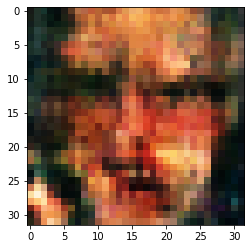

In [23]:
error_d_m3, error_g_m3, prediccion_falsa_m3 = entrenar(gan3, 5000, 150, "resultadosGAN-4/modelo3")

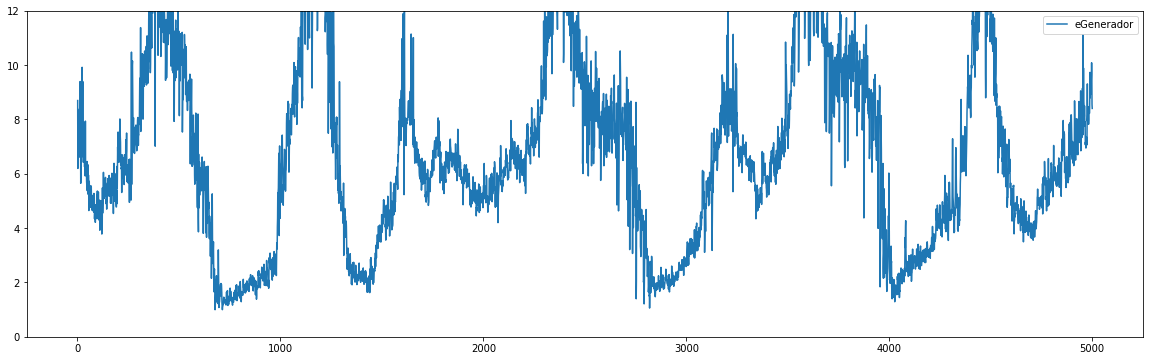

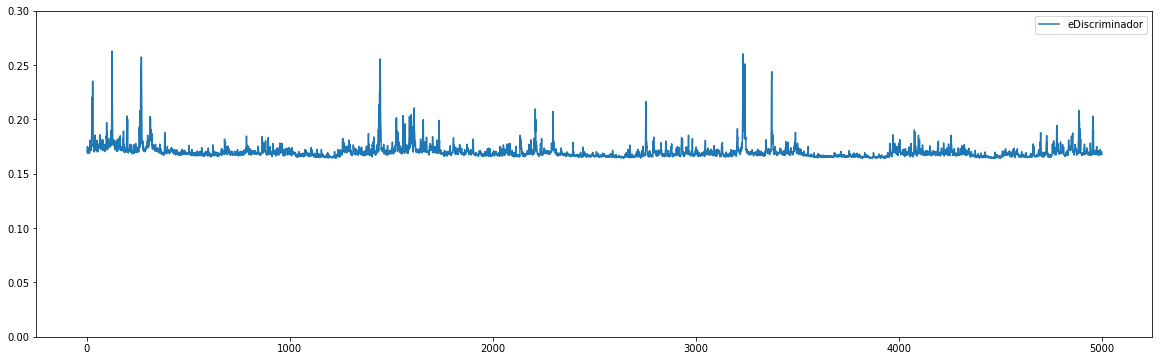

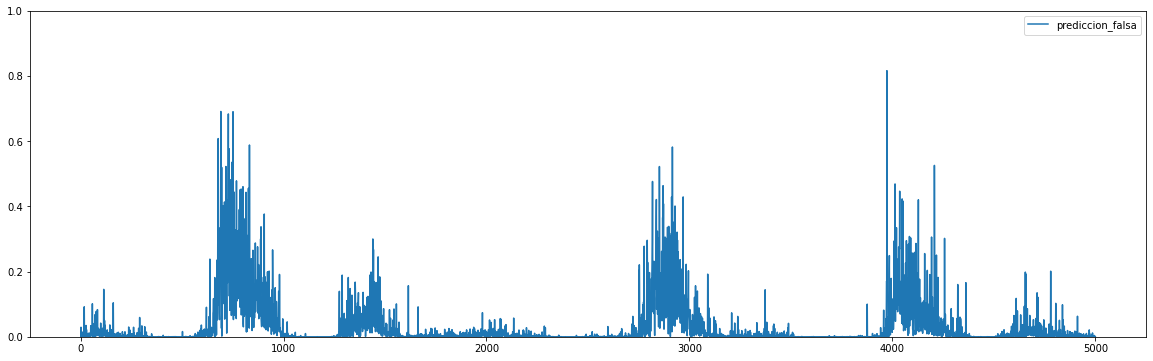

In [25]:
plot_acumulado(len(error_g_m3), 12, eGenerador = error_g_m3)
plot_acumulado(len(error_d_m3), 0.3, eDiscriminador = error_d_m3)
plot_acumulado(len(prediccion_falsa_m3), 1, prediccion_falsa = prediccion_falsa_m3)

tf.Tensor([[3.3225356e-06]], shape=(1, 1), dtype=float32)


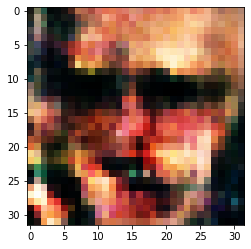

In [40]:
ruido = np.random.normal(0, 1, TAM_ENTRADA)
ruido =np.array([ruido])

predicion(gan3, ruido)

Ocurre lo mismo, entramos en un proceso ciclico que no llega a converger.

### Cuarto modelo

Invertimos que el generador aprenda un poco mas rapido que el discriminador

In [12]:
OPTIMIZADOR4_G = optimizador.Adam(learning_rate=0.0004, beta_1=0.5) 
OPTIMIZADOR4_D = optimizador.Adam(learning_rate=0.0002, beta_1=0.5)
ERROR4 = 'binary_crossentropy' #para este caso queda igual

gan4 = crear_GAN(OPTIMIZADOR4_G, ERROR4, OPTIMIZADOR4_D, ERROR4)

Generador Creado
Discriminador Creado
GAN Creado


Comenzando Epoca 1... Fin
Tiempo transcurrido:  2.4 s
Tiempo restante aprox: 199.64m -> 3:19h
prediccion de ruido:  [[0.4754901]]
Comenzando Epoca 2... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 62.41m -> 1:2h
prediccion de ruido:  [[0.4618374]]
Comenzando Epoca 3... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 63.84m -> 1:3h
prediccion de ruido:  [[0.5179905]]
Comenzando Epoca 4... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 59.67m -> 0:59h
prediccion de ruido:  [[0.65711606]]
Comenzando Epoca 5... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 62.72m -> 1:2h
prediccion de ruido:  [[0.54886615]]
Comenzando Epoca 6... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 61.73m -> 1:1h
prediccion de ruido:  [[0.5271142]]
Comenzando Epoca 7... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 66.46m -> 1:6h
prediccion de ruido:  [[0.6025789]]
Comenzando Epoca 8... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 61.47m -> 1:1h
p

Comenzando Epoca 43... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 60.97m -> 1:0h
prediccion de ruido:  [[0.62725365]]
Comenzando Epoca 44... Fin
Tiempo transcurrido:  0.87 s
Tiempo restante aprox: 71.71m -> 1:11h
prediccion de ruido:  [[0.59729785]]
Comenzando Epoca 45... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 59.44m -> 0:59h
prediccion de ruido:  [[0.6148246]]
Comenzando Epoca 46... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 60.77m -> 1:0h
prediccion de ruido:  [[0.5211792]]
Comenzando Epoca 47... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 59.47m -> 0:59h
prediccion de ruido:  [[0.5520985]]
Comenzando Epoca 48... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 62.03m -> 1:2h
prediccion de ruido:  [[0.5967675]]
Comenzando Epoca 49... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 60.68m -> 1:0h
prediccion de ruido:  [[0.47127056]]
Comenzando Epoca 50... Fin
Tiempo transcurrido:  0.71 s
Tiempo restante aprox: 58.71

Comenzando Epoca 85... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 58.8m -> 0:58h
prediccion de ruido:  [[0.5070207]]
Comenzando Epoca 86... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 60.06m -> 1:0h
prediccion de ruido:  [[0.5161479]]
Comenzando Epoca 87... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 58.77m -> 0:58h
prediccion de ruido:  [[0.5322774]]
Comenzando Epoca 88... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 58.76m -> 0:58h
prediccion de ruido:  [[0.5000505]]
Comenzando Epoca 89... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 60.03m -> 1:0h
prediccion de ruido:  [[0.62941796]]
Comenzando Epoca 90... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 58.74m -> 0:58h
prediccion de ruido:  [[0.522974]]
Comenzando Epoca 91... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 60.0m -> 1:0h
prediccion de ruido:  [[0.47908986]]
Comenzando Epoca 92... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 59.99m -

Comenzando Epoca 126... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 59.57m -> 0:59h
prediccion de ruido:  [[0.57063395]]
Comenzando Epoca 127... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 58.29m -> 0:58h
prediccion de ruido:  [[0.5430102]]
Comenzando Epoca 128... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 59.71m -> 0:59h
prediccion de ruido:  [[0.6618851]]
Comenzando Epoca 129... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 59.62m -> 0:59h
prediccion de ruido:  [[0.50915444]]
Comenzando Epoca 130... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 58.26m -> 0:58h
prediccion de ruido:  [[0.18370903]]
Comenzando Epoca 131... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 59.51m -> 0:59h
prediccion de ruido:  [[0.5626301]]
Comenzando Epoca 132... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 58.23m -> 0:58h
prediccion de ruido:  [[0.62941724]]
Comenzando Epoca 133... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante

Comenzando Epoca 167... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 60.33m -> 1:0h
prediccion de ruido:  [[0.39067248]]
Comenzando Epoca 168... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 57.8m -> 0:57h
prediccion de ruido:  [[0.3724379]]
Comenzando Epoca 169... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 59.05m -> 0:59h
prediccion de ruido:  [[0.3871661]]
Comenzando Epoca 170... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 57.78m -> 0:57h
prediccion de ruido:  [[0.29564703]]
Comenzando Epoca 171... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 59.02m -> 0:59h
prediccion de ruido:  [[0.75074005]]
Comenzando Epoca 172... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 59.01m -> 0:59h
prediccion de ruido:  [[0.3120209]]
Comenzando Epoca 173... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 57.74m -> 0:57h
prediccion de ruido:  [[0.35432905]]
Comenzando Epoca 174... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante a

Comenzando Epoca 208... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 57.32m -> 0:57h
prediccion de ruido:  [[0.29817492]]
Comenzando Epoca 209... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 58.56m -> 0:58h
prediccion de ruido:  [[0.49652073]]
Comenzando Epoca 210... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 58.55m -> 0:58h
prediccion de ruido:  [[0.17620763]]
Comenzando Epoca 211... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 57.29m -> 0:57h
prediccion de ruido:  [[0.72533727]]
Comenzando Epoca 212... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 58.52m -> 0:58h
prediccion de ruido:  [[0.08160037]]
Comenzando Epoca 213... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 58.51m -> 0:58h
prediccion de ruido:  [[0.07942423]]
Comenzando Epoca 214... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 58.5m -> 0:58h
prediccion de ruido:  [[0.51949435]]
Comenzando Epoca 215... Fin
Tiempo transcurrido:  0.72 s
Tiempo restan

Comenzando Epoca 249... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 58.07m -> 0:58h
prediccion de ruido:  [[0.29472452]]
Comenzando Epoca 250... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 59.29m -> 0:59h
prediccion de ruido:  [[0.03934732]]
Comenzando Epoca 251... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 58.05m -> 0:58h
prediccion de ruido:  [[0.10737318]]
Comenzando Epoca 252... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 58.03m -> 0:58h
prediccion de ruido:  [[0.343037]]
Comenzando Epoca 253... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 58.02m -> 0:58h
prediccion de ruido:  [[0.21766064]]
Comenzando Epoca 254... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 59.24m -> 0:59h
prediccion de ruido:  [[0.12537402]]
Comenzando Epoca 255... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 59.23m -> 0:59h
prediccion de ruido:  [[0.13059643]]
Comenzando Epoca 256... Fin
Tiempo transcurrido:  0.75 s
Tiempo restant

Comenzando Epoca 290... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 57.57m -> 0:57h
prediccion de ruido:  [[0.24695209]]
Comenzando Epoca 291... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 57.56m -> 0:57h
prediccion de ruido:  [[0.41755897]]
Comenzando Epoca 292... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 57.54m -> 0:57h
prediccion de ruido:  [[0.53939223]]
Comenzando Epoca 293... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 59.98m -> 0:59h
prediccion de ruido:  [[0.05317143]]
Comenzando Epoca 294... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 58.74m -> 0:58h
prediccion de ruido:  [[0.02693403]]
Comenzando Epoca 295... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 58.73m -> 0:58h
prediccion de ruido:  [[0.5238223]]
Comenzando Epoca 296... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 58.72m -> 0:58h
prediccion de ruido:  [[0.10940653]]
Comenzando Epoca 297... Fin
Tiempo transcurrido:  0.76 s
Tiempo restan

Comenzando Epoca 331... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 58.44m -> 0:58h
prediccion de ruido:  [[0.15047267]]
Comenzando Epoca 332... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 57.06m -> 0:57h
prediccion de ruido:  [[0.516507]]
Comenzando Epoca 333... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 59.55m -> 0:59h
prediccion de ruido:  [[0.50529295]]
Comenzando Epoca 334... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 61.88m -> 1:1h
prediccion de ruido:  [[0.06931049]]
Comenzando Epoca 335... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 57.1m -> 0:57h
prediccion de ruido:  [[0.06588542]]
Comenzando Epoca 336... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 57.01m -> 0:57h
prediccion de ruido:  [[0.05144647]]
Comenzando Epoca 337... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 58.28m -> 0:58h
prediccion de ruido:  [[0.06073114]]
Comenzando Epoca 338... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante a

Comenzando Epoca 372... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 56.94m -> 0:56h
prediccion de ruido:  [[0.05453378]]
Comenzando Epoca 373... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 59.4m -> 0:59h
prediccion de ruido:  [[0.05789]]
Comenzando Epoca 374... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 58.5m -> 0:58h
prediccion de ruido:  [[0.11058322]]
Comenzando Epoca 375... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 56.68m -> 0:56h
prediccion de ruido:  [[0.06257892]]
Comenzando Epoca 376... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 57.72m -> 0:57h
prediccion de ruido:  [[0.45415348]]
Comenzando Epoca 377... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 57.52m -> 0:57h
prediccion de ruido:  [[0.06387806]]
Comenzando Epoca 378... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 57.2m -> 0:57h
prediccion de ruido:  [[0.03894621]]
Comenzando Epoca 379... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante ap

Comenzando Epoca 413... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 54.87m -> 0:54h
prediccion de ruido:  [[0.05371568]]
Comenzando Epoca 414... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 56.05m -> 0:56h
prediccion de ruido:  [[0.04462516]]
Comenzando Epoca 415... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 56.04m -> 0:56h
prediccion de ruido:  [[0.0496929]]
Comenzando Epoca 416... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 54.84m -> 0:54h
prediccion de ruido:  [[0.22007445]]
Comenzando Epoca 417... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 56.02m -> 0:56h
prediccion de ruido:  [[0.00669554]]
Comenzando Epoca 418... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 54.89m -> 0:54h
prediccion de ruido:  [[0.6140886]]
Comenzando Epoca 419... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 58.1m -> 0:58h
prediccion de ruido:  [[0.01899719]]
Comenzando Epoca 420... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante

Comenzando Epoca 454... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 55.72m -> 0:55h
prediccion de ruido:  [[0.03485772]]
Comenzando Epoca 455... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 55.7m -> 0:55h
prediccion de ruido:  [[0.09920421]]
Comenzando Epoca 456... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 56.15m -> 0:56h
prediccion de ruido:  [[0.60736156]]
Comenzando Epoca 457... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 55.83m -> 0:55h
prediccion de ruido:  [[0.9268896]]
Comenzando Epoca 458... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 56.68m -> 0:56h
prediccion de ruido:  [[0.11417642]]
Comenzando Epoca 459... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 55.66m -> 0:55h
prediccion de ruido:  [[0.56871945]]
Comenzando Epoca 460... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 55.64m -> 0:55h
prediccion de ruido:  [[0.22196373]]
Comenzando Epoca 461... Fin
Tiempo transcurrido:  0.72 s
Tiempo restant

Comenzando Epoca 495... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 54.19m -> 0:54h
prediccion de ruido:  [[0.03064585]]
Comenzando Epoca 496... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 55.2m -> 0:55h
prediccion de ruido:  [[0.19121093]]
Comenzando Epoca 497... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 54.02m -> 0:54h
prediccion de ruido:  [[0.16191176]]
Comenzando Epoca 498... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 54.31m -> 0:54h
prediccion de ruido:  [[0.07963601]]
Comenzando Epoca 499... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 53.99m -> 0:53h
prediccion de ruido:  [[0.02446195]]
Comenzando Epoca 500... Fin
Tiempo transcurrido:  0.86 s
Tiempo restante aprox: 64.66m -> 1:4h
prediccion de ruido:  [[0.00763774]]
Comenzando Epoca 501... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 54.05m -> 0:54h
prediccion de ruido:  [[0.03726584]]
Comenzando Epoca 502... Fin
Tiempo transcurrido:  0.75 s
Tiempo restant

Comenzando Epoca 536... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 53.7m -> 0:53h
prediccion de ruido:  [[0.07675052]]
Comenzando Epoca 537... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 54.92m -> 0:54h
prediccion de ruido:  [[0.11951444]]
Comenzando Epoca 538... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 55.04m -> 0:55h
prediccion de ruido:  [[0.08127666]]
Comenzando Epoca 539... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 53.66m -> 0:53h
prediccion de ruido:  [[0.4238514]]
Comenzando Epoca 540... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 54.25m -> 0:54h
prediccion de ruido:  [[0.03594536]]
Comenzando Epoca 541... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 53.56m -> 0:53h
prediccion de ruido:  [[0.05731699]]
Comenzando Epoca 542... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 54.64m -> 0:54h
prediccion de ruido:  [[0.17211017]]
Comenzando Epoca 543... Fin
Tiempo transcurrido:  0.74 s
Tiempo restant

Comenzando Epoca 577... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 53.21m -> 0:53h
prediccion de ruido:  [[0.25399625]]
Comenzando Epoca 578... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 54.2m -> 0:54h
prediccion de ruido:  [[0.04455099]]
Comenzando Epoca 579... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 52.84m -> 0:52h
prediccion de ruido:  [[0.01883563]]
Comenzando Epoca 580... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 54.17m -> 0:54h
prediccion de ruido:  [[0.03685632]]
Comenzando Epoca 581... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 54.16m -> 0:54h
prediccion de ruido:  [[0.03838804]]
Comenzando Epoca 582... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 53.15m -> 0:53h
prediccion de ruido:  [[0.05647987]]
Comenzando Epoca 583... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 53.06m -> 0:53h
prediccion de ruido:  [[0.02614757]]
Comenzando Epoca 584... Fin
Tiempo transcurrido:  0.72 s
Tiempo restan

Comenzando Epoca 618... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 53.11m -> 0:53h
prediccion de ruido:  [[0.06145972]]
Comenzando Epoca 619... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 53.77m -> 0:53h
prediccion de ruido:  [[0.00641179]]
Comenzando Epoca 620... Fin
Tiempo transcurrido:  0.7 s
Tiempo restante aprox: 51.4m -> 0:51h
prediccion de ruido:  [[0.03275985]]
Comenzando Epoca 621... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 52.9m -> 0:52h
prediccion de ruido:  [[0.16416812]]
Comenzando Epoca 622... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 52.88m -> 0:52h
prediccion de ruido:  [[0.18555439]]
Comenzando Epoca 623... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 53.56m -> 0:53h
prediccion de ruido:  [[0.24612519]]
Comenzando Epoca 624... Fin
Tiempo transcurrido:  0.71 s
Tiempo restante aprox: 51.94m -> 0:51h
prediccion de ruido:  [[0.02148017]]
Comenzando Epoca 625... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante

Comenzando Epoca 659... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 52.0m -> 0:52h
prediccion de ruido:  [[0.09201124]]
Comenzando Epoca 660... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 55.12m -> 0:55h
prediccion de ruido:  [[0.07712087]]
Comenzando Epoca 661... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 52.31m -> 0:52h
prediccion de ruido:  [[0.3331858]]
Comenzando Epoca 662... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 53.63m -> 0:53h
prediccion de ruido:  [[0.11264312]]
Comenzando Epoca 663... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 54.43m -> 0:54h
prediccion de ruido:  [[0.09412637]]
Comenzando Epoca 664... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 53.0m -> 0:52h
prediccion de ruido:  [[0.01182491]]
Comenzando Epoca 665... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 51.86m -> 0:51h
prediccion de ruido:  [[0.2558674]]
Comenzando Epoca 666... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante 

Comenzando Epoca 700... Fin
Tiempo transcurrido:  0.88 s
Tiempo restante aprox: 62.98m -> 1:2h
prediccion de ruido:  [[0.10934874]]
Comenzando Epoca 701... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 53.45m -> 0:53h
prediccion de ruido:  [[0.02647835]]
Comenzando Epoca 702... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 55.63m -> 0:55h
prediccion de ruido:  [[0.05575907]]
Comenzando Epoca 703... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 54.06m -> 0:54h
prediccion de ruido:  [[0.02815908]]
Comenzando Epoca 704... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 52.51m -> 0:52h
prediccion de ruido:  [[0.15882647]]
Comenzando Epoca 705... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 52.5m -> 0:52h
prediccion de ruido:  [[0.02405313]]
Comenzando Epoca 706... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 52.49m -> 0:52h
prediccion de ruido:  [[0.00131604]]
Comenzando Epoca 707... Fin
Tiempo transcurrido:  0.72 s
Tiempo restant

Comenzando Epoca 741... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 52.06m -> 0:52h
prediccion de ruido:  [[0.0629828]]
Comenzando Epoca 742... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 53.22m -> 0:53h
prediccion de ruido:  [[0.01056775]]
Comenzando Epoca 743... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 54.25m -> 0:54h
prediccion de ruido:  [[0.12293085]]
Comenzando Epoca 744... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 52.25m -> 0:52h
prediccion de ruido:  [[0.06288505]]
Comenzando Epoca 745... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 52.75m -> 0:52h
prediccion de ruido:  [[0.02378482]]
Comenzando Epoca 746... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 54.84m -> 0:54h
prediccion de ruido:  [[0.01211777]]
Comenzando Epoca 747... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 53.36m -> 0:53h
prediccion de ruido:  [[0.14913666]]
Comenzando Epoca 748... Fin
Tiempo transcurrido:  0.78 s
Tiempo restan

Comenzando Epoca 782... Fin
Tiempo transcurrido:  0.81 s
Tiempo restante aprox: 57.04m -> 0:57h
prediccion de ruido:  [[0.17324203]]
Comenzando Epoca 783... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 53.74m -> 0:53h
prediccion de ruido:  [[0.00307962]]
Comenzando Epoca 784... Fin
Tiempo transcurrido:  0.81 s
Tiempo restante aprox: 57.01m -> 0:57h
prediccion de ruido:  [[0.0527992]]
Comenzando Epoca 785... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 52.62m -> 0:52h
prediccion de ruido:  [[0.01292473]]
Comenzando Epoca 786... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 52.6m -> 0:52h
prediccion de ruido:  [[0.01231396]]
Comenzando Epoca 787... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 51.5m -> 0:51h
prediccion de ruido:  [[0.07982063]]
Comenzando Epoca 788... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 52.72m -> 0:52h
prediccion de ruido:  [[0.00872701]]
Comenzando Epoca 789... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante

Comenzando Epoca 823... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 51.06m -> 0:51h
prediccion de ruido:  [[0.00339374]]
Comenzando Epoca 824... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 51.04m -> 0:51h
prediccion de ruido:  [[0.00110692]]
Comenzando Epoca 825... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 51.03m -> 0:51h
prediccion de ruido:  [[0.00197601]]
Comenzando Epoca 826... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 51.02m -> 0:51h
prediccion de ruido:  [[0.0020332]]
Comenzando Epoca 827... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 51.01m -> 0:51h
prediccion de ruido:  [[0.03324455]]
Comenzando Epoca 828... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 50.99m -> 0:50h
prediccion de ruido:  [[0.00102416]]
Comenzando Epoca 829... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 50.98m -> 0:50h
prediccion de ruido:  [[0.01001313]]
Comenzando Epoca 830... Fin
Tiempo transcurrido:  0.75 s
Tiempo restan

Comenzando Epoca 864... Fin
Tiempo transcurrido:  0.83 s
Tiempo restante aprox: 57.22m -> 0:57h
prediccion de ruido:  [[0.00183594]]
Comenzando Epoca 865... Fin
Tiempo transcurrido:  0.89 s
Tiempo restante aprox: 61.36m -> 1:1h
prediccion de ruido:  [[0.00011388]]
Comenzando Epoca 866... Fin
Tiempo transcurrido:  0.83 s
Tiempo restante aprox: 56.98m -> 0:56h
prediccion de ruido:  [[0.0030894]]
Comenzando Epoca 867... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 52.63m -> 0:52h
prediccion de ruido:  [[0.00196898]]
Comenzando Epoca 868... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 51.58m -> 0:51h
prediccion de ruido:  [[0.02533916]]
Comenzando Epoca 869... Fin
Tiempo transcurrido:  0.81 s
Tiempo restante aprox: 55.87m -> 0:55h
prediccion de ruido:  [[0.05939034]]
Comenzando Epoca 870... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 53.84m -> 0:53h
prediccion de ruido:  [[0.03551182]]
Comenzando Epoca 871... Fin
Tiempo transcurrido:  0.81 s
Tiempo restant

Comenzando Epoca 905... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 50.05m -> 0:50h
prediccion de ruido:  [[0.18914115]]
Comenzando Epoca 906... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 50.04m -> 0:50h
prediccion de ruido:  [[0.08919844]]
Comenzando Epoca 907... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 48.96m -> 0:48h
prediccion de ruido:  [[0.2624559]]
Comenzando Epoca 908... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 50.02m -> 0:50h
prediccion de ruido:  [[0.06832632]]
Comenzando Epoca 909... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 51.07m -> 0:51h
prediccion de ruido:  [[0.0618974]]
Comenzando Epoca 910... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 49.07m -> 0:49h
prediccion de ruido:  [[0.22613388]]
Comenzando Epoca 911... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 49.98m -> 0:49h
prediccion de ruido:  [[0.0862473]]
Comenzando Epoca 912... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante

Comenzando Epoca 946... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 49.55m -> 0:49h
prediccion de ruido:  [[0.28865033]]
Comenzando Epoca 947... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 49.54m -> 0:49h
prediccion de ruido:  [[0.14190474]]
Comenzando Epoca 948... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 49.53m -> 0:49h
prediccion de ruido:  [[0.11634424]]
Comenzando Epoca 949... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 49.52m -> 0:49h
prediccion de ruido:  [[0.11372533]]
Comenzando Epoca 950... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 49.5m -> 0:49h
prediccion de ruido:  [[0.17481527]]
Comenzando Epoca 951... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 48.44m -> 0:48h
prediccion de ruido:  [[0.08842647]]
Comenzando Epoca 952... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 49.48m -> 0:49h
prediccion de ruido:  [[0.01310122]]
Comenzando Epoca 953... Fin
Tiempo transcurrido:  0.73 s
Tiempo restan

Comenzando Epoca 987... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 50.1m -> 0:50h
prediccion de ruido:  [[0.22924918]]
Comenzando Epoca 988... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 48.0m -> 0:47h
prediccion de ruido:  [[0.02200857]]
Comenzando Epoca 989... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 49.03m -> 0:49h
prediccion de ruido:  [[0.05799332]]
Comenzando Epoca 990... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 49.01m -> 0:49h
prediccion de ruido:  [[0.06265116]]
Comenzando Epoca 991... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 49.0m -> 0:49h
prediccion de ruido:  [[0.11478132]]
Comenzando Epoca 992... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 48.99m -> 0:48h
prediccion de ruido:  [[0.02201265]]
Comenzando Epoca 993... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 48.98m -> 0:48h
prediccion de ruido:  [[0.14260632]]
Comenzando Epoca 994... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante

Comenzando Epoca 1028... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 48.34m -> 0:48h
prediccion de ruido:  [[0.09828615]]
Comenzando Epoca 1029... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 48.79m -> 0:48h
prediccion de ruido:  [[0.03725514]]
Comenzando Epoca 1030... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 48.71m -> 0:48h
prediccion de ruido:  [[0.08954537]]
Comenzando Epoca 1031... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 47.58m -> 0:47h
prediccion de ruido:  [[0.13419959]]
Comenzando Epoca 1032... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 49.22m -> 0:49h
prediccion de ruido:  [[0.0109728]]
Comenzando Epoca 1033... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 49.27m -> 0:49h
prediccion de ruido:  [[0.0067136]]
Comenzando Epoca 1034... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 48.66m -> 0:48h
prediccion de ruido:  [[0.00423312]]
Comenzando Epoca 1035... Fin
Tiempo transcurrido:  0.76 s
Tiempo

Comenzando Epoca 1069... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 48.05m -> 0:48h
prediccion de ruido:  [[0.0878962]]
Comenzando Epoca 1070... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 47.02m -> 0:47h
prediccion de ruido:  [[0.08494931]]
Comenzando Epoca 1071... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 48.02m -> 0:48h
prediccion de ruido:  [[0.01542717]]
Comenzando Epoca 1072... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 48.01m -> 0:48h
prediccion de ruido:  [[0.00570729]]
Comenzando Epoca 1073... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 48.0m -> 0:48h
prediccion de ruido:  [[0.00179589]]
Comenzando Epoca 1074... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 46.97m -> 0:46h
prediccion de ruido:  [[0.00311181]]
Comenzando Epoca 1075... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 47.98m -> 0:47h
prediccion de ruido:  [[0.00125331]]
Comenzando Epoca 1076... Fin
Tiempo transcurrido:  0.73 s
Tiempo

Comenzando Epoca 1110... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 47.55m -> 0:47h
prediccion de ruido:  [[0.00027668]]
Comenzando Epoca 1111... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 47.54m -> 0:47h
prediccion de ruido:  [[0.01676375]]
Comenzando Epoca 1112... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 47.52m -> 0:47h
prediccion de ruido:  [[0.02650803]]
Comenzando Epoca 1113... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 46.5m -> 0:46h
prediccion de ruido:  [[0.00422537]]
Comenzando Epoca 1114... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 47.5m -> 0:47h
prediccion de ruido:  [[0.01281494]]
Comenzando Epoca 1115... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 46.48m -> 0:46h
prediccion de ruido:  [[0.06509018]]
Comenzando Epoca 1116... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 47.48m -> 0:47h
prediccion de ruido:  [[0.04953536]]
Comenzando Epoca 1117... Fin
Tiempo transcurrido:  0.73 s
Tiempo

Comenzando Epoca 1151... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 47.11m -> 0:47h
prediccion de ruido:  [[0.0314804]]
Comenzando Epoca 1152... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 48.16m -> 0:48h
prediccion de ruido:  [[0.06274825]]
Comenzando Epoca 1153... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 48.02m -> 0:48h
prediccion de ruido:  [[0.03668547]]
Comenzando Epoca 1154... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 48.01m -> 0:48h
prediccion de ruido:  [[0.04424325]]
Comenzando Epoca 1155... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 46.0m -> 0:45h
prediccion de ruido:  [[0.03695431]]
Comenzando Epoca 1156... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 46.99m -> 0:46h
prediccion de ruido:  [[0.0077045]]
Comenzando Epoca 1157... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 46.97m -> 0:46h
prediccion de ruido:  [[0.0027566]]
Comenzando Epoca 1158... Fin
Tiempo transcurrido:  0.75 s
Tiempo r

Comenzando Epoca 1192... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 47.54m -> 0:47h
prediccion de ruido:  [[0.02374491]]
Comenzando Epoca 1193... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 45.54m -> 0:45h
prediccion de ruido:  [[0.04504132]]
Comenzando Epoca 1194... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 46.52m -> 0:46h
prediccion de ruido:  [[0.00248438]]
Comenzando Epoca 1195... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 47.5m -> 0:47h
prediccion de ruido:  [[0.18676618]]
Comenzando Epoca 1196... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 47.49m -> 0:47h
prediccion de ruido:  [[0.02422917]]
Comenzando Epoca 1197... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 46.49m -> 0:46h
prediccion de ruido:  [[0.06008294]]
Comenzando Epoca 1198... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 47.46m -> 0:47h
prediccion de ruido:  [[0.07386228]]
Comenzando Epoca 1199... Fin
Tiempo transcurrido:  0.76 s
Tiemp

Comenzando Epoca 1233... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 46.05m -> 0:46h
prediccion de ruido:  [[0.00640675]]
Comenzando Epoca 1234... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 46.03m -> 0:46h
prediccion de ruido:  [[0.00428981]]
Comenzando Epoca 1235... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 48.1m -> 0:48h
prediccion de ruido:  [[0.04536578]]
Comenzando Epoca 1236... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 47.97m -> 0:47h
prediccion de ruido:  [[0.0258868]]
Comenzando Epoca 1237... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 46.98m -> 0:46h
prediccion de ruido:  [[0.05161083]]
Comenzando Epoca 1238... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 45.98m -> 0:45h
prediccion de ruido:  [[0.17207897]]
Comenzando Epoca 1239... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 47.93m -> 0:47h
prediccion de ruido:  [[0.00506604]]
Comenzando Epoca 1240... Fin
Tiempo transcurrido:  0.75 s
Tiempo

Comenzando Epoca 1274... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 44.58m -> 0:44h
prediccion de ruido:  [[0.02941492]]
Comenzando Epoca 1275... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 45.53m -> 0:45h
prediccion de ruido:  [[0.03429288]]
Comenzando Epoca 1276... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 46.49m -> 0:46h
prediccion de ruido:  [[0.24287573]]
Comenzando Epoca 1277... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 45.51m -> 0:45h
prediccion de ruido:  [[0.02538887]]
Comenzando Epoca 1278... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 45.5m -> 0:45h
prediccion de ruido:  [[0.05598065]]
Comenzando Epoca 1279... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 46.45m -> 0:46h
prediccion de ruido:  [[0.05440161]]
Comenzando Epoca 1280... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 45.47m -> 0:45h
prediccion de ruido:  [[0.04800588]]
Comenzando Epoca 1281... Fin
Tiempo transcurrido:  0.73 s
Tiemp

Comenzando Epoca 1315... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 45.04m -> 0:45h
prediccion de ruido:  [[0.14851019]]
Comenzando Epoca 1316... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 45.03m -> 0:45h
prediccion de ruido:  [[0.06902537]]
Comenzando Epoca 1317... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 45.02m -> 0:45h
prediccion de ruido:  [[0.00041357]]
Comenzando Epoca 1318... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 45.01m -> 0:45h
prediccion de ruido:  [[0.00555581]]
Comenzando Epoca 1319... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 44.99m -> 0:44h
prediccion de ruido:  [[0.01779374]]
Comenzando Epoca 1320... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 45.94m -> 0:45h
prediccion de ruido:  [[0.6009609]]
Comenzando Epoca 1321... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 44.01m -> 0:44h
prediccion de ruido:  [[0.29048443]]
Comenzando Epoca 1322... Fin
Tiempo transcurrido:  0.73 s
Tiemp

Comenzando Epoca 1356... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 43.59m -> 0:43h
prediccion de ruido:  [[0.00011058]]
Comenzando Epoca 1357... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 45.6m -> 0:45h
prediccion de ruido:  [[0.000521]]
Comenzando Epoca 1358... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 44.58m -> 0:44h
prediccion de ruido:  [[0.0001395]]
Comenzando Epoca 1359... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 44.51m -> 0:44h
prediccion de ruido:  [[0.00016952]]
Comenzando Epoca 1360... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 45.44m -> 0:45h
prediccion de ruido:  [[0.00127578]]
Comenzando Epoca 1361... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 44.48m -> 0:44h
prediccion de ruido:  [[0.00282422]]
Comenzando Epoca 1362... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 44.47m -> 0:44h
prediccion de ruido:  [[0.00883055]]
Comenzando Epoca 1363... Fin
Tiempo transcurrido:  0.73 s
Tiempo r

Comenzando Epoca 1397... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 44.04m -> 0:44h
prediccion de ruido:  [[0.00031599]]
Comenzando Epoca 1398... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 43.09m -> 0:43h
prediccion de ruido:  [[5.985868e-05]]
Comenzando Epoca 1399... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 44.02m -> 0:44h
prediccion de ruido:  [[0.00069457]]
Comenzando Epoca 1400... Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 54.3m -> 0:54h
prediccion de ruido:  [[5.108396e-05]]
Comenzando Epoca 1401... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 43.99m -> 0:43h
prediccion de ruido:  [[0.00065947]]
Comenzando Epoca 1402... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 45.85m -> 0:45h
prediccion de ruido:  [[4.897689e-07]]
Comenzando Epoca 1403... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 43.97m -> 0:43h
prediccion de ruido:  [[0.01845807]]
Comenzando Epoca 1404... Fin
Tiempo transcurrido:  0.73 s


Comenzando Epoca 1438... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 44.47m -> 0:44h
prediccion de ruido:  [[0.00037158]]
Comenzando Epoca 1439... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 44.45m -> 0:44h
prediccion de ruido:  [[0.00098431]]
Comenzando Epoca 1440... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 43.52m -> 0:43h
prediccion de ruido:  [[0.00839329]]
Comenzando Epoca 1441... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 44.43m -> 0:44h
prediccion de ruido:  [[0.00325066]]
Comenzando Epoca 1442... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 44.42m -> 0:44h
prediccion de ruido:  [[0.0007709]]
Comenzando Epoca 1443... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 44.4m -> 0:44h
prediccion de ruido:  [[0.00060788]]
Comenzando Epoca 1444... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 43.47m -> 0:43h
prediccion de ruido:  [[0.00700998]]
Comenzando Epoca 1445... Fin
Tiempo transcurrido:  0.75 s
Tiempo

Comenzando Epoca 1479... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 44.17m -> 0:44h
prediccion de ruido:  [[0.07169122]]
Comenzando Epoca 1480... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 43.14m -> 0:43h
prediccion de ruido:  [[0.14762163]]
Comenzando Epoca 1481... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 44.16m -> 0:44h
prediccion de ruido:  [[0.04298204]]
Comenzando Epoca 1482... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 43.2m -> 0:43h
prediccion de ruido:  [[0.07158414]]
Comenzando Epoca 1483... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 43.17m -> 0:43h
prediccion de ruido:  [[0.12286648]]
Comenzando Epoca 1484... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 43.13m -> 0:43h
prediccion de ruido:  [[0.06466341]]
Comenzando Epoca 1485... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 43.14m -> 0:43h
prediccion de ruido:  [[0.09759018]]
Comenzando Epoca 1486... Fin
Tiempo transcurrido:  0.74 s
Tiemp

Comenzando Epoca 1520... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 43.79m -> 0:43h
prediccion de ruido:  [[0.06196725]]
Comenzando Epoca 1521... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 43.61m -> 0:43h
prediccion de ruido:  [[0.12813428]]
Comenzando Epoca 1522... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 45.71m -> 0:45h
prediccion de ruido:  [[0.24406758]]
Comenzando Epoca 1523... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 45.57m -> 0:45h
prediccion de ruido:  [[0.13807788]]
Comenzando Epoca 1524... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 45.45m -> 0:45h
prediccion de ruido:  [[0.06634474]]
Comenzando Epoca 1525... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 43.56m -> 0:43h
prediccion de ruido:  [[0.5095527]]
Comenzando Epoca 1526... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 41.82m -> 0:41h
prediccion de ruido:  [[0.06782982]]
Comenzando Epoca 1527... Fin
Tiempo transcurrido:  0.77 s
Tiemp

Comenzando Epoca 1561... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 42.93m -> 0:42h
prediccion de ruido:  [[0.04203218]]
Comenzando Epoca 1562... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 42.02m -> 0:42h
prediccion de ruido:  [[0.04871115]]
Comenzando Epoca 1563... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 41.12m -> 0:41h
prediccion de ruido:  [[0.53732735]]
Comenzando Epoca 1564... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 42.11m -> 0:42h
prediccion de ruido:  [[0.04200402]]
Comenzando Epoca 1565... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 41.99m -> 0:41h
prediccion de ruido:  [[0.02328137]]
Comenzando Epoca 1566... Fin
Tiempo transcurrido:  0.83 s
Tiempo restante aprox: 47.45m -> 0:47h
prediccion de ruido:  [[0.10781503]]
Comenzando Epoca 1567... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 41.07m -> 0:41h
prediccion de ruido:  [[0.07427415]]
Comenzando Epoca 1568... Fin
Tiempo transcurrido:  0.73 s
Tiem

Comenzando Epoca 1602... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 44.19m -> 0:44h
prediccion de ruido:  [[0.06808335]]
Comenzando Epoca 1603... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 42.41m -> 0:42h
prediccion de ruido:  [[0.03351]]
Comenzando Epoca 1604... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 41.51m -> 0:41h
prediccion de ruido:  [[0.11120281]]
Comenzando Epoca 1605... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 41.5m -> 0:41h
prediccion de ruido:  [[0.00539804]]
Comenzando Epoca 1606... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 42.37m -> 0:42h
prediccion de ruido:  [[0.08602154]]
Comenzando Epoca 1607... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 42.36m -> 0:42h
prediccion de ruido:  [[0.03358489]]
Comenzando Epoca 1608... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 42.34m -> 0:42h
prediccion de ruido:  [[0.01287377]]
Comenzando Epoca 1609... Fin
Tiempo transcurrido:  0.73 s
Tiempo r

Comenzando Epoca 1643... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 41.91m -> 0:41h
prediccion de ruido:  [[0.07242131]]
Comenzando Epoca 1644... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 41.02m -> 0:41h
prediccion de ruido:  [[0.00743082]]
Comenzando Epoca 1645... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 44.5m -> 0:44h
prediccion de ruido:  [[0.04428253]]
Comenzando Epoca 1646... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 42.74m -> 0:42h
prediccion de ruido:  [[0.00755224]]
Comenzando Epoca 1647... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 42.73m -> 0:42h
prediccion de ruido:  [[0.23926908]]
Comenzando Epoca 1648... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 44.04m -> 0:44h
prediccion de ruido:  [[0.00230521]]
Comenzando Epoca 1649... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 43.82m -> 0:43h
prediccion de ruido:  [[0.00922236]]
Comenzando Epoca 1650... Fin
Tiempo transcurrido:  0.83 s
Tiempo

Comenzando Epoca 1684... Fin
Tiempo transcurrido:  0.81 s
Tiempo restante aprox: 44.85m -> 0:44h
prediccion de ruido:  [[0.00896931]]
Comenzando Epoca 1685... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 40.71m -> 0:40h
prediccion de ruido:  [[0.01913935]]
Comenzando Epoca 1686... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 41.37m -> 0:41h
prediccion de ruido:  [[0.03950265]]
Comenzando Epoca 1687... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 43.94m -> 0:43h
prediccion de ruido:  [[0.00328469]]
Comenzando Epoca 1688... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 41.35m -> 0:41h
prediccion de ruido:  [[0.01092803]]
Comenzando Epoca 1689... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 41.33m -> 0:41h
prediccion de ruido:  [[0.0412271]]
Comenzando Epoca 1690... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 41.38m -> 0:41h
prediccion de ruido:  [[0.11524498]]
Comenzando Epoca 1691... Fin
Tiempo transcurrido:  0.75 s
Tiempo

Comenzando Epoca 1725... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 41.74m -> 0:41h
prediccion de ruido:  [[0.00854686]]
Comenzando Epoca 1726... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 40.87m -> 0:40h
prediccion de ruido:  [[0.06636682]]
Comenzando Epoca 1727... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 40.86m -> 0:40h
prediccion de ruido:  [[0.03726134]]
Comenzando Epoca 1728... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 40.0m -> 0:39h
prediccion de ruido:  [[0.04467928]]
Comenzando Epoca 1729... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 40.83m -> 0:40h
prediccion de ruido:  [[0.00404614]]
Comenzando Epoca 1730... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 39.97m -> 0:39h
prediccion de ruido:  [[0.06411615]]
Comenzando Epoca 1731... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 39.96m -> 0:39h
prediccion de ruido:  [[0.09210432]]
Comenzando Epoca 1732... Fin
Tiempo transcurrido:  0.73 s
Tiemp

Comenzando Epoca 1766... Fin
Tiempo transcurrido:  0.81 s
Tiempo restante aprox: 43.65m -> 0:43h
prediccion de ruido:  [[0.02252591]]
Comenzando Epoca 1767... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 40.52m -> 0:40h
prediccion de ruido:  [[0.15382838]]
Comenzando Epoca 1768... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 39.78m -> 0:39h
prediccion de ruido:  [[0.00591061]]
Comenzando Epoca 1769... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 40.34m -> 0:40h
prediccion de ruido:  [[0.0005661]]
Comenzando Epoca 1770... Fin
Tiempo transcurrido:  0.83 s
Tiempo restante aprox: 44.52m -> 0:44h
prediccion de ruido:  [[0.00774962]]
Comenzando Epoca 1771... Fin
Tiempo transcurrido:  0.84 s
Tiempo restante aprox: 45.46m -> 0:45h
prediccion de ruido:  [[0.00062063]]
Comenzando Epoca 1772... Fin
Tiempo transcurrido:  0.83 s
Tiempo restante aprox: 44.5m -> 0:44h
prediccion de ruido:  [[0.42773396]]
Comenzando Epoca 1773... Fin
Tiempo transcurrido:  0.88 s
Tiempo

Comenzando Epoca 1807... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 42.35m -> 0:42h
prediccion de ruido:  [[0.00701153]]
Comenzando Epoca 1808... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 41.02m -> 0:41h
prediccion de ruido:  [[0.00319812]]
Comenzando Epoca 1809... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 41.5m -> 0:41h
prediccion de ruido:  [[0.00127769]]
Comenzando Epoca 1810... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 39.82m -> 0:39h
prediccion de ruido:  [[0.00816861]]
Comenzando Epoca 1811... Fin
Tiempo transcurrido:  1.15 s
Tiempo restante aprox: 60.89m -> 1:0h
prediccion de ruido:  [[0.00906381]]
Comenzando Epoca 1812... Fin
Tiempo transcurrido:  0.89 s
Tiempo restante aprox: 47.26m -> 0:47h
prediccion de ruido:  [[0.00029621]]
Comenzando Epoca 1813... Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 48.9m -> 0:48h
prediccion de ruido:  [[3.2072814e-05]]
Comenzando Epoca 1814... Fin
Tiempo transcurrido:  0.83 s
Tiemp

Comenzando Epoca 1848... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 39.08m -> 0:39h
prediccion de ruido:  [[0.00404781]]
Comenzando Epoca 1849... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 38.58m -> 0:38h
prediccion de ruido:  [[0.00027525]]
Comenzando Epoca 1850... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 38.51m -> 0:38h
prediccion de ruido:  [[0.00013366]]
Comenzando Epoca 1851... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 40.13m -> 0:40h
prediccion de ruido:  [[0.00103799]]
Comenzando Epoca 1852... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 41.76m -> 0:41h
prediccion de ruido:  [[0.00364238]]
Comenzando Epoca 1853... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 40.92m -> 0:40h
prediccion de ruido:  [[0.00023898]]
Comenzando Epoca 1854... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 40.91m -> 0:40h
prediccion de ruido:  [[0.00021246]]
Comenzando Epoca 1855... Fin
Tiempo transcurrido:  0.75 s
Tiemp

Comenzando Epoca 1889... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 38.03m -> 0:38h
prediccion de ruido:  [[0.00390401]]
Comenzando Epoca 1890... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 38.02m -> 0:38h
prediccion de ruido:  [[0.00565726]]
Comenzando Epoca 1891... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 40.43m -> 0:40h
prediccion de ruido:  [[7.4918746e-05]]
Comenzando Epoca 1892... Fin
Tiempo transcurrido:  0.83 s
Tiempo restante aprox: 42.84m -> 0:42h
prediccion de ruido:  [[0.00072482]]
Comenzando Epoca 1893... Fin
Tiempo transcurrido:  0.81 s
Tiempo restante aprox: 42.12m -> 0:42h
prediccion de ruido:  [[0.01823342]]
Comenzando Epoca 1894... Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 46.85m -> 0:46h
prediccion de ruido:  [[5.758115e-06]]
Comenzando Epoca 1895... Fin
Tiempo transcurrido:  0.89 s
Tiempo restante aprox: 46.04m -> 0:46h
prediccion de ruido:  [[0.00055081]]
Comenzando Epoca 1896... Fin
Tiempo transcurrido:  0.84 s


Comenzando Epoca 1930... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 38.33m -> 0:38h
prediccion de ruido:  [[0.00110814]]
Comenzando Epoca 1931... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 38.31m -> 0:38h
prediccion de ruido:  [[0.00116897]]
Comenzando Epoca 1932... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 39.1m -> 0:39h
prediccion de ruido:  [[0.00198072]]
Comenzando Epoca 1933... Fin
Tiempo transcurrido:  0.84 s
Tiempo restante aprox: 43.08m -> 0:43h
prediccion de ruido:  [[0.03925645]]
Comenzando Epoca 1934... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 40.67m -> 0:40h
prediccion de ruido:  [[0.00434935]]
Comenzando Epoca 1935... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 38.26m -> 0:38h
prediccion de ruido:  [[8.696871e-05]]
Comenzando Epoca 1936... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 38.25m -> 0:38h
prediccion de ruido:  [[0.00274932]]
Comenzando Epoca 1937... Fin
Tiempo transcurrido:  0.75 s
Tiem

Comenzando Epoca 1971... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 37.28m -> 0:37h
prediccion de ruido:  [[0.00035504]]
Comenzando Epoca 1972... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 36.33m -> 0:36h
prediccion de ruido:  [[0.02378121]]
Comenzando Epoca 1973... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 36.22m -> 0:36h
prediccion de ruido:  [[0.00432172]]
Comenzando Epoca 1974... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 36.99m -> 0:36h
prediccion de ruido:  [[0.09930035]]
Comenzando Epoca 1975... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 36.19m -> 0:36h
prediccion de ruido:  [[0.01119092]]
Comenzando Epoca 1976... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 36.97m -> 0:36h
prediccion de ruido:  [[0.00075871]]
Comenzando Epoca 1977... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 36.95m -> 0:36h
prediccion de ruido:  [[0.00845897]]
Comenzando Epoca 1978... Fin
Tiempo transcurrido:  0.73 s
Tiem

Comenzando Epoca 2012... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 36.53m -> 0:36h
prediccion de ruido:  [[0.27626085]]
Comenzando Epoca 2013... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 38.07m -> 0:38h
prediccion de ruido:  [[0.01167351]]
Comenzando Epoca 2014... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 37.28m -> 0:37h
prediccion de ruido:  [[0.03520641]]
Comenzando Epoca 2015... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 37.27m -> 0:37h
prediccion de ruido:  [[0.21900147]]
Comenzando Epoca 2016... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 36.48m -> 0:36h
prediccion de ruido:  [[0.06795833]]
Comenzando Epoca 2017... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 36.46m -> 0:36h
prediccion de ruido:  [[0.02726921]]
Comenzando Epoca 2018... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 36.45m -> 0:36h
prediccion de ruido:  [[0.02981466]]
Comenzando Epoca 2019... Fin
Tiempo transcurrido:  0.73 s
Tiem

Comenzando Epoca 2053... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 36.02m -> 0:36h
prediccion de ruido:  [[0.10054991]]
Comenzando Epoca 2054... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 36.01m -> 0:36h
prediccion de ruido:  [[0.02009884]]
Comenzando Epoca 2055... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 36.0m -> 0:36h
prediccion de ruido:  [[0.01080075]]
Comenzando Epoca 2056... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 35.99m -> 0:35h
prediccion de ruido:  [[0.01177067]]
Comenzando Epoca 2057... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 36.74m -> 0:36h
prediccion de ruido:  [[0.00845155]]
Comenzando Epoca 2058... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 35.2m -> 0:35h
prediccion de ruido:  [[0.02215046]]
Comenzando Epoca 2059... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 35.95m -> 0:35h
prediccion de ruido:  [[0.01311371]]
Comenzando Epoca 2060... Fin
Tiempo transcurrido:  0.72 s
Tiempo

Comenzando Epoca 2094... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 36.28m -> 0:36h
prediccion de ruido:  [[0.04171544]]
Comenzando Epoca 2095... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 36.27m -> 0:36h
prediccion de ruido:  [[0.06021065]]
Comenzando Epoca 2096... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 37.01m -> 0:37h
prediccion de ruido:  [[0.09843671]]
Comenzando Epoca 2097... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 37.0m -> 0:36h
prediccion de ruido:  [[0.00484863]]
Comenzando Epoca 2098... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 38.49m -> 0:38h
prediccion de ruido:  [[0.19395748]]
Comenzando Epoca 2099... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 35.46m -> 0:35h
prediccion de ruido:  [[0.33860573]]
Comenzando Epoca 2100... Fin
Tiempo transcurrido:  0.95 s
Tiempo restante aprox: 46.01m -> 0:46h
prediccion de ruido:  [[0.06953767]]
Comenzando Epoca 2101... Fin
Tiempo transcurrido:  0.75 s
Tiempo

Comenzando Epoca 2135... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 35.02m -> 0:35h
prediccion de ruido:  [[0.01752362]]
Comenzando Epoca 2136... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 35.01m -> 0:35h
prediccion de ruido:  [[0.0035744]]
Comenzando Epoca 2137... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 35.0m -> 0:34h
prediccion de ruido:  [[0.03021437]]
Comenzando Epoca 2138... Fin
Tiempo transcurrido:  0.94 s
Tiempo restante aprox: 44.66m -> 0:44h
prediccion de ruido:  [[0.03093383]]
Comenzando Epoca 2139... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 34.97m -> 0:34h
prediccion de ruido:  [[0.0282439]]
Comenzando Epoca 2140... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 34.96m -> 0:34h
prediccion de ruido:  [[0.00812274]]
Comenzando Epoca 2141... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 34.95m -> 0:34h
prediccion de ruido:  [[0.04000738]]
Comenzando Epoca 2142... Fin
Tiempo transcurrido:  0.73 s
Tiempo 

Comenzando Epoca 2176... Fin
Tiempo transcurrido:  0.84 s
Tiempo restante aprox: 39.46m -> 0:39h
prediccion de ruido:  [[0.00620696]]
Comenzando Epoca 2177... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 34.41m -> 0:34h
prediccion de ruido:  [[0.00367266]]
Comenzando Epoca 2178... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 36.18m -> 0:36h
prediccion de ruido:  [[0.01373091]]
Comenzando Epoca 2179... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 34.71m -> 0:34h
prediccion de ruido:  [[0.0072951]]
Comenzando Epoca 2180... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 37.46m -> 0:37h
prediccion de ruido:  [[0.00161177]]
Comenzando Epoca 2181... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 33.9m -> 0:33h
prediccion de ruido:  [[0.00319231]]
Comenzando Epoca 2182... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 35.49m -> 0:35h
prediccion de ruido:  [[0.00301555]]
Comenzando Epoca 2183... Fin
Tiempo transcurrido:  0.72 s
Tiempo 

Comenzando Epoca 2217... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 34.02m -> 0:34h
prediccion de ruido:  [[0.0155552]]
Comenzando Epoca 2218... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 34.01m -> 0:34h
prediccion de ruido:  [[0.19279099]]
Comenzando Epoca 2219... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 34.0m -> 0:33h
prediccion de ruido:  [[0.00691542]]
Comenzando Epoca 2220... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 33.98m -> 0:33h
prediccion de ruido:  [[0.02413577]]
Comenzando Epoca 2221... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 33.25m -> 0:33h
prediccion de ruido:  [[0.00351802]]
Comenzando Epoca 2222... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 33.24m -> 0:33h
prediccion de ruido:  [[0.007402]]
Comenzando Epoca 2223... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 33.95m -> 0:33h
prediccion de ruido:  [[0.07471031]]
Comenzando Epoca 2224... Fin
Tiempo transcurrido:  0.73 s
Tiempo r

Comenzando Epoca 2258... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 33.52m -> 0:33h
prediccion de ruido:  [[0.4651484]]
Comenzando Epoca 2259... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 32.79m -> 0:32h
prediccion de ruido:  [[0.00854179]]
Comenzando Epoca 2260... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 33.5m -> 0:33h
prediccion de ruido:  [[0.00732723]]
Comenzando Epoca 2261... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 32.77m -> 0:32h
prediccion de ruido:  [[0.00938395]]
Comenzando Epoca 2262... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 33.47m -> 0:33h
prediccion de ruido:  [[0.02023944]]
Comenzando Epoca 2263... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 33.46m -> 0:33h
prediccion de ruido:  [[0.0557366]]
Comenzando Epoca 2264... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 33.45m -> 0:33h
prediccion de ruido:  [[0.0028947]]
Comenzando Epoca 2265... Fin
Tiempo transcurrido:  0.72 s
Tiempo r

Comenzando Epoca 2299... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 33.72m -> 0:33h
prediccion de ruido:  [[0.00471261]]
Comenzando Epoca 2300... Fin
Tiempo transcurrido:  0.95 s
Tiempo restante aprox: 42.93m -> 0:42h
prediccion de ruido:  [[0.05561045]]
Comenzando Epoca 2301... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 33.7m -> 0:33h
prediccion de ruido:  [[0.01820379]]
Comenzando Epoca 2302... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 35.88m -> 0:35h
prediccion de ruido:  [[0.0068917]]
Comenzando Epoca 2303... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 32.97m -> 0:32h
prediccion de ruido:  [[0.00843984]]
Comenzando Epoca 2304... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 33.66m -> 0:33h
prediccion de ruido:  [[0.05570078]]
Comenzando Epoca 2305... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 32.24m -> 0:32h
prediccion de ruido:  [[0.00834382]]
Comenzando Epoca 2306... Fin
Tiempo transcurrido:  0.73 s
Tiempo 

Comenzando Epoca 2340... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 32.0m -> 0:32h
prediccion de ruido:  [[0.00253636]]
Comenzando Epoca 2341... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 31.9m -> 0:31h
prediccion de ruido:  [[0.0049147]]
Comenzando Epoca 2342... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 32.58m -> 0:32h
prediccion de ruido:  [[0.00275096]]
Comenzando Epoca 2343... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 31.97m -> 0:31h
prediccion de ruido:  [[0.00814986]]
Comenzando Epoca 2344... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 32.56m -> 0:32h
prediccion de ruido:  [[0.00505644]]
Comenzando Epoca 2345... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 32.63m -> 0:32h
prediccion de ruido:  [[0.00112981]]
Comenzando Epoca 2346... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 32.29m -> 0:32h
prediccion de ruido:  [[0.00097734]]
Comenzando Epoca 2347... Fin
Tiempo transcurrido:  0.73 s
Tiempo 

Comenzando Epoca 2381... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 32.79m -> 0:32h
prediccion de ruido:  [[0.00110853]]
Comenzando Epoca 2382... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 31.91m -> 0:31h
prediccion de ruido:  [[0.00477797]]
Comenzando Epoca 2383... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 32.85m -> 0:32h
prediccion de ruido:  [[0.00361568]]
Comenzando Epoca 2384... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 34.2m -> 0:34h
prediccion de ruido:  [[0.00086641]]
Comenzando Epoca 2385... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 32.84m -> 0:32h
prediccion de ruido:  [[0.00786307]]
Comenzando Epoca 2386... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 32.81m -> 0:32h
prediccion de ruido:  [[0.02138081]]
Comenzando Epoca 2387... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 32.95m -> 0:32h
prediccion de ruido:  [[0.02473053]]
Comenzando Epoca 2388... Fin
Tiempo transcurrido:  0.75 s
Tiemp

Comenzando Epoca 2422... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 31.64m -> 0:31h
prediccion de ruido:  [[0.00122508]]
Comenzando Epoca 2423... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 31.68m -> 0:31h
prediccion de ruido:  [[0.00094074]]
Comenzando Epoca 2424... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 30.99m -> 0:30h
prediccion de ruido:  [[0.03377149]]
Comenzando Epoca 2425... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 31.65m -> 0:31h
prediccion de ruido:  [[0.00663003]]
Comenzando Epoca 2426... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 32.31m -> 0:32h
prediccion de ruido:  [[0.01876482]]
Comenzando Epoca 2427... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 30.91m -> 0:30h
prediccion de ruido:  [[0.00064802]]
Comenzando Epoca 2428... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 32.45m -> 0:32h
prediccion de ruido:  [[7.1619805e-05]]
Comenzando Epoca 2429... Fin
Tiempo transcurrido:  0.72 s
T

Comenzando Epoca 2463... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 31.01m -> 0:31h
prediccion de ruido:  [[0.00597814]]
Comenzando Epoca 2464... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 31.59m -> 0:31h
prediccion de ruido:  [[0.00021389]]
Comenzando Epoca 2465... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 31.73m -> 0:31h
prediccion de ruido:  [[0.00045627]]
Comenzando Epoca 2466... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 31.06m -> 0:31h
prediccion de ruido:  [[0.02936968]]
Comenzando Epoca 2467... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 31.41m -> 0:31h
prediccion de ruido:  [[0.00023985]]
Comenzando Epoca 2468... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 30.6m -> 0:30h
prediccion de ruido:  [[0.00028774]]
Comenzando Epoca 2469... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 32.11m -> 0:32h
prediccion de ruido:  [[2.7673344e-05]]
Comenzando Epoca 2470... Fin
Tiempo transcurrido:  0.75 s
Ti

Comenzando Epoca 2504... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 30.6m -> 0:30h
prediccion de ruido:  [[0.00193959]]
Comenzando Epoca 2505... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 30.1m -> 0:30h
prediccion de ruido:  [[0.0016132]]
Comenzando Epoca 2506... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 29.92m -> 0:29h
prediccion de ruido:  [[0.00012806]]
Comenzando Epoca 2507... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 30.56m -> 0:30h
prediccion de ruido:  [[0.00125313]]
Comenzando Epoca 2508... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 29.98m -> 0:29h
prediccion de ruido:  [[0.00072834]]
Comenzando Epoca 2509... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 30.59m -> 0:30h
prediccion de ruido:  [[0.00499985]]
Comenzando Epoca 2510... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 29.88m -> 0:29h
prediccion de ruido:  [[0.0075503]]
Comenzando Epoca 2511... Fin
Tiempo transcurrido:  0.79 s
Tiempo r

Comenzando Epoca 2545... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 29.66m -> 0:29h
prediccion de ruido:  [[0.0731006]]
Comenzando Epoca 2546... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 29.44m -> 0:29h
prediccion de ruido:  [[0.04586777]]
Comenzando Epoca 2547... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 30.07m -> 0:30h
prediccion de ruido:  [[0.00106499]]
Comenzando Epoca 2548... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 29.5m -> 0:29h
prediccion de ruido:  [[0.00463766]]
Comenzando Epoca 2549... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 30.05m -> 0:30h
prediccion de ruido:  [[0.01083982]]
Comenzando Epoca 2550... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 30.03m -> 0:30h
prediccion de ruido:  [[0.00647557]]
Comenzando Epoca 2551... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 30.1m -> 0:30h
prediccion de ruido:  [[0.00098297]]
Comenzando Epoca 2552... Fin
Tiempo transcurrido:  0.74 s
Tiempo 

Comenzando Epoca 2586... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 30.3m -> 0:30h
prediccion de ruido:  [[0.01779577]]
Comenzando Epoca 2587... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 30.13m -> 0:30h
prediccion de ruido:  [[0.04011571]]
Comenzando Epoca 2588... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 28.94m -> 0:28h
prediccion de ruido:  [[0.0831767]]
Comenzando Epoca 2589... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 30.1m -> 0:30h
prediccion de ruido:  [[0.00730333]]
Comenzando Epoca 2590... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 29.5m -> 0:29h
prediccion de ruido:  [[0.0175471]]
Comenzando Epoca 2591... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 29.49m -> 0:29h
prediccion de ruido:  [[0.08351889]]
Comenzando Epoca 2592... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 29.44m -> 0:29h
prediccion de ruido:  [[0.17766777]]
Comenzando Epoca 2593... Fin
Tiempo transcurrido:  0.75 s
Tiempo re

Comenzando Epoca 2627... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 29.75m -> 0:29h
prediccion de ruido:  [[0.03742412]]
Comenzando Epoca 2628... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 30.22m -> 0:30h
prediccion de ruido:  [[0.02671653]]
Comenzando Epoca 2629... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 29.5m -> 0:29h
prediccion de ruido:  [[0.04863226]]
Comenzando Epoca 2630... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 29.17m -> 0:29h
prediccion de ruido:  [[0.18410805]]
Comenzando Epoca 2631... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 28.96m -> 0:28h
prediccion de ruido:  [[0.01097333]]
Comenzando Epoca 2632... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 29.64m -> 0:29h
prediccion de ruido:  [[0.02566212]]
Comenzando Epoca 2633... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 29.55m -> 0:29h
prediccion de ruido:  [[0.08917099]]
Comenzando Epoca 2634... Fin
Tiempo transcurrido:  0.73 s
Tiemp

Comenzando Epoca 2668... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 29.19m -> 0:29h
prediccion de ruido:  [[0.18069595]]
Comenzando Epoca 2669... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 29.34m -> 0:29h
prediccion de ruido:  [[0.02409351]]
Comenzando Epoca 2670... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 30.38m -> 0:30h
prediccion de ruido:  [[0.0504998]]
Comenzando Epoca 2671... Fin
Tiempo transcurrido:  0.88 s
Tiempo restante aprox: 34.36m -> 0:34h
prediccion de ruido:  [[0.16263935]]
Comenzando Epoca 2672... Fin
Tiempo transcurrido:  0.96 s
Tiempo restante aprox: 37.07m -> 0:37h
prediccion de ruido:  [[0.07743287]]
Comenzando Epoca 2673... Fin
Tiempo transcurrido:  1.56 s
Tiempo restante aprox: 60.37m -> 1:0h
prediccion de ruido:  [[0.02442181]]
Comenzando Epoca 2674... Fin
Tiempo transcurrido:  1.03 s
Tiempo restante aprox: 40.09m -> 0:40h
prediccion de ruido:  [[0.00353959]]
Comenzando Epoca 2675... Fin
Tiempo transcurrido:  0.83 s
Tiempo

Comenzando Epoca 2709... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 28.6m -> 0:28h
prediccion de ruido:  [[0.02029079]]
Comenzando Epoca 2710... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 28.59m -> 0:28h
prediccion de ruido:  [[0.07399118]]
Comenzando Epoca 2711... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 27.98m -> 0:27h
prediccion de ruido:  [[0.00577033]]
Comenzando Epoca 2712... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 27.97m -> 0:27h
prediccion de ruido:  [[0.03505993]]
Comenzando Epoca 2713... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 27.96m -> 0:27h
prediccion de ruido:  [[0.0706805]]
Comenzando Epoca 2714... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 27.95m -> 0:27h
prediccion de ruido:  [[0.22180182]]
Comenzando Epoca 2715... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 28.53m -> 0:28h
prediccion de ruido:  [[0.01531374]]
Comenzando Epoca 2716... Fin
Tiempo transcurrido:  0.76 s
Tiempo

Comenzando Epoca 2750... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 27.51m -> 0:27h
prediccion de ruido:  [[0.01362276]]
Comenzando Epoca 2751... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 26.91m -> 0:26h
prediccion de ruido:  [[0.04042968]]
Comenzando Epoca 2752... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 27.48m -> 0:27h
prediccion de ruido:  [[0.06622252]]
Comenzando Epoca 2753... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 26.89m -> 0:26h
prediccion de ruido:  [[0.01594248]]
Comenzando Epoca 2754... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 28.04m -> 0:28h
prediccion de ruido:  [[0.07547912]]
Comenzando Epoca 2755... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 26.86m -> 0:26h
prediccion de ruido:  [[0.00671047]]
Comenzando Epoca 2756... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 28.02m -> 0:28h
prediccion de ruido:  [[0.01466975]]
Comenzando Epoca 2757... Fin
Tiempo transcurrido:  0.73 s
Tiem

Comenzando Epoca 2791... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 27.01m -> 0:27h
prediccion de ruido:  [[0.04792291]]
Comenzando Epoca 2792... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 26.99m -> 0:26h
prediccion de ruido:  [[0.0530844]]
Comenzando Epoca 2793... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 26.98m -> 0:26h
prediccion de ruido:  [[0.00266188]]
Comenzando Epoca 2794... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 27.54m -> 0:27h
prediccion de ruido:  [[0.00220716]]
Comenzando Epoca 2795... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 26.96m -> 0:26h
prediccion de ruido:  [[0.1764845]]
Comenzando Epoca 2796... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 26.95m -> 0:26h
prediccion de ruido:  [[0.02843168]]
Comenzando Epoca 2797... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 26.93m -> 0:26h
prediccion de ruido:  [[0.0077076]]
Comenzando Epoca 2798... Fin
Tiempo transcurrido:  0.72 s
Tiempo 

Comenzando Epoca 2832... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 26.51m -> 0:26h
prediccion de ruido:  [[0.05032319]]
Comenzando Epoca 2833... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 26.49m -> 0:26h
prediccion de ruido:  [[0.00303373]]
Comenzando Epoca 2834... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 25.92m -> 0:25h
prediccion de ruido:  [[0.0011777]]
Comenzando Epoca 2835... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 27.03m -> 0:27h
prediccion de ruido:  [[0.00056458]]
Comenzando Epoca 2836... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 25.89m -> 0:25h
prediccion de ruido:  [[0.00306508]]
Comenzando Epoca 2837... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 26.44m -> 0:26h
prediccion de ruido:  [[0.01273519]]
Comenzando Epoca 2838... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 26.43m -> 0:26h
prediccion de ruido:  [[0.00167498]]
Comenzando Epoca 2839... Fin
Tiempo transcurrido:  0.73 s
Tiemp

Comenzando Epoca 2873... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 26.56m -> 0:26h
prediccion de ruido:  [[0.00058112]]
Comenzando Epoca 2874... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 26.92m -> 0:26h
prediccion de ruido:  [[0.0028213]]
Comenzando Epoca 2875... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 28.5m -> 0:28h
prediccion de ruido:  [[0.00024861]]
Comenzando Epoca 2876... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 27.05m -> 0:27h
prediccion de ruido:  [[0.01570961]]
Comenzando Epoca 2877... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 26.89m -> 0:26h
prediccion de ruido:  [[0.04481608]]
Comenzando Epoca 2878... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 27.24m -> 0:27h
prediccion de ruido:  [[0.02350911]]
Comenzando Epoca 2879... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 27.16m -> 0:27h
prediccion de ruido:  [[0.00332651]]
Comenzando Epoca 2880... Fin
Tiempo transcurrido:  0.74 s
Tiempo 

Comenzando Epoca 2914... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 25.67m -> 0:25h
prediccion de ruido:  [[0.00853723]]
Comenzando Epoca 2915... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 25.51m -> 0:25h
prediccion de ruido:  [[0.00598574]]
Comenzando Epoca 2916... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 25.58m -> 0:25h
prediccion de ruido:  [[0.02584571]]
Comenzando Epoca 2917... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 25.56m -> 0:25h
prediccion de ruido:  [[0.00089818]]
Comenzando Epoca 2918... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 26.68m -> 0:26h
prediccion de ruido:  [[0.02136216]]
Comenzando Epoca 2919... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 25.04m -> 0:25h
prediccion de ruido:  [[0.00013748]]
Comenzando Epoca 2920... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 26.02m -> 0:26h
prediccion de ruido:  [[0.02298793]]
Comenzando Epoca 2921... Fin
Tiempo transcurrido:  0.72 s
Tiem

Comenzando Epoca 2955... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 24.99m -> 0:24h
prediccion de ruido:  [[0.01236799]]
Comenzando Epoca 2956... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 27.36m -> 0:27h
prediccion de ruido:  [[0.00079247]]
Comenzando Epoca 2957... Fin
Tiempo transcurrido:  0.81 s
Tiempo restante aprox: 27.63m -> 0:27h
prediccion de ruido:  [[0.05845955]]
Comenzando Epoca 2958... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 26.91m -> 0:26h
prediccion de ruido:  [[0.02005199]]
Comenzando Epoca 2959... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 24.63m -> 0:24h
prediccion de ruido:  [[0.02884546]]
Comenzando Epoca 2960... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 26.28m -> 0:26h
prediccion de ruido:  [[0.03071123]]
Comenzando Epoca 2961... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 24.58m -> 0:24h
prediccion de ruido:  [[0.06208798]]
Comenzando Epoca 2962... Fin
Tiempo transcurrido:  0.75 s
Tiemp

Comenzando Epoca 2996... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 25.73m -> 0:25h
prediccion de ruido:  [[0.04167479]]
Comenzando Epoca 2997... Fin
Tiempo transcurrido:  0.9 s
Tiempo restante aprox: 30.13m -> 0:30h
prediccion de ruido:  [[0.01367062]]
Comenzando Epoca 2998... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 25.24m -> 0:25h
prediccion de ruido:  [[0.0451453]]
Comenzando Epoca 2999... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 25.49m -> 0:25h
prediccion de ruido:  [[0.12218064]]
Comenzando Epoca 3000... Fin
Tiempo transcurrido:  1.01 s
Tiempo restante aprox: 33.76m -> 0:33h
prediccion de ruido:  [[0.17547494]]
Comenzando Epoca 3001... Fin
Tiempo transcurrido:  0.91 s
Tiempo restante aprox: 30.47m -> 0:30h
prediccion de ruido:  [[0.01217142]]
Comenzando Epoca 3002... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 25.46m -> 0:25h
prediccion de ruido:  [[0.02057761]]
Comenzando Epoca 3003... Fin
Tiempo transcurrido:  0.76 s
Tiempo

Comenzando Epoca 3037... Fin
Tiempo transcurrido:  0.85 s
Tiempo restante aprox: 27.89m -> 0:27h
prediccion de ruido:  [[0.15444523]]
Comenzando Epoca 3038... Fin
Tiempo transcurrido:  0.88 s
Tiempo restante aprox: 28.76m -> 0:28h
prediccion de ruido:  [[0.00061312]]
Comenzando Epoca 3039... Fin
Tiempo transcurrido:  0.86 s
Tiempo restante aprox: 27.96m -> 0:27h
prediccion de ruido:  [[0.01922128]]
Comenzando Epoca 3040... Fin
Tiempo transcurrido:  0.82 s
Tiempo restante aprox: 26.77m -> 0:26h
prediccion de ruido:  [[0.00353819]]
Comenzando Epoca 3041... Fin
Tiempo transcurrido:  0.83 s
Tiempo restante aprox: 27.02m -> 0:27h
prediccion de ruido:  [[0.00659218]]
Comenzando Epoca 3042... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 26.06m -> 0:26h
prediccion de ruido:  [[0.02031401]]
Comenzando Epoca 3043... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 25.29m -> 0:25h
prediccion de ruido:  [[0.02643621]]
Comenzando Epoca 3044... Fin
Tiempo transcurrido:  0.78 s
Tiemp

Comenzando Epoca 3078... Fin
Tiempo transcurrido:  0.92 s
Tiempo restante aprox: 29.49m -> 0:29h
prediccion de ruido:  [[0.0191243]]
Comenzando Epoca 3079... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 25.6m -> 0:25h
prediccion de ruido:  [[0.01075611]]
Comenzando Epoca 3080... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 24.87m -> 0:24h
prediccion de ruido:  [[0.00346395]]
Comenzando Epoca 3081... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 23.94m -> 0:23h
prediccion de ruido:  [[0.00285888]]
Comenzando Epoca 3082... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 23.45m -> 0:23h
prediccion de ruido:  [[0.00946242]]
Comenzando Epoca 3083... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 23.33m -> 0:23h
prediccion de ruido:  [[0.00136927]]
Comenzando Epoca 3084... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 24.86m -> 0:24h
prediccion de ruido:  [[0.00655949]]
Comenzando Epoca 3085... Fin
Tiempo transcurrido:  0.77 s
Tiempo 

Comenzando Epoca 3119... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 23.75m -> 0:23h
prediccion de ruido:  [[0.03332016]]
Comenzando Epoca 3120... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 24.2m -> 0:24h
prediccion de ruido:  [[0.03139827]]
Comenzando Epoca 3121... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 23.82m -> 0:23h
prediccion de ruido:  [[0.01711547]]
Comenzando Epoca 3122... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 24.79m -> 0:24h
prediccion de ruido:  [[0.00220174]]
Comenzando Epoca 3123... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 24.3m -> 0:24h
prediccion de ruido:  [[0.00058606]]
Comenzando Epoca 3124... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 24.22m -> 0:24h
prediccion de ruido:  [[0.01235148]]
Comenzando Epoca 3125... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 23.77m -> 0:23h
prediccion de ruido:  [[0.09356561]]
Comenzando Epoca 3126... Fin
Tiempo transcurrido:  0.75 s
Tiempo

Comenzando Epoca 3160... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 23.19m -> 0:23h
prediccion de ruido:  [[0.01063228]]
Comenzando Epoca 3161... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 22.47m -> 0:22h
prediccion de ruido:  [[0.01152226]]
Comenzando Epoca 3162... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 22.82m -> 0:22h
prediccion de ruido:  [[0.00830022]]
Comenzando Epoca 3163... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 23.47m -> 0:23h
prediccion de ruido:  [[0.01931444]]
Comenzando Epoca 3164... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 23.45m -> 0:23h
prediccion de ruido:  [[0.00562927]]
Comenzando Epoca 3165... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 22.09m -> 0:22h
prediccion de ruido:  [[0.03196928]]
Comenzando Epoca 3166... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 24.05m -> 0:24h
prediccion de ruido:  [[0.0022839]]
Comenzando Epoca 3167... Fin
Tiempo transcurrido:  0.73 s
Tiemp

Comenzando Epoca 3201... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 21.58m -> 0:21h
prediccion de ruido:  [[0.00295427]]
Comenzando Epoca 3202... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 23.24m -> 0:23h
prediccion de ruido:  [[0.01764145]]
Comenzando Epoca 3203... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 22.64m -> 0:22h
prediccion de ruido:  [[0.03242034]]
Comenzando Epoca 3204... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 21.62m -> 0:21h
prediccion de ruido:  [[0.06347817]]
Comenzando Epoca 3205... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 22.62m -> 0:22h
prediccion de ruido:  [[0.04294583]]
Comenzando Epoca 3206... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 22.34m -> 0:22h
prediccion de ruido:  [[0.12365019]]
Comenzando Epoca 3207... Fin
Tiempo transcurrido:  0.7 s
Tiempo restante aprox: 21.06m -> 0:21h
prediccion de ruido:  [[0.02292237]]
Comenzando Epoca 3208... Fin
Tiempo transcurrido:  0.76 s
Tiemp

Comenzando Epoca 3242... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 21.95m -> 0:21h
prediccion de ruido:  [[0.207257]]
Comenzando Epoca 3243... Fin
Tiempo transcurrido:  0.71 s
Tiempo restante aprox: 20.71m -> 0:20h
prediccion de ruido:  [[0.07872552]]
Comenzando Epoca 3244... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 22.47m -> 0:22h
prediccion de ruido:  [[0.01189277]]
Comenzando Epoca 3245... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 21.46m -> 0:21h
prediccion de ruido:  [[0.06459144]]
Comenzando Epoca 3246... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 21.45m -> 0:21h
prediccion de ruido:  [[0.00568831]]
Comenzando Epoca 3247... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 21.43m -> 0:21h
prediccion de ruido:  [[0.02644181]]
Comenzando Epoca 3248... Fin
Tiempo transcurrido:  0.7 s
Tiempo restante aprox: 20.53m -> 0:20h
prediccion de ruido:  [[0.06015387]]
Comenzando Epoca 3249... Fin
Tiempo transcurrido:  0.74 s
Tiempo 

Comenzando Epoca 3283... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 20.99m -> 0:20h
prediccion de ruido:  [[0.02075729]]
Comenzando Epoca 3284... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 20.56m -> 0:20h
prediccion de ruido:  [[0.0630911]]
Comenzando Epoca 3285... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 22.19m -> 0:22h
prediccion de ruido:  [[0.00749236]]
Comenzando Epoca 3286... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 20.99m -> 0:20h
prediccion de ruido:  [[0.16749898]]
Comenzando Epoca 3287... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 20.95m -> 0:20h
prediccion de ruido:  [[0.00050396]]
Comenzando Epoca 3288... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 20.93m -> 0:20h
prediccion de ruido:  [[0.00907284]]
Comenzando Epoca 3289... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 21.15m -> 0:21h
prediccion de ruido:  [[0.00708812]]
Comenzando Epoca 3290... Fin
Tiempo transcurrido:  0.79 s
Tiemp

Comenzando Epoca 3324... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 20.49m -> 0:20h
prediccion de ruido:  [[0.00434899]]
Comenzando Epoca 3325... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 20.48m -> 0:20h
prediccion de ruido:  [[0.02286524]]
Comenzando Epoca 3326... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 20.47m -> 0:20h
prediccion de ruido:  [[0.00206494]]
Comenzando Epoca 3327... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 20.57m -> 0:20h
prediccion de ruido:  [[0.01087105]]
Comenzando Epoca 3328... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 20.01m -> 0:20h
prediccion de ruido:  [[0.02571225]]
Comenzando Epoca 3329... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 20.46m -> 0:20h
prediccion de ruido:  [[0.00773364]]
Comenzando Epoca 3330... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 20.42m -> 0:20h
prediccion de ruido:  [[0.01285073]]
Comenzando Epoca 3331... Fin
Tiempo transcurrido:  0.73 s
Tiem

Comenzando Epoca 3365... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 19.57m -> 0:19h
prediccion de ruido:  [[0.00126508]]
Comenzando Epoca 3366... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 19.98m -> 0:19h
prediccion de ruido:  [[0.00274506]]
Comenzando Epoca 3367... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 20.18m -> 0:20h
prediccion de ruido:  [[0.00088564]]
Comenzando Epoca 3368... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 20.33m -> 0:20h
prediccion de ruido:  [[0.00391978]]
Comenzando Epoca 3369... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 20.18m -> 0:20h
prediccion de ruido:  [[0.0020422]]
Comenzando Epoca 3370... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 20.91m -> 0:20h
prediccion de ruido:  [[0.00264111]]
Comenzando Epoca 3371... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 19.83m -> 0:19h
prediccion de ruido:  [[0.01187822]]
Comenzando Epoca 3372... Fin
Tiempo transcurrido:  0.73 s
Tiemp

Comenzando Epoca 3406... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 19.7m -> 0:19h
prediccion de ruido:  [[0.01334417]]
Comenzando Epoca 3407... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 19.34m -> 0:19h
prediccion de ruido:  [[0.00178069]]
Comenzando Epoca 3408... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 20.17m -> 0:20h
prediccion de ruido:  [[0.00258783]]
Comenzando Epoca 3409... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 19.96m -> 0:19h
prediccion de ruido:  [[0.00190064]]
Comenzando Epoca 3410... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 19.68m -> 0:19h
prediccion de ruido:  [[0.00530341]]
Comenzando Epoca 3411... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 20.14m -> 0:20h
prediccion de ruido:  [[0.07703641]]
Comenzando Epoca 3412... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 19.81m -> 0:19h
prediccion de ruido:  [[0.00181746]]
Comenzando Epoca 3413... Fin
Tiempo transcurrido:  0.76 s
Tiemp

Comenzando Epoca 3447... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 19.92m -> 0:19h
prediccion de ruido:  [[1.4352936e-05]]
Comenzando Epoca 3448... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 19.41m -> 0:19h
prediccion de ruido:  [[0.0005331]]
Comenzando Epoca 3449... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 19.47m -> 0:19h
prediccion de ruido:  [[0.00099859]]
Comenzando Epoca 3450... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 18.95m -> 0:18h
prediccion de ruido:  [[0.00073594]]
Comenzando Epoca 3451... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 18.94m -> 0:18h
prediccion de ruido:  [[0.00084066]]
Comenzando Epoca 3452... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 18.53m -> 0:18h
prediccion de ruido:  [[0.00209743]]
Comenzando Epoca 3453... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 18.92m -> 0:18h
prediccion de ruido:  [[4.906069e-06]]
Comenzando Epoca 3454... Fin
Tiempo transcurrido:  0.8 s
T

Comenzando Epoca 3488... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 18.6m -> 0:18h
prediccion de ruido:  [[0.00349477]]
Comenzando Epoca 3489... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 18.19m -> 0:18h
prediccion de ruido:  [[0.00022447]]
Comenzando Epoca 3490... Fin
Tiempo transcurrido:  0.81 s
Tiempo restante aprox: 20.46m -> 0:20h
prediccion de ruido:  [[0.01433083]]
Comenzando Epoca 3491... Fin
Tiempo transcurrido:  0.81 s
Tiempo restante aprox: 20.46m -> 0:20h
prediccion de ruido:  [[0.00027582]]
Comenzando Epoca 3492... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 19.83m -> 0:19h
prediccion de ruido:  [[8.6646745e-05]]
Comenzando Epoca 3493... Fin
Tiempo transcurrido:  0.71 s
Tiempo restante aprox: 17.82m -> 0:17h
prediccion de ruido:  [[2.4734281e-06]]
Comenzando Epoca 3494... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 19.73m -> 0:19h
prediccion de ruido:  [[1.0295867e-06]]
Comenzando Epoca 3495... Fin
Tiempo transcurrido:  0.7

Comenzando Epoca 3529... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 18.16m -> 0:18h
prediccion de ruido:  [[0.0001317]]
Comenzando Epoca 3530... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 19.17m -> 0:19h
prediccion de ruido:  [[0.00120577]]
Comenzando Epoca 3531... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 18.7m -> 0:18h
prediccion de ruido:  [[0.00134817]]
Comenzando Epoca 3532... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 19.32m -> 0:19h
prediccion de ruido:  [[0.00034487]]
Comenzando Epoca 3533... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 17.98m -> 0:17h
prediccion de ruido:  [[0.00099033]]
Comenzando Epoca 3534... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 18.88m -> 0:18h
prediccion de ruido:  [[0.00024793]]
Comenzando Epoca 3535... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 18.06m -> 0:18h
prediccion de ruido:  [[0.01715371]]
Comenzando Epoca 3536... Fin
Tiempo transcurrido:  0.77 s
Tiempo

Comenzando Epoca 3570... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 18.23m -> 0:18h
prediccion de ruido:  [[1.1540489e-05]]
Comenzando Epoca 3571... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 18.59m -> 0:18h
prediccion de ruido:  [[0.00136754]]
Comenzando Epoca 3572... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 18.21m -> 0:18h
prediccion de ruido:  [[1.2191906e-05]]
Comenzando Epoca 3573... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 17.82m -> 0:17h
prediccion de ruido:  [[0.00032842]]
Comenzando Epoca 3574... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 17.49m -> 0:17h
prediccion de ruido:  [[0.00021464]]
Comenzando Epoca 3575... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 17.84m -> 0:17h
prediccion de ruido:  [[6.295154e-05]]
Comenzando Epoca 3576... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 17.41m -> 0:17h
prediccion de ruido:  [[0.00214493]]
Comenzando Epoca 3577... Fin
Tiempo transcurrido:  0.7

Comenzando Epoca 3611... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 17.71m -> 0:17h
prediccion de ruido:  [[0.00127104]]
Comenzando Epoca 3612... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 16.97m -> 0:16h
prediccion de ruido:  [[0.00513154]]
Comenzando Epoca 3613... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 16.96m -> 0:16h
prediccion de ruido:  [[0.00134006]]
Comenzando Epoca 3614... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 17.67m -> 0:17h
prediccion de ruido:  [[0.00034329]]
Comenzando Epoca 3615... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 16.94m -> 0:16h
prediccion de ruido:  [[0.13447094]]
Comenzando Epoca 3616... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 17.28m -> 0:17h
prediccion de ruido:  [[0.02472737]]
Comenzando Epoca 3617... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 17.27m -> 0:17h
prediccion de ruido:  [[0.07091358]]
Comenzando Epoca 3618... Fin
Tiempo transcurrido:  0.81 s
Tiem

Comenzando Epoca 3652... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 16.86m -> 0:16h
prediccion de ruido:  [[0.32831293]]
Comenzando Epoca 3653... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 16.47m -> 0:16h
prediccion de ruido:  [[0.35687202]]
Comenzando Epoca 3654... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 16.46m -> 0:16h
prediccion de ruido:  [[0.17359382]]
Comenzando Epoca 3655... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 16.45m -> 0:16h
prediccion de ruido:  [[0.43593276]]
Comenzando Epoca 3656... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 16.79m -> 0:16h
prediccion de ruido:  [[0.11930516]]
Comenzando Epoca 3657... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 16.42m -> 0:16h
prediccion de ruido:  [[0.3673566]]
Comenzando Epoca 3658... Fin
Tiempo transcurrido:  0.83 s
Tiempo restante aprox: 18.51m -> 0:18h
prediccion de ruido:  [[0.1536454]]
Comenzando Epoca 3659... Fin
Tiempo transcurrido:  0.75 s
Tiempo

Comenzando Epoca 3693... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 15.98m -> 0:15h
prediccion de ruido:  [[0.13462633]]
Comenzando Epoca 3694... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 15.97m -> 0:15h
prediccion de ruido:  [[0.09834233]]
Comenzando Epoca 3695... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 15.96m -> 0:15h
prediccion de ruido:  [[0.11972466]]
Comenzando Epoca 3696... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 15.65m -> 0:15h
prediccion de ruido:  [[0.15963599]]
Comenzando Epoca 3697... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 15.93m -> 0:15h
prediccion de ruido:  [[0.13133436]]
Comenzando Epoca 3698... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 15.61m -> 0:15h
prediccion de ruido:  [[0.15700349]]
Comenzando Epoca 3699... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 15.93m -> 0:15h
prediccion de ruido:  [[0.1848289]]
Comenzando Epoca 3700... Fin
Tiempo transcurrido:  1.02 s
Tiemp

Comenzando Epoca 3734... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 15.48m -> 0:15h
prediccion de ruido:  [[0.02814427]]
Comenzando Epoca 3735... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 15.14m -> 0:15h
prediccion de ruido:  [[0.12601832]]
Comenzando Epoca 3736... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 15.46m -> 0:15h
prediccion de ruido:  [[0.01958457]]
Comenzando Epoca 3737... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 15.12m -> 0:15h
prediccion de ruido:  [[0.00551787]]
Comenzando Epoca 3738... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 15.43m -> 0:15h
prediccion de ruido:  [[0.00483948]]
Comenzando Epoca 3739... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 15.42m -> 0:15h
prediccion de ruido:  [[0.01193431]]
Comenzando Epoca 3740... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 15.08m -> 0:15h
prediccion de ruido:  [[0.07221797]]
Comenzando Epoca 3741... Fin
Tiempo transcurrido:  0.72 s
Tiem

Comenzando Epoca 3775... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 15.3m -> 0:15h
prediccion de ruido:  [[0.43280596]]
Comenzando Epoca 3776... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 14.97m -> 0:14h
prediccion de ruido:  [[0.0204607]]
Comenzando Epoca 3777... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 14.96m -> 0:14h
prediccion de ruido:  [[0.09374151]]
Comenzando Epoca 3778... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 14.95m -> 0:14h
prediccion de ruido:  [[0.01702562]]
Comenzando Epoca 3779... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 14.62m -> 0:14h
prediccion de ruido:  [[0.02395979]]
Comenzando Epoca 3780... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 14.92m -> 0:14h
prediccion de ruido:  [[0.00430432]]
Comenzando Epoca 3781... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 14.91m -> 0:14h
prediccion de ruido:  [[0.03973627]]
Comenzando Epoca 3782... Fin
Tiempo transcurrido:  0.73 s
Tiempo

Comenzando Epoca 3816... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 14.48m -> 0:14h
prediccion de ruido:  [[0.00178441]]
Comenzando Epoca 3817... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 14.47m -> 0:14h
prediccion de ruido:  [[0.00030869]]
Comenzando Epoca 3818... Fin
Tiempo transcurrido:  0.81 s
Tiempo restante aprox: 15.99m -> 0:15h
prediccion de ruido:  [[0.09568027]]
Comenzando Epoca 3819... Fin
Tiempo transcurrido:  0.89 s
Tiempo restante aprox: 17.52m -> 0:17h
prediccion de ruido:  [[0.00389364]]
Comenzando Epoca 3820... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 15.66m -> 0:15h
prediccion de ruido:  [[0.00103739]]
Comenzando Epoca 3821... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 14.42m -> 0:14h
prediccion de ruido:  [[0.03804711]]
Comenzando Epoca 3822... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 14.41m -> 0:14h
prediccion de ruido:  [[0.00267038]]
Comenzando Epoca 3823... Fin
Tiempo transcurrido:  0.76 s
Tiemp

Comenzando Epoca 3857... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 14.28m -> 0:14h
prediccion de ruido:  [[0.02244219]]
Comenzando Epoca 3858... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 13.97m -> 0:13h
prediccion de ruido:  [[0.0324302]]
Comenzando Epoca 3859... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 13.96m -> 0:13h
prediccion de ruido:  [[0.01193652]]
Comenzando Epoca 3860... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 13.94m -> 0:13h
prediccion de ruido:  [[0.02715725]]
Comenzando Epoca 3861... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 13.97m -> 0:13h
prediccion de ruido:  [[0.03323731]]
Comenzando Epoca 3862... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 13.92m -> 0:13h
prediccion de ruido:  [[0.00823119]]
Comenzando Epoca 3863... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 13.61m -> 0:13h
prediccion de ruido:  [[0.04115191]]
Comenzando Epoca 3864... Fin
Tiempo transcurrido:  0.73 s
Tiemp

Comenzando Epoca 3898... Fin
Tiempo transcurrido:  0.81 s
Tiempo restante aprox: 14.95m -> 0:14h
prediccion de ruido:  [[0.00713989]]
Comenzando Epoca 3899... Fin
Tiempo transcurrido:  0.81 s
Tiempo restante aprox: 14.94m -> 0:14h
prediccion de ruido:  [[0.0009734]]
Comenzando Epoca 3900... Fin
Tiempo transcurrido:  1.04 s
Tiempo restante aprox: 19.17m -> 0:19h
prediccion de ruido:  [[0.00259289]]
Comenzando Epoca 3901... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 13.73m -> 0:13h
prediccion de ruido:  [[0.01804623]]
Comenzando Epoca 3902... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 14.02m -> 0:14h
prediccion de ruido:  [[0.00318027]]
Comenzando Epoca 3903... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 13.69m -> 0:13h
prediccion de ruido:  [[0.00460917]]
Comenzando Epoca 3904... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 13.48m -> 0:13h
prediccion de ruido:  [[0.01464549]]
Comenzando Epoca 3905... Fin
Tiempo transcurrido:  0.74 s
Tiemp

Comenzando Epoca 3939... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 13.25m -> 0:13h
prediccion de ruido:  [[0.00527492]]
Comenzando Epoca 3940... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 12.97m -> 0:12h
prediccion de ruido:  [[0.08417004]]
Comenzando Epoca 3941... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 13.23m -> 0:13h
prediccion de ruido:  [[0.00189093]]
Comenzando Epoca 3942... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 12.67m -> 0:12h
prediccion de ruido:  [[0.00013405]]
Comenzando Epoca 3943... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 12.93m -> 0:12h
prediccion de ruido:  [[9.02239e-05]]
Comenzando Epoca 3944... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 12.64m -> 0:12h
prediccion de ruido:  [[0.11404294]]
Comenzando Epoca 3945... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 13.18m -> 0:13h
prediccion de ruido:  [[0.00050762]]
Comenzando Epoca 3946... Fin
Tiempo transcurrido:  0.75 s
Tie

Comenzando Epoca 3980... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 12.74m -> 0:12h
prediccion de ruido:  [[0.00539806]]
Comenzando Epoca 3981... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 12.47m -> 0:12h
prediccion de ruido:  [[0.0003252]]
Comenzando Epoca 3982... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 12.19m -> 0:12h
prediccion de ruido:  [[0.00087687]]
Comenzando Epoca 3983... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 12.44m -> 0:12h
prediccion de ruido:  [[0.00189552]]
Comenzando Epoca 3984... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 12.43m -> 0:12h
prediccion de ruido:  [[0.00060835]]
Comenzando Epoca 3985... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 12.42m -> 0:12h
prediccion de ruido:  [[0.00307599]]
Comenzando Epoca 3986... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 12.19m -> 0:12h
prediccion de ruido:  [[0.00184423]]
Comenzando Epoca 3987... Fin
Tiempo transcurrido:  0.74 s
Tiemp

Comenzando Epoca 4021... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 11.72m -> 0:11h
prediccion de ruido:  [[0.00104594]]
Comenzando Epoca 4022... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 11.96m -> 0:11h
prediccion de ruido:  [[0.00394276]]
Comenzando Epoca 4023... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 12.21m -> 0:12h
prediccion de ruido:  [[0.00147173]]
Comenzando Epoca 4024... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 11.69m -> 0:11h
prediccion de ruido:  [[0.00161955]]
Comenzando Epoca 4025... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 11.93m -> 0:11h
prediccion de ruido:  [[0.24692884]]
Comenzando Epoca 4026... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 11.92m -> 0:11h
prediccion de ruido:  [[0.00229436]]
Comenzando Epoca 4027... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 11.9m -> 0:11h
prediccion de ruido:  [[0.03790238]]
Comenzando Epoca 4028... Fin
Tiempo transcurrido:  0.73 s
Tiemp

Comenzando Epoca 4062... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 11.48m -> 0:11h
prediccion de ruido:  [[0.0532034]]
Comenzando Epoca 4063... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 11.22m -> 0:11h
prediccion de ruido:  [[0.00112119]]
Comenzando Epoca 4064... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 11.45m -> 0:11h
prediccion de ruido:  [[0.00054473]]
Comenzando Epoca 4065... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 11.44m -> 0:11h
prediccion de ruido:  [[0.03284362]]
Comenzando Epoca 4066... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 11.43m -> 0:11h
prediccion de ruido:  [[0.01340708]]
Comenzando Epoca 4067... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 11.17m -> 0:11h
prediccion de ruido:  [[0.05877155]]
Comenzando Epoca 4068... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 11.4m -> 0:11h
prediccion de ruido:  [[0.01454479]]
Comenzando Epoca 4069... Fin
Tiempo transcurrido:  0.73 s
Tiempo

Comenzando Epoca 4103... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 11.21m -> 0:11h
prediccion de ruido:  [[0.00110602]]
Comenzando Epoca 4104... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 10.73m -> 0:10h
prediccion de ruido:  [[0.00047195]]
Comenzando Epoca 4105... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 10.96m -> 0:10h
prediccion de ruido:  [[0.00196683]]
Comenzando Epoca 4106... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 10.7m -> 0:10h
prediccion de ruido:  [[0.09416553]]
Comenzando Epoca 4107... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 11.16m -> 0:11h
prediccion de ruido:  [[0.00274295]]
Comenzando Epoca 4108... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 10.68m -> 0:10h
prediccion de ruido:  [[0.00261858]]
Comenzando Epoca 4109... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 11.13m -> 0:11h
prediccion de ruido:  [[0.00868058]]
Comenzando Epoca 4110... Fin
Tiempo transcurrido:  0.72 s
Tiemp

Comenzando Epoca 4144... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 10.25m -> 0:10h
prediccion de ruido:  [[0.0396075]]
Comenzando Epoca 4145... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 10.46m -> 0:10h
prediccion de ruido:  [[0.02934632]]
Comenzando Epoca 4146... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 10.45m -> 0:10h
prediccion de ruido:  [[0.02773416]]
Comenzando Epoca 4147... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 10.21m -> 0:10h
prediccion de ruido:  [[0.03930384]]
Comenzando Epoca 4148... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 10.42m -> 0:10h
prediccion de ruido:  [[0.06294373]]
Comenzando Epoca 4149... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 10.19m -> 0:10h
prediccion de ruido:  [[0.06794465]]
Comenzando Epoca 4150... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 10.62m -> 0:10h
prediccion de ruido:  [[0.13224638]]
Comenzando Epoca 4151... Fin
Tiempo transcurrido:  0.72 s
Tiemp

Comenzando Epoca 4185... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 9.97m -> 0:9h
prediccion de ruido:  [[0.01666218]]
Comenzando Epoca 4186... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 9.96m -> 0:9h
prediccion de ruido:  [[0.0143505]]
Comenzando Epoca 4187... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 9.74m -> 0:9h
prediccion de ruido:  [[0.00532201]]
Comenzando Epoca 4188... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 9.94m -> 0:9h
prediccion de ruido:  [[0.02859548]]
Comenzando Epoca 4189... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 9.92m -> 0:9h
prediccion de ruido:  [[0.01235935]]
Comenzando Epoca 4190... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 9.91m -> 0:9h
prediccion de ruido:  [[0.01771706]]
Comenzando Epoca 4191... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 9.69m -> 0:9h
prediccion de ruido:  [[0.00212726]]
Comenzando Epoca 4192... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante apr

Comenzando Epoca 4226... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 9.47m -> 0:9h
prediccion de ruido:  [[0.00189617]]
Comenzando Epoca 4227... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 9.7m -> 0:9h
prediccion de ruido:  [[0.00206906]]
Comenzando Epoca 4228... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 9.37m -> 0:9h
prediccion de ruido:  [[0.00564545]]
Comenzando Epoca 4229... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 9.43m -> 0:9h
prediccion de ruido:  [[0.00712967]]
Comenzando Epoca 4230... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 9.42m -> 0:9h
prediccion de ruido:  [[0.00371739]]
Comenzando Epoca 4231... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 9.41m -> 0:9h
prediccion de ruido:  [[0.00277299]]
Comenzando Epoca 4232... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 9.4m -> 0:9h
prediccion de ruido:  [[0.00620788]]
Comenzando Epoca 4233... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante apro

Comenzando Epoca 4267... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 8.97m -> 0:8h
prediccion de ruido:  [[0.01604918]]
Comenzando Epoca 4268... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 8.96m -> 0:8h
prediccion de ruido:  [[0.00744671]]
Comenzando Epoca 4269... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 8.95m -> 0:8h
prediccion de ruido:  [[0.01022354]]
Comenzando Epoca 4270... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 9.12m -> 0:9h
prediccion de ruido:  [[0.02574086]]
Comenzando Epoca 4271... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 8.92m -> 0:8h
prediccion de ruido:  [[0.02477276]]
Comenzando Epoca 4272... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 8.91m -> 0:8h
prediccion de ruido:  [[0.00621143]]
Comenzando Epoca 4273... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 8.9m -> 0:8h
prediccion de ruido:  [[0.0034512]]
Comenzando Epoca 4274... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante apro

Comenzando Epoca 4308... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 8.47m -> 0:8h
prediccion de ruido:  [[0.00267249]]
Comenzando Epoca 4309... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 8.46m -> 0:8h
prediccion de ruido:  [[0.00053823]]
Comenzando Epoca 4310... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 8.47m -> 0:8h
prediccion de ruido:  [[0.0047957]]
Comenzando Epoca 4311... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 8.38m -> 0:8h
prediccion de ruido:  [[0.02474821]]
Comenzando Epoca 4312... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 8.6m -> 0:8h
prediccion de ruido:  [[0.00211555]]
Comenzando Epoca 4313... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 8.41m -> 0:8h
prediccion de ruido:  [[0.00798315]]
Comenzando Epoca 4314... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 8.34m -> 0:8h
prediccion de ruido:  [[0.01343814]]
Comenzando Epoca 4315... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante apro

Comenzando Epoca 4349... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 7.97m -> 0:7h
prediccion de ruido:  [[0.00614077]]
Comenzando Epoca 4350... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 7.79m -> 0:7h
prediccion de ruido:  [[0.02879828]]
Comenzando Epoca 4351... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 7.94m -> 0:7h
prediccion de ruido:  [[0.14386252]]
Comenzando Epoca 4352... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 7.76m -> 0:7h
prediccion de ruido:  [[0.00427324]]
Comenzando Epoca 4353... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 7.75m -> 0:7h
prediccion de ruido:  [[0.0007326]]
Comenzando Epoca 4354... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 7.91m -> 0:7h
prediccion de ruido:  [[0.00126466]]
Comenzando Epoca 4355... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 7.89m -> 0:7h
prediccion de ruido:  [[0.00715593]]
Comenzando Epoca 4356... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante apr

Comenzando Epoca 4390... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 7.47m -> 0:7h
prediccion de ruido:  [[0.00658485]]
Comenzando Epoca 4391... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 7.45m -> 0:7h
prediccion de ruido:  [[0.00180149]]
Comenzando Epoca 4392... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 7.28m -> 0:7h
prediccion de ruido:  [[0.00014338]]
Comenzando Epoca 4393... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 7.44m -> 0:7h
prediccion de ruido:  [[0.00271222]]
Comenzando Epoca 4394... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 7.42m -> 0:7h
prediccion de ruido:  [[0.00067589]]
Comenzando Epoca 4395... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 7.41m -> 0:7h
prediccion de ruido:  [[0.00023481]]
Comenzando Epoca 4396... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 7.39m -> 0:7h
prediccion de ruido:  [[0.00271758]]
Comenzando Epoca 4397... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante ap

Comenzando Epoca 4431... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 7.56m -> 0:7h
prediccion de ruido:  [[0.00256756]]
Comenzando Epoca 4432... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 7.1m -> 0:7h
prediccion de ruido:  [[1.3337795e-05]]
Comenzando Epoca 4433... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 7.09m -> 0:7h
prediccion de ruido:  [[0.00080556]]
Comenzando Epoca 4434... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 6.93m -> 0:6h
prediccion de ruido:  [[0.0087243]]
Comenzando Epoca 4435... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 7.06m -> 0:7h
prediccion de ruido:  [[0.00132161]]
Comenzando Epoca 4436... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 6.9m -> 0:6h
prediccion de ruido:  [[0.00767943]]
Comenzando Epoca 4437... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 6.75m -> 0:6h
prediccion de ruido:  [[0.00011447]]
Comenzando Epoca 4438... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante apr

Comenzando Epoca 4472... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 6.6m -> 0:6h
prediccion de ruido:  [[0.00029564]]
Comenzando Epoca 4473... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 6.86m -> 0:6h
prediccion de ruido:  [[6.3776075e-05]]
Comenzando Epoca 4474... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 6.71m -> 0:6h
prediccion de ruido:  [[0.0023587]]
Comenzando Epoca 4475... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 6.56m -> 0:6h
prediccion de ruido:  [[0.00017133]]
Comenzando Epoca 4476... Fin
Tiempo transcurrido:  0.89 s
Tiempo restante aprox: 7.78m -> 0:7h
prediccion de ruido:  [[7.415538e-05]]
Comenzando Epoca 4477... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 6.81m -> 0:6h
prediccion de ruido:  [[0.00054845]]
Comenzando Epoca 4478... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 6.39m -> 0:6h
prediccion de ruido:  [[0.00239813]]
Comenzando Epoca 4479... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante

Comenzando Epoca 4513... Fin
Tiempo transcurrido:  0.81 s
Tiempo restante aprox: 6.61m -> 0:6h
prediccion de ruido:  [[0.03415334]]
Comenzando Epoca 4514... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 5.95m -> 0:5h
prediccion de ruido:  [[0.09684575]]
Comenzando Epoca 4515... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 6.07m -> 0:6h
prediccion de ruido:  [[0.05717656]]
Comenzando Epoca 4516... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 6.05m -> 0:6h
prediccion de ruido:  [[0.10907376]]
Comenzando Epoca 4517... Fin
Tiempo transcurrido:  0.89 s
Tiempo restante aprox: 7.19m -> 0:7h
prediccion de ruido:  [[0.03381631]]
Comenzando Epoca 4518... Fin
Tiempo transcurrido:  0.81 s
Tiempo restante aprox: 6.53m -> 0:6h
prediccion de ruido:  [[0.00642267]]
Comenzando Epoca 4519... Fin
Tiempo transcurrido:  0.81 s
Tiempo restante aprox: 6.52m -> 0:6h
prediccion de ruido:  [[0.0786241]]
Comenzando Epoca 4520... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante apr

Comenzando Epoca 4595... Fin
Tiempo transcurrido:  0.83 s
Tiempo restante aprox: 5.58m -> 0:5h
prediccion de ruido:  [[0.10720593]]
Comenzando Epoca 4596... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 5.13m -> 0:5h
prediccion de ruido:  [[0.0011943]]
Comenzando Epoca 4597... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 5.18m -> 0:5h
prediccion de ruido:  [[0.20509666]]
Comenzando Epoca 4598... Fin
Tiempo transcurrido:  0.79 s
Tiempo restante aprox: 5.31m -> 0:5h
prediccion de ruido:  [[0.12175989]]
Comenzando Epoca 4599... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 4.93m -> 0:4h
prediccion de ruido:  [[0.01616994]]
Comenzando Epoca 4600... Fin
Tiempo transcurrido:  1.06 s
Tiempo restante aprox: 7.09m -> 0:7h
prediccion de ruido:  [[0.06401584]]
Comenzando Epoca 4601... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 4.78m -> 0:4h
prediccion de ruido:  [[0.03092483]]
Comenzando Epoca 4602... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante apr

Comenzando Epoca 4636... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 4.85m -> 0:4h
prediccion de ruido:  [[0.04526517]]
Comenzando Epoca 4637... Fin
Tiempo transcurrido:  0.83 s
Tiempo restante aprox: 5.03m -> 0:5h
prediccion de ruido:  [[0.0772554]]
Comenzando Epoca 4638... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 4.53m -> 0:4h
prediccion de ruido:  [[0.03661671]]
Comenzando Epoca 4639... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 4.42m -> 0:4h
prediccion de ruido:  [[0.16856724]]
Comenzando Epoca 4640... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 4.4m -> 0:4h
prediccion de ruido:  [[0.07141128]]
Comenzando Epoca 4641... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 4.41m -> 0:4h
prediccion de ruido:  [[0.00372711]]
Comenzando Epoca 4642... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 4.39m -> 0:4h
prediccion de ruido:  [[0.00529227]]
Comenzando Epoca 4643... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox

Comenzando Epoca 4718... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 3.56m -> 0:3h
prediccion de ruido:  [[0.05325514]]
Comenzando Epoca 4719... Fin
Tiempo transcurrido:  0.77 s
Tiempo restante aprox: 3.63m -> 0:3h
prediccion de ruido:  [[0.00557837]]
Comenzando Epoca 4720... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 3.67m -> 0:3h
prediccion de ruido:  [[0.00546697]]
Comenzando Epoca 4721... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 3.63m -> 0:3h
prediccion de ruido:  [[0.00740272]]
Comenzando Epoca 4722... Fin
Tiempo transcurrido:  0.78 s
Tiempo restante aprox: 3.63m -> 0:3h
prediccion de ruido:  [[0.01876768]]
Comenzando Epoca 4723... Fin
Tiempo transcurrido:  0.83 s
Tiempo restante aprox: 3.86m -> 0:3h
prediccion de ruido:  [[0.00154549]]
Comenzando Epoca 4724... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 3.47m -> 0:3h
prediccion de ruido:  [[0.00272301]]
Comenzando Epoca 4725... Fin
Tiempo transcurrido:  0.89 s
Tiempo restante ap

Comenzando Epoca 4759... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 2.96m -> 0:2h
prediccion de ruido:  [[0.0027135]]
Comenzando Epoca 4760... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 2.95m -> 0:2h
prediccion de ruido:  [[0.01317751]]
Comenzando Epoca 4761... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 2.93m -> 0:2h
prediccion de ruido:  [[0.02394554]]
Comenzando Epoca 4762... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 2.98m -> 0:2h
prediccion de ruido:  [[0.00123259]]
Comenzando Epoca 4763... Fin
Tiempo transcurrido:  0.74 s
Tiempo restante aprox: 2.94m -> 0:2h
prediccion de ruido:  [[3.6286878e-05]]
Comenzando Epoca 4764... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 3.16m -> 0:3h
prediccion de ruido:  [[4.4307446e-05]]
Comenzando Epoca 4765... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 2.97m -> 0:2h
prediccion de ruido:  [[0.00071275]]
Comenzando Epoca 4766... Fin
Tiempo transcurrido:  0.76 s
Tiempo restant

Comenzando Epoca 4800... Fin
Tiempo transcurrido:  1.11 s
Tiempo restante aprox: 3.72m -> 0:3h
prediccion de ruido:  [[2.6436428e-05]]
Comenzando Epoca 4801... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 2.5m -> 0:2h
prediccion de ruido:  [[2.1078344e-05]]
Comenzando Epoca 4802... Fin
Tiempo transcurrido:  0.8 s
Tiempo restante aprox: 2.64m -> 0:2h
prediccion de ruido:  [[0.00023785]]
Comenzando Epoca 4803... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 2.42m -> 0:2h
prediccion de ruido:  [[0.00017712]]
Comenzando Epoca 4804... Fin
Tiempo transcurrido:  0.81 s
Tiempo restante aprox: 2.66m -> 0:2h
prediccion de ruido:  [[0.00216955]]
Comenzando Epoca 4805... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 2.5m -> 0:2h
prediccion de ruido:  [[9.246662e-05]]
Comenzando Epoca 4806... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 2.48m -> 0:2h
prediccion de ruido:  [[0.00024298]]
Comenzando Epoca 4807... Fin
Tiempo transcurrido:  0.75 s
Tiempo restan

Comenzando Epoca 4841... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 2.0m -> 0:1h
prediccion de ruido:  [[0.00108749]]
Comenzando Epoca 4842... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 1.94m -> 0:1h
prediccion de ruido:  [[0.00652549]]
Comenzando Epoca 4843... Fin
Tiempo transcurrido:  0.72 s
Tiempo restante aprox: 1.89m -> 0:1h
prediccion de ruido:  [[0.02761209]]
Comenzando Epoca 4844... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 1.92m -> 0:1h
prediccion de ruido:  [[0.00061917]]
Comenzando Epoca 4845... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante aprox: 1.95m -> 0:1h
prediccion de ruido:  [[0.01495808]]
Comenzando Epoca 4846... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 1.89m -> 0:1h
prediccion de ruido:  [[0.00457892]]
Comenzando Epoca 4847... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 1.88m -> 0:1h
prediccion de ruido:  [[0.03663978]]
Comenzando Epoca 4848... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante apr

Comenzando Epoca 4923... Fin
Tiempo transcurrido:  0.76 s
Tiempo restante aprox: 0.99m -> 0:0h
prediccion de ruido:  [[0.03988332]]
Comenzando Epoca 4924... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 0.94m -> 0:0h
prediccion de ruido:  [[0.13138524]]
Comenzando Epoca 4925... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 0.93m -> 0:0h
prediccion de ruido:  [[0.09390602]]
Comenzando Epoca 4926... Fin
Tiempo transcurrido:  0.81 s
Tiempo restante aprox: 1.01m -> 0:1h
prediccion de ruido:  [[0.04829073]]
Comenzando Epoca 4927... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 0.9m -> 0:0h
prediccion de ruido:  [[0.08712494]]
Comenzando Epoca 4928... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 0.89m -> 0:0h
prediccion de ruido:  [[0.14785084]]
Comenzando Epoca 4929... Fin
Tiempo transcurrido:  0.73 s
Tiempo restante aprox: 0.88m -> 0:0h
prediccion de ruido:  [[0.22793499]]
Comenzando Epoca 4930... Fin
Tiempo transcurrido:  0.75 s
Tiempo restante apr

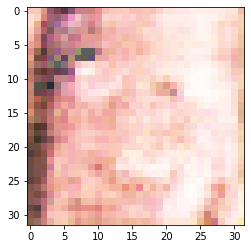

In [13]:
error_d_m4, error_g_m4, prediccion_falsa_m4 = entrenar(gan4, 5000, 150, "resultadosGAN-4/modelo4")

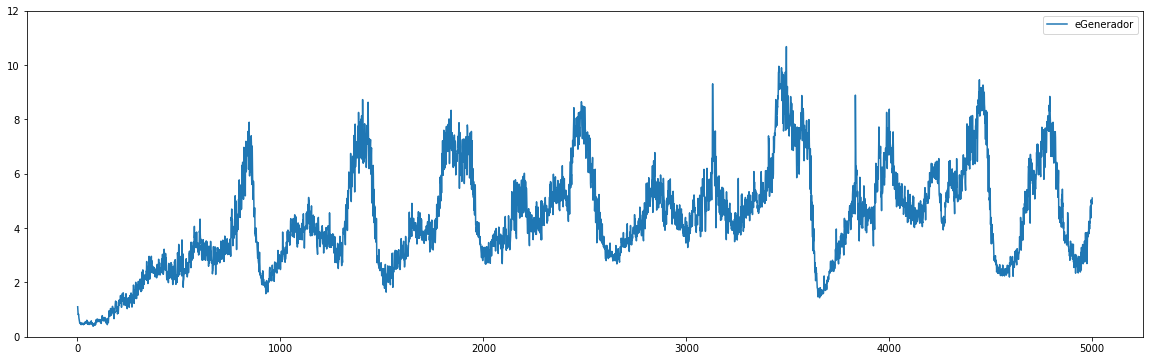

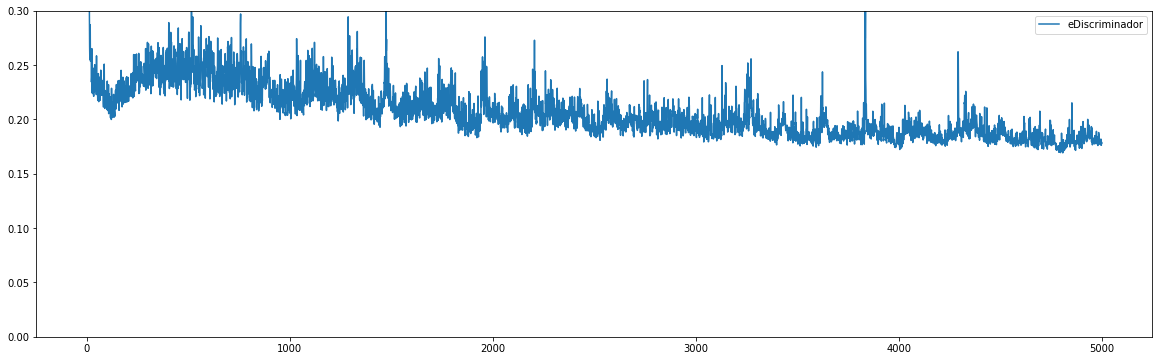

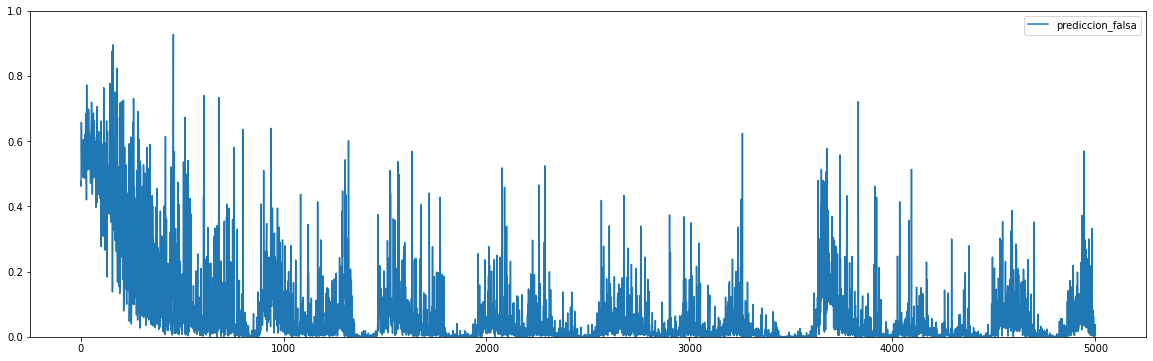

In [15]:
plot_acumulado(len(error_g_m4), 12, eGenerador = error_g_m4)
plot_acumulado(len(error_d_m4), 0.3, eDiscriminador = error_d_m4)
plot_acumulado(len(prediccion_falsa_m4), 1, prediccion_falsa = prediccion_falsa_m4)

tf.Tensor([[0.04480791]], shape=(1, 1), dtype=float32)


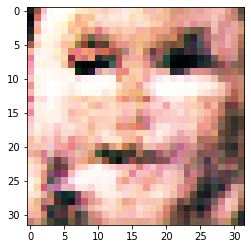

In [34]:
ruido = np.random.normal(0, 1, TAM_ENTRADA)
ruido =np.array([ruido])

predicion(gan4, ruido)

### Quinto modelo

Imagnes de mayor tamaño 64x64, con el optimizador modificado como el modelo 2

Creando set de entrenamiento...
¡Listo!


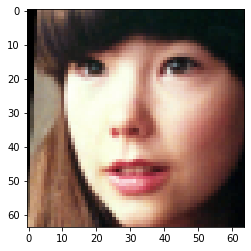

In [10]:
TAM_IMG = 64

x_train = cargar_datos("dataset1")
visualizar_imagen(x_train[12])

In [11]:
OPTIMIZADOR5 = optimizador.Adam(learning_rate=0.0002, beta_1=0.5) 
ERROR5 = 'binary_crossentropy' 

gan5 = crear_GAN(OPTIMIZADOR5, ERROR5)

Generador Creado
Discriminador Creado
GAN Creado


Comenzando Epoca 1... Fin
Tiempo transcurrido:  4.4 s
Tiempo restante aprox: 366.73m -> 6:6h
prediccion de ruido:  [[0.45899284]]
Comenzando Epoca 2... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 220.04m -> 3:40h
prediccion de ruido:  [[0.61169297]]
Comenzando Epoca 3... Fin
Tiempo transcurrido:  2.6 s
Tiempo restante aprox: 216.2m -> 3:36h
prediccion de ruido:  [[0.66540504]]
Comenzando Epoca 4... Fin
Tiempo transcurrido:  2.71 s
Tiempo restante aprox: 225.61m -> 3:45h
prediccion de ruido:  [[0.553388]]
Comenzando Epoca 5... Fin
Tiempo transcurrido:  2.78 s
Tiempo restante aprox: 231.38m -> 3:51h
prediccion de ruido:  [[0.4664084]]
Comenzando Epoca 6... Fin
Tiempo transcurrido:  2.77 s
Tiempo restante aprox: 230.65m -> 3:50h
prediccion de ruido:  [[0.57753545]]
Comenzando Epoca 7... Fin
Tiempo transcurrido:  2.75 s
Tiempo restante aprox: 229.01m -> 3:49h
prediccion de ruido:  [[0.530076]]
Comenzando Epoca 8... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 219.19m

Comenzando Epoca 42... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 214.03m -> 3:34h
prediccion de ruido:  [[0.47507215]]
Comenzando Epoca 43... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 215.52m -> 3:35h
prediccion de ruido:  [[0.5660044]]
Comenzando Epoca 44... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 215.4m -> 3:35h
prediccion de ruido:  [[0.59904665]]
Comenzando Epoca 45... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 213.9m -> 3:33h
prediccion de ruido:  [[0.46635854]]
Comenzando Epoca 46... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 215.15m -> 3:35h
prediccion de ruido:  [[0.6333381]]
Comenzando Epoca 47... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 215.1m -> 3:35h
prediccion de ruido:  [[0.46536162]]
Comenzando Epoca 48... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 216.35m -> 3:36h
prediccion de ruido:  [[0.65127754]]
Comenzando Epoca 49... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante ap

Comenzando Epoca 83... Fin
Tiempo transcurrido:  2.88 s
Tiempo restante aprox: 236.06m -> 3:56h
prediccion de ruido:  [[0.6941635]]
Comenzando Epoca 84... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 214.34m -> 3:34h
prediccion de ruido:  [[0.5839045]]
Comenzando Epoca 85... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 214.99m -> 3:34h
prediccion de ruido:  [[0.4805837]]
Comenzando Epoca 86... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 213.44m -> 3:33h
prediccion de ruido:  [[0.4398641]]
Comenzando Epoca 87... Fin
Tiempo transcurrido:  2.74 s
Tiempo restante aprox: 224.04m -> 3:44h
prediccion de ruido:  [[0.6585618]]
Comenzando Epoca 88... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 217.31m -> 3:37h
prediccion de ruido:  [[0.5025285]]
Comenzando Epoca 89... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 213.8m -> 3:33h
prediccion de ruido:  [[0.3221613]]
Comenzando Epoca 90... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox

Comenzando Epoca 124... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 213.04m -> 3:33h
prediccion de ruido:  [[0.31022453]]
Comenzando Epoca 125... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 212.99m -> 3:32h
prediccion de ruido:  [[0.23665455]]
Comenzando Epoca 126... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 212.15m -> 3:32h
prediccion de ruido:  [[0.30321282]]
Comenzando Epoca 127... Fin
Tiempo transcurrido:  2.72 s
Tiempo restante aprox: 220.59m -> 3:40h
prediccion de ruido:  [[0.2059434]]
Comenzando Epoca 128... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 210.41m -> 3:30h
prediccion de ruido:  [[0.41304135]]
Comenzando Epoca 129... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 216.94m -> 3:36h
prediccion de ruido:  [[0.19151601]]
Comenzando Epoca 130... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 211.51m -> 3:31h
prediccion de ruido:  [[0.43218023]]
Comenzando Epoca 131... Fin
Tiempo transcurrido:  2.62 s
Tiempo

Comenzando Epoca 165... Fin
Tiempo transcurrido:  2.7 s
Tiempo restante aprox: 217.32m -> 3:37h
prediccion de ruido:  [[0.5037458]]
Comenzando Epoca 166... Fin
Tiempo transcurrido:  2.72 s
Tiempo restante aprox: 218.91m -> 3:38h
prediccion de ruido:  [[0.48004806]]
Comenzando Epoca 167... Fin
Tiempo transcurrido:  2.69 s
Tiempo restante aprox: 216.33m -> 3:36h
prediccion de ruido:  [[0.2666664]]
Comenzando Epoca 168... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 212.37m -> 3:32h
prediccion de ruido:  [[0.34816143]]
Comenzando Epoca 169... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 214.47m -> 3:34h
prediccion de ruido:  [[0.24008998]]
Comenzando Epoca 170... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 210.54m -> 3:30h
prediccion de ruido:  [[0.34867477]]
Comenzando Epoca 171... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 209.89m -> 3:29h
prediccion de ruido:  [[0.4666904]]
Comenzando Epoca 172... Fin
Tiempo transcurrido:  2.61 s
Tiempo re

Comenzando Epoca 206... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 210.17m -> 3:30h
prediccion de ruido:  [[0.16474155]]
Comenzando Epoca 207... Fin
Tiempo transcurrido:  2.72 s
Tiempo restante aprox: 217.58m -> 3:37h
prediccion de ruido:  [[0.4266527]]
Comenzando Epoca 208... Fin
Tiempo transcurrido:  2.71 s
Tiempo restante aprox: 216.11m -> 3:36h
prediccion de ruido:  [[0.24236187]]
Comenzando Epoca 209... Fin
Tiempo transcurrido:  2.69 s
Tiempo restante aprox: 215.01m -> 3:35h
prediccion de ruido:  [[0.38976836]]
Comenzando Epoca 210... Fin
Tiempo transcurrido:  2.71 s
Tiempo restante aprox: 216.14m -> 3:36h
prediccion de ruido:  [[0.5688417]]
Comenzando Epoca 211... Fin
Tiempo transcurrido:  2.73 s
Tiempo restante aprox: 217.73m -> 3:37h
prediccion de ruido:  [[0.47868845]]
Comenzando Epoca 212... Fin
Tiempo transcurrido:  2.72 s
Tiempo restante aprox: 216.72m -> 3:36h
prediccion de ruido:  [[0.3173926]]
Comenzando Epoca 213... Fin
Tiempo transcurrido:  2.66 s
Tiempo r

Comenzando Epoca 247... Fin
Tiempo transcurrido:  2.92 s
Tiempo restante aprox: 231.02m -> 3:51h
prediccion de ruido:  [[0.22809377]]
Comenzando Epoca 248... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 209.83m -> 3:29h
prediccion de ruido:  [[0.4869377]]
Comenzando Epoca 249... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 206.33m -> 3:26h
prediccion de ruido:  [[0.269602]]
Comenzando Epoca 250... Fin
Tiempo transcurrido:  2.73 s
Tiempo restante aprox: 216.35m -> 3:36h
prediccion de ruido:  [[0.3199644]]
Comenzando Epoca 251... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 211.69m -> 3:31h
prediccion de ruido:  [[0.41218755]]
Comenzando Epoca 252... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 206.2m -> 3:26h
prediccion de ruido:  [[0.18432584]]
Comenzando Epoca 253... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 208.63m -> 3:28h
prediccion de ruido:  [[0.41120338]]
Comenzando Epoca 254... Fin
Tiempo transcurrido:  2.68 s
Tiempo res

Comenzando Epoca 288... Fin
Tiempo transcurrido:  2.72 s
Tiempo restante aprox: 213.85m -> 3:33h
prediccion de ruido:  [[0.14183581]]
Comenzando Epoca 289... Fin
Tiempo transcurrido:  2.86 s
Tiempo restante aprox: 224.47m -> 3:44h
prediccion de ruido:  [[0.21540192]]
Comenzando Epoca 290... Fin
Tiempo transcurrido:  2.7 s
Tiempo restante aprox: 211.62m -> 3:31h
prediccion de ruido:  [[0.14915848]]
Comenzando Epoca 291... Fin
Tiempo transcurrido:  2.82 s
Tiempo restante aprox: 221.33m -> 3:41h
prediccion de ruido:  [[0.14054495]]
Comenzando Epoca 292... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 207.23m -> 3:27h
prediccion de ruido:  [[0.05571136]]
Comenzando Epoca 293... Fin
Tiempo transcurrido:  3.29 s
Tiempo restante aprox: 257.83m -> 4:17h
prediccion de ruido:  [[0.2534089]]
Comenzando Epoca 294... Fin
Tiempo transcurrido:  2.95 s
Tiempo restante aprox: 231.18m -> 3:51h
prediccion de ruido:  [[0.08942661]]
Comenzando Epoca 295... Fin
Tiempo transcurrido:  2.67 s
Tiempo 

Comenzando Epoca 329... Fin
Tiempo transcurrido:  2.7 s
Tiempo restante aprox: 210.08m -> 3:30h
prediccion de ruido:  [[0.06593233]]
Comenzando Epoca 330... Fin
Tiempo transcurrido:  2.73 s
Tiempo restante aprox: 212.79m -> 3:32h
prediccion de ruido:  [[0.05078354]]
Comenzando Epoca 331... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 207.26m -> 3:27h
prediccion de ruido:  [[0.2237804]]
Comenzando Epoca 332... Fin
Tiempo transcurrido:  2.72 s
Tiempo restante aprox: 211.74m -> 3:31h
prediccion de ruido:  [[0.04755607]]
Comenzando Epoca 333... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 206.51m -> 3:26h
prediccion de ruido:  [[0.18725526]]
Comenzando Epoca 334... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 207.72m -> 3:27h
prediccion de ruido:  [[0.03000522]]
Comenzando Epoca 335... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 206.47m -> 3:26h
prediccion de ruido:  [[0.12213272]]
Comenzando Epoca 336... Fin
Tiempo transcurrido:  2.79 s
Tiempo 

Comenzando Epoca 370... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 201.08m -> 3:21h
prediccion de ruido:  [[0.3802672]]
Comenzando Epoca 371... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 201.27m -> 3:21h
prediccion de ruido:  [[0.0441269]]
Comenzando Epoca 372... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 201.15m -> 3:21h
prediccion de ruido:  [[0.1429618]]
Comenzando Epoca 373... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 199.75m -> 3:19h
prediccion de ruido:  [[0.06113663]]
Comenzando Epoca 374... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 200.91m -> 3:20h
prediccion de ruido:  [[0.08588353]]
Comenzando Epoca 375... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 199.66m -> 3:19h
prediccion de ruido:  [[0.19008887]]
Comenzando Epoca 376... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 200.82m -> 3:20h
prediccion de ruido:  [[0.21832934]]
Comenzando Epoca 377... Fin
Tiempo transcurrido:  2.59 s
Tiempo r

Comenzando Epoca 411... Fin
Tiempo transcurrido:  2.75 s
Tiempo restante aprox: 210.57m -> 3:30h
prediccion de ruido:  [[0.00944304]]
Comenzando Epoca 412... Fin
Tiempo transcurrido:  2.93 s
Tiempo restante aprox: 224.43m -> 3:44h
prediccion de ruido:  [[0.0407829]]
Comenzando Epoca 413... Fin
Tiempo transcurrido:  2.7 s
Tiempo restante aprox: 206.58m -> 3:26h
prediccion de ruido:  [[0.0597631]]
Comenzando Epoca 414... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 201.58m -> 3:21h
prediccion de ruido:  [[0.0209097]]
Comenzando Epoca 415... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 203.36m -> 3:23h
prediccion de ruido:  [[0.00377879]]
Comenzando Epoca 416... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 200.0m -> 3:19h
prediccion de ruido:  [[0.05733916]]
Comenzando Epoca 417... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 202.2m -> 3:22h
prediccion de ruido:  [[0.04366881]]
Comenzando Epoca 418... Fin
Tiempo transcurrido:  2.61 s
Tiempo rest

Comenzando Epoca 452... Fin
Tiempo transcurrido:  2.75 s
Tiempo restante aprox: 208.27m -> 3:28h
prediccion de ruido:  [[0.04941615]]
Comenzando Epoca 453... Fin
Tiempo transcurrido:  3.06 s
Tiempo restante aprox: 231.79m -> 3:51h
prediccion de ruido:  [[0.16911125]]
Comenzando Epoca 454... Fin
Tiempo transcurrido:  2.75 s
Tiempo restante aprox: 208.12m -> 3:28h
prediccion de ruido:  [[0.01829058]]
Comenzando Epoca 455... Fin
Tiempo transcurrido:  3.04 s
Tiempo restante aprox: 230.52m -> 3:50h
prediccion de ruido:  [[0.27732855]]
Comenzando Epoca 456... Fin
Tiempo transcurrido:  2.78 s
Tiempo restante aprox: 210.71m -> 3:30h
prediccion de ruido:  [[0.01027888]]
Comenzando Epoca 457... Fin
Tiempo transcurrido:  3.28 s
Tiempo restante aprox: 248.28m -> 4:8h
prediccion de ruido:  [[0.19517845]]
Comenzando Epoca 458... Fin
Tiempo transcurrido:  2.86 s
Tiempo restante aprox: 216.57m -> 3:36h
prediccion de ruido:  [[0.07289401]]
Comenzando Epoca 459... Fin
Tiempo transcurrido:  2.87 s
Tiempo

Comenzando Epoca 493... Fin
Tiempo transcurrido:  2.69 s
Tiempo restante aprox: 201.83m -> 3:21h
prediccion de ruido:  [[0.05023053]]
Comenzando Epoca 494... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 199.98m -> 3:19h
prediccion de ruido:  [[0.10621718]]
Comenzando Epoca 495... Fin
Tiempo transcurrido:  2.69 s
Tiempo restante aprox: 201.81m -> 3:21h
prediccion de ruido:  [[0.36200446]]
Comenzando Epoca 496... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 200.12m -> 3:20h
prediccion de ruido:  [[0.0431495]]
Comenzando Epoca 497... Fin
Tiempo transcurrido:  2.68 s
Tiempo restante aprox: 200.82m -> 3:20h
prediccion de ruido:  [[0.05104229]]
Comenzando Epoca 498... Fin
Tiempo transcurrido:  2.71 s
Tiempo restante aprox: 203.18m -> 3:23h
prediccion de ruido:  [[0.03093845]]
Comenzando Epoca 499... Fin
Tiempo transcurrido:  2.85 s
Tiempo restante aprox: 213.49m -> 3:33h
prediccion de ruido:  [[0.0134635]]
Comenzando Epoca 500... Fin
Tiempo transcurrido:  2.83 s
Tiempo 

Comenzando Epoca 534... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 197.46m -> 3:17h
prediccion de ruido:  [[0.04393533]]
Comenzando Epoca 535... Fin
Tiempo transcurrido:  2.86 s
Tiempo restante aprox: 213.12m -> 3:33h
prediccion de ruido:  [[0.11477554]]
Comenzando Epoca 536... Fin
Tiempo transcurrido:  2.69 s
Tiempo restante aprox: 199.98m -> 3:19h
prediccion de ruido:  [[0.0458672]]
Comenzando Epoca 537... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 198.59m -> 3:18h
prediccion de ruido:  [[0.05226588]]
Comenzando Epoca 538... Fin
Tiempo transcurrido:  2.7 s
Tiempo restante aprox: 200.63m -> 3:20h
prediccion de ruido:  [[0.07449502]]
Comenzando Epoca 539... Fin
Tiempo transcurrido:  2.7 s
Tiempo restante aprox: 200.88m -> 3:20h
prediccion de ruido:  [[0.03725985]]
Comenzando Epoca 540... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 196.75m -> 3:16h
prediccion de ruido:  [[0.0573152]]
Comenzando Epoca 541... Fin
Tiempo transcurrido:  2.72 s
Tiempo re

Comenzando Epoca 575... Fin
Tiempo transcurrido:  2.97 s
Tiempo restante aprox: 219.18m -> 3:39h
prediccion de ruido:  [[0.00972271]]
Comenzando Epoca 576... Fin
Tiempo transcurrido:  2.83 s
Tiempo restante aprox: 209.03m -> 3:29h
prediccion de ruido:  [[0.00739726]]
Comenzando Epoca 577... Fin
Tiempo transcurrido:  2.69 s
Tiempo restante aprox: 197.99m -> 3:17h
prediccion de ruido:  [[0.03971285]]
Comenzando Epoca 578... Fin
Tiempo transcurrido:  2.71 s
Tiempo restante aprox: 199.42m -> 3:19h
prediccion de ruido:  [[0.06664848]]
Comenzando Epoca 579... Fin
Tiempo transcurrido:  2.72 s
Tiempo restante aprox: 200.71m -> 3:20h
prediccion de ruido:  [[0.0846251]]
Comenzando Epoca 580... Fin
Tiempo transcurrido:  2.82 s
Tiempo restante aprox: 207.96m -> 3:27h
prediccion de ruido:  [[0.00454864]]
Comenzando Epoca 581... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 194.06m -> 3:14h
prediccion de ruido:  [[0.01292524]]
Comenzando Epoca 582... Fin
Tiempo transcurrido:  2.86 s
Tiempo

Comenzando Epoca 616... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 191.79m -> 3:11h
prediccion de ruido:  [[0.212482]]
Comenzando Epoca 617... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 191.6m -> 3:11h
prediccion de ruido:  [[0.07624775]]
Comenzando Epoca 618... Fin
Tiempo transcurrido:  2.78 s
Tiempo restante aprox: 203.25m -> 3:23h
prediccion de ruido:  [[0.01591602]]
Comenzando Epoca 619... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 191.29m -> 3:11h
prediccion de ruido:  [[0.09467676]]
Comenzando Epoca 620... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 191.91m -> 3:11h
prediccion de ruido:  [[0.09140339]]
Comenzando Epoca 621... Fin
Tiempo transcurrido:  2.71 s
Tiempo restante aprox: 198.14m -> 3:18h
prediccion de ruido:  [[0.00739601]]
Comenzando Epoca 622... Fin
Tiempo transcurrido:  2.75 s
Tiempo restante aprox: 200.43m -> 3:20h
prediccion de ruido:  [[0.12570912]]
Comenzando Epoca 623... Fin
Tiempo transcurrido:  2.77 s
Tiempo r

Comenzando Epoca 657... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 188.62m -> 3:8h
prediccion de ruido:  [[0.0770517]]
Comenzando Epoca 658... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 188.65m -> 3:8h
prediccion de ruido:  [[0.00446755]]
Comenzando Epoca 659... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 188.54m -> 3:8h
prediccion de ruido:  [[0.0025022]]
Comenzando Epoca 660... Fin
Tiempo transcurrido:  2.76 s
Tiempo restante aprox: 199.9m -> 3:19h
prediccion de ruido:  [[0.00372064]]
Comenzando Epoca 661... Fin
Tiempo transcurrido:  2.76 s
Tiempo restante aprox: 199.77m -> 3:19h
prediccion de ruido:  [[0.0317775]]
Comenzando Epoca 662... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 188.55m -> 3:8h
prediccion de ruido:  [[0.02791882]]
Comenzando Epoca 663... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 188.73m -> 3:8h
prediccion de ruido:  [[0.02082866]]
Comenzando Epoca 664... Fin
Tiempo transcurrido:  2.64 s
Tiempo restant

Comenzando Epoca 698... Fin
Tiempo transcurrido:  2.73 s
Tiempo restante aprox: 195.78m -> 3:15h
prediccion de ruido:  [[0.01162034]]
Comenzando Epoca 699... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 190.99m -> 3:10h
prediccion de ruido:  [[0.01637471]]
Comenzando Epoca 700... Fin
Tiempo transcurrido:  2.79 s
Tiempo restante aprox: 199.72m -> 3:19h
prediccion de ruido:  [[0.00501981]]
Comenzando Epoca 701... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 190.5m -> 3:10h
prediccion de ruido:  [[0.12936804]]
Comenzando Epoca 702... Fin
Tiempo transcurrido:  2.72 s
Tiempo restante aprox: 195.18m -> 3:15h
prediccion de ruido:  [[0.00132087]]
Comenzando Epoca 703... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 189.05m -> 3:9h
prediccion de ruido:  [[0.05488229]]
Comenzando Epoca 704... Fin
Tiempo transcurrido:  2.8 s
Tiempo restante aprox: 200.78m -> 3:20h
prediccion de ruido:  [[0.01221132]]
Comenzando Epoca 705... Fin
Tiempo transcurrido:  2.63 s
Tiempo r

Comenzando Epoca 739... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 185.13m -> 3:5h
prediccion de ruido:  [[0.02733049]]
Comenzando Epoca 740... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 183.98m -> 3:3h
prediccion de ruido:  [[0.01214045]]
Comenzando Epoca 741... Fin
Tiempo transcurrido:  2.76 s
Tiempo restante aprox: 196.07m -> 3:16h
prediccion de ruido:  [[0.00343126]]
Comenzando Epoca 742... Fin
Tiempo transcurrido:  2.86 s
Tiempo restante aprox: 203.06m -> 3:23h
prediccion de ruido:  [[0.0052793]]
Comenzando Epoca 743... Fin
Tiempo transcurrido:  2.86 s
Tiempo restante aprox: 203.14m -> 3:23h
prediccion de ruido:  [[0.00767738]]
Comenzando Epoca 744... Fin
Tiempo transcurrido:  2.71 s
Tiempo restante aprox: 192.4m -> 3:12h
prediccion de ruido:  [[0.24095586]]
Comenzando Epoca 745... Fin
Tiempo transcurrido:  2.77 s
Tiempo restante aprox: 196.36m -> 3:16h
prediccion de ruido:  [[0.00530508]]
Comenzando Epoca 746... Fin
Tiempo transcurrido:  2.9 s
Tiempo res

Comenzando Epoca 780... Fin
Tiempo transcurrido:  2.7 s
Tiempo restante aprox: 189.66m -> 3:9h
prediccion de ruido:  [[0.00351623]]
Comenzando Epoca 781... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 185.6m -> 3:5h
prediccion de ruido:  [[0.04737452]]
Comenzando Epoca 782... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 186.91m -> 3:6h
prediccion de ruido:  [[0.00817019]]
Comenzando Epoca 783... Fin
Tiempo transcurrido:  2.83 s
Tiempo restante aprox: 199.02m -> 3:19h
prediccion de ruido:  [[0.00239715]]
Comenzando Epoca 784... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 184.41m -> 3:4h
prediccion de ruido:  [[0.02680516]]
Comenzando Epoca 785... Fin
Tiempo transcurrido:  2.78 s
Tiempo restante aprox: 195.22m -> 3:15h
prediccion de ruido:  [[0.00785488]]
Comenzando Epoca 786... Fin
Tiempo transcurrido:  2.89 s
Tiempo restante aprox: 203.18m -> 3:23h
prediccion de ruido:  [[0.00774142]]
Comenzando Epoca 787... Fin
Tiempo transcurrido:  2.9 s
Tiempo resta

Comenzando Epoca 821... Fin
Tiempo transcurrido:  2.8 s
Tiempo restante aprox: 195.16m -> 3:15h
prediccion de ruido:  [[0.00555667]]
Comenzando Epoca 822... Fin
Tiempo transcurrido:  2.76 s
Tiempo restante aprox: 192.18m -> 3:12h
prediccion de ruido:  [[0.00747356]]
Comenzando Epoca 823... Fin
Tiempo transcurrido:  2.87 s
Tiempo restante aprox: 200.08m -> 3:20h
prediccion de ruido:  [[0.00795084]]
Comenzando Epoca 824... Fin
Tiempo transcurrido:  3.08 s
Tiempo restante aprox: 214.3m -> 3:34h
prediccion de ruido:  [[0.020322]]
Comenzando Epoca 825... Fin
Tiempo transcurrido:  2.74 s
Tiempo restante aprox: 190.86m -> 3:10h
prediccion de ruido:  [[0.2237665]]
Comenzando Epoca 826... Fin
Tiempo transcurrido:  2.72 s
Tiempo restante aprox: 189.15m -> 3:9h
prediccion de ruido:  [[0.01241866]]
Comenzando Epoca 827... Fin
Tiempo transcurrido:  2.76 s
Tiempo restante aprox: 191.95m -> 3:11h
prediccion de ruido:  [[0.00126758]]
Comenzando Epoca 828... Fin
Tiempo transcurrido:  2.75 s
Tiempo rest

Comenzando Epoca 862... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 181.88m -> 3:1h
prediccion de ruido:  [[0.01444954]]
Comenzando Epoca 863... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 181.9m -> 3:1h
prediccion de ruido:  [[0.00897294]]
Comenzando Epoca 864... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 184.08m -> 3:4h
prediccion de ruido:  [[0.00015453]]
Comenzando Epoca 865... Fin
Tiempo transcurrido:  2.79 s
Tiempo restante aprox: 192.22m -> 3:12h
prediccion de ruido:  [[0.00781608]]
Comenzando Epoca 866... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 183.85m -> 3:3h
prediccion de ruido:  [[0.02188075]]
Comenzando Epoca 867... Fin
Tiempo transcurrido:  2.68 s
Tiempo restante aprox: 184.94m -> 3:4h
prediccion de ruido:  [[0.02213997]]
Comenzando Epoca 868... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 180.54m -> 3:0h
prediccion de ruido:  [[0.02568159]]
Comenzando Epoca 869... Fin
Tiempo transcurrido:  2.65 s
Tiempo resta

Comenzando Epoca 903... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 177.94m -> 2:57h
prediccion de ruido:  [[0.00470746]]
Comenzando Epoca 904... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 176.83m -> 2:56h
prediccion de ruido:  [[0.00126612]]
Comenzando Epoca 905... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 177.86m -> 2:57h
prediccion de ruido:  [[0.00156957]]
Comenzando Epoca 906... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 177.81m -> 2:57h
prediccion de ruido:  [[0.00632775]]
Comenzando Epoca 907... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 178.83m -> 2:58h
prediccion de ruido:  [[0.00457585]]
Comenzando Epoca 908... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 177.73m -> 2:57h
prediccion de ruido:  [[0.11077306]]
Comenzando Epoca 909... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 177.68m -> 2:57h
prediccion de ruido:  [[0.15744683]]
Comenzando Epoca 910... Fin
Tiempo transcurrido:  2.6 s
Tiempo

Comenzando Epoca 944... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 176.16m -> 2:56h
prediccion de ruido:  [[0.01503089]]
Comenzando Epoca 945... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 177.17m -> 2:57h
prediccion de ruido:  [[0.01146081]]
Comenzando Epoca 946... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 176.33m -> 2:56h
prediccion de ruido:  [[0.00715488]]
Comenzando Epoca 947... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 177.08m -> 2:57h
prediccion de ruido:  [[0.00310966]]
Comenzando Epoca 948... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 177.04m -> 2:57h
prediccion de ruido:  [[0.00453845]]
Comenzando Epoca 949... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 178.05m -> 2:58h
prediccion de ruido:  [[0.00200123]]
Comenzando Epoca 950... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 179.06m -> 2:59h
prediccion de ruido:  [[0.01339814]]
Comenzando Epoca 951... Fin
Tiempo transcurrido:  2.65 s
Tiemp

Comenzando Epoca 985... Fin
Tiempo transcurrido:  2.8 s
Tiempo restante aprox: 187.28m -> 3:7h
prediccion de ruido:  [[0.15194425]]
Comenzando Epoca 986... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 177.56m -> 2:57h
prediccion de ruido:  [[0.00542307]]
Comenzando Epoca 987... Fin
Tiempo transcurrido:  2.69 s
Tiempo restante aprox: 180.18m -> 3:0h
prediccion de ruido:  [[0.00983727]]
Comenzando Epoca 988... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 177.26m -> 2:57h
prediccion de ruido:  [[0.00382102]]
Comenzando Epoca 989... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 174.86m -> 2:54h
prediccion de ruido:  [[0.09281182]]
Comenzando Epoca 990... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 176.8m -> 2:56h
prediccion de ruido:  [[0.0034745]]
Comenzando Epoca 991... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 175.58m -> 2:55h
prediccion de ruido:  [[0.04099426]]
Comenzando Epoca 992... Fin
Tiempo transcurrido:  2.63 s
Tiempo res

Comenzando Epoca 1026... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 174.85m -> 2:54h
prediccion de ruido:  [[0.09613147]]
Comenzando Epoca 1027... Fin
Tiempo transcurrido:  2.68 s
Tiempo restante aprox: 177.55m -> 2:57h
prediccion de ruido:  [[0.00485125]]
Comenzando Epoca 1028... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 174.87m -> 2:54h
prediccion de ruido:  [[0.02369186]]
Comenzando Epoca 1029... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 176.88m -> 2:56h
prediccion de ruido:  [[0.00923464]]
Comenzando Epoca 1030... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 175.26m -> 2:55h
prediccion de ruido:  [[0.10317627]]
Comenzando Epoca 1031... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 176.41m -> 2:56h
prediccion de ruido:  [[0.01181358]]
Comenzando Epoca 1032... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 173.53m -> 2:53h
prediccion de ruido:  [[0.02105823]]
Comenzando Epoca 1033... Fin
Tiempo transcurrido:  2.8 

Comenzando Epoca 1067... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 174.41m -> 2:54h
prediccion de ruido:  [[0.0069001]]
Comenzando Epoca 1068... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 172.27m -> 2:52h
prediccion de ruido:  [[0.07353821]]
Comenzando Epoca 1069... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 171.49m -> 2:51h
prediccion de ruido:  [[0.01097032]]
Comenzando Epoca 1070... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 172.21m -> 2:52h
prediccion de ruido:  [[0.02991015]]
Comenzando Epoca 1071... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 171.02m -> 2:51h
prediccion de ruido:  [[0.04424834]]
Comenzando Epoca 1072... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 173.65m -> 2:53h
prediccion de ruido:  [[0.09304312]]
Comenzando Epoca 1073... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 171.51m -> 2:51h
prediccion de ruido:  [[0.01915777]]
Comenzando Epoca 1074... Fin
Tiempo transcurrido:  2.63 

Comenzando Epoca 1108... Fin
Tiempo transcurrido:  2.69 s
Tiempo restante aprox: 174.54m -> 2:54h
prediccion de ruido:  [[0.01283863]]
Comenzando Epoca 1109... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 170.97m -> 2:50h
prediccion de ruido:  [[0.02186799]]
Comenzando Epoca 1110... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 171.8m -> 2:51h
prediccion de ruido:  [[0.01777628]]
Comenzando Epoca 1111... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 171.24m -> 2:51h
prediccion de ruido:  [[0.02465829]]
Comenzando Epoca 1112... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 171.44m -> 2:51h
prediccion de ruido:  [[0.00199297]]
Comenzando Epoca 1113... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 170.48m -> 2:50h
prediccion de ruido:  [[0.19609407]]
Comenzando Epoca 1114... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 170.94m -> 2:50h
prediccion de ruido:  [[0.04953822]]
Comenzando Epoca 1115... Fin
Tiempo transcurrido:  2.63 

Comenzando Epoca 1149... Fin
Tiempo transcurrido:  2.7 s
Tiempo restante aprox: 173.06m -> 2:53h
prediccion de ruido:  [[0.02674246]]
Comenzando Epoca 1150... Fin
Tiempo transcurrido:  2.77 s
Tiempo restante aprox: 177.99m -> 2:57h
prediccion de ruido:  [[0.03687382]]
Comenzando Epoca 1151... Fin
Tiempo transcurrido:  2.76 s
Tiempo restante aprox: 177.34m -> 2:57h
prediccion de ruido:  [[0.00279894]]
Comenzando Epoca 1152... Fin
Tiempo transcurrido:  2.86 s
Tiempo restante aprox: 183.17m -> 3:3h
prediccion de ruido:  [[0.01851484]]
Comenzando Epoca 1153... Fin
Tiempo transcurrido:  2.84 s
Tiempo restante aprox: 182.41m -> 3:2h
prediccion de ruido:  [[0.00627735]]
Comenzando Epoca 1154... Fin
Tiempo transcurrido:  2.9 s
Tiempo restante aprox: 185.64m -> 3:5h
prediccion de ruido:  [[0.0099301]]
Comenzando Epoca 1155... Fin
Tiempo transcurrido:  3.02 s
Tiempo restante aprox: 193.8m -> 3:13h
prediccion de ruido:  [[0.00933278]]
Comenzando Epoca 1156... Fin
Tiempo transcurrido:  3.48 s
Tiem

Comenzando Epoca 1190... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 167.58m -> 2:47h
prediccion de ruido:  [[0.00946471]]
Comenzando Epoca 1191... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 168.4m -> 2:48h
prediccion de ruido:  [[0.00522566]]
Comenzando Epoca 1192... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 167.37m -> 2:47h
prediccion de ruido:  [[0.00409308]]
Comenzando Epoca 1193... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 167.39m -> 2:47h
prediccion de ruido:  [[0.00413999]]
Comenzando Epoca 1194... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 168.4m -> 2:48h
prediccion de ruido:  [[0.0134975]]
Comenzando Epoca 1195... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 167.95m -> 2:47h
prediccion de ruido:  [[0.00415468]]
Comenzando Epoca 1196... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 168.34m -> 2:48h
prediccion de ruido:  [[0.00025892]]
Comenzando Epoca 1197... Fin
Tiempo transcurrido:  2.94 s


Comenzando Epoca 1231... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 163.75m -> 2:43h
prediccion de ruido:  [[6.658069e-05]]
Comenzando Epoca 1232... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 164.62m -> 2:44h
prediccion de ruido:  [[0.00196567]]
Comenzando Epoca 1233... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 164.58m -> 2:44h
prediccion de ruido:  [[0.00185511]]
Comenzando Epoca 1234... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 163.55m -> 2:43h
prediccion de ruido:  [[0.00204799]]
Comenzando Epoca 1235... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 167.43m -> 2:47h
prediccion de ruido:  [[6.326076e-05]]
Comenzando Epoca 1236... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 164.51m -> 2:44h
prediccion de ruido:  [[0.00117725]]
Comenzando Epoca 1237... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 163.55m -> 2:43h
prediccion de ruido:  [[0.00427666]]
Comenzando Epoca 1238... Fin
Tiempo transcurrido:  

Comenzando Epoca 1272... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 163.9m -> 2:43h
prediccion de ruido:  [[0.0003646]]
Comenzando Epoca 1273... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 165.74m -> 2:45h
prediccion de ruido:  [[0.01291019]]
Comenzando Epoca 1274... Fin
Tiempo transcurrido:  2.75 s
Tiempo restante aprox: 170.54m -> 2:50h
prediccion de ruido:  [[0.0011586]]
Comenzando Epoca 1275... Fin
Tiempo transcurrido:  3.4 s
Tiempo restante aprox: 211.08m -> 3:31h
prediccion de ruido:  [[0.00070959]]
Comenzando Epoca 1276... Fin
Tiempo transcurrido:  2.83 s
Tiempo restante aprox: 175.91m -> 2:55h
prediccion de ruido:  [[0.00072429]]
Comenzando Epoca 1277... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 161.69m -> 2:41h
prediccion de ruido:  [[0.00745177]]
Comenzando Epoca 1278... Fin
Tiempo transcurrido:  2.86 s
Tiempo restante aprox: 177.36m -> 2:57h
prediccion de ruido:  [[0.00295848]]
Comenzando Epoca 1279... Fin
Tiempo transcurrido:  2.63 s
T

Comenzando Epoca 1313... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 160.12m -> 2:40h
prediccion de ruido:  [[0.00693417]]
Comenzando Epoca 1314... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 160.09m -> 2:40h
prediccion de ruido:  [[0.00103304]]
Comenzando Epoca 1315... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 160.04m -> 2:40h
prediccion de ruido:  [[0.00089756]]
Comenzando Epoca 1316... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 160.31m -> 2:40h
prediccion de ruido:  [[0.00395232]]
Comenzando Epoca 1317... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 159.96m -> 2:39h
prediccion de ruido:  [[0.00022572]]
Comenzando Epoca 1318... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 159.91m -> 2:39h
prediccion de ruido:  [[0.03691456]]
Comenzando Epoca 1319... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 159.87m -> 2:39h
prediccion de ruido:  [[0.00032648]]
Comenzando Epoca 1320... Fin
Tiempo transcurrido:  2.61

Comenzando Epoca 1354... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 158.35m -> 2:38h
prediccion de ruido:  [[0.00127515]]
Comenzando Epoca 1355... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 158.31m -> 2:38h
prediccion de ruido:  [[0.00399497]]
Comenzando Epoca 1356... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 159.39m -> 2:39h
prediccion de ruido:  [[0.00133646]]
Comenzando Epoca 1357... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 159.17m -> 2:39h
prediccion de ruido:  [[0.00667807]]
Comenzando Epoca 1358... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 158.18m -> 2:38h
prediccion de ruido:  [[0.00012788]]
Comenzando Epoca 1359... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 158.13m -> 2:38h
prediccion de ruido:  [[0.01466975]]
Comenzando Epoca 1360... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 159.04m -> 2:39h
prediccion de ruido:  [[4.5066477e-05]]
Comenzando Epoca 1361... Fin
Tiempo transcurrido:  2

Comenzando Epoca 1395... Fin
Tiempo transcurrido:  2.68 s
Tiempo restante aprox: 161.26m -> 2:41h
prediccion de ruido:  [[0.01589489]]
Comenzando Epoca 1396... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 160.28m -> 2:40h
prediccion de ruido:  [[0.00199929]]
Comenzando Epoca 1397... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 159.29m -> 2:39h
prediccion de ruido:  [[0.0120118]]
Comenzando Epoca 1398... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 159.25m -> 2:39h
prediccion de ruido:  [[0.00439429]]
Comenzando Epoca 1399... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 157.33m -> 2:37h
prediccion de ruido:  [[0.00127283]]
Comenzando Epoca 1400... Fin
Tiempo transcurrido:  2.81 s
Tiempo restante aprox: 168.52m -> 2:48h
prediccion de ruido:  [[0.00166976]]
Comenzando Epoca 1401... Fin
Tiempo transcurrido:  2.75 s
Tiempo restante aprox: 164.79m -> 2:44h
prediccion de ruido:  [[0.00144586]]
Comenzando Epoca 1402... Fin
Tiempo transcurrido:  2.7 s

Comenzando Epoca 1436... Fin
Tiempo transcurrido:  2.73 s
Tiempo restante aprox: 162.33m -> 2:42h
prediccion de ruido:  [[0.00189355]]
Comenzando Epoca 1437... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 154.75m -> 2:34h
prediccion de ruido:  [[0.02461898]]
Comenzando Epoca 1438... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 155.63m -> 2:35h
prediccion de ruido:  [[0.07769474]]
Comenzando Epoca 1439... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 155.59m -> 2:35h
prediccion de ruido:  [[0.10845432]]
Comenzando Epoca 1440... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 157.4m -> 2:37h
prediccion de ruido:  [[0.0049836]]
Comenzando Epoca 1441... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 156.71m -> 2:36h
prediccion de ruido:  [[0.00353533]]
Comenzando Epoca 1442... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 157.59m -> 2:37h
prediccion de ruido:  [[0.00746691]]
Comenzando Epoca 1443... Fin
Tiempo transcurrido:  2.62 s

Comenzando Epoca 1477... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 154.84m -> 2:34h
prediccion de ruido:  [[0.03669319]]
Comenzando Epoca 1478... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 152.97m -> 2:32h
prediccion de ruido:  [[0.03473565]]
Comenzando Epoca 1479... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 155.67m -> 2:35h
prediccion de ruido:  [[0.01114592]]
Comenzando Epoca 1480... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 153.91m -> 2:33h
prediccion de ruido:  [[0.01556158]]
Comenzando Epoca 1481... Fin
Tiempo transcurrido:  2.69 s
Tiempo restante aprox: 157.68m -> 2:37h
prediccion de ruido:  [[0.0171766]]
Comenzando Epoca 1482... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 154.62m -> 2:34h
prediccion de ruido:  [[0.01577622]]
Comenzando Epoca 1483... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 155.49m -> 2:35h
prediccion de ruido:  [[0.05074903]]
Comenzando Epoca 1484... Fin
Tiempo transcurrido:  2.61 

Comenzando Epoca 1518... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 151.23m -> 2:31h
prediccion de ruido:  [[0.18745318]]
Comenzando Epoca 1519... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 151.19m -> 2:31h
prediccion de ruido:  [[0.01625264]]
Comenzando Epoca 1520... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 151.14m -> 2:31h
prediccion de ruido:  [[0.0649845]]
Comenzando Epoca 1521... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 152.01m -> 2:32h
prediccion de ruido:  [[0.02719018]]
Comenzando Epoca 1522... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 150.44m -> 2:30h
prediccion de ruido:  [[0.10352883]]
Comenzando Epoca 1523... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 151.92m -> 2:31h
prediccion de ruido:  [[0.02428457]]
Comenzando Epoca 1524... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 150.97m -> 2:30h
prediccion de ruido:  [[0.00773996]]
Comenzando Epoca 1525... Fin
Tiempo transcurrido:  2.61 

Comenzando Epoca 1559... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 152.14m -> 2:32h
prediccion de ruido:  [[0.01507291]]
Comenzando Epoca 1560... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 151.31m -> 2:31h
prediccion de ruido:  [[0.02753532]]
Comenzando Epoca 1561... Fin
Tiempo transcurrido:  2.68 s
Tiempo restante aprox: 153.84m -> 2:33h
prediccion de ruido:  [[0.02720508]]
Comenzando Epoca 1562... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 150.22m -> 2:30h
prediccion de ruido:  [[0.05145785]]
Comenzando Epoca 1563... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 151.07m -> 2:31h
prediccion de ruido:  [[0.00735632]]
Comenzando Epoca 1564... Fin
Tiempo transcurrido:  2.7 s
Tiempo restante aprox: 154.83m -> 2:34h
prediccion de ruido:  [[0.10918894]]
Comenzando Epoca 1565... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 152.82m -> 2:32h
prediccion de ruido:  [[0.03323486]]
Comenzando Epoca 1566... Fin
Tiempo transcurrido:  2.64 

Comenzando Epoca 1600... Fin
Tiempo transcurrido:  2.79 s
Tiempo restante aprox: 158.3m -> 2:38h
prediccion de ruido:  [[0.09305722]]
Comenzando Epoca 1601... Fin
Tiempo transcurrido:  2.69 s
Tiempo restante aprox: 152.18m -> 2:32h
prediccion de ruido:  [[0.00126615]]
Comenzando Epoca 1602... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 148.48m -> 2:28h
prediccion de ruido:  [[0.05117437]]
Comenzando Epoca 1603... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 148.44m -> 2:28h
prediccion de ruido:  [[0.00936547]]
Comenzando Epoca 1604... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 147.63m -> 2:27h
prediccion de ruido:  [[0.0758644]]
Comenzando Epoca 1605... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 148.35m -> 2:28h
prediccion de ruido:  [[0.00461966]]
Comenzando Epoca 1606... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 147.43m -> 2:27h
prediccion de ruido:  [[0.00067139]]
Comenzando Epoca 1607... Fin
Tiempo transcurrido:  2.61 s

Comenzando Epoca 1641... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 148.92m -> 2:28h
prediccion de ruido:  [[0.00475138]]
Comenzando Epoca 1642... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 148.07m -> 2:28h
prediccion de ruido:  [[0.01220527]]
Comenzando Epoca 1643... Fin
Tiempo transcurrido:  2.69 s
Tiempo restante aprox: 150.72m -> 2:30h
prediccion de ruido:  [[0.00039002]]
Comenzando Epoca 1644... Fin
Tiempo transcurrido:  2.72 s
Tiempo restante aprox: 152.16m -> 2:32h
prediccion de ruido:  [[0.01808131]]
Comenzando Epoca 1645... Fin
Tiempo transcurrido:  2.81 s
Tiempo restante aprox: 157.08m -> 2:37h
prediccion de ruido:  [[0.0351682]]
Comenzando Epoca 1646... Fin
Tiempo transcurrido:  2.73 s
Tiempo restante aprox: 152.39m -> 2:32h
prediccion de ruido:  [[0.04459101]]
Comenzando Epoca 1647... Fin
Tiempo transcurrido:  2.75 s
Tiempo restante aprox: 153.68m -> 2:33h
prediccion de ruido:  [[0.02561375]]
Comenzando Epoca 1648... Fin
Tiempo transcurrido:  2.62 

Comenzando Epoca 1682... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 144.76m -> 2:24h
prediccion de ruido:  [[0.01518419]]
Comenzando Epoca 1683... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 145.17m -> 2:25h
prediccion de ruido:  [[0.00885931]]
Comenzando Epoca 1684... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 144.06m -> 2:24h
prediccion de ruido:  [[0.02976057]]
Comenzando Epoca 1685... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 144.0m -> 2:23h
prediccion de ruido:  [[0.00284824]]
Comenzando Epoca 1686... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 143.95m -> 2:23h
prediccion de ruido:  [[0.00293714]]
Comenzando Epoca 1687... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 144.77m -> 2:24h
prediccion de ruido:  [[0.00109729]]
Comenzando Epoca 1688... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 143.87m -> 2:23h
prediccion de ruido:  [[0.01791346]]
Comenzando Epoca 1689... Fin
Tiempo transcurrido:  2.61 

Comenzando Epoca 1723... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 144.15m -> 2:24h
prediccion de ruido:  [[0.01024321]]
Comenzando Epoca 1724... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 145.76m -> 2:25h
prediccion de ruido:  [[0.01393732]]
Comenzando Epoca 1725... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 143.95m -> 2:23h
prediccion de ruido:  [[0.00333679]]
Comenzando Epoca 1726... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 143.91m -> 2:23h
prediccion de ruido:  [[0.00572997]]
Comenzando Epoca 1727... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 143.87m -> 2:23h
prediccion de ruido:  [[0.00073344]]
Comenzando Epoca 1728... Fin
Tiempo transcurrido:  2.71 s
Tiempo restante aprox: 148.08m -> 2:28h
prediccion de ruido:  [[0.01260093]]
Comenzando Epoca 1729... Fin
Tiempo transcurrido:  2.68 s
Tiempo restante aprox: 146.33m -> 2:26h
prediccion de ruido:  [[0.01608774]]
Comenzando Epoca 1730... Fin
Tiempo transcurrido:  2.98

Comenzando Epoca 1764... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 140.56m -> 2:20h
prediccion de ruido:  [[0.00358629]]
Comenzando Epoca 1765... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 141.35m -> 2:21h
prediccion de ruido:  [[0.00450808]]
Comenzando Epoca 1766... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 140.52m -> 2:20h
prediccion de ruido:  [[0.01460418]]
Comenzando Epoca 1767... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 142.22m -> 2:22h
prediccion de ruido:  [[0.00121406]]
Comenzando Epoca 1768... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 141.22m -> 2:21h
prediccion de ruido:  [[0.0024952]]
Comenzando Epoca 1769... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 141.18m -> 2:21h
prediccion de ruido:  [[0.0020186]]
Comenzando Epoca 1770... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 140.3m -> 2:20h
prediccion de ruido:  [[0.00512481]]
Comenzando Epoca 1771... Fin
Tiempo transcurrido:  2.59 s


Comenzando Epoca 1805... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 139.66m -> 2:19h
prediccion de ruido:  [[0.00162479]]
Comenzando Epoca 1806... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 138.73m -> 2:18h
prediccion de ruido:  [[0.00408718]]
Comenzando Epoca 1807... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 139.52m -> 2:19h
prediccion de ruido:  [[0.00131765]]
Comenzando Epoca 1808... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 138.65m -> 2:18h
prediccion de ruido:  [[0.00509006]]
Comenzando Epoca 1809... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 138.6m -> 2:18h
prediccion de ruido:  [[0.00947765]]
Comenzando Epoca 1810... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 139.39m -> 2:19h
prediccion de ruido:  [[0.01232672]]
Comenzando Epoca 1811... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 138.57m -> 2:18h
prediccion de ruido:  [[0.00904167]]
Comenzando Epoca 1812... Fin
Tiempo transcurrido:  2.61 

Comenzando Epoca 1846... Fin
Tiempo transcurrido:  2.8 s
Tiempo restante aprox: 147.2m -> 2:27h
prediccion de ruido:  [[0.00671473]]
Comenzando Epoca 1847... Fin
Tiempo transcurrido:  3.27 s
Tiempo restante aprox: 171.65m -> 2:51h
prediccion de ruido:  [[0.01274762]]
Comenzando Epoca 1848... Fin
Tiempo transcurrido:  3.29 s
Tiempo restante aprox: 172.96m -> 2:52h
prediccion de ruido:  [[0.00819096]]
Comenzando Epoca 1849... Fin
Tiempo transcurrido:  2.83 s
Tiempo restante aprox: 148.47m -> 2:28h
prediccion de ruido:  [[0.02838343]]
Comenzando Epoca 1850... Fin
Tiempo transcurrido:  2.69 s
Tiempo restante aprox: 141.07m -> 2:21h
prediccion de ruido:  [[0.01615548]]
Comenzando Epoca 1851... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 137.66m -> 2:17h
prediccion de ruido:  [[0.02520785]]
Comenzando Epoca 1852... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 137.35m -> 2:17h
prediccion de ruido:  [[0.01118845]]
Comenzando Epoca 1853... Fin
Tiempo transcurrido:  2.64 s

Comenzando Epoca 1887... Fin
Tiempo transcurrido:  2.73 s
Tiempo restante aprox: 141.9m -> 2:21h
prediccion de ruido:  [[0.00860336]]
Comenzando Epoca 1888... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 137.63m -> 2:17h
prediccion de ruido:  [[4.1529023e-05]]
Comenzando Epoca 1889... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 137.01m -> 2:17h
prediccion de ruido:  [[0.00127187]]
Comenzando Epoca 1890... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 136.62m -> 2:16h
prediccion de ruido:  [[0.00830197]]
Comenzando Epoca 1891... Fin
Tiempo transcurrido:  2.73 s
Tiempo restante aprox: 141.66m -> 2:21h
prediccion de ruido:  [[0.00158483]]
Comenzando Epoca 1892... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 135.31m -> 2:15h
prediccion de ruido:  [[0.02151561]]
Comenzando Epoca 1893... Fin
Tiempo transcurrido:  2.74 s
Tiempo restante aprox: 141.75m -> 2:21h
prediccion de ruido:  [[0.00552928]]
Comenzando Epoca 1894... Fin
Tiempo transcurrido:  2.

Comenzando Epoca 1928... Fin
Tiempo transcurrido:  2.7 s
Tiempo restante aprox: 138.23m -> 2:18h
prediccion de ruido:  [[0.00129759]]
Comenzando Epoca 1929... Fin
Tiempo transcurrido:  2.7 s
Tiempo restante aprox: 138.18m -> 2:18h
prediccion de ruido:  [[0.00319296]]
Comenzando Epoca 1930... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 136.54m -> 2:16h
prediccion de ruido:  [[0.00138441]]
Comenzando Epoca 1931... Fin
Tiempo transcurrido:  2.81 s
Tiempo restante aprox: 143.57m -> 2:23h
prediccion de ruido:  [[0.0001183]]
Comenzando Epoca 1932... Fin
Tiempo transcurrido:  2.82 s
Tiempo restante aprox: 144.43m -> 2:24h
prediccion de ruido:  [[0.0049457]]
Comenzando Epoca 1933... Fin
Tiempo transcurrido:  2.76 s
Tiempo restante aprox: 141.19m -> 2:21h
prediccion de ruido:  [[0.00281179]]
Comenzando Epoca 1934... Fin
Tiempo transcurrido:  2.76 s
Tiempo restante aprox: 141.2m -> 2:21h
prediccion de ruido:  [[0.00463113]]
Comenzando Epoca 1935... Fin
Tiempo transcurrido:  2.68 s
Ti

Comenzando Epoca 1969... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 134.8m -> 2:14h
prediccion de ruido:  [[0.00051859]]
Comenzando Epoca 1970... Fin
Tiempo transcurrido:  2.68 s
Tiempo restante aprox: 135.55m -> 2:15h
prediccion de ruido:  [[6.697483e-05]]
Comenzando Epoca 1971... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 134.72m -> 2:14h
prediccion de ruido:  [[0.00019613]]
Comenzando Epoca 1972... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 134.77m -> 2:14h
prediccion de ruido:  [[0.02742866]]
Comenzando Epoca 1973... Fin
Tiempo transcurrido:  2.7 s
Tiempo restante aprox: 136.36m -> 2:16h
prediccion de ruido:  [[2.5383157e-05]]
Comenzando Epoca 1974... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 133.01m -> 2:13h
prediccion de ruido:  [[0.02408445]]
Comenzando Epoca 1975... Fin
Tiempo transcurrido:  2.76 s
Tiempo restante aprox: 139.26m -> 2:19h
prediccion de ruido:  [[1.2686919e-06]]
Comenzando Epoca 1976... Fin
Tiempo transcurrido:

Comenzando Epoca 2010... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 132.21m -> 2:12h
prediccion de ruido:  [[0.00185969]]
Comenzando Epoca 2011... Fin
Tiempo transcurrido:  2.72 s
Tiempo restante aprox: 135.47m -> 2:15h
prediccion de ruido:  [[0.00443876]]
Comenzando Epoca 2012... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 132.9m -> 2:12h
prediccion de ruido:  [[0.00033021]]
Comenzando Epoca 2013... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 132.9m -> 2:12h
prediccion de ruido:  [[2.808261e-05]]
Comenzando Epoca 2014... Fin
Tiempo transcurrido:  2.91 s
Tiempo restante aprox: 144.65m -> 2:24h
prediccion de ruido:  [[0.002051]]
Comenzando Epoca 2015... Fin
Tiempo transcurrido:  2.78 s
Tiempo restante aprox: 138.2m -> 2:18h
prediccion de ruido:  [[0.00579342]]
Comenzando Epoca 2016... Fin
Tiempo transcurrido:  2.7 s
Tiempo restante aprox: 134.27m -> 2:14h
prediccion de ruido:  [[0.00039771]]
Comenzando Epoca 2017... Fin
Tiempo transcurrido:  2.64 s
T

Comenzando Epoca 2051... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 130.66m -> 2:10h
prediccion de ruido:  [[0.00108472]]
Comenzando Epoca 2052... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 129.58m -> 2:9h
prediccion de ruido:  [[7.94107e-06]]
Comenzando Epoca 2053... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 131.07m -> 2:11h
prediccion de ruido:  [[0.00122878]]
Comenzando Epoca 2054... Fin
Tiempo transcurrido:  2.68 s
Tiempo restante aprox: 131.79m -> 2:11h
prediccion de ruido:  [[0.00012749]]
Comenzando Epoca 2055... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 129.5m -> 2:9h
prediccion de ruido:  [[0.00113702]]
Comenzando Epoca 2056... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 130.88m -> 2:10h
prediccion de ruido:  [[0.0008868]]
Comenzando Epoca 2057... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 128.6m -> 2:8h
prediccion de ruido:  [[0.00022206]]
Comenzando Epoca 2058... Fin
Tiempo transcurrido:  2.7 s
Tie

Comenzando Epoca 2092... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 128.63m -> 2:8h
prediccion de ruido:  [[0.0147545]]
Comenzando Epoca 2093... Fin
Tiempo transcurrido:  2.7 s
Tiempo restante aprox: 131.05m -> 2:11h
prediccion de ruido:  [[0.12130544]]
Comenzando Epoca 2094... Fin
Tiempo transcurrido:  2.68 s
Tiempo restante aprox: 130.0m -> 2:10h
prediccion de ruido:  [[0.00249577]]
Comenzando Epoca 2095... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 128.98m -> 2:8h
prediccion de ruido:  [[0.01276967]]
Comenzando Epoca 2096... Fin
Tiempo transcurrido:  2.68 s
Tiempo restante aprox: 129.55m -> 2:9h
prediccion de ruido:  [[0.00076243]]
Comenzando Epoca 2097... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 128.36m -> 2:8h
prediccion de ruido:  [[0.05801395]]
Comenzando Epoca 2098... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 127.56m -> 2:7h
prediccion de ruido:  [[0.00062752]]
Comenzando Epoca 2099... Fin
Tiempo transcurrido:  2.62 s
Tiemp

Comenzando Epoca 2133... Fin
Tiempo transcurrido:  2.75 s
Tiempo restante aprox: 131.34m -> 2:11h
prediccion de ruido:  [[0.08353773]]
Comenzando Epoca 2134... Fin
Tiempo transcurrido:  2.78 s
Tiempo restante aprox: 132.74m -> 2:12h
prediccion de ruido:  [[0.01239032]]
Comenzando Epoca 2135... Fin
Tiempo transcurrido:  2.75 s
Tiempo restante aprox: 131.4m -> 2:11h
prediccion de ruido:  [[0.06026465]]
Comenzando Epoca 2136... Fin
Tiempo transcurrido:  2.85 s
Tiempo restante aprox: 136.08m -> 2:16h
prediccion de ruido:  [[0.00720194]]
Comenzando Epoca 2137... Fin
Tiempo transcurrido:  2.81 s
Tiempo restante aprox: 134.02m -> 2:14h
prediccion de ruido:  [[0.02790439]]
Comenzando Epoca 2138... Fin
Tiempo transcurrido:  2.72 s
Tiempo restante aprox: 129.62m -> 2:9h
prediccion de ruido:  [[0.05222872]]
Comenzando Epoca 2139... Fin
Tiempo transcurrido:  2.78 s
Tiempo restante aprox: 132.55m -> 2:12h
prediccion de ruido:  [[0.03072909]]
Comenzando Epoca 2140... Fin
Tiempo transcurrido:  2.62 s

Comenzando Epoca 2174... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 123.78m -> 2:3h
prediccion de ruido:  [[0.01470777]]
Comenzando Epoca 2175... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 123.65m -> 2:3h
prediccion de ruido:  [[0.01289764]]
Comenzando Epoca 2176... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 123.55m -> 2:3h
prediccion de ruido:  [[0.00429273]]
Comenzando Epoca 2177... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 123.71m -> 2:3h
prediccion de ruido:  [[0.04638675]]
Comenzando Epoca 2178... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 124.15m -> 2:4h
prediccion de ruido:  [[0.06985685]]
Comenzando Epoca 2179... Fin
Tiempo transcurrido:  2.85 s
Tiempo restante aprox: 134.06m -> 2:14h
prediccion de ruido:  [[0.11980996]]
Comenzando Epoca 2180... Fin
Tiempo transcurrido:  2.72 s
Tiempo restante aprox: 127.77m -> 2:7h
prediccion de ruido:  [[0.11361253]]
Comenzando Epoca 2181... Fin
Tiempo transcurrido:  2.7 s
Tiem

Comenzando Epoca 2215... Fin
Tiempo transcurrido:  2.71 s
Tiempo restante aprox: 125.66m -> 2:5h
prediccion de ruido:  [[0.08941397]]
Comenzando Epoca 2216... Fin
Tiempo transcurrido:  2.82 s
Tiempo restante aprox: 131.05m -> 2:11h
prediccion de ruido:  [[0.06166285]]
Comenzando Epoca 2217... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 123.02m -> 2:3h
prediccion de ruido:  [[0.05896243]]
Comenzando Epoca 2218... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 123.35m -> 2:3h
prediccion de ruido:  [[0.062298]]
Comenzando Epoca 2219... Fin
Tiempo transcurrido:  2.73 s
Tiempo restante aprox: 126.36m -> 2:6h
prediccion de ruido:  [[0.145852]]
Comenzando Epoca 2220... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 123.81m -> 2:3h
prediccion de ruido:  [[0.04533094]]
Comenzando Epoca 2221... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 122.66m -> 2:2h
prediccion de ruido:  [[0.00520965]]
Comenzando Epoca 2222... Fin
Tiempo transcurrido:  2.65 s
Tiempo 

Comenzando Epoca 2256... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 121.48m -> 2:1h
prediccion de ruido:  [[0.02126834]]
Comenzando Epoca 2257... Fin
Tiempo transcurrido:  2.74 s
Tiempo restante aprox: 125.22m -> 2:5h
prediccion de ruido:  [[0.04322213]]
Comenzando Epoca 2258... Fin
Tiempo transcurrido:  2.78 s
Tiempo restante aprox: 127.15m -> 2:7h
prediccion de ruido:  [[0.02349123]]
Comenzando Epoca 2259... Fin
Tiempo transcurrido:  2.69 s
Tiempo restante aprox: 122.9m -> 2:2h
prediccion de ruido:  [[0.05708864]]
Comenzando Epoca 2260... Fin
Tiempo transcurrido:  2.76 s
Tiempo restante aprox: 126.19m -> 2:6h
prediccion de ruido:  [[0.04564258]]
Comenzando Epoca 2261... Fin
Tiempo transcurrido:  2.96 s
Tiempo restante aprox: 135.19m -> 2:15h
prediccion de ruido:  [[0.02432543]]
Comenzando Epoca 2262... Fin
Tiempo transcurrido:  3.16 s
Tiempo restante aprox: 144.27m -> 2:24h
prediccion de ruido:  [[0.12440038]]
Comenzando Epoca 2263... Fin
Tiempo transcurrido:  2.94 s
Tie

Comenzando Epoca 2297... Fin
Tiempo transcurrido:  2.7 s
Tiempo restante aprox: 121.51m -> 2:1h
prediccion de ruido:  [[0.0441753]]
Comenzando Epoca 2298... Fin
Tiempo transcurrido:  2.68 s
Tiempo restante aprox: 120.75m -> 2:0h
prediccion de ruido:  [[0.03542602]]
Comenzando Epoca 2299... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 119.22m -> 1:59h
prediccion de ruido:  [[0.00923777]]
Comenzando Epoca 2300... Fin
Tiempo transcurrido:  3.19 s
Tiempo restante aprox: 143.48m -> 2:23h
prediccion de ruido:  [[0.03650889]]
Comenzando Epoca 2301... Fin
Tiempo transcurrido:  2.73 s
Tiempo restante aprox: 122.64m -> 2:2h
prediccion de ruido:  [[0.01123726]]
Comenzando Epoca 2302... Fin
Tiempo transcurrido:  2.84 s
Tiempo restante aprox: 127.54m -> 2:7h
prediccion de ruido:  [[0.00808746]]
Comenzando Epoca 2303... Fin
Tiempo transcurrido:  2.89 s
Tiempo restante aprox: 129.97m -> 2:9h
prediccion de ruido:  [[0.00705537]]
Comenzando Epoca 2304... Fin
Tiempo transcurrido:  2.98 s
Tiem

Comenzando Epoca 2338... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 117.23m -> 1:57h
prediccion de ruido:  [[0.0032976]]
Comenzando Epoca 2339... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 117.05m -> 1:57h
prediccion de ruido:  [[0.02426615]]
Comenzando Epoca 2340... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 117.58m -> 1:57h
prediccion de ruido:  [[0.00315675]]
Comenzando Epoca 2341... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 116.79m -> 1:56h
prediccion de ruido:  [[0.00229296]]
Comenzando Epoca 2342... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 117.36m -> 1:57h
prediccion de ruido:  [[0.00101843]]
Comenzando Epoca 2343... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 118.03m -> 1:58h
prediccion de ruido:  [[0.02158585]]
Comenzando Epoca 2344... Fin
Tiempo transcurrido:  2.69 s
Tiempo restante aprox: 119.09m -> 1:59h
prediccion de ruido:  [[0.00017279]]
Comenzando Epoca 2345... Fin
Tiempo transcurrido:  2.67 

Comenzando Epoca 2379... Fin
Tiempo transcurrido:  2.72 s
Tiempo restante aprox: 118.79m -> 1:58h
prediccion de ruido:  [[0.01648563]]
Comenzando Epoca 2380... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 115.95m -> 1:55h
prediccion de ruido:  [[0.00124666]]
Comenzando Epoca 2381... Fin
Tiempo transcurrido:  2.89 s
Tiempo restante aprox: 126.03m -> 2:6h
prediccion de ruido:  [[0.02372867]]
Comenzando Epoca 2382... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 116.51m -> 1:56h
prediccion de ruido:  [[0.00261259]]
Comenzando Epoca 2383... Fin
Tiempo transcurrido:  2.68 s
Tiempo restante aprox: 116.99m -> 1:56h
prediccion de ruido:  [[0.00048488]]
Comenzando Epoca 2384... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 115.64m -> 1:55h
prediccion de ruido:  [[0.00570998]]
Comenzando Epoca 2385... Fin
Tiempo transcurrido:  2.69 s
Tiempo restante aprox: 117.16m -> 1:57h
prediccion de ruido:  [[0.00046128]]
Comenzando Epoca 2386... Fin
Tiempo transcurrido:  2.64 

Comenzando Epoca 2420... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 113.58m -> 1:53h
prediccion de ruido:  [[0.00020903]]
Comenzando Epoca 2421... Fin
Tiempo transcurrido:  2.73 s
Tiempo restante aprox: 117.19m -> 1:57h
prediccion de ruido:  [[0.00026101]]
Comenzando Epoca 2422... Fin
Tiempo transcurrido:  2.75 s
Tiempo restante aprox: 118.26m -> 1:58h
prediccion de ruido:  [[0.00191855]]
Comenzando Epoca 2423... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 113.87m -> 1:53h
prediccion de ruido:  [[0.0030182]]
Comenzando Epoca 2424... Fin
Tiempo transcurrido:  2.68 s
Tiempo restante aprox: 115.29m -> 1:55h
prediccion de ruido:  [[0.00357586]]
Comenzando Epoca 2425... Fin
Tiempo transcurrido:  2.68 s
Tiempo restante aprox: 115.03m -> 1:55h
prediccion de ruido:  [[0.00448942]]
Comenzando Epoca 2426... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 113.4m -> 1:53h
prediccion de ruido:  [[0.00588682]]
Comenzando Epoca 2427... Fin
Tiempo transcurrido:  2.67 s

Comenzando Epoca 2461... Fin
Tiempo transcurrido:  2.91 s
Tiempo restante aprox: 123.37m -> 2:3h
prediccion de ruido:  [[0.00149477]]
Comenzando Epoca 2462... Fin
Tiempo transcurrido:  2.85 s
Tiempo restante aprox: 120.66m -> 2:0h
prediccion de ruido:  [[0.00039807]]
Comenzando Epoca 2463... Fin
Tiempo transcurrido:  2.7 s
Tiempo restante aprox: 114.01m -> 1:54h
prediccion de ruido:  [[0.00034615]]
Comenzando Epoca 2464... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 112.1m -> 1:52h
prediccion de ruido:  [[0.00148395]]
Comenzando Epoca 2465... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 112.02m -> 1:52h
prediccion de ruido:  [[0.02004746]]
Comenzando Epoca 2466... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 111.72m -> 1:51h
prediccion de ruido:  [[0.0002017]]
Comenzando Epoca 2467... Fin
Tiempo transcurrido:  2.8 s
Tiempo restante aprox: 118.18m -> 1:58h
prediccion de ruido:  [[0.00890231]]
Comenzando Epoca 2468... Fin
Tiempo transcurrido:  2.82 s
Tie

Comenzando Epoca 2502... Fin
Tiempo transcurrido:  2.69 s
Tiempo restante aprox: 112.09m -> 1:52h
prediccion de ruido:  [[0.00421345]]
Comenzando Epoca 2503... Fin
Tiempo transcurrido:  2.6 s
Tiempo restante aprox: 108.12m -> 1:48h
prediccion de ruido:  [[0.0131419]]
Comenzando Epoca 2504... Fin
Tiempo transcurrido:  2.81 s
Tiempo restante aprox: 116.76m -> 1:56h
prediccion de ruido:  [[0.01390645]]
Comenzando Epoca 2505... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 111.16m -> 1:51h
prediccion de ruido:  [[0.01228851]]
Comenzando Epoca 2506... Fin
Tiempo transcurrido:  2.7 s
Tiempo restante aprox: 112.24m -> 1:52h
prediccion de ruido:  [[0.03591374]]
Comenzando Epoca 2507... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 109.02m -> 1:49h
prediccion de ruido:  [[0.00895837]]
Comenzando Epoca 2508... Fin
Tiempo transcurrido:  2.7 s
Tiempo restante aprox: 112.32m -> 1:52h
prediccion de ruido:  [[0.01045525]]
Comenzando Epoca 2509... Fin
Tiempo transcurrido:  2.65 s
T

Comenzando Epoca 2543... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 107.22m -> 1:47h
prediccion de ruido:  [[0.06755915]]
Comenzando Epoca 2544... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 107.79m -> 1:47h
prediccion de ruido:  [[0.02146906]]
Comenzando Epoca 2545... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 107.34m -> 1:47h
prediccion de ruido:  [[0.06271529]]
Comenzando Epoca 2546... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 109.01m -> 1:49h
prediccion de ruido:  [[0.03398252]]
Comenzando Epoca 2547... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 107.9m -> 1:47h
prediccion de ruido:  [[0.01413763]]
Comenzando Epoca 2548... Fin
Tiempo transcurrido:  2.69 s
Tiempo restante aprox: 109.95m -> 1:49h
prediccion de ruido:  [[0.01045838]]
Comenzando Epoca 2549... Fin
Tiempo transcurrido:  2.68 s
Tiempo restante aprox: 109.7m -> 1:49h
prediccion de ruido:  [[0.03756511]]
Comenzando Epoca 2550... Fin
Tiempo transcurrido:  2.62 s

Comenzando Epoca 2584... Fin
Tiempo transcurrido:  2.78 s
Tiempo restante aprox: 111.81m -> 1:51h
prediccion de ruido:  [[0.13038972]]
Comenzando Epoca 2585... Fin
Tiempo transcurrido:  2.79 s
Tiempo restante aprox: 112.32m -> 1:52h
prediccion de ruido:  [[0.01418406]]
Comenzando Epoca 2586... Fin
Tiempo transcurrido:  2.69 s
Tiempo restante aprox: 108.08m -> 1:48h
prediccion de ruido:  [[0.01015297]]
Comenzando Epoca 2587... Fin
Tiempo transcurrido:  2.73 s
Tiempo restante aprox: 109.78m -> 1:49h
prediccion de ruido:  [[0.00833064]]
Comenzando Epoca 2588... Fin
Tiempo transcurrido:  2.85 s
Tiempo restante aprox: 114.63m -> 1:54h
prediccion de ruido:  [[0.00639522]]
Comenzando Epoca 2589... Fin
Tiempo transcurrido:  3.0 s
Tiempo restante aprox: 120.4m -> 2:0h
prediccion de ruido:  [[0.01025876]]
Comenzando Epoca 2590... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 107.1m -> 1:47h
prediccion de ruido:  [[0.22499844]]
Comenzando Epoca 2591... Fin
Tiempo transcurrido:  2.82 s
T

Comenzando Epoca 2625... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 103.81m -> 1:43h
prediccion de ruido:  [[0.00237766]]
Comenzando Epoca 2626... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 103.64m -> 1:43h
prediccion de ruido:  [[0.03229126]]
Comenzando Epoca 2627... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 105.01m -> 1:45h
prediccion de ruido:  [[0.02087077]]
Comenzando Epoca 2628... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 104.41m -> 1:44h
prediccion de ruido:  [[0.00540441]]
Comenzando Epoca 2629... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 103.3m -> 1:43h
prediccion de ruido:  [[0.00696811]]
Comenzando Epoca 2630... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 105.66m -> 1:45h
prediccion de ruido:  [[0.03099585]]
Comenzando Epoca 2631... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 105.16m -> 1:45h
prediccion de ruido:  [[0.00849128]]
Comenzando Epoca 2632... Fin
Tiempo transcurrido:  2.62 

Comenzando Epoca 2666... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 102.14m -> 1:42h
prediccion de ruido:  [[0.00434282]]
Comenzando Epoca 2667... Fin
Tiempo transcurrido:  2.75 s
Tiempo restante aprox: 107.05m -> 1:47h
prediccion de ruido:  [[0.00398383]]
Comenzando Epoca 2668... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 101.9m -> 1:41h
prediccion de ruido:  [[0.00656742]]
Comenzando Epoca 2669... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 102.64m -> 1:42h
prediccion de ruido:  [[0.00059909]]
Comenzando Epoca 2670... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 101.21m -> 1:41h
prediccion de ruido:  [[0.01253048]]
Comenzando Epoca 2671... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 101.93m -> 1:41h
prediccion de ruido:  [[0.00028989]]
Comenzando Epoca 2672... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 102.08m -> 1:42h
prediccion de ruido:  [[0.00124893]]
Comenzando Epoca 2673... Fin
Tiempo transcurrido:  2.61 

Comenzando Epoca 2707... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 101.26m -> 1:41h
prediccion de ruido:  [[0.08670774]]
Comenzando Epoca 2708... Fin
Tiempo transcurrido:  2.71 s
Tiempo restante aprox: 103.4m -> 1:43h
prediccion de ruido:  [[0.00661746]]
Comenzando Epoca 2709... Fin
Tiempo transcurrido:  2.69 s
Tiempo restante aprox: 102.85m -> 1:42h
prediccion de ruido:  [[0.00322118]]
Comenzando Epoca 2710... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 101.68m -> 1:41h
prediccion de ruido:  [[0.00288656]]
Comenzando Epoca 2711... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 101.13m -> 1:41h
prediccion de ruido:  [[0.00802088]]
Comenzando Epoca 2712... Fin
Tiempo transcurrido:  2.74 s
Tiempo restante aprox: 104.39m -> 1:44h
prediccion de ruido:  [[0.03641692]]
Comenzando Epoca 2713... Fin
Tiempo transcurrido:  2.72 s
Tiempo restante aprox: 103.73m -> 1:43h
prediccion de ruido:  [[0.00595063]]
Comenzando Epoca 2714... Fin
Tiempo transcurrido:  2.7 s

Comenzando Epoca 2748... Fin
Tiempo transcurrido:  2.7 s
Tiempo restante aprox: 101.56m -> 1:41h
prediccion de ruido:  [[0.0257836]]
Comenzando Epoca 2749... Fin
Tiempo transcurrido:  2.72 s
Tiempo restante aprox: 101.91m -> 1:41h
prediccion de ruido:  [[0.01495871]]
Comenzando Epoca 2750... Fin
Tiempo transcurrido:  2.75 s
Tiempo restante aprox: 103.16m -> 1:43h
prediccion de ruido:  [[0.00537452]]
Comenzando Epoca 2751... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 99.76m -> 1:39h
prediccion de ruido:  [[0.00267577]]
Comenzando Epoca 2752... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 98.36m -> 1:38h
prediccion de ruido:  [[0.00315759]]
Comenzando Epoca 2753... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 98.96m -> 1:38h
prediccion de ruido:  [[0.0185107]]
Comenzando Epoca 2754... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 99.02m -> 1:39h
prediccion de ruido:  [[0.00611025]]
Comenzando Epoca 2755... Fin
Tiempo transcurrido:  2.62 s
Tiem

Comenzando Epoca 2789... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 97.18m -> 1:37h
prediccion de ruido:  [[0.00015637]]
Comenzando Epoca 2790... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 96.56m -> 1:36h
prediccion de ruido:  [[7.5005824e-05]]
Comenzando Epoca 2791... Fin
Tiempo transcurrido:  2.68 s
Tiempo restante aprox: 98.6m -> 1:38h
prediccion de ruido:  [[0.00018749]]
Comenzando Epoca 2792... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 98.2m -> 1:38h
prediccion de ruido:  [[0.00322872]]
Comenzando Epoca 2793... Fin
Tiempo transcurrido:  2.68 s
Tiempo restante aprox: 98.71m -> 1:38h
prediccion de ruido:  [[1.980333e-05]]
Comenzando Epoca 2794... Fin
Tiempo transcurrido:  2.68 s
Tiempo restante aprox: 98.63m -> 1:38h
prediccion de ruido:  [[0.00010532]]
Comenzando Epoca 2795... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 98.07m -> 1:38h
prediccion de ruido:  [[0.00015384]]
Comenzando Epoca 2796... Fin
Tiempo transcurrido:  2.64 s
T

Comenzando Epoca 2830... Fin
Tiempo transcurrido:  2.71 s
Tiempo restante aprox: 98.2m -> 1:38h
prediccion de ruido:  [[0.00322384]]
Comenzando Epoca 2831... Fin
Tiempo transcurrido:  3.53 s
Tiempo restante aprox: 127.84m -> 2:7h
prediccion de ruido:  [[8.796106e-05]]
Comenzando Epoca 2832... Fin
Tiempo transcurrido:  3.23 s
Tiempo restante aprox: 116.74m -> 1:56h
prediccion de ruido:  [[0.00279987]]
Comenzando Epoca 2833... Fin
Tiempo transcurrido:  3.19 s
Tiempo restante aprox: 115.33m -> 1:55h
prediccion de ruido:  [[0.00532156]]
Comenzando Epoca 2834... Fin
Tiempo transcurrido:  3.45 s
Tiempo restante aprox: 124.74m -> 2:4h
prediccion de ruido:  [[0.00359252]]
Comenzando Epoca 2835... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 94.61m -> 1:34h
prediccion de ruido:  [[0.00117296]]
Comenzando Epoca 2836... Fin
Tiempo transcurrido:  2.6 s
Tiempo restante aprox: 93.76m -> 1:33h
prediccion de ruido:  [[8.652198e-05]]
Comenzando Epoca 2837... Fin
Tiempo transcurrido:  2.62 s


Comenzando Epoca 2871... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 94.14m -> 1:34h
prediccion de ruido:  [[6.2166415e-05]]
Comenzando Epoca 2872... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 94.1m -> 1:34h
prediccion de ruido:  [[2.745389e-06]]
Comenzando Epoca 2873... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 94.12m -> 1:34h
prediccion de ruido:  [[0.0005399]]
Comenzando Epoca 2874... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 94.56m -> 1:34h
prediccion de ruido:  [[0.00018039]]
Comenzando Epoca 2875... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 93.97m -> 1:33h
prediccion de ruido:  [[0.00011818]]
Comenzando Epoca 2876... Fin
Tiempo transcurrido:  2.68 s
Tiempo restante aprox: 95.03m -> 1:35h
prediccion de ruido:  [[0.00135428]]
Comenzando Epoca 2877... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 94.51m -> 1:34h
prediccion de ruido:  [[5.3400097e-05]]
Comenzando Epoca 2878... Fin
Tiempo transcurrido:  2.7 s

Comenzando Epoca 2912... Fin
Tiempo transcurrido:  2.81 s
Tiempo restante aprox: 97.88m -> 1:37h
prediccion de ruido:  [[6.957237e-05]]
Comenzando Epoca 2913... Fin
Tiempo transcurrido:  2.97 s
Tiempo restante aprox: 103.25m -> 1:43h
prediccion de ruido:  [[0.000743]]
Comenzando Epoca 2914... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 92.97m -> 1:32h
prediccion de ruido:  [[0.00066829]]
Comenzando Epoca 2915... Fin
Tiempo transcurrido:  2.83 s
Tiempo restante aprox: 98.44m -> 1:38h
prediccion de ruido:  [[0.00066185]]
Comenzando Epoca 2916... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 91.87m -> 1:31h
prediccion de ruido:  [[0.00073701]]
Comenzando Epoca 2917... Fin
Tiempo transcurrido:  2.68 s
Tiempo restante aprox: 92.99m -> 1:32h
prediccion de ruido:  [[5.1339975e-05]]
Comenzando Epoca 2918... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 92.45m -> 1:32h
prediccion de ruido:  [[0.00129515]]
Comenzando Epoca 2919... Fin
Tiempo transcurrido:  2.67 s


Comenzando Epoca 2953... Fin
Tiempo transcurrido:  2.82 s
Tiempo restante aprox: 96.12m -> 1:36h
prediccion de ruido:  [[0.00440159]]
Comenzando Epoca 2954... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 90.35m -> 1:30h
prediccion de ruido:  [[0.00939825]]
Comenzando Epoca 2955... Fin
Tiempo transcurrido:  2.69 s
Tiempo restante aprox: 91.68m -> 1:31h
prediccion de ruido:  [[0.00327227]]
Comenzando Epoca 2956... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 91.1m -> 1:31h
prediccion de ruido:  [[0.00067571]]
Comenzando Epoca 2957... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 90.04m -> 1:30h
prediccion de ruido:  [[0.00314]]
Comenzando Epoca 2958... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 90.07m -> 1:30h
prediccion de ruido:  [[0.00599584]]
Comenzando Epoca 2959... Fin
Tiempo transcurrido:  2.71 s
Tiempo restante aprox: 92.2m -> 1:32h
prediccion de ruido:  [[0.05939561]]
Comenzando Epoca 2960... Fin
Tiempo transcurrido:  2.64 s
Tiempo re

Comenzando Epoca 2994... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 88.92m -> 1:28h
prediccion de ruido:  [[0.08822021]]
Comenzando Epoca 2995... Fin
Tiempo transcurrido:  2.76 s
Tiempo restante aprox: 92.38m -> 1:32h
prediccion de ruido:  [[0.01340127]]
Comenzando Epoca 2996... Fin
Tiempo transcurrido:  2.77 s
Tiempo restante aprox: 92.7m -> 1:32h
prediccion de ruido:  [[0.03415775]]
Comenzando Epoca 2997... Fin
Tiempo transcurrido:  2.8 s
Tiempo restante aprox: 93.6m -> 1:33h
prediccion de ruido:  [[0.0194985]]
Comenzando Epoca 2998... Fin
Tiempo transcurrido:  2.74 s
Tiempo restante aprox: 91.44m -> 1:31h
prediccion de ruido:  [[0.05912954]]
Comenzando Epoca 2999... Fin
Tiempo transcurrido:  2.76 s
Tiempo restante aprox: 92.2m -> 1:32h
prediccion de ruido:  [[0.01377472]]
Comenzando Epoca 3000... Fin
Tiempo transcurrido:  3.05 s
Tiempo restante aprox: 101.78m -> 1:41h
prediccion de ruido:  [[0.06349736]]
Comenzando Epoca 3001... Fin
Tiempo transcurrido:  2.7 s
Tiempo re

Comenzando Epoca 3035... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 87.15m -> 1:27h
prediccion de ruido:  [[0.06586906]]
Comenzando Epoca 3036... Fin
Tiempo transcurrido:  2.69 s
Tiempo restante aprox: 88.1m -> 1:28h
prediccion de ruido:  [[0.02987063]]
Comenzando Epoca 3037... Fin
Tiempo transcurrido:  2.73 s
Tiempo restante aprox: 89.4m -> 1:29h
prediccion de ruido:  [[0.09694138]]
Comenzando Epoca 3038... Fin
Tiempo transcurrido:  2.7 s
Tiempo restante aprox: 88.41m -> 1:28h
prediccion de ruido:  [[0.08806768]]
Comenzando Epoca 3039... Fin
Tiempo transcurrido:  2.99 s
Tiempo restante aprox: 97.85m -> 1:37h
prediccion de ruido:  [[0.05223396]]
Comenzando Epoca 3040... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 87.26m -> 1:27h
prediccion de ruido:  [[0.0159106]]
Comenzando Epoca 3041... Fin
Tiempo transcurrido:  2.71 s
Tiempo restante aprox: 88.4m -> 1:28h
prediccion de ruido:  [[0.0673981]]
Comenzando Epoca 3042... Fin
Tiempo transcurrido:  2.61 s
Tiempo res

Comenzando Epoca 3076... Fin
Tiempo transcurrido:  2.86 s
Tiempo restante aprox: 91.66m -> 1:31h
prediccion de ruido:  [[0.03790182]]
Comenzando Epoca 3077... Fin
Tiempo transcurrido:  2.75 s
Tiempo restante aprox: 88.26m -> 1:28h
prediccion de ruido:  [[0.01119274]]
Comenzando Epoca 3078... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 84.59m -> 1:24h
prediccion de ruido:  [[0.04835993]]
Comenzando Epoca 3079... Fin
Tiempo transcurrido:  2.7 s
Tiempo restante aprox: 86.52m -> 1:26h
prediccion de ruido:  [[0.01142755]]
Comenzando Epoca 3080... Fin
Tiempo transcurrido:  2.86 s
Tiempo restante aprox: 91.41m -> 1:31h
prediccion de ruido:  [[0.07354751]]
Comenzando Epoca 3081... Fin
Tiempo transcurrido:  2.96 s
Tiempo restante aprox: 94.63m -> 1:34h
prediccion de ruido:  [[0.15848997]]
Comenzando Epoca 3082... Fin
Tiempo transcurrido:  2.85 s
Tiempo restante aprox: 91.04m -> 1:31h
prediccion de ruido:  [[0.08623114]]
Comenzando Epoca 3083... Fin
Tiempo transcurrido:  2.68 s
Tiemp

Comenzando Epoca 3117... Fin
Tiempo transcurrido:  2.71 s
Tiempo restante aprox: 85.23m -> 1:25h
prediccion de ruido:  [[0.00046152]]
Comenzando Epoca 3118... Fin
Tiempo transcurrido:  2.68 s
Tiempo restante aprox: 84.21m -> 1:24h
prediccion de ruido:  [[0.01530212]]
Comenzando Epoca 3119... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 82.7m -> 1:22h
prediccion de ruido:  [[0.00738797]]
Comenzando Epoca 3120... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 82.34m -> 1:22h
prediccion de ruido:  [[0.05383173]]
Comenzando Epoca 3121... Fin
Tiempo transcurrido:  2.82 s
Tiempo restante aprox: 88.3m -> 1:28h
prediccion de ruido:  [[0.01207629]]
Comenzando Epoca 3122... Fin
Tiempo transcurrido:  2.72 s
Tiempo restante aprox: 85.26m -> 1:25h
prediccion de ruido:  [[0.01558167]]
Comenzando Epoca 3123... Fin
Tiempo transcurrido:  3.03 s
Tiempo restante aprox: 94.82m -> 1:34h
prediccion de ruido:  [[0.00435662]]
Comenzando Epoca 3124... Fin
Tiempo transcurrido:  3.17 s
Tiempo

Comenzando Epoca 3158... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 82.03m -> 1:22h
prediccion de ruido:  [[0.03125364]]
Comenzando Epoca 3159... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 80.46m -> 1:20h
prediccion de ruido:  [[0.074918]]
Comenzando Epoca 3160... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 80.41m -> 1:20h
prediccion de ruido:  [[0.00441423]]
Comenzando Epoca 3161... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 80.85m -> 1:20h
prediccion de ruido:  [[0.0062719]]
Comenzando Epoca 3162... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 81.28m -> 1:21h
prediccion de ruido:  [[0.01095158]]
Comenzando Epoca 3163... Fin
Tiempo transcurrido:  2.7 s
Tiempo restante aprox: 82.67m -> 1:22h
prediccion de ruido:  [[0.03206047]]
Comenzando Epoca 3164... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 80.66m -> 1:20h
prediccion de ruido:  [[0.01026508]]
Comenzando Epoca 3165... Fin
Tiempo transcurrido:  2.77 s
Tiempo r

Comenzando Epoca 3199... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 80.12m -> 1:20h
prediccion de ruido:  [[0.02778569]]
Comenzando Epoca 3200... Fin
Tiempo transcurrido:  2.92 s
Tiempo restante aprox: 87.56m -> 1:27h
prediccion de ruido:  [[0.00189841]]
Comenzando Epoca 3201... Fin
Tiempo transcurrido:  2.7 s
Tiempo restante aprox: 80.96m -> 1:20h
prediccion de ruido:  [[0.00446764]]
Comenzando Epoca 3202... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 79.52m -> 1:19h
prediccion de ruido:  [[0.00055155]]
Comenzando Epoca 3203... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 79.0m -> 1:19h
prediccion de ruido:  [[0.00171909]]
Comenzando Epoca 3204... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 79.89m -> 1:19h
prediccion de ruido:  [[0.00350812]]
Comenzando Epoca 3205... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 78.45m -> 1:18h
prediccion de ruido:  [[0.00145456]]
Comenzando Epoca 3206... Fin
Tiempo transcurrido:  2.7 s
Tiempo 

Comenzando Epoca 3240... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 76.92m -> 1:16h
prediccion de ruido:  [[0.00034744]]
Comenzando Epoca 3241... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 76.45m -> 1:16h
prediccion de ruido:  [[0.00303343]]
Comenzando Epoca 3242... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 76.38m -> 1:16h
prediccion de ruido:  [[0.00248498]]
Comenzando Epoca 3243... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 76.79m -> 1:16h
prediccion de ruido:  [[0.00855458]]
Comenzando Epoca 3244... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 76.75m -> 1:16h
prediccion de ruido:  [[0.00438562]]
Comenzando Epoca 3245... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 76.25m -> 1:16h
prediccion de ruido:  [[0.01950809]]
Comenzando Epoca 3246... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 76.2m -> 1:16h
prediccion de ruido:  [[0.00188336]]
Comenzando Epoca 3247... Fin
Tiempo transcurrido:  2.62 s
Tiemp

Comenzando Epoca 3281... Fin
Tiempo transcurrido:  2.85 s
Tiempo restante aprox: 81.59m -> 1:21h
prediccion de ruido:  [[7.531461e-05]]
Comenzando Epoca 3282... Fin
Tiempo transcurrido:  3.06 s
Tiempo restante aprox: 87.8m -> 1:27h
prediccion de ruido:  [[0.03658414]]
Comenzando Epoca 3283... Fin
Tiempo transcurrido:  3.19 s
Tiempo restante aprox: 91.22m -> 1:31h
prediccion de ruido:  [[0.00026742]]
Comenzando Epoca 3284... Fin
Tiempo transcurrido:  3.02 s
Tiempo restante aprox: 86.44m -> 1:26h
prediccion de ruido:  [[0.00103649]]
Comenzando Epoca 3285... Fin
Tiempo transcurrido:  3.39 s
Tiempo restante aprox: 96.95m -> 1:36h
prediccion de ruido:  [[0.00319475]]
Comenzando Epoca 3286... Fin
Tiempo transcurrido:  2.84 s
Tiempo restante aprox: 81.1m -> 1:21h
prediccion de ruido:  [[0.01321143]]
Comenzando Epoca 3287... Fin
Tiempo transcurrido:  2.99 s
Tiempo restante aprox: 85.29m -> 1:25h
prediccion de ruido:  [[0.00328994]]
Comenzando Epoca 3288... Fin
Tiempo transcurrido:  3.21 s
Tiem

Comenzando Epoca 3322... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 73.34m -> 1:13h
prediccion de ruido:  [[0.00374722]]
Comenzando Epoca 3323... Fin
Tiempo transcurrido:  3.1 s
Tiempo restante aprox: 86.82m -> 1:26h
prediccion de ruido:  [[0.00472072]]
Comenzando Epoca 3324... Fin
Tiempo transcurrido:  2.83 s
Tiempo restante aprox: 79.23m -> 1:19h
prediccion de ruido:  [[0.07889479]]
Comenzando Epoca 3325... Fin
Tiempo transcurrido:  2.78 s
Tiempo restante aprox: 77.78m -> 1:17h
prediccion de ruido:  [[0.00026032]]
Comenzando Epoca 3326... Fin
Tiempo transcurrido:  2.96 s
Tiempo restante aprox: 82.64m -> 1:22h
prediccion de ruido:  [[0.00140494]]
Comenzando Epoca 3327... Fin
Tiempo transcurrido:  2.72 s
Tiempo restante aprox: 75.76m -> 1:15h
prediccion de ruido:  [[0.00548092]]
Comenzando Epoca 3328... Fin
Tiempo transcurrido:  2.69 s
Tiempo restante aprox: 74.91m -> 1:14h
prediccion de ruido:  [[0.00536752]]
Comenzando Epoca 3329... Fin
Tiempo transcurrido:  2.65 s
Tiemp

Comenzando Epoca 3363... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 72.83m -> 1:12h
prediccion de ruido:  [[0.0270198]]
Comenzando Epoca 3364... Fin
Tiempo transcurrido:  2.68 s
Tiempo restante aprox: 73.21m -> 1:13h
prediccion de ruido:  [[0.01007357]]
Comenzando Epoca 3365... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 71.25m -> 1:11h
prediccion de ruido:  [[0.09915748]]
Comenzando Epoca 3366... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 72.34m -> 1:12h
prediccion de ruido:  [[0.00109312]]
Comenzando Epoca 3367... Fin
Tiempo transcurrido:  2.7 s
Tiempo restante aprox: 73.61m -> 1:13h
prediccion de ruido:  [[0.00103891]]
Comenzando Epoca 3368... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 72.18m -> 1:12h
prediccion de ruido:  [[0.03981769]]
Comenzando Epoca 3369... Fin
Tiempo transcurrido:  2.68 s
Tiempo restante aprox: 72.87m -> 1:12h
prediccion de ruido:  [[0.0073967]]
Comenzando Epoca 3370... Fin
Tiempo transcurrido:  2.73 s
Tiempo 

Comenzando Epoca 3404... Fin
Tiempo transcurrido:  3.06 s
Tiempo restante aprox: 81.47m -> 1:21h
prediccion de ruido:  [[0.5190873]]
Comenzando Epoca 3405... Fin
Tiempo transcurrido:  2.75 s
Tiempo restante aprox: 73.03m -> 1:13h
prediccion de ruido:  [[0.10517797]]
Comenzando Epoca 3406... Fin
Tiempo transcurrido:  2.68 s
Tiempo restante aprox: 71.33m -> 1:11h
prediccion de ruido:  [[0.25805676]]
Comenzando Epoca 3407... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 70.48m -> 1:10h
prediccion de ruido:  [[0.05194736]]
Comenzando Epoca 3408... Fin
Tiempo transcurrido:  2.75 s
Tiempo restante aprox: 72.98m -> 1:12h
prediccion de ruido:  [[0.09375295]]
Comenzando Epoca 3409... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 69.54m -> 1:9h
prediccion de ruido:  [[0.02362171]]
Comenzando Epoca 3410... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 70.06m -> 1:10h
prediccion de ruido:  [[0.11865106]]
Comenzando Epoca 3411... Fin
Tiempo transcurrido:  2.7 s
Tiempo 

Comenzando Epoca 3445... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 67.97m -> 1:7h
prediccion de ruido:  [[0.17378992]]
Comenzando Epoca 3446... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 68.45m -> 1:8h
prediccion de ruido:  [[0.01712114]]
Comenzando Epoca 3447... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 68.07m -> 1:8h
prediccion de ruido:  [[0.03249702]]
Comenzando Epoca 3448... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 68.28m -> 1:8h
prediccion de ruido:  [[0.12742877]]
Comenzando Epoca 3449... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 68.02m -> 1:8h
prediccion de ruido:  [[0.01171046]]
Comenzando Epoca 3450... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 68.38m -> 1:8h
prediccion de ruido:  [[0.26410347]]
Comenzando Epoca 3451... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 67.7m -> 1:7h
prediccion de ruido:  [[0.01746413]]
Comenzando Epoca 3452... Fin
Tiempo transcurrido:  2.64 s
Tiempo resta

Comenzando Epoca 3486... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 66.58m -> 1:6h
prediccion de ruido:  [[0.00017166]]
Comenzando Epoca 3487... Fin
Tiempo transcurrido:  2.68 s
Tiempo restante aprox: 67.71m -> 1:7h
prediccion de ruido:  [[0.05076733]]
Comenzando Epoca 3488... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 66.96m -> 1:6h
prediccion de ruido:  [[0.00443923]]
Comenzando Epoca 3489... Fin
Tiempo transcurrido:  2.84 s
Tiempo restante aprox: 71.56m -> 1:11h
prediccion de ruido:  [[0.01088703]]
Comenzando Epoca 3490... Fin
Tiempo transcurrido:  2.68 s
Tiempo restante aprox: 67.58m -> 1:7h
prediccion de ruido:  [[0.01139364]]
Comenzando Epoca 3491... Fin
Tiempo transcurrido:  2.69 s
Tiempo restante aprox: 67.58m -> 1:7h
prediccion de ruido:  [[0.06041649]]
Comenzando Epoca 3492... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 65.53m -> 1:5h
prediccion de ruido:  [[0.02663392]]
Comenzando Epoca 3493... Fin
Tiempo transcurrido:  2.62 s
Tiempo res

Comenzando Epoca 3527... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 65.23m -> 1:5h
prediccion de ruido:  [[0.04738379]]
Comenzando Epoca 3528... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 65.11m -> 1:5h
prediccion de ruido:  [[0.00214326]]
Comenzando Epoca 3529... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 65.07m -> 1:5h
prediccion de ruido:  [[0.00046885]]
Comenzando Epoca 3530... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 64.64m -> 1:4h
prediccion de ruido:  [[0.00032249]]
Comenzando Epoca 3531... Fin
Tiempo transcurrido:  2.7 s
Tiempo restante aprox: 66.13m -> 1:6h
prediccion de ruido:  [[7.638721e-05]]
Comenzando Epoca 3532... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 65.32m -> 1:5h
prediccion de ruido:  [[0.00031951]]
Comenzando Epoca 3533... Fin
Tiempo transcurrido:  3.14 s
Tiempo restante aprox: 76.91m -> 1:16h
prediccion de ruido:  [[0.00335428]]
Comenzando Epoca 3534... Fin
Tiempo transcurrido:  2.71 s
Tiempo re

Comenzando Epoca 3568... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 62.7m -> 1:2h
prediccion de ruido:  [[0.01009393]]
Comenzando Epoca 3569... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 62.75m -> 1:2h
prediccion de ruido:  [[0.00037163]]
Comenzando Epoca 3570... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 62.38m -> 1:2h
prediccion de ruido:  [[0.00681037]]
Comenzando Epoca 3571... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 62.87m -> 1:2h
prediccion de ruido:  [[0.00074804]]
Comenzando Epoca 3572... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 63.35m -> 1:3h
prediccion de ruido:  [[0.00209603]]
Comenzando Epoca 3573... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 62.9m -> 1:2h
prediccion de ruido:  [[0.0036273]]
Comenzando Epoca 3574... Fin
Tiempo transcurrido:  2.73 s
Tiempo restante aprox: 65.01m -> 1:5h
prediccion de ruido:  [[0.00116208]]
Comenzando Epoca 3575... Fin
Tiempo transcurrido:  2.77 s
Tiempo restant

Comenzando Epoca 3609... Fin
Tiempo transcurrido:  2.69 s
Tiempo restante aprox: 62.43m -> 1:2h
prediccion de ruido:  [[0.0001781]]
Comenzando Epoca 3610... Fin
Tiempo transcurrido:  2.78 s
Tiempo restante aprox: 64.38m -> 1:4h
prediccion de ruido:  [[0.00048384]]
Comenzando Epoca 3611... Fin
Tiempo transcurrido:  2.84 s
Tiempo restante aprox: 65.78m -> 1:5h
prediccion de ruido:  [[9.414668e-05]]
Comenzando Epoca 3612... Fin
Tiempo transcurrido:  2.89 s
Tiempo restante aprox: 66.88m -> 1:6h
prediccion de ruido:  [[0.00207692]]
Comenzando Epoca 3613... Fin
Tiempo transcurrido:  2.76 s
Tiempo restante aprox: 63.88m -> 1:3h
prediccion de ruido:  [[0.00213319]]
Comenzando Epoca 3614... Fin
Tiempo transcurrido:  2.76 s
Tiempo restante aprox: 63.83m -> 1:3h
prediccion de ruido:  [[0.00066334]]
Comenzando Epoca 3615... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 61.26m -> 1:1h
prediccion de ruido:  [[0.00117069]]
Comenzando Epoca 3616... Fin
Tiempo transcurrido:  2.68 s
Tiempo res

Comenzando Epoca 3650... Fin
Tiempo transcurrido:  2.73 s
Tiempo restante aprox: 61.49m -> 1:1h
prediccion de ruido:  [[0.01842698]]
Comenzando Epoca 3651... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 58.97m -> 0:58h
prediccion de ruido:  [[0.00109011]]
Comenzando Epoca 3652... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 58.58m -> 0:58h
prediccion de ruido:  [[0.00586891]]
Comenzando Epoca 3653... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 59.23m -> 0:59h
prediccion de ruido:  [[7.776785e-05]]
Comenzando Epoca 3654... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 58.49m -> 0:58h
prediccion de ruido:  [[0.00144717]]
Comenzando Epoca 3655... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 58.8m -> 0:58h
prediccion de ruido:  [[0.00281358]]
Comenzando Epoca 3656... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 58.42m -> 0:58h
prediccion de ruido:  [[0.00029552]]
Comenzando Epoca 3657... Fin
Tiempo transcurrido:  2.62 s
Tiem

Comenzando Epoca 3691... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 57.22m -> 0:57h
prediccion de ruido:  [[0.00046763]]
Comenzando Epoca 3692... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 56.84m -> 0:56h
prediccion de ruido:  [[0.00020528]]
Comenzando Epoca 3693... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 56.82m -> 0:56h
prediccion de ruido:  [[0.00020218]]
Comenzando Epoca 3694... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 56.75m -> 0:56h
prediccion de ruido:  [[0.00205901]]
Comenzando Epoca 3695... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 56.71m -> 0:56h
prediccion de ruido:  [[0.00058708]]
Comenzando Epoca 3696... Fin
Tiempo transcurrido:  2.75 s
Tiempo restante aprox: 59.85m -> 0:59h
prediccion de ruido:  [[0.0108133]]
Comenzando Epoca 3697... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 56.96m -> 0:56h
prediccion de ruido:  [[0.00233704]]
Comenzando Epoca 3698... Fin
Tiempo transcurrido:  2.61 s
Tiemp

Comenzando Epoca 3732... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 56.0m -> 0:55h
prediccion de ruido:  [[0.00185806]]
Comenzando Epoca 3733... Fin
Tiempo transcurrido:  2.69 s
Tiempo restante aprox: 56.95m -> 0:56h
prediccion de ruido:  [[0.00208518]]
Comenzando Epoca 3734... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 55.43m -> 0:55h
prediccion de ruido:  [[0.00265169]]
Comenzando Epoca 3735... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 55.83m -> 0:55h
prediccion de ruido:  [[0.0031434]]
Comenzando Epoca 3736... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 55.94m -> 0:55h
prediccion de ruido:  [[0.02426565]]
Comenzando Epoca 3737... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 55.77m -> 0:55h
prediccion de ruido:  [[0.00034955]]
Comenzando Epoca 3738... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 56.29m -> 0:56h
prediccion de ruido:  [[0.01306376]]
Comenzando Epoca 3739... Fin
Tiempo transcurrido:  2.66 s
Tiempo

Comenzando Epoca 3773... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 53.0m -> 0:53h
prediccion de ruido:  [[0.00113431]]
Comenzando Epoca 3774... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 53.28m -> 0:53h
prediccion de ruido:  [[0.00038302]]
Comenzando Epoca 3775... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 52.91m -> 0:52h
prediccion de ruido:  [[4.878223e-05]]
Comenzando Epoca 3776... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 53.51m -> 0:53h
prediccion de ruido:  [[0.00078052]]
Comenzando Epoca 3777... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 52.83m -> 0:52h
prediccion de ruido:  [[0.00079337]]
Comenzando Epoca 3778... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 53.42m -> 0:53h
prediccion de ruido:  [[0.00175849]]
Comenzando Epoca 3779... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 52.61m -> 0:52h
prediccion de ruido:  [[0.00101408]]
Comenzando Epoca 3780... Fin
Tiempo transcurrido:  2.62 s
Tie

Comenzando Epoca 3814... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 51.54m -> 0:51h
prediccion de ruido:  [[0.00010052]]
Comenzando Epoca 3815... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 51.5m -> 0:51h
prediccion de ruido:  [[0.00147364]]
Comenzando Epoca 3816... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 51.45m -> 0:51h
prediccion de ruido:  [[0.00042498]]
Comenzando Epoca 3817... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 51.1m -> 0:51h
prediccion de ruido:  [[7.113636e-05]]
Comenzando Epoca 3818... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 51.45m -> 0:51h
prediccion de ruido:  [[8.306688e-05]]
Comenzando Epoca 3819... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 51.34m -> 0:51h
prediccion de ruido:  [[0.00087315]]
Comenzando Epoca 3820... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 50.97m -> 0:50h
prediccion de ruido:  [[0.00010642]]
Comenzando Epoca 3821... Fin
Tiempo transcurrido:  2.61 s
Ti

Comenzando Epoca 3855... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 49.76m -> 0:49h
prediccion de ruido:  [[0.01778981]]
Comenzando Epoca 3856... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 49.72m -> 0:49h
prediccion de ruido:  [[0.00215402]]
Comenzando Epoca 3857... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 49.39m -> 0:49h
prediccion de ruido:  [[0.00852394]]
Comenzando Epoca 3858... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 49.63m -> 0:49h
prediccion de ruido:  [[0.01285952]]
Comenzando Epoca 3859... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 50.18m -> 0:50h
prediccion de ruido:  [[0.00026467]]
Comenzando Epoca 3860... Fin
Tiempo transcurrido:  2.68 s
Tiempo restante aprox: 51.03m -> 0:51h
prediccion de ruido:  [[0.04244566]]
Comenzando Epoca 3861... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 50.39m -> 0:50h
prediccion de ruido:  [[5.459402e-07]]
Comenzando Epoca 3862... Fin
Tiempo transcurrido:  2.66 s
Ti

Comenzando Epoca 3896... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 49.13m -> 0:49h
prediccion de ruido:  [[0.00326258]]
Comenzando Epoca 3897... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 48.51m -> 0:48h
prediccion de ruido:  [[0.00028843]]
Comenzando Epoca 3898... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 48.47m -> 0:48h
prediccion de ruido:  [[0.01517579]]
Comenzando Epoca 3899... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 48.5m -> 0:48h
prediccion de ruido:  [[4.209119e-05]]
Comenzando Epoca 3900... Fin
Tiempo transcurrido:  2.95 s
Tiempo restante aprox: 54.1m -> 0:54h
prediccion de ruido:  [[0.00884971]]
Comenzando Epoca 3901... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 48.62m -> 0:48h
prediccion de ruido:  [[0.02516052]]
Comenzando Epoca 3902... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 48.37m -> 0:48h
prediccion de ruido:  [[0.00043479]]
Comenzando Epoca 3903... Fin
Tiempo transcurrido:  2.71 s
Tiem

Comenzando Epoca 3937... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 46.49m -> 0:46h
prediccion de ruido:  [[4.7331392e-05]]
Comenzando Epoca 3938... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 45.95m -> 0:45h
prediccion de ruido:  [[0.00322118]]
Comenzando Epoca 3939... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 46.39m -> 0:46h
prediccion de ruido:  [[0.00898218]]
Comenzando Epoca 3940... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 46.34m -> 0:46h
prediccion de ruido:  [[0.00120991]]
Comenzando Epoca 3941... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 46.03m -> 0:46h
prediccion de ruido:  [[0.00065851]]
Comenzando Epoca 3942... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 45.98m -> 0:45h
prediccion de ruido:  [[0.0003061]]
Comenzando Epoca 3943... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 45.94m -> 0:45h
prediccion de ruido:  [[0.00013283]]
Comenzando Epoca 3944... Fin
Tiempo transcurrido:  2.62 s
Ti

Comenzando Epoca 3978... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 44.44m -> 0:44h
prediccion de ruido:  [[7.60926e-05]]
Comenzando Epoca 3979... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 44.43m -> 0:44h
prediccion de ruido:  [[0.00058055]]
Comenzando Epoca 3980... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 44.33m -> 0:44h
prediccion de ruido:  [[0.000111]]
Comenzando Epoca 3981... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 44.29m -> 0:44h
prediccion de ruido:  [[0.00191256]]
Comenzando Epoca 3982... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 44.51m -> 0:44h
prediccion de ruido:  [[0.00341868]]
Comenzando Epoca 3983... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 43.94m -> 0:43h
prediccion de ruido:  [[0.00012419]]
Comenzando Epoca 3984... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 44.16m -> 0:44h
prediccion de ruido:  [[0.00049379]]
Comenzando Epoca 3985... Fin
Tiempo transcurrido:  2.61 s
Tiemp

Comenzando Epoca 4019... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 43.38m -> 0:43h
prediccion de ruido:  [[0.0007889]]
Comenzando Epoca 4020... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 42.42m -> 0:42h
prediccion de ruido:  [[0.00034797]]
Comenzando Epoca 4021... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 42.55m -> 0:42h
prediccion de ruido:  [[8.765097e-05]]
Comenzando Epoca 4022... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 42.51m -> 0:42h
prediccion de ruido:  [[0.00068122]]
Comenzando Epoca 4023... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 42.46m -> 0:42h
prediccion de ruido:  [[0.00372201]]
Comenzando Epoca 4024... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 42.68m -> 0:42h
prediccion de ruido:  [[0.02465171]]
Comenzando Epoca 4025... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 42.38m -> 0:42h
prediccion de ruido:  [[0.00412107]]
Comenzando Epoca 4026... Fin
Tiempo transcurrido:  2.61 s
Tie

Comenzando Epoca 4060... Fin
Tiempo transcurrido:  2.77 s
Tiempo restante aprox: 43.42m -> 0:43h
prediccion de ruido:  [[0.03986478]]
Comenzando Epoca 4061... Fin
Tiempo transcurrido:  2.7 s
Tiempo restante aprox: 42.33m -> 0:42h
prediccion de ruido:  [[0.06826577]]
Comenzando Epoca 4062... Fin
Tiempo transcurrido:  2.87 s
Tiempo restante aprox: 44.92m -> 0:44h
prediccion de ruido:  [[0.16401821]]
Comenzando Epoca 4063... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 41.46m -> 0:41h
prediccion de ruido:  [[0.02411586]]
Comenzando Epoca 4064... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 41.42m -> 0:41h
prediccion de ruido:  [[0.05561852]]
Comenzando Epoca 4065... Fin
Tiempo transcurrido:  2.71 s
Tiempo restante aprox: 42.24m -> 0:42h
prediccion de ruido:  [[0.5358723]]
Comenzando Epoca 4066... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 40.72m -> 0:40h
prediccion de ruido:  [[0.0321373]]
Comenzando Epoca 4067... Fin
Tiempo transcurrido:  2.64 s
Tiempo 

Comenzando Epoca 4101... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 39.38m -> 0:39h
prediccion de ruido:  [[0.01061514]]
Comenzando Epoca 4102... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 39.09m -> 0:39h
prediccion de ruido:  [[0.11263117]]
Comenzando Epoca 4103... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 39.29m -> 0:39h
prediccion de ruido:  [[0.02166197]]
Comenzando Epoca 4104... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 39.24m -> 0:39h
prediccion de ruido:  [[0.07333112]]
Comenzando Epoca 4105... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 39.21m -> 0:39h
prediccion de ruido:  [[0.23169434]]
Comenzando Epoca 4106... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 38.94m -> 0:38h
prediccion de ruido:  [[0.03565171]]
Comenzando Epoca 4107... Fin
Tiempo transcurrido:  2.78 s
Tiempo restante aprox: 41.36m -> 0:41h
prediccion de ruido:  [[0.03891864]]
Comenzando Epoca 4108... Fin
Tiempo transcurrido:  2.63 s
Tiem

Comenzando Epoca 4142... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 37.6m -> 0:37h
prediccion de ruido:  [[0.05559132]]
Comenzando Epoca 4143... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 38.0m -> 0:38h
prediccion de ruido:  [[0.03097689]]
Comenzando Epoca 4144... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 37.06m -> 0:37h
prediccion de ruido:  [[0.07337984]]
Comenzando Epoca 4145... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 37.46m -> 0:37h
prediccion de ruido:  [[0.20204553]]
Comenzando Epoca 4146... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 37.38m -> 0:37h
prediccion de ruido:  [[0.00844324]]
Comenzando Epoca 4147... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 37.39m -> 0:37h
prediccion de ruido:  [[0.2403655]]
Comenzando Epoca 4148... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 37.29m -> 0:37h
prediccion de ruido:  [[0.3912624]]
Comenzando Epoca 4149... Fin
Tiempo transcurrido:  2.6 s
Tiempo re

Comenzando Epoca 4183... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 35.77m -> 0:35h
prediccion de ruido:  [[0.00739709]]
Comenzando Epoca 4184... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 35.55m -> 0:35h
prediccion de ruido:  [[0.01404339]]
Comenzando Epoca 4185... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 35.49m -> 0:35h
prediccion de ruido:  [[0.05231819]]
Comenzando Epoca 4186... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 35.66m -> 0:35h
prediccion de ruido:  [[0.12855273]]
Comenzando Epoca 4187... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 35.41m -> 0:35h
prediccion de ruido:  [[0.06748822]]
Comenzando Epoca 4188... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 35.56m -> 0:35h
prediccion de ruido:  [[0.03497496]]
Comenzando Epoca 4189... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 35.3m -> 0:35h
prediccion de ruido:  [[0.05259013]]
Comenzando Epoca 4190... Fin
Tiempo transcurrido:  2.64 s
Tiemp

Comenzando Epoca 4224... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 34.23m -> 0:34h
prediccion de ruido:  [[0.01113796]]
Comenzando Epoca 4225... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 33.94m -> 0:33h
prediccion de ruido:  [[0.0352926]]
Comenzando Epoca 4226... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 33.7m -> 0:33h
prediccion de ruido:  [[0.09680933]]
Comenzando Epoca 4227... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 33.88m -> 0:33h
prediccion de ruido:  [[0.04396936]]
Comenzando Epoca 4228... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 34.03m -> 0:34h
prediccion de ruido:  [[0.01615444]]
Comenzando Epoca 4229... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 33.81m -> 0:33h
prediccion de ruido:  [[0.02433196]]
Comenzando Epoca 4230... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 33.71m -> 0:33h
prediccion de ruido:  [[0.07848194]]
Comenzando Epoca 4231... Fin
Tiempo transcurrido:  2.61 s
Tiempo

Comenzando Epoca 4265... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 32.42m -> 0:32h
prediccion de ruido:  [[0.00575751]]
Comenzando Epoca 4266... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 31.97m -> 0:31h
prediccion de ruido:  [[0.00096077]]
Comenzando Epoca 4267... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 32.32m -> 0:32h
prediccion de ruido:  [[0.00360608]]
Comenzando Epoca 4268... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 32.07m -> 0:32h
prediccion de ruido:  [[0.00745672]]
Comenzando Epoca 4269... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 32.05m -> 0:32h
prediccion de ruido:  [[0.05838934]]
Comenzando Epoca 4270... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 32.16m -> 0:32h
prediccion de ruido:  [[0.00768679]]
Comenzando Epoca 4271... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 31.98m -> 0:31h
prediccion de ruido:  [[0.00722551]]
Comenzando Epoca 4272... Fin
Tiempo transcurrido:  2.63 s
Tiem

Comenzando Epoca 4306... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 30.41m -> 0:30h
prediccion de ruido:  [[0.00790268]]
Comenzando Epoca 4307... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 30.55m -> 0:30h
prediccion de ruido:  [[0.01344794]]
Comenzando Epoca 4308... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 30.16m -> 0:30h
prediccion de ruido:  [[0.01561344]]
Comenzando Epoca 4309... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 30.11m -> 0:30h
prediccion de ruido:  [[0.00255507]]
Comenzando Epoca 4310... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 30.24m -> 0:30h
prediccion de ruido:  [[0.00028303]]
Comenzando Epoca 4311... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 30.18m -> 0:30h
prediccion de ruido:  [[0.00916535]]
Comenzando Epoca 4312... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 30.18m -> 0:30h
prediccion de ruido:  [[0.00024003]]
Comenzando Epoca 4313... Fin
Tiempo transcurrido:  2.64 s
Tiem

Comenzando Epoca 4347... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 28.61m -> 0:28h
prediccion de ruido:  [[0.00527474]]
Comenzando Epoca 4348... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 28.76m -> 0:28h
prediccion de ruido:  [[0.00027224]]
Comenzando Epoca 4349... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 28.36m -> 0:28h
prediccion de ruido:  [[0.0027141]]
Comenzando Epoca 4350... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 28.31m -> 0:28h
prediccion de ruido:  [[0.02108386]]
Comenzando Epoca 4351... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 28.62m -> 0:28h
prediccion de ruido:  [[0.00115958]]
Comenzando Epoca 4352... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 28.42m -> 0:28h
prediccion de ruido:  [[3.3635222e-06]]
Comenzando Epoca 4353... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 28.2m -> 0:28h
prediccion de ruido:  [[0.00043222]]
Comenzando Epoca 4354... Fin
Tiempo transcurrido:  2.61 s
Tie

Comenzando Epoca 4388... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 26.82m -> 0:26h
prediccion de ruido:  [[0.00034112]]
Comenzando Epoca 4389... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 26.95m -> 0:26h
prediccion de ruido:  [[0.01551113]]
Comenzando Epoca 4390... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 26.75m -> 0:26h
prediccion de ruido:  [[0.0010218]]
Comenzando Epoca 4391... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 26.68m -> 0:26h
prediccion de ruido:  [[0.00055394]]
Comenzando Epoca 4392... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 26.5m -> 0:26h
prediccion de ruido:  [[1.908291e-05]]
Comenzando Epoca 4393... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 26.45m -> 0:26h
prediccion de ruido:  [[0.00089562]]
Comenzando Epoca 4394... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 26.55m -> 0:26h
prediccion de ruido:  [[0.00072575]]
Comenzando Epoca 4395... Fin
Tiempo transcurrido:  2.63 s
Tiem

Comenzando Epoca 4429... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 25.25m -> 0:25h
prediccion de ruido:  [[0.00564235]]
Comenzando Epoca 4430... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 25.22m -> 0:25h
prediccion de ruido:  [[0.0001353]]
Comenzando Epoca 4431... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 25.17m -> 0:25h
prediccion de ruido:  [[0.00150162]]
Comenzando Epoca 4432... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 24.96m -> 0:24h
prediccion de ruido:  [[0.00083378]]
Comenzando Epoca 4433... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 24.96m -> 0:24h
prediccion de ruido:  [[0.00018179]]
Comenzando Epoca 4434... Fin
Tiempo transcurrido:  2.68 s
Tiempo restante aprox: 25.33m -> 0:25h
prediccion de ruido:  [[0.00041276]]
Comenzando Epoca 4435... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 24.84m -> 0:24h
prediccion de ruido:  [[0.00038216]]
Comenzando Epoca 4436... Fin
Tiempo transcurrido:  2.63 s
Tiemp

Comenzando Epoca 4470... Fin
Tiempo transcurrido:  2.72 s
Tiempo restante aprox: 24.07m -> 0:24h
prediccion de ruido:  [[0.00206521]]
Comenzando Epoca 4471... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 23.55m -> 0:23h
prediccion de ruido:  [[0.01348397]]
Comenzando Epoca 4472... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 23.34m -> 0:23h
prediccion de ruido:  [[0.02453792]]
Comenzando Epoca 4473... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 23.18m -> 0:23h
prediccion de ruido:  [[0.00381282]]
Comenzando Epoca 4474... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 23.27m -> 0:23h
prediccion de ruido:  [[0.00408104]]
Comenzando Epoca 4475... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 23.24m -> 0:23h
prediccion de ruido:  [[0.00022042]]
Comenzando Epoca 4476... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 23.18m -> 0:23h
prediccion de ruido:  [[0.0245429]]
Comenzando Epoca 4477... Fin
Tiempo transcurrido:  2.63 s
Tiemp

Comenzando Epoca 4511... Fin
Tiempo transcurrido:  2.69 s
Tiempo restante aprox: 22.0m -> 0:21h
prediccion de ruido:  [[0.02557841]]
Comenzando Epoca 4512... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 21.44m -> 0:21h
prediccion de ruido:  [[0.0082913]]
Comenzando Epoca 4513... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 21.32m -> 0:21h
prediccion de ruido:  [[0.00929442]]
Comenzando Epoca 4514... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 21.15m -> 0:21h
prediccion de ruido:  [[0.01433277]]
Comenzando Epoca 4515... Fin
Tiempo transcurrido:  2.71 s
Tiempo restante aprox: 21.99m -> 0:21h
prediccion de ruido:  [[0.01367953]]
Comenzando Epoca 4516... Fin
Tiempo transcurrido:  2.84 s
Tiempo restante aprox: 22.99m -> 0:22h
prediccion de ruido:  [[0.00871763]]
Comenzando Epoca 4517... Fin
Tiempo transcurrido:  2.73 s
Tiempo restante aprox: 22.06m -> 0:22h
prediccion de ruido:  [[0.00231394]]
Comenzando Epoca 4518... Fin
Tiempo transcurrido:  2.67 s
Tiempo

Comenzando Epoca 4552... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 19.66m -> 0:19h
prediccion de ruido:  [[0.0022406]]
Comenzando Epoca 4553... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 19.6m -> 0:19h
prediccion de ruido:  [[0.00372276]]
Comenzando Epoca 4554... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 19.29m -> 0:19h
prediccion de ruido:  [[0.00808305]]
Comenzando Epoca 4555... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 19.81m -> 0:19h
prediccion de ruido:  [[0.01278117]]
Comenzando Epoca 4556... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 19.54m -> 0:19h
prediccion de ruido:  [[0.00115296]]
Comenzando Epoca 4557... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 19.29m -> 0:19h
prediccion de ruido:  [[0.0032908]]
Comenzando Epoca 4558... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 19.37m -> 0:19h
prediccion de ruido:  [[0.02489296]]
Comenzando Epoca 4559... Fin
Tiempo transcurrido:  2.6 s
Tiempo r

Comenzando Epoca 4593... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 17.93m -> 0:17h
prediccion de ruido:  [[0.02195615]]
Comenzando Epoca 4594... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 17.91m -> 0:17h
prediccion de ruido:  [[0.0057092]]
Comenzando Epoca 4595... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 17.85m -> 0:17h
prediccion de ruido:  [[0.06696972]]
Comenzando Epoca 4596... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 17.59m -> 0:17h
prediccion de ruido:  [[0.00424621]]
Comenzando Epoca 4597... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 17.54m -> 0:17h
prediccion de ruido:  [[0.03535682]]
Comenzando Epoca 4598... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 17.69m -> 0:17h
prediccion de ruido:  [[0.00253272]]
Comenzando Epoca 4599... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 17.57m -> 0:17h
prediccion de ruido:  [[0.00477788]]
Comenzando Epoca 4600... Fin
Tiempo transcurrido:  2.95 s
Tiemp

Comenzando Epoca 4634... Fin
Tiempo transcurrido:  2.83 s
Tiempo restante aprox: 17.31m -> 0:17h
prediccion de ruido:  [[0.00868681]]
Comenzando Epoca 4635... Fin
Tiempo transcurrido:  2.83 s
Tiempo restante aprox: 17.28m -> 0:17h
prediccion de ruido:  [[0.00544694]]
Comenzando Epoca 4636... Fin
Tiempo transcurrido:  2.72 s
Tiempo restante aprox: 16.53m -> 0:16h
prediccion de ruido:  [[0.03806502]]
Comenzando Epoca 4637... Fin
Tiempo transcurrido:  2.8 s
Tiempo restante aprox: 16.97m -> 0:16h
prediccion de ruido:  [[0.01626161]]
Comenzando Epoca 4638... Fin
Tiempo transcurrido:  2.76 s
Tiempo restante aprox: 16.68m -> 0:16h
prediccion de ruido:  [[0.00050649]]
Comenzando Epoca 4639... Fin
Tiempo transcurrido:  2.84 s
Tiempo restante aprox: 17.12m -> 0:17h
prediccion de ruido:  [[0.00463432]]
Comenzando Epoca 4640... Fin
Tiempo transcurrido:  2.74 s
Tiempo restante aprox: 16.47m -> 0:16h
prediccion de ruido:  [[0.00181884]]
Comenzando Epoca 4641... Fin
Tiempo transcurrido:  2.63 s
Tiemp

Comenzando Epoca 4675... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 14.53m -> 0:14h
prediccion de ruido:  [[0.00159723]]
Comenzando Epoca 4676... Fin
Tiempo transcurrido:  2.9 s
Tiempo restante aprox: 15.7m -> 0:15h
prediccion de ruido:  [[0.00400463]]
Comenzando Epoca 4677... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 14.33m -> 0:14h
prediccion de ruido:  [[0.00303891]]
Comenzando Epoca 4678... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 13.89m -> 0:13h
prediccion de ruido:  [[0.01933441]]
Comenzando Epoca 4679... Fin
Tiempo transcurrido:  2.68 s
Tiempo restante aprox: 14.38m -> 0:14h
prediccion de ruido:  [[0.0025472]]
Comenzando Epoca 4680... Fin
Tiempo transcurrido:  2.96 s
Tiempo restante aprox: 15.86m -> 0:15h
prediccion de ruido:  [[0.00069898]]
Comenzando Epoca 4681... Fin
Tiempo transcurrido:  2.79 s
Tiempo restante aprox: 14.89m -> 0:14h
prediccion de ruido:  [[0.00116983]]
Comenzando Epoca 4682... Fin
Tiempo transcurrido:  2.69 s
Tiempo 

Comenzando Epoca 4716... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 12.5m -> 0:12h
prediccion de ruido:  [[0.0059827]]
Comenzando Epoca 4717... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 12.27m -> 0:12h
prediccion de ruido:  [[0.00352085]]
Comenzando Epoca 4718... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 12.36m -> 0:12h
prediccion de ruido:  [[0.00111511]]
Comenzando Epoca 4719... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 12.24m -> 0:12h
prediccion de ruido:  [[0.00017893]]
Comenzando Epoca 4720... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 12.2m -> 0:12h
prediccion de ruido:  [[0.00017712]]
Comenzando Epoca 4721... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 12.16m -> 0:12h
prediccion de ruido:  [[0.00577953]]
Comenzando Epoca 4722... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 12.11m -> 0:12h
prediccion de ruido:  [[0.00153124]]
Comenzando Epoca 4723... Fin
Tiempo transcurrido:  2.59 s
Tiempo 

Comenzando Epoca 4757... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 10.6m -> 0:10h
prediccion de ruido:  [[0.00193682]]
Comenzando Epoca 4758... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 10.55m -> 0:10h
prediccion de ruido:  [[4.1010335e-05]]
Comenzando Epoca 4759... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 10.57m -> 0:10h
prediccion de ruido:  [[0.00405604]]
Comenzando Epoca 4760... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 10.4m -> 0:10h
prediccion de ruido:  [[0.0003787]]
Comenzando Epoca 4761... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 10.42m -> 0:10h
prediccion de ruido:  [[0.00021562]]
Comenzando Epoca 4762... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 10.38m -> 0:10h
prediccion de ruido:  [[0.0017741]]
Comenzando Epoca 4763... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 10.35m -> 0:10h
prediccion de ruido:  [[0.00169221]]
Comenzando Epoca 4764... Fin
Tiempo transcurrido:  2.59 s
Tiemp

Comenzando Epoca 4798... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 8.81m -> 0:8h
prediccion de ruido:  [[0.0002121]]
Comenzando Epoca 4799... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 8.78m -> 0:8h
prediccion de ruido:  [[0.00556782]]
Comenzando Epoca 4800... Fin
Tiempo transcurrido:  2.95 s
Tiempo restante aprox: 9.88m -> 0:9h
prediccion de ruido:  [[0.01039693]]
Comenzando Epoca 4801... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 8.84m -> 0:8h
prediccion de ruido:  [[0.0089989]]
Comenzando Epoca 4802... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 8.69m -> 0:8h
prediccion de ruido:  [[0.00076962]]
Comenzando Epoca 4803... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 8.65m -> 0:8h
prediccion de ruido:  [[0.00338572]]
Comenzando Epoca 4804... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 8.56m -> 0:8h
prediccion de ruido:  [[0.00435537]]
Comenzando Epoca 4805... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante apro

Comenzando Epoca 4839... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 7.22m -> 0:7h
prediccion de ruido:  [[4.0974032e-06]]
Comenzando Epoca 4840... Fin
Tiempo transcurrido:  2.72 s
Tiempo restante aprox: 7.31m -> 0:7h
prediccion de ruido:  [[0.022919]]
Comenzando Epoca 4841... Fin
Tiempo transcurrido:  2.78 s
Tiempo restante aprox: 7.41m -> 0:7h
prediccion de ruido:  [[9.179888e-06]]
Comenzando Epoca 4842... Fin
Tiempo transcurrido:  2.71 s
Tiempo restante aprox: 7.19m -> 0:7h
prediccion de ruido:  [[1.1739397e-05]]
Comenzando Epoca 4843... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 6.92m -> 0:6h
prediccion de ruido:  [[0.00095829]]
Comenzando Epoca 4844... Fin
Tiempo transcurrido:  2.72 s
Tiempo restante aprox: 7.13m -> 0:7h
prediccion de ruido:  [[0.00595254]]
Comenzando Epoca 4845... Fin
Tiempo transcurrido:  2.68 s
Tiempo restante aprox: 6.97m -> 0:6h
prediccion de ruido:  [[0.00027719]]
Comenzando Epoca 4846... Fin
Tiempo transcurrido:  2.67 s
Tiempo resta

Comenzando Epoca 4880... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 5.36m -> 0:5h
prediccion de ruido:  [[0.00014296]]
Comenzando Epoca 4881... Fin
Tiempo transcurrido:  2.69 s
Tiempo restante aprox: 5.37m -> 0:5h
prediccion de ruido:  [[0.00605363]]
Comenzando Epoca 4882... Fin
Tiempo transcurrido:  2.82 s
Tiempo restante aprox: 5.59m -> 0:5h
prediccion de ruido:  [[0.00022352]]
Comenzando Epoca 4883... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 5.12m -> 0:5h
prediccion de ruido:  [[0.00338727]]
Comenzando Epoca 4884... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 5.11m -> 0:5h
prediccion de ruido:  [[6.174134e-06]]
Comenzando Epoca 4885... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 5.07m -> 0:5h
prediccion de ruido:  [[0.00298461]]
Comenzando Epoca 4886... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 4.99m -> 0:4h
prediccion de ruido:  [[0.00040054]]
Comenzando Epoca 4887... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante 

Comenzando Epoca 4921... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 3.55m -> 0:3h
prediccion de ruido:  [[4.8886855e-06]]
Comenzando Epoca 4922... Fin
Tiempo transcurrido:  2.87 s
Tiempo restante aprox: 3.78m -> 0:3h
prediccion de ruido:  [[2.0767353e-05]]
Comenzando Epoca 4923... Fin
Tiempo transcurrido:  2.68 s
Tiempo restante aprox: 3.48m -> 0:3h
prediccion de ruido:  [[1.0090013e-05]]
Comenzando Epoca 4924... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 3.35m -> 0:3h
prediccion de ruido:  [[6.197072e-07]]
Comenzando Epoca 4925... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 3.32m -> 0:3h
prediccion de ruido:  [[0.00010165]]
Comenzando Epoca 4926... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 3.28m -> 0:3h
prediccion de ruido:  [[0.00203535]]
Comenzando Epoca 4927... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 3.27m -> 0:3h
prediccion de ruido:  [[9.0942194e-07]]
Comenzando Epoca 4928... Fin
Tiempo transcurrido:  2.67 s
Tiem

Comenzando Epoca 4962... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 1.71m -> 0:1h
prediccion de ruido:  [[0.00034198]]
Comenzando Epoca 4963... Fin
Tiempo transcurrido:  2.75 s
Tiempo restante aprox: 1.74m -> 0:1h
prediccion de ruido:  [[0.00022846]]
Comenzando Epoca 4964... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 1.61m -> 0:1h
prediccion de ruido:  [[1.272126e-07]]
Comenzando Epoca 4965... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 1.56m -> 0:1h
prediccion de ruido:  [[2.8120237e-05]]
Comenzando Epoca 4966... Fin
Tiempo transcurrido:  2.69 s
Tiempo restante aprox: 1.57m -> 0:1h
prediccion de ruido:  [[2.8438986e-05]]
Comenzando Epoca 4967... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 1.5m -> 0:1h
prediccion de ruido:  [[7.963674e-07]]
Comenzando Epoca 4968... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 1.45m -> 0:1h
prediccion de ruido:  [[4.1498617e-05]]
Comenzando Epoca 4969... Fin
Tiempo transcurrido:  2.62 s
Tiempo

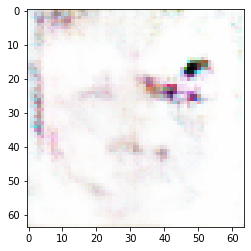

In [12]:
error_d_m5, error_g_m5, prediccion_falsa_m5 = entrenar(gan5, 5000, 150, "resultadosGAN-4/modelo5")

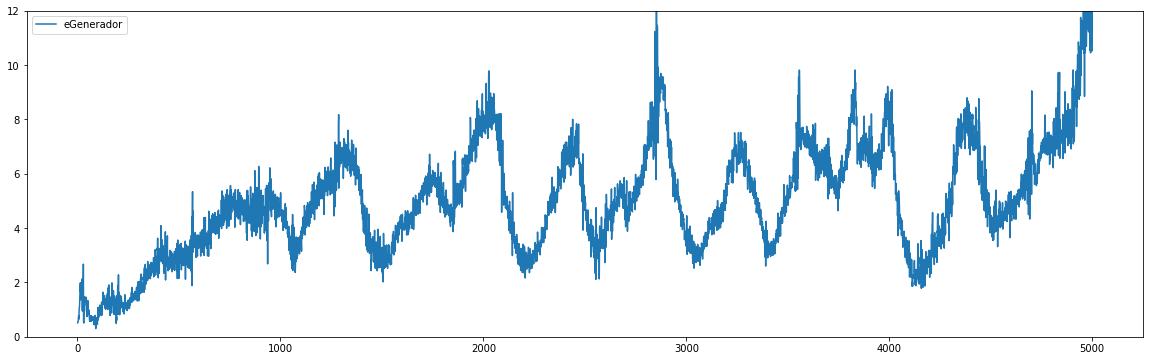

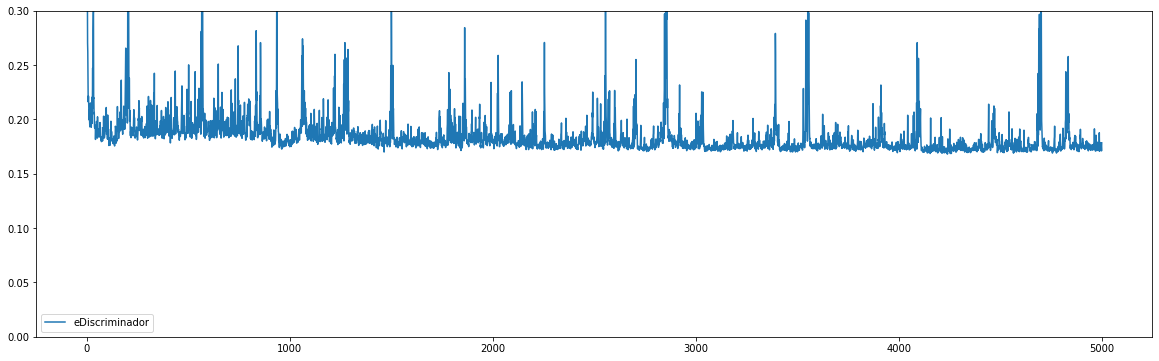

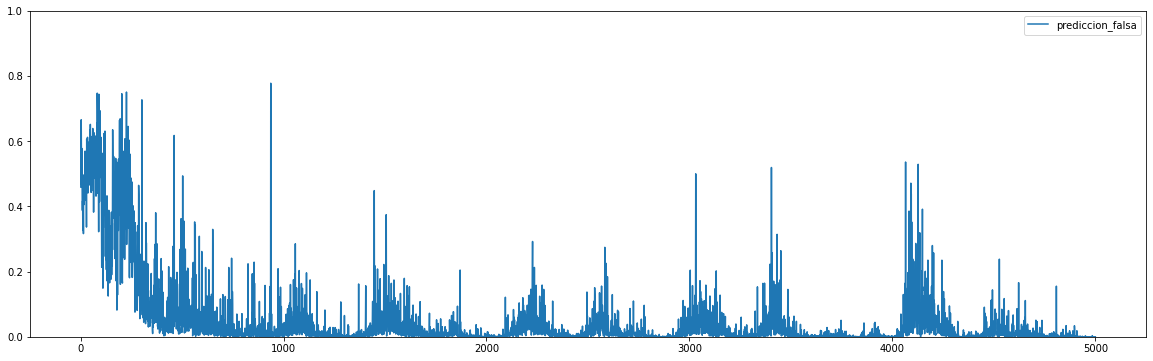

In [13]:
plot_acumulado(len(error_g_m5), 12, eGenerador = error_g_m5)
plot_acumulado(len(error_d_m5), 0.3, eDiscriminador = error_d_m5)
plot_acumulado(len(prediccion_falsa_m5), 1, prediccion_falsa = prediccion_falsa_m5)

In [ ]:
ruido = np.random.normal(0, 1, TAM_ENTRADA)
ruido =np.array([ruido])

predicion(gan5, ruido)